In [1]:
# Libraries helping with file retrival
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import os
from os import listdir
from os.path import isfile, join

# Visualization and data manipulation libraries
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import butter, lfilter
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=1.2)

# Model development and understanding

In [2]:
# Import ERP dataframe
df_erp = pd.read_csv('ProvidedData/ERP_Summary_limited.csv')

# Import Resting dataframe
df_resting = pd.read_csv('ProvidedData/Resting_Summary_limited.csv')
df_demog = pd.read_excel('EEG_128channels_ERP_lanzhou_2015/subjects_information_EEG_128channels_ERP_lanzhou_2015.xlsx',
                         sheet_name='Sheet1')  # Import demographics table


# Lets first create a patient identifier key
df_erp['patient_identifier'] = [i[:8] for i in df_erp['patient_identifier']]
df_erp['patient_identifier'] = df_erp['patient_identifier'].astype(int)
df_resting['patient_identifier'] = [i[:8]
                                    for i in df_resting['patient_identifier']]
df_resting['patient_identifier'] = df_resting['patient_identifier'].astype(int)

In [3]:
# Combining the datasets
# Step - 1: Merge Demog Data
intermediate_df = pd.merge(
    df_erp, df_demog, left_on='patient_identifier', right_on='subject id', how='inner')

# Merge Resting Data
df = pd.merge(intermediate_df, df_resting, left_on='patient_identifier',
              right_on='patient_identifier', how='inner')

print("df before: ", df.shape)

# Set Patient Identifier as index and delete some columns
df.set_index('patient_identifier', inplace=True)
df.drop(columns=['Unnamed: 11', 'Unnamed: 12', 'subject id'], inplace=True)

print("df after: ", df.shape)

df before:  (53, 718)
df after:  (53, 714)


In [4]:
# Explore the dataset
print("# of Patients:" + str(df.shape[0]))
print("******Understading Features******")
print("# of Electrode:16")

print("\n***Linear Features***")
print("# of Linear Features by emotion (Fear, Happy, Sad, Resting)\n16 Electrodes*8 features :" +
      str(len([i for i in df.columns if 'lf' in i and 'fear' in i])))

print("# of Total Linear Features\n16 Electrodes*8 features*4 Emotions: " +
      str(len([i for i in df.columns if 'lf' in i])))

print("\n***Non Linear Features***")
print("# of Non Features by emotion (Fear, Happy, Sad, Resting)\n16 Electrodes*3 features:" +
      str(len([i for i in df.columns if 'nl' in i and 'fear' in i])))
print("# of Non Linear Features\n:16 Electrodes*3 features*4 Emotions :" +
      str(len([i for i in df.columns if 'nl' in i])))
print("\n***Rest of the Features***")
print("# of Other Features:" +
      str(714-len([i for i in df.columns if 'nl' in i or 'lf' in i])))
print("\n***Total Features***")
print("# of Total Features (512+192+10):"+str(df.shape[1]))
df.head()

# of Patients:53
******Understading Features******
# of Electrode:16

***Linear Features***
# of Linear Features by emotion (Fear, Happy, Sad, Resting)
16 Electrodes*8 features :128
# of Total Linear Features
16 Electrodes*8 features*4 Emotions: 512

***Non Linear Features***
# of Non Features by emotion (Fear, Happy, Sad, Resting)
16 Electrodes*3 features:48
# of Non Linear Features
:16 Electrodes*3 features*4 Emotions :192

***Rest of the Features***
# of Other Features:10

***Total Features***
# of Total Features (512+192+10):714


lf_alpha_fear_E36  lf_beta_fear_E36  lf_delta_fear_E36  \
patient_identifier                                                           
2010008                      0.003473          0.003368           0.015247   
2010011                      0.004254          0.002348           0.016904   
2010015                      0.001797          0.001225           0.005069   
2010013                      0.002016          0.001013           0.003829   
2010012                      0.009081          0.004736           0.040018   

                    lf_theta_fear_E36  lf_mean_fear_E36  lf_max_fear_E36  \
patient_identifier                                                         
2010008                      0.007565          0.059222       517.229278   
2010011                      0.006377          0.089253       867.522513   
2010015                      0.002325          0.011508        60.477420   
2010013                      0.002445          0.024019       241.903701   
2010012                      0.015150          0.038334       180.524548   

                    lf_min_fear_E36  lf_median_fear_E36  lf_alpha_happy_E36  \
patient_identifier                                                            
2010008                    0.000041            0.003682            0.002941   
2010011                    0.000025            0.002415            0.002548   
2010015                    0.000012            0.001242            0.002351   
2010013                    0.000014            0.001012            0.003692   
2010012                    0.000026            0.005003            0.003708   

                    lf_beta_happy_E36  ...  lf_beta_resting_E96  \
patient_identifier                     ...                        
2010008                      0.001625  ...          8990.789709   
2010011                      0.002193  ...          4839.226925   
2010015                      0.001448  ...          3101.825351   
2010013                      0.001926  ...          1670.780659   
2010012                      0.002653  ...         12476.861737   

                    lf_delta_resting_E96  lf_theta_resting_E96  \
patient_identifier                                               
2010008                     79698.436736          29945.553683   
2010011                     25285.119665           9797.788046   
2010015                     24831.077259           9134.868438   
2010013                     10659.439181           4828.711243   
2010012                    110306.351382          41684.525211   

                    lf_mean_resting_E96  lf_max_resting_E96  \
patient_identifier                                            
2010008                   111923.551768        8.038292e+08   
2010011                    85590.059405        8.093862e+08   
2010015                    65408.248917        5.234847e+08   
2010013                    43732.055011        4.401827e+08   
2010012                   115273.109337        5.478030e+08   

                    lf_min_resting_E96  lf_median_resting_E96  \
patient_identifier                                              
2010008                     414.748991            8716.870511   
2010011                       2.808689            4743.683717   
2010015                       7.695048            3132.808279   
2010013                      15.352059            1535.344760   
2010012                    1951.364364           12226.153795   

                    nl_svden_resting_E96  nl_spec_enresting_E96  \
patient_identifier                                                
2010008                         0.293716               0.339961   
2010011                         0.548817               0.469027   
2010015                         0.282948               0.341356   
2010013                         0.477561               0.537580   
2010012                         0.411179               0.455350   

                    nl_permenresting_E96  
patient_identifier                        

In [5]:
# Code to build box plots
def box_plot_builder(df, key='age', title_vals='Bias in Enrollment'):
    """
    Inputs:
    df - dataframe
    key - On which we need to group by data
    title_vals - Expected title for the chart

    Outputs:
    Box plot
    """
    val = key
    # Build a categorical column as key for the charts
    key = pd.cut(df[key], bins=5)
    # Let's first find our demographic profile
    temp = df.groupby([key, 'type']).count()['lf_beta_fear_E36'].unstack()
    temp.columns = ['Normal', 'MDD']

    # Preparing data to represent in grouped column chart
    labels = [(round(i.left), round(i.right)) for i in temp.index.categories]
    normal = temp.Normal/np.sum(temp.Normal)
    mdd = temp.MDD/np.sum(temp.MDD)
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, normal, width, label='HC (29)')
    rects2 = ax.bar(x + width/2, mdd, width, label='MDD (24)')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('% of patients')
    ax.set_title(title_vals)
    # ax.set_xticks(x, labels)
    ax.set_xlabel(val)
    ax.set_xticks(x)  # values
    ax.set_xticklabels(labels)  # labels
    ax.legend()

    # save the charts
    fig.tight_layout()

    path_to_save = 'Images/EA_Demog_'+val+'.png'
    fig.savefig(path_to_save, dpi=100)

    plt.show()

In [6]:
df_demog.columns

Index(['subject id', 'type', 'age', 'gender', 'education（years）', 'PHQ-9',
       'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI', 'Unnamed: 11', 'Unnamed: 12'],
      dtype='object')

In [7]:
df_demog.groupby('type').agg({'age': ['count', 'mean'], 'education（years）': ['mean'], 'CTQ-SF': 'mean',
                              'LES': 'mean', 'SSRS': 'mean', 'GAD-7': 'mean', 'PSQI': 'mean'}).to_csv('Images/EA_Participant_summary.csv')

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby([key, 'type']).count()['lf_beta_fear_E36'].unstack()


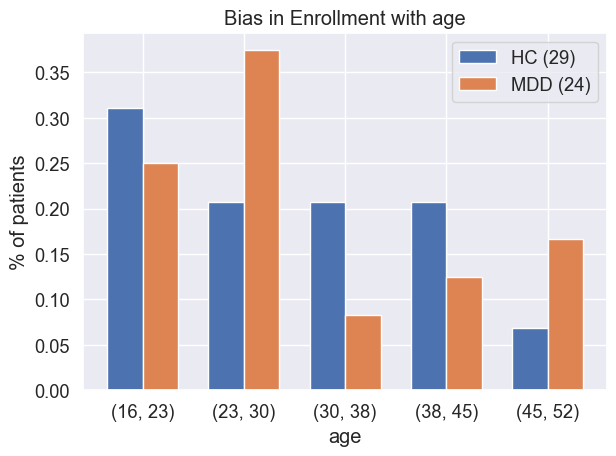

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby([key, 'type']).count()['lf_beta_fear_E36'].unstack()
C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:40: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.tight_layout()
C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:40: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.tight_layout()
C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:43: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.savefig(path_to_save, dpi=100)
C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:43: UserWa

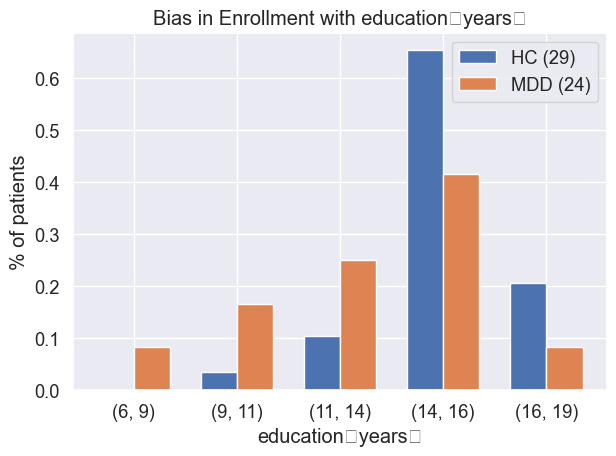

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby([key, 'type']).count()['lf_beta_fear_E36'].unstack()


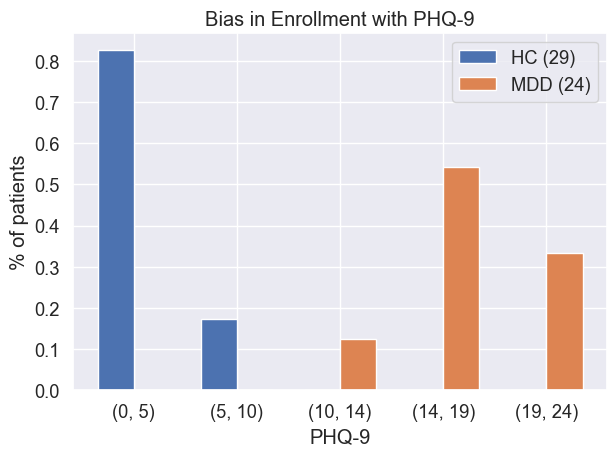

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby([key, 'type']).count()['lf_beta_fear_E36'].unstack()


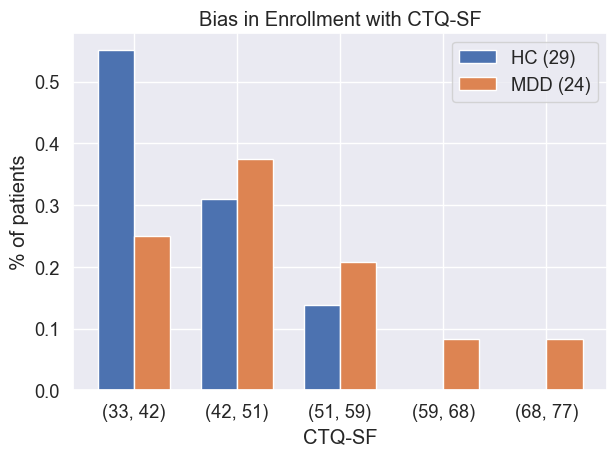

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby([key, 'type']).count()['lf_beta_fear_E36'].unstack()


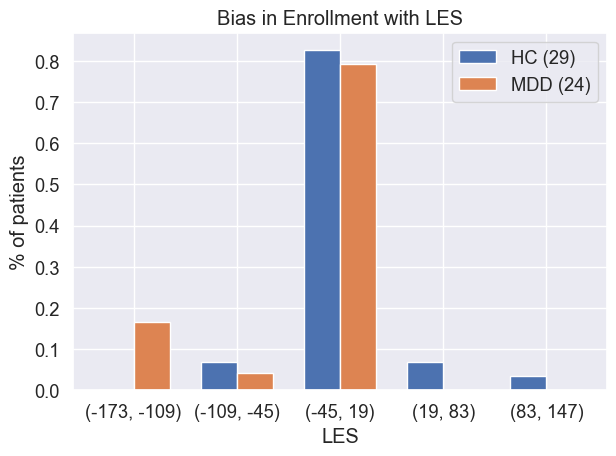

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby([key, 'type']).count()['lf_beta_fear_E36'].unstack()


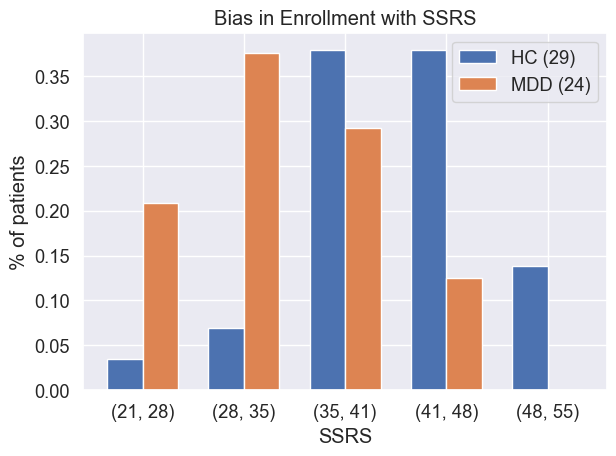

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby([key, 'type']).count()['lf_beta_fear_E36'].unstack()


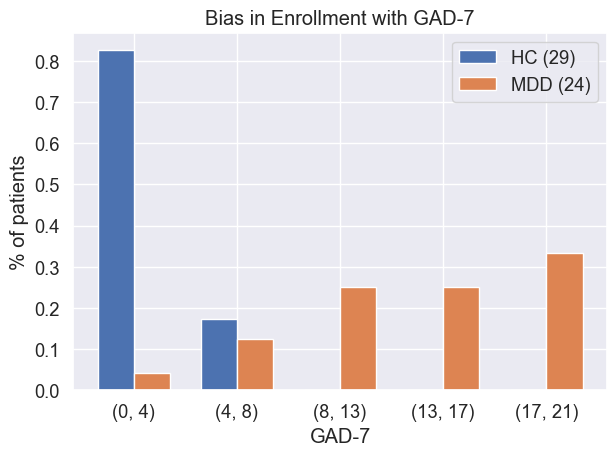

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3812419331.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby([key, 'type']).count()['lf_beta_fear_E36'].unstack()


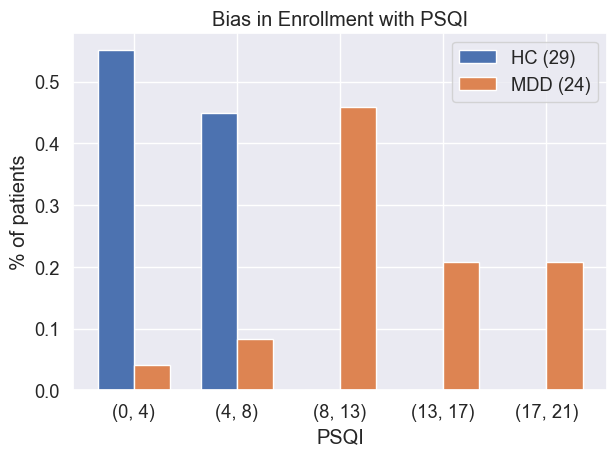

In [8]:
# Looping through various demographics columns
for cols in ['age', 'education（years）', 'PHQ-9', 'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']:
    box_plot_builder(df, key=cols, title_vals='Bias in Enrollment with '+cols)

In [9]:
columns_to_drop = ['age', 'education（years）',
                   'PHQ-9', 'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']

In [10]:
df.columns

Index(['lf_alpha_fear_E36', 'lf_beta_fear_E36', 'lf_delta_fear_E36',
       'lf_theta_fear_E36', 'lf_mean_fear_E36', 'lf_max_fear_E36',
       'lf_min_fear_E36', 'lf_median_fear_E36', 'lf_alpha_happy_E36',
       'lf_beta_happy_E36',
       ...
       'lf_beta_resting_E96', 'lf_delta_resting_E96', 'lf_theta_resting_E96',
       'lf_mean_resting_E96', 'lf_max_resting_E96', 'lf_min_resting_E96',
       'lf_median_resting_E96', 'nl_svden_resting_E96',
       'nl_spec_enresting_E96', 'nl_permenresting_E96'],
      dtype='object', length=714)

In [11]:
# Helper function - Purpose is to extract necessary column from the dataframe as per set initialized and plot correlation map of 16 electodes
# Also provide a view on how they differ between Depression and Normal patient

def columns_extractor(df, emotion, feature_type, name):
    """
    Inputs:
    df - Dataframe that we are using
    emotion - There are four emotions namely : Happy, Fear, Sad and Resting
    Feature - Either Linear feature (lf) or Non-linear features (nl)
    Outputs:
    resultant data frame
    """
    if feature_type == 'lf':
        columns_to_extract = [
            i for i in df.columns if feature_type in i and emotion in i and name in i]
        final_cols = {i: i.replace(
            feature_type+'_'+name+'_'+emotion+'_', '') for i in columns_to_extract}
    else:
        columns_to_extract = [
            i for i in df.columns if feature_type in i and name in i and emotion in i]
        final_cols = {i: i.replace(
            feature_type+'_'+name+emotion+'_', '') for i in columns_to_extract}
    columns_to_extract.extend(['type'])
    # print(columns_to_extract)
    df_result = df[columns_to_extract]
    return df_result.rename(columns=final_cols)


def correlation_builder(df, prefix):
    """
    Inputs:
    df - Dataframe to be used
    Outputs:
    chart object - This will be saved for future reference
    """
    # Correlation cross tab
    corr_all = df[[i for i in df.columns if 'type' not in i]].corr()
    corr_md = df[df['type'] == 'MDD'][[
        i for i in df.columns if 'type' not in i]].corr()
    corr_hc = df[df['type'] == 'HC'][[
        i for i in df.columns if 'type' not in i]].corr()
    list_corr = [corr_all, corr_md, corr_hc]
    titles = ['All Participants', 'MDD', 'HC']
    # Mask for the upper triangle of correlation to be masked
    mask = np.zeros_like(corr_all)
    mask[np.triu_indices_from(mask)] = True
    min = -1
    max = 1
    a = dict()
    fig = plt.figure(figsize=(30, 12))
    for val in range(3):
        with sns.axes_style("white"):
            a[val] = fig.add_subplot(1, 3, val+1)
            a[val] = sns.heatmap(list_corr[val], mask=mask, square=True, vmin=min, vmax=max, cmap=sns.cm.rocket_r,
                                 cbar_kws=dict(use_gridspec=False, location="bottom"))
            a[val].set_title(titles[val], fontdict={
                             'fontsize': '20', 'fontweight': '5'})

    # sns.heatmap(arr, ax=ax, cbar_ax = cbar_ax, cbar=True)
    fig.suptitle('Heat Map for '+prefix, fontsize=30)
    path_to_save = 'Images/EA_'+prefix+'.png'
    fig.savefig(path_to_save, dpi=100)
    return corr_all, fig


def column_eliminator(df, thr=0.9):
    columns = np.full((df.shape[0],), True, dtype=bool)
    for i in range(df.shape[0]):
        for j in range(i+1, df.shape[0]):
            if df.iloc[i, j] >= thr:
                if columns[j]:
                    columns[j] = False
    return columns

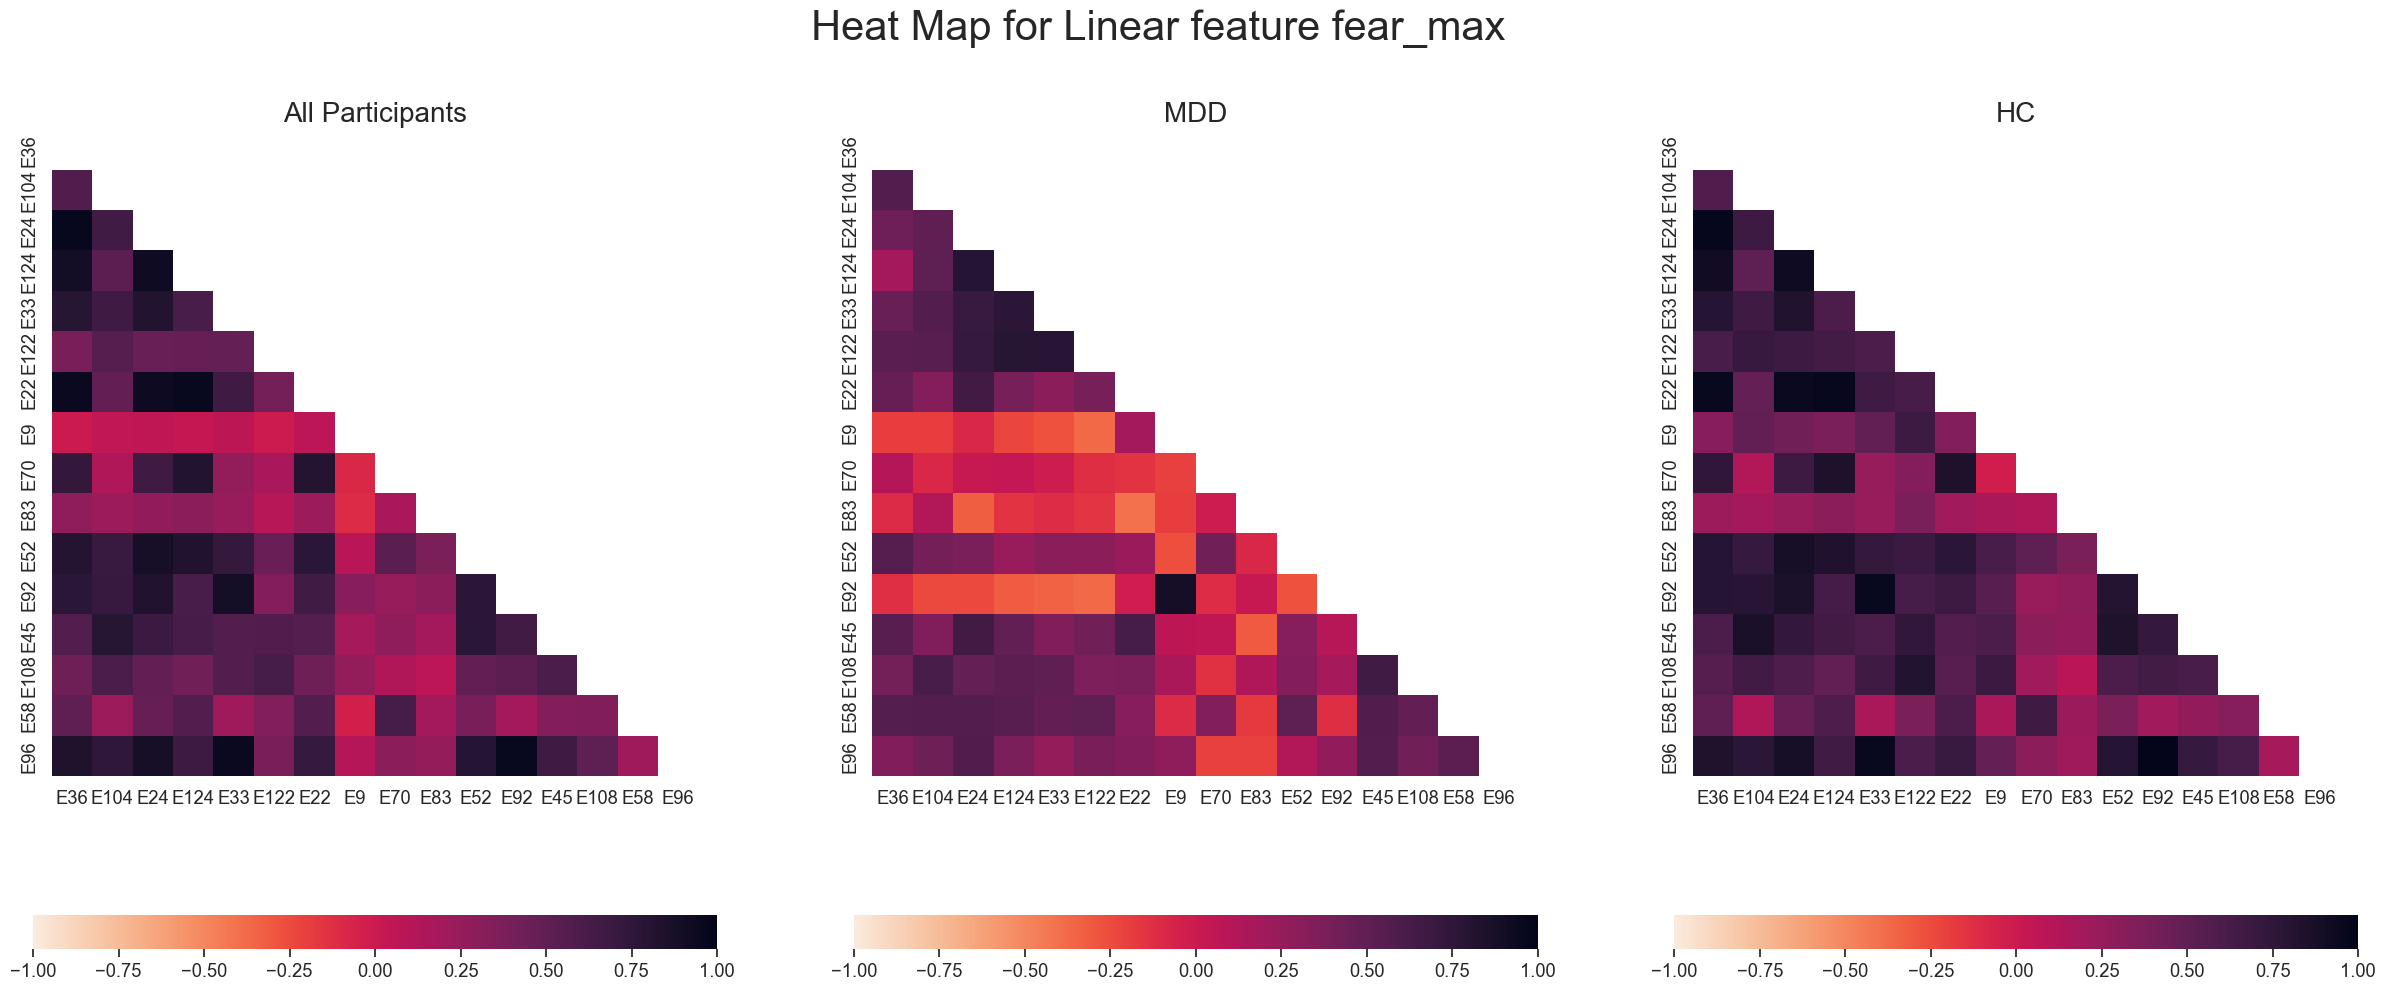

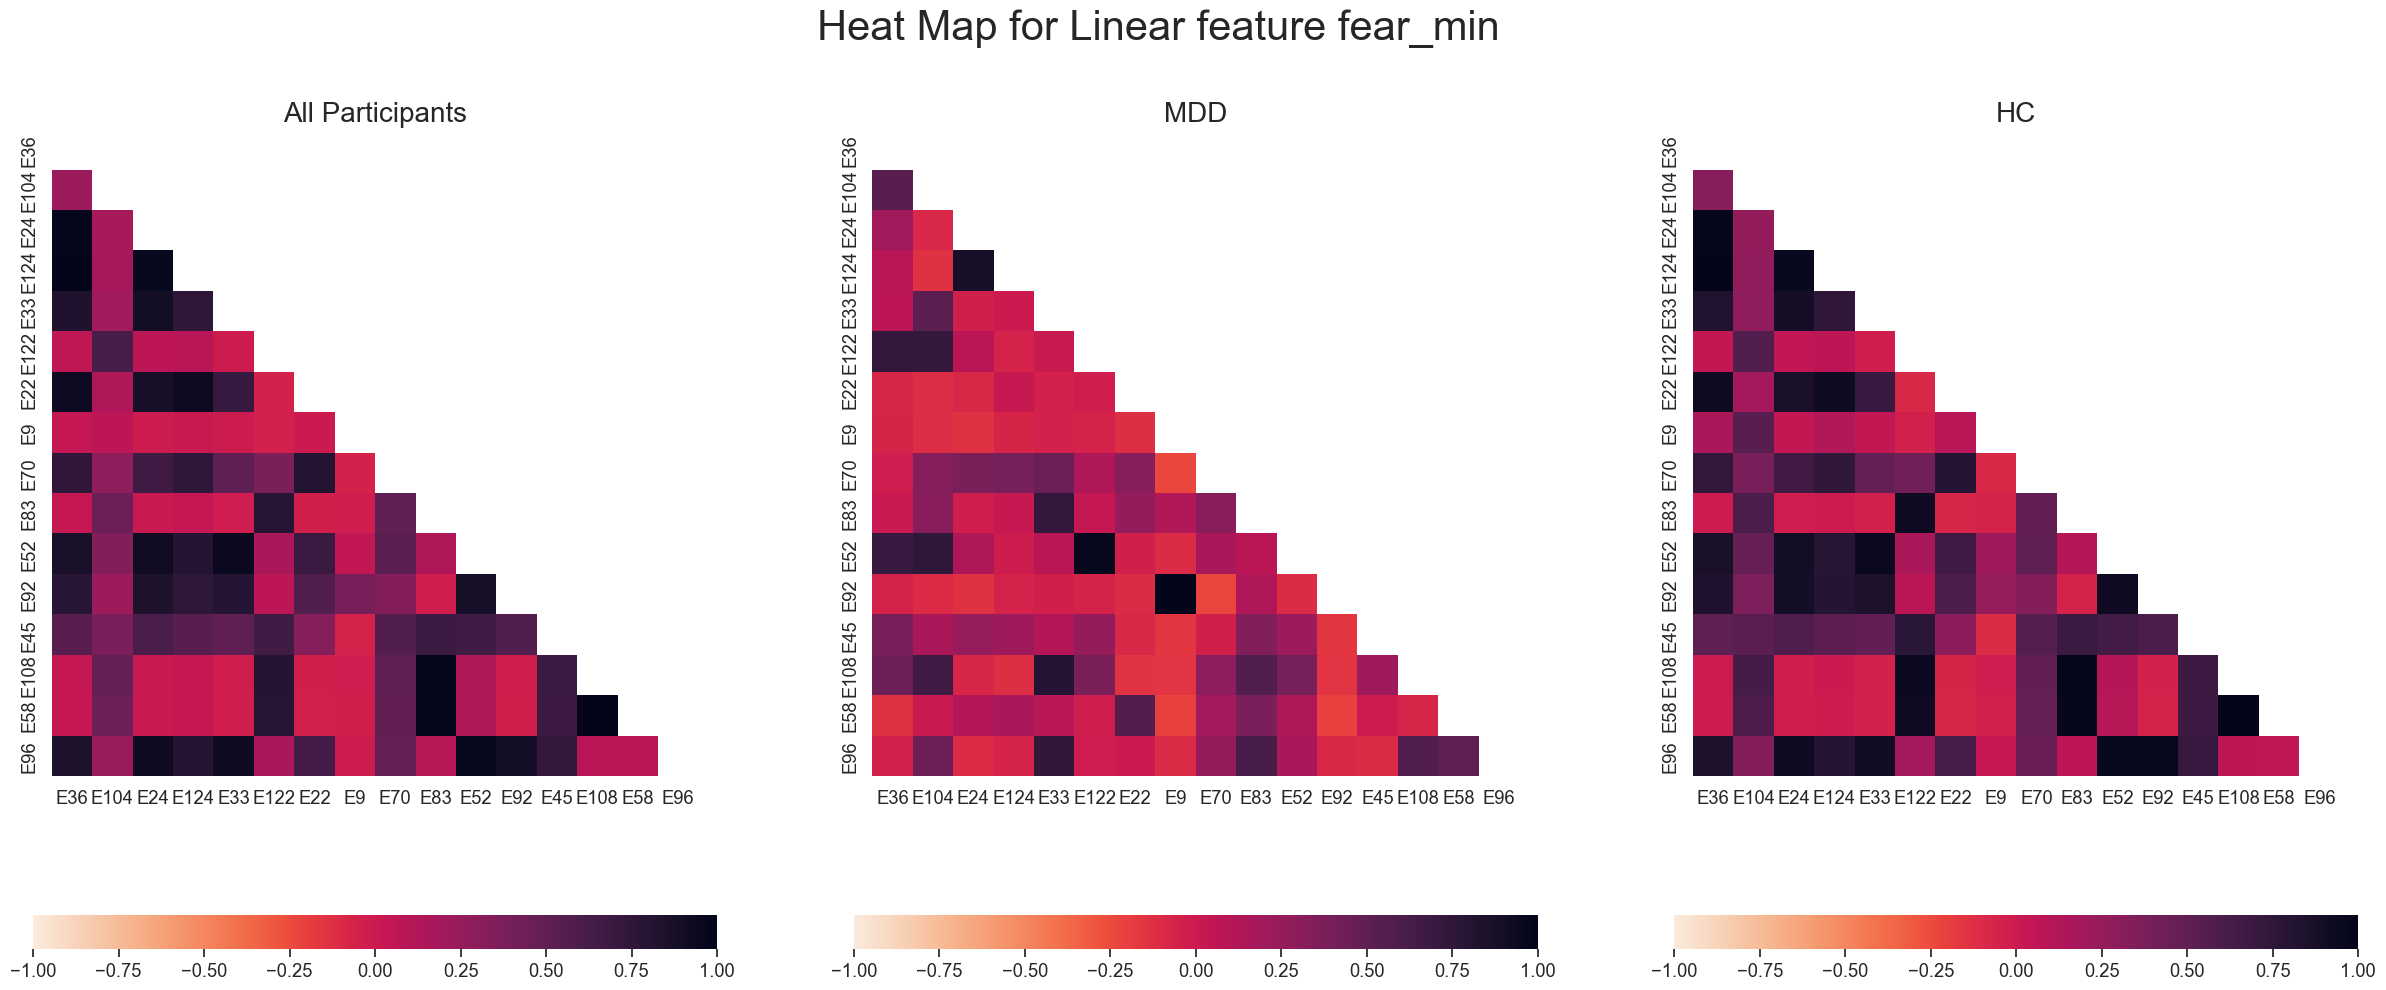

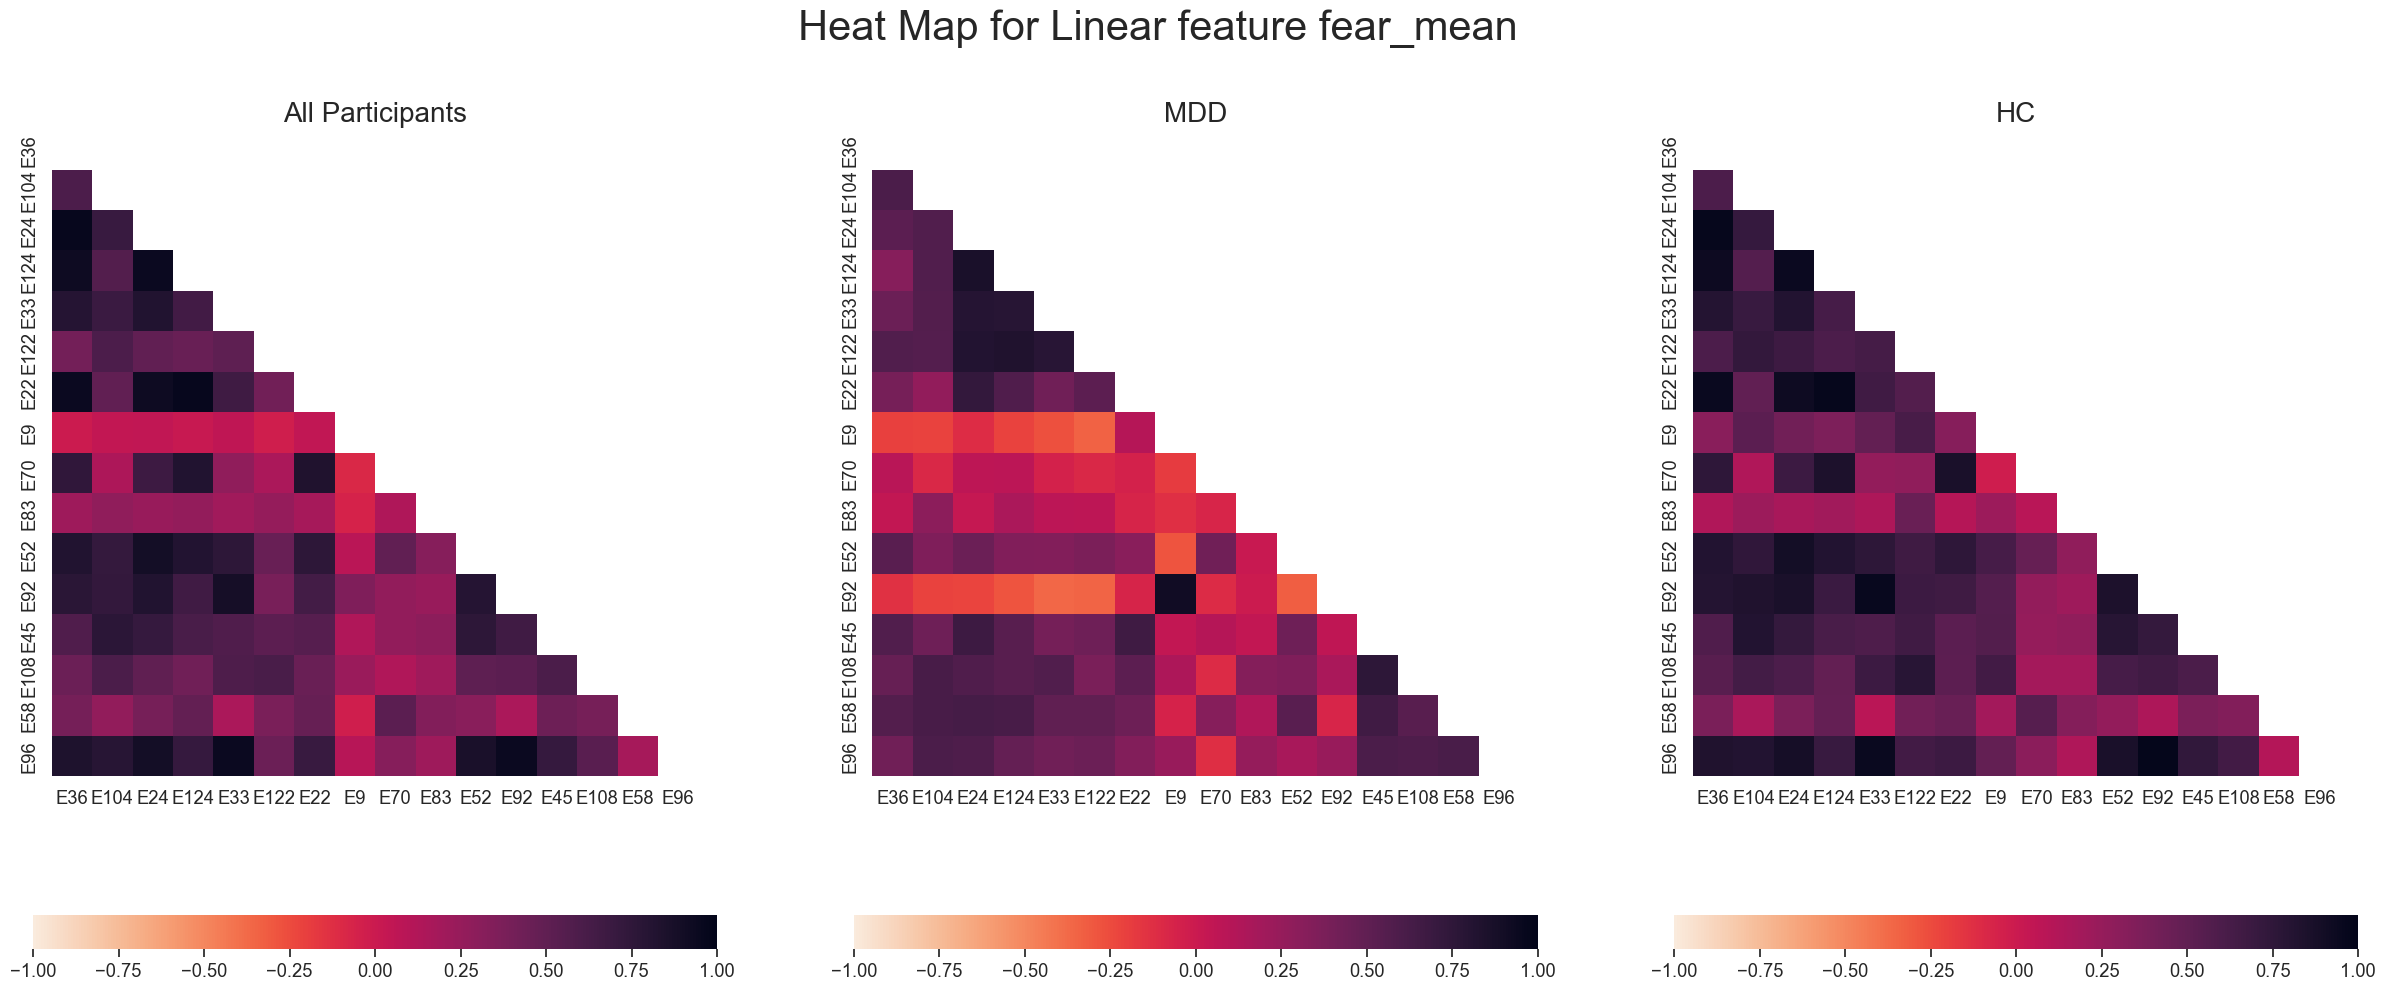

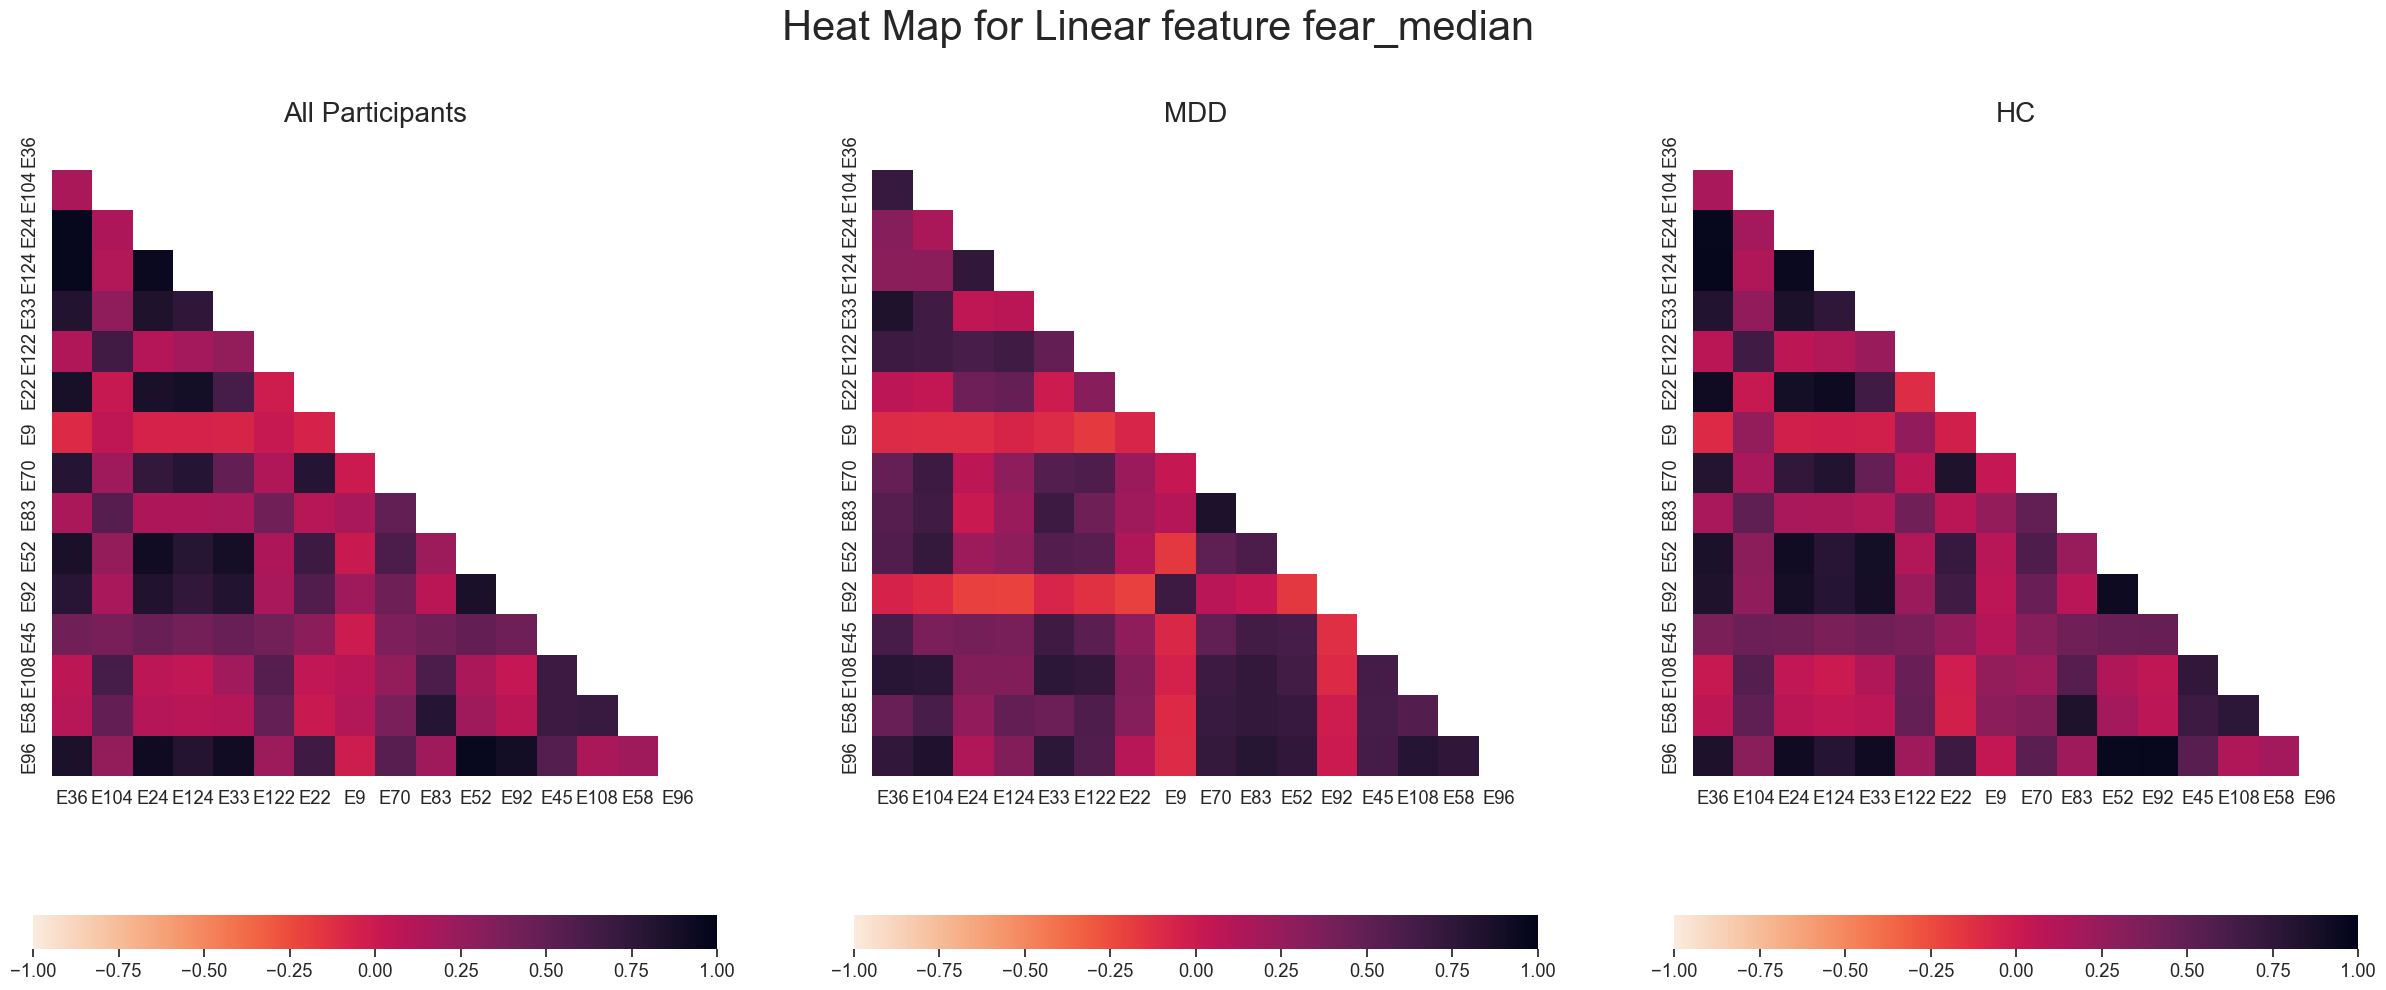

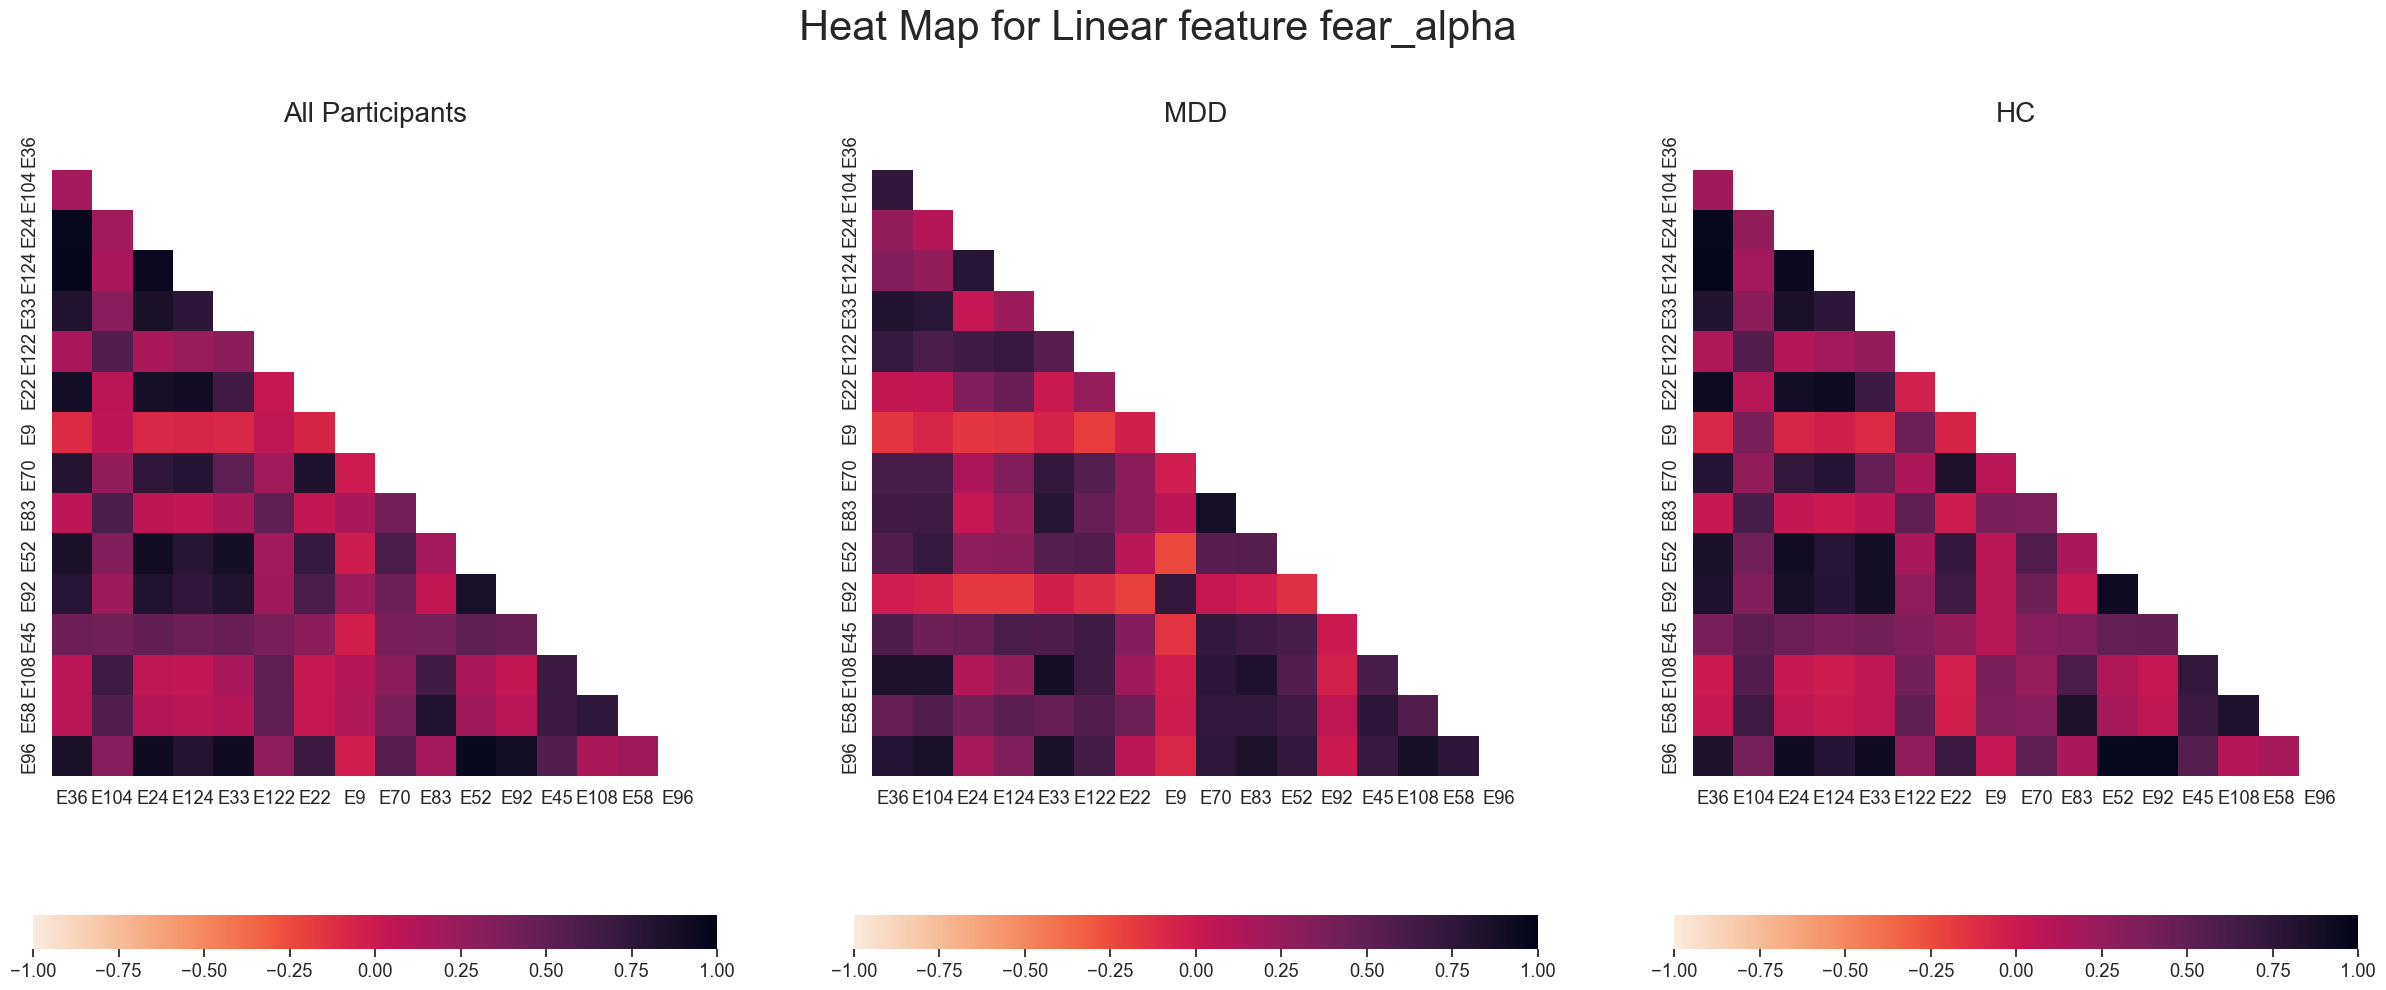

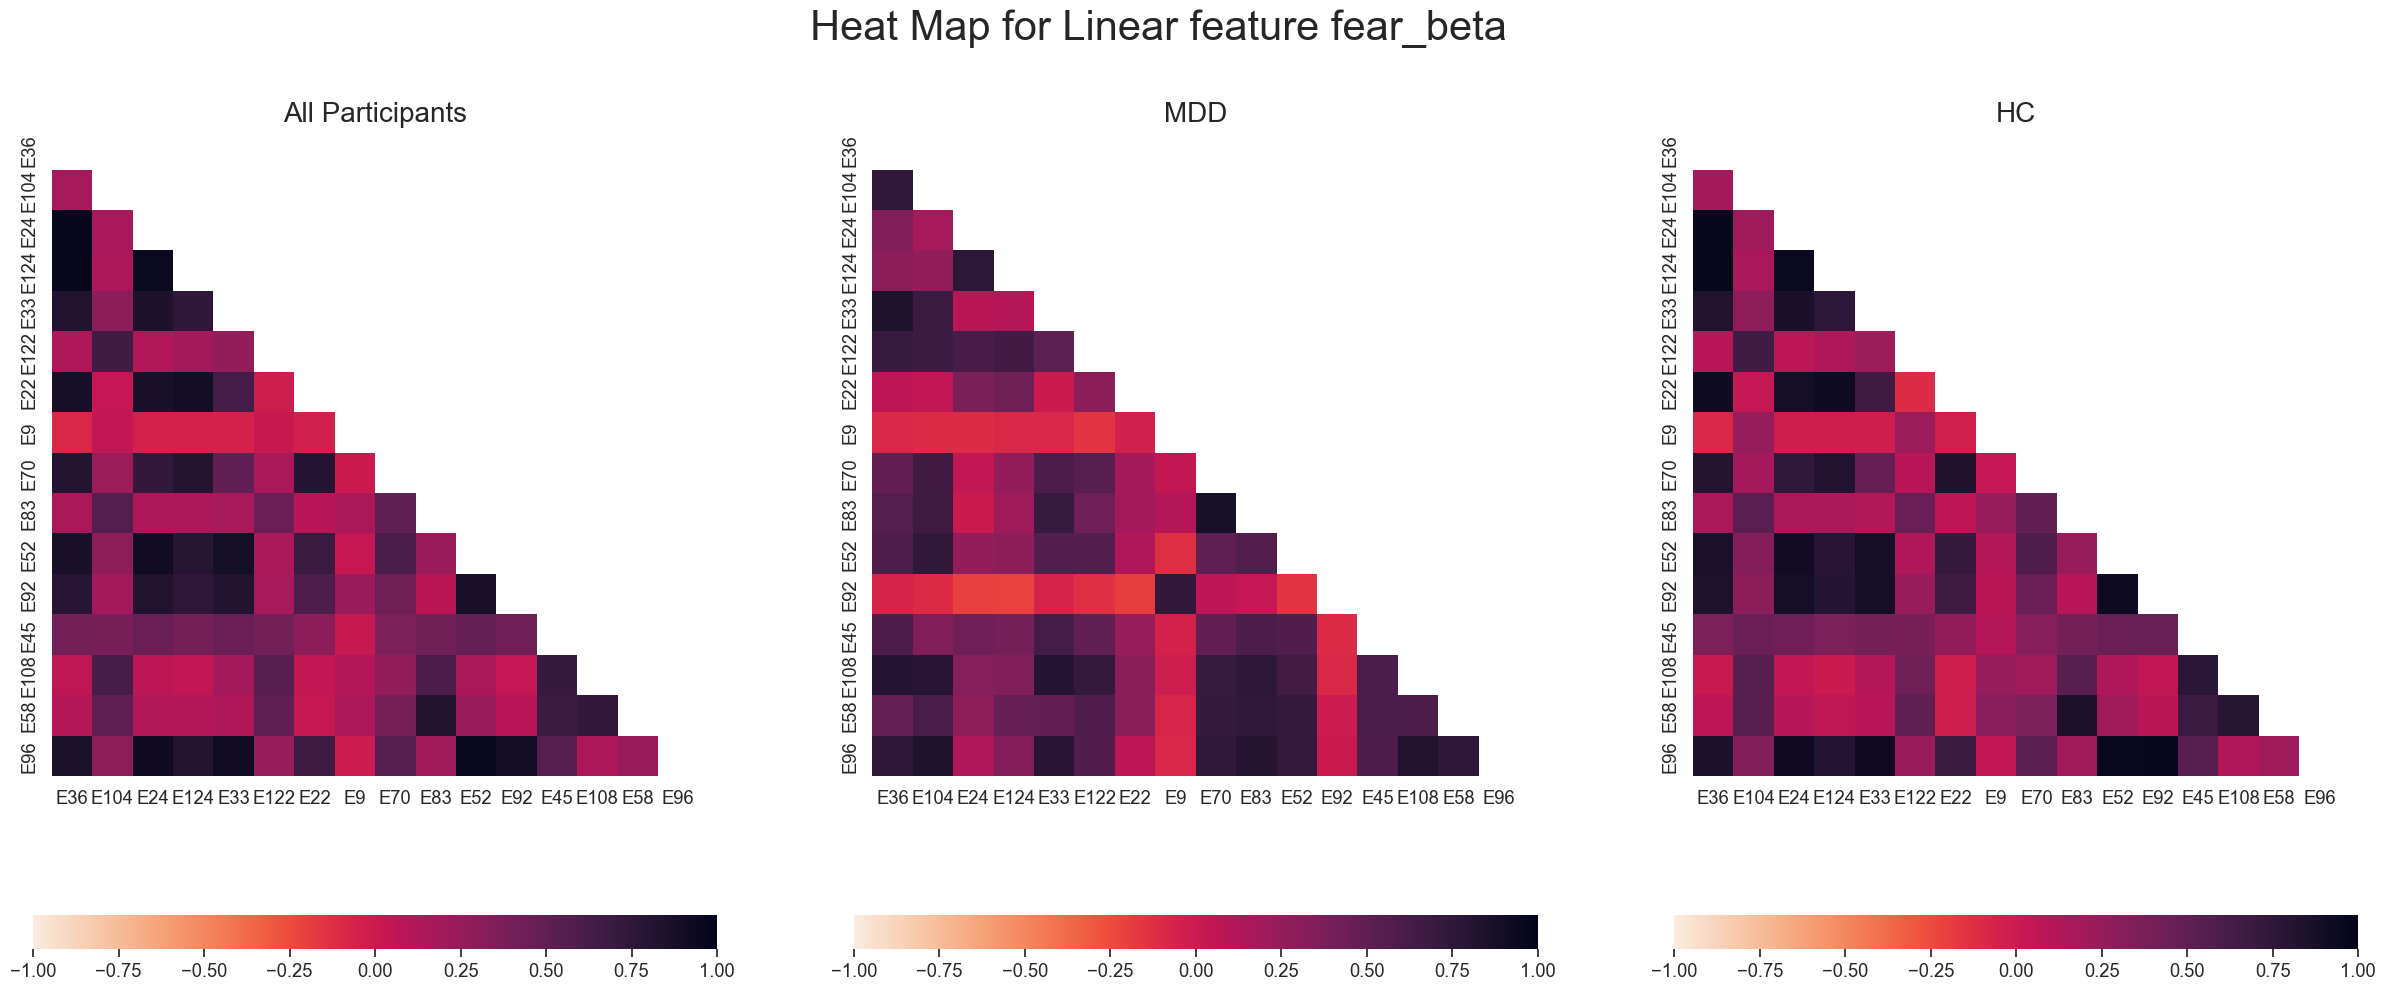

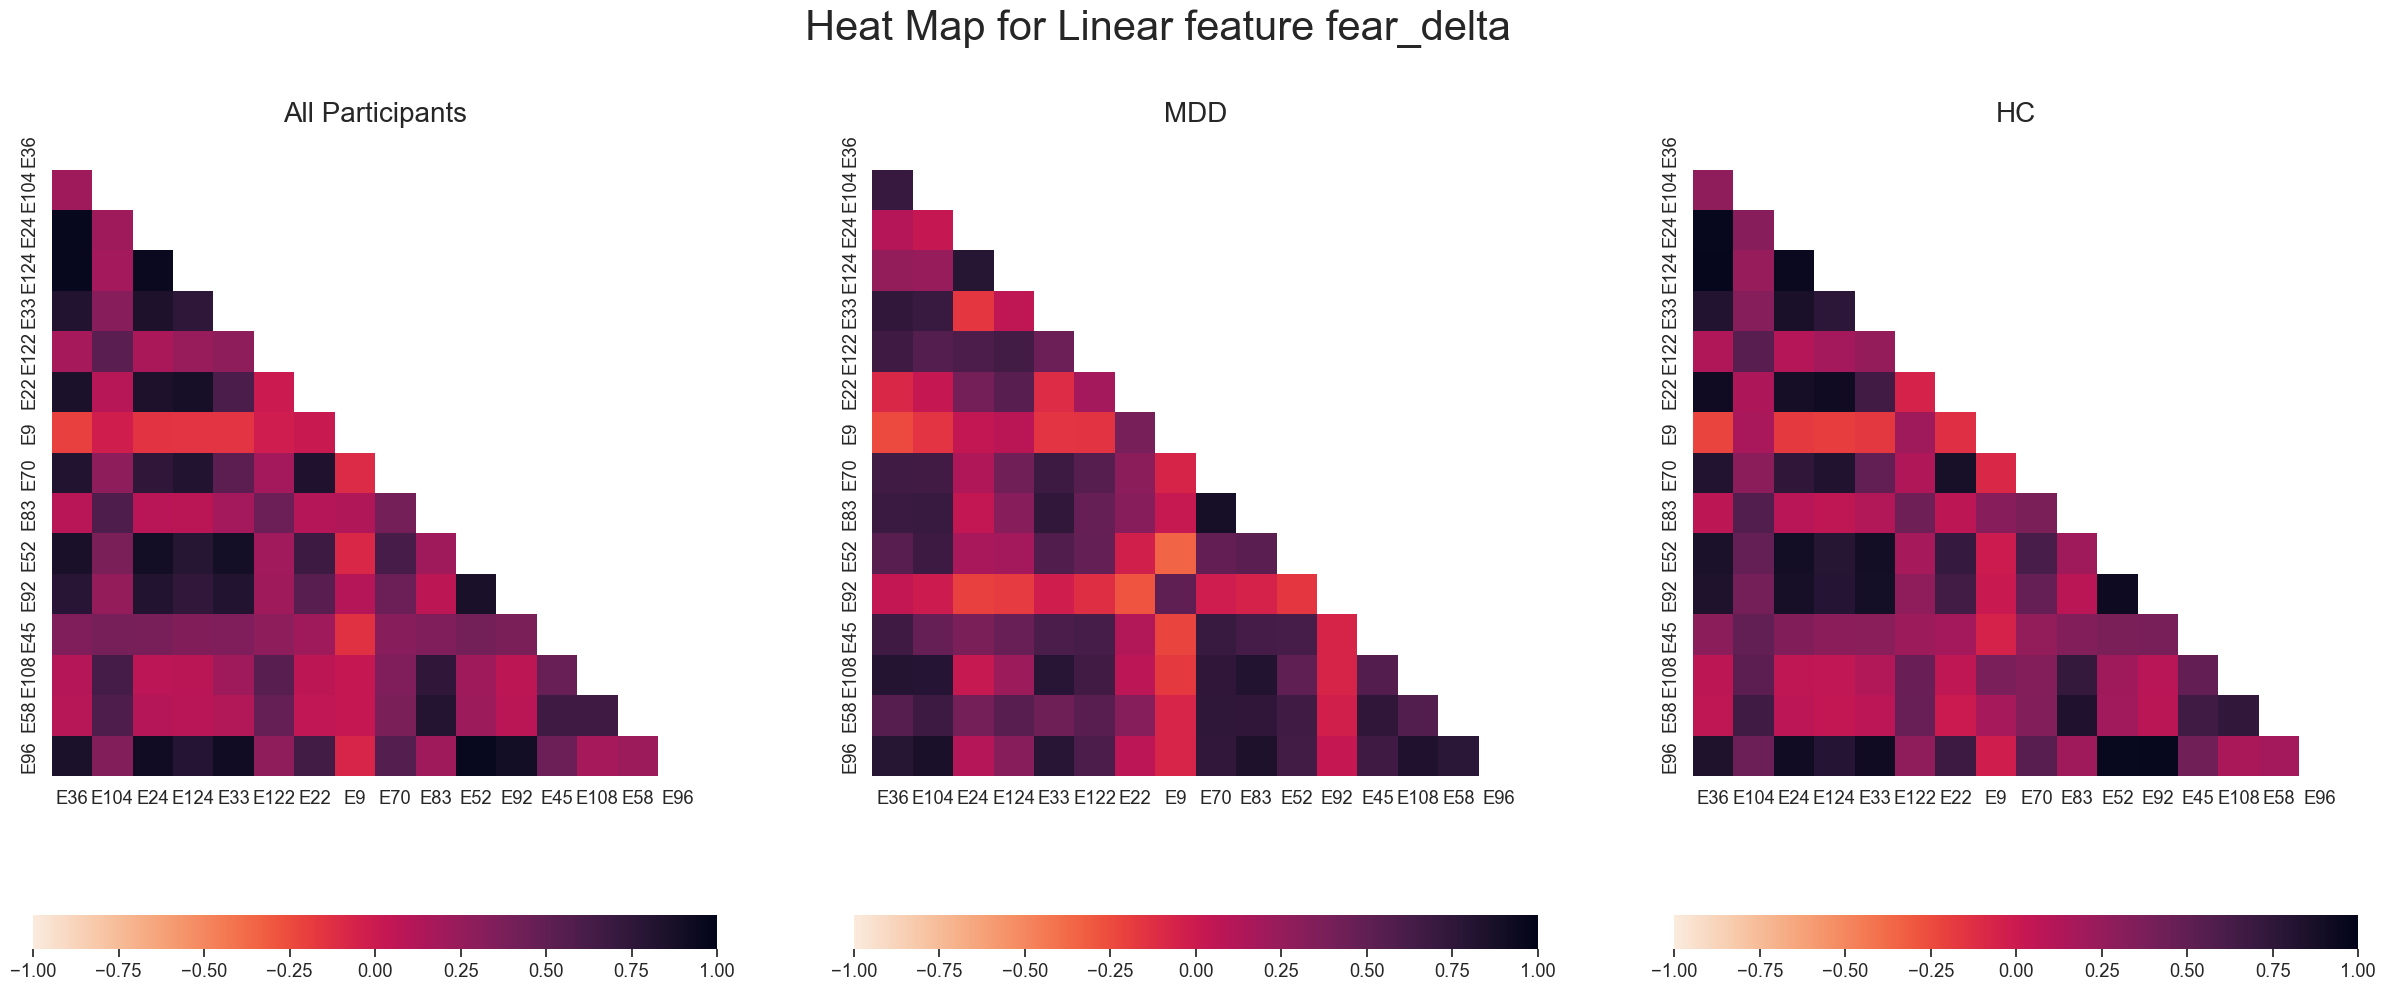

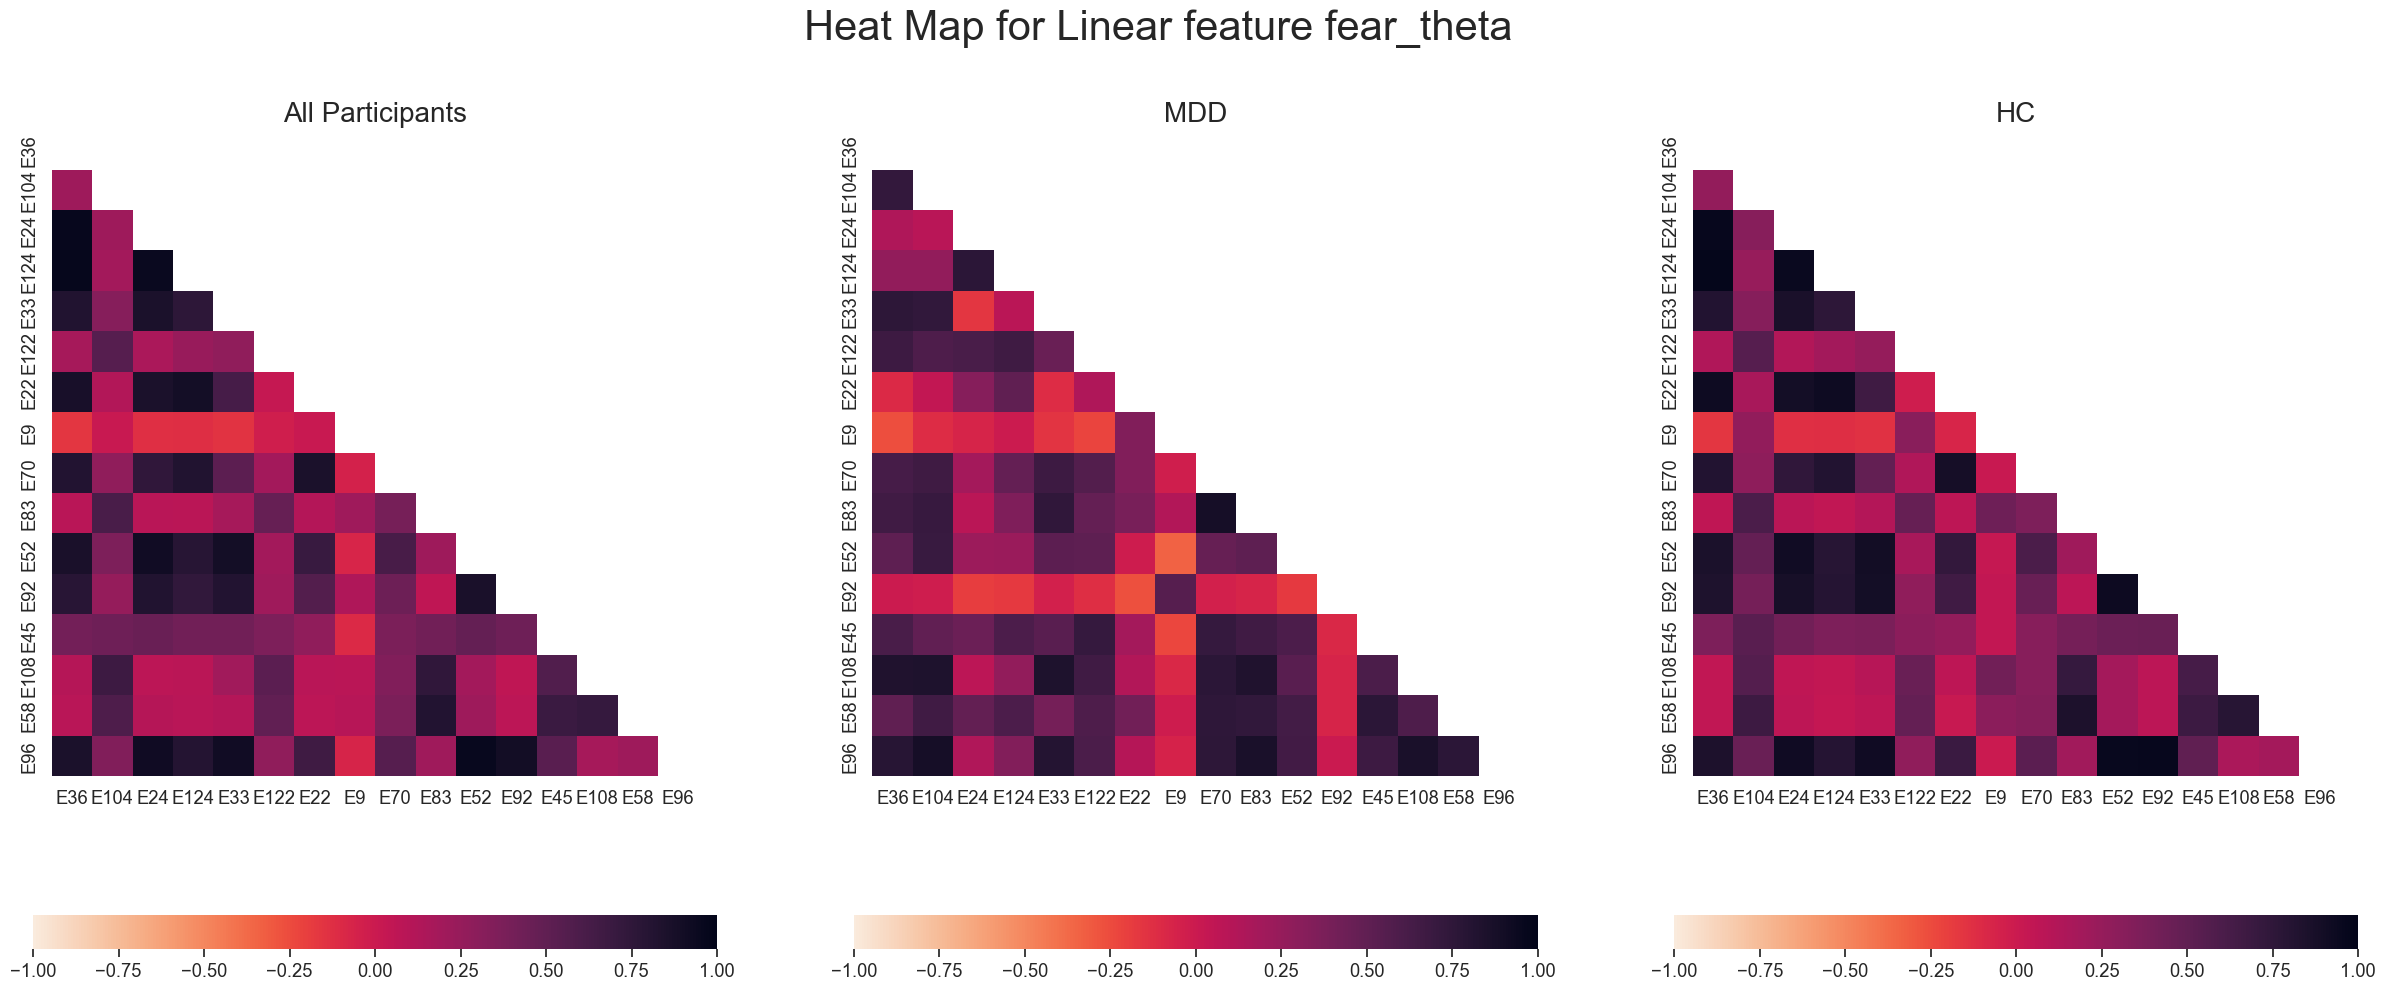

In [12]:
emotion = 'fear'
for name in ['max', 'min', 'mean', 'median', 'alpha', 'beta', 'delta', 'theta']:
    temp = columns_extractor(df, emotion, 'lf', name)
    a, b = correlation_builder(temp, prefix='Linear feature '+emotion+'_'+name)

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\3879978974.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(30, 12))


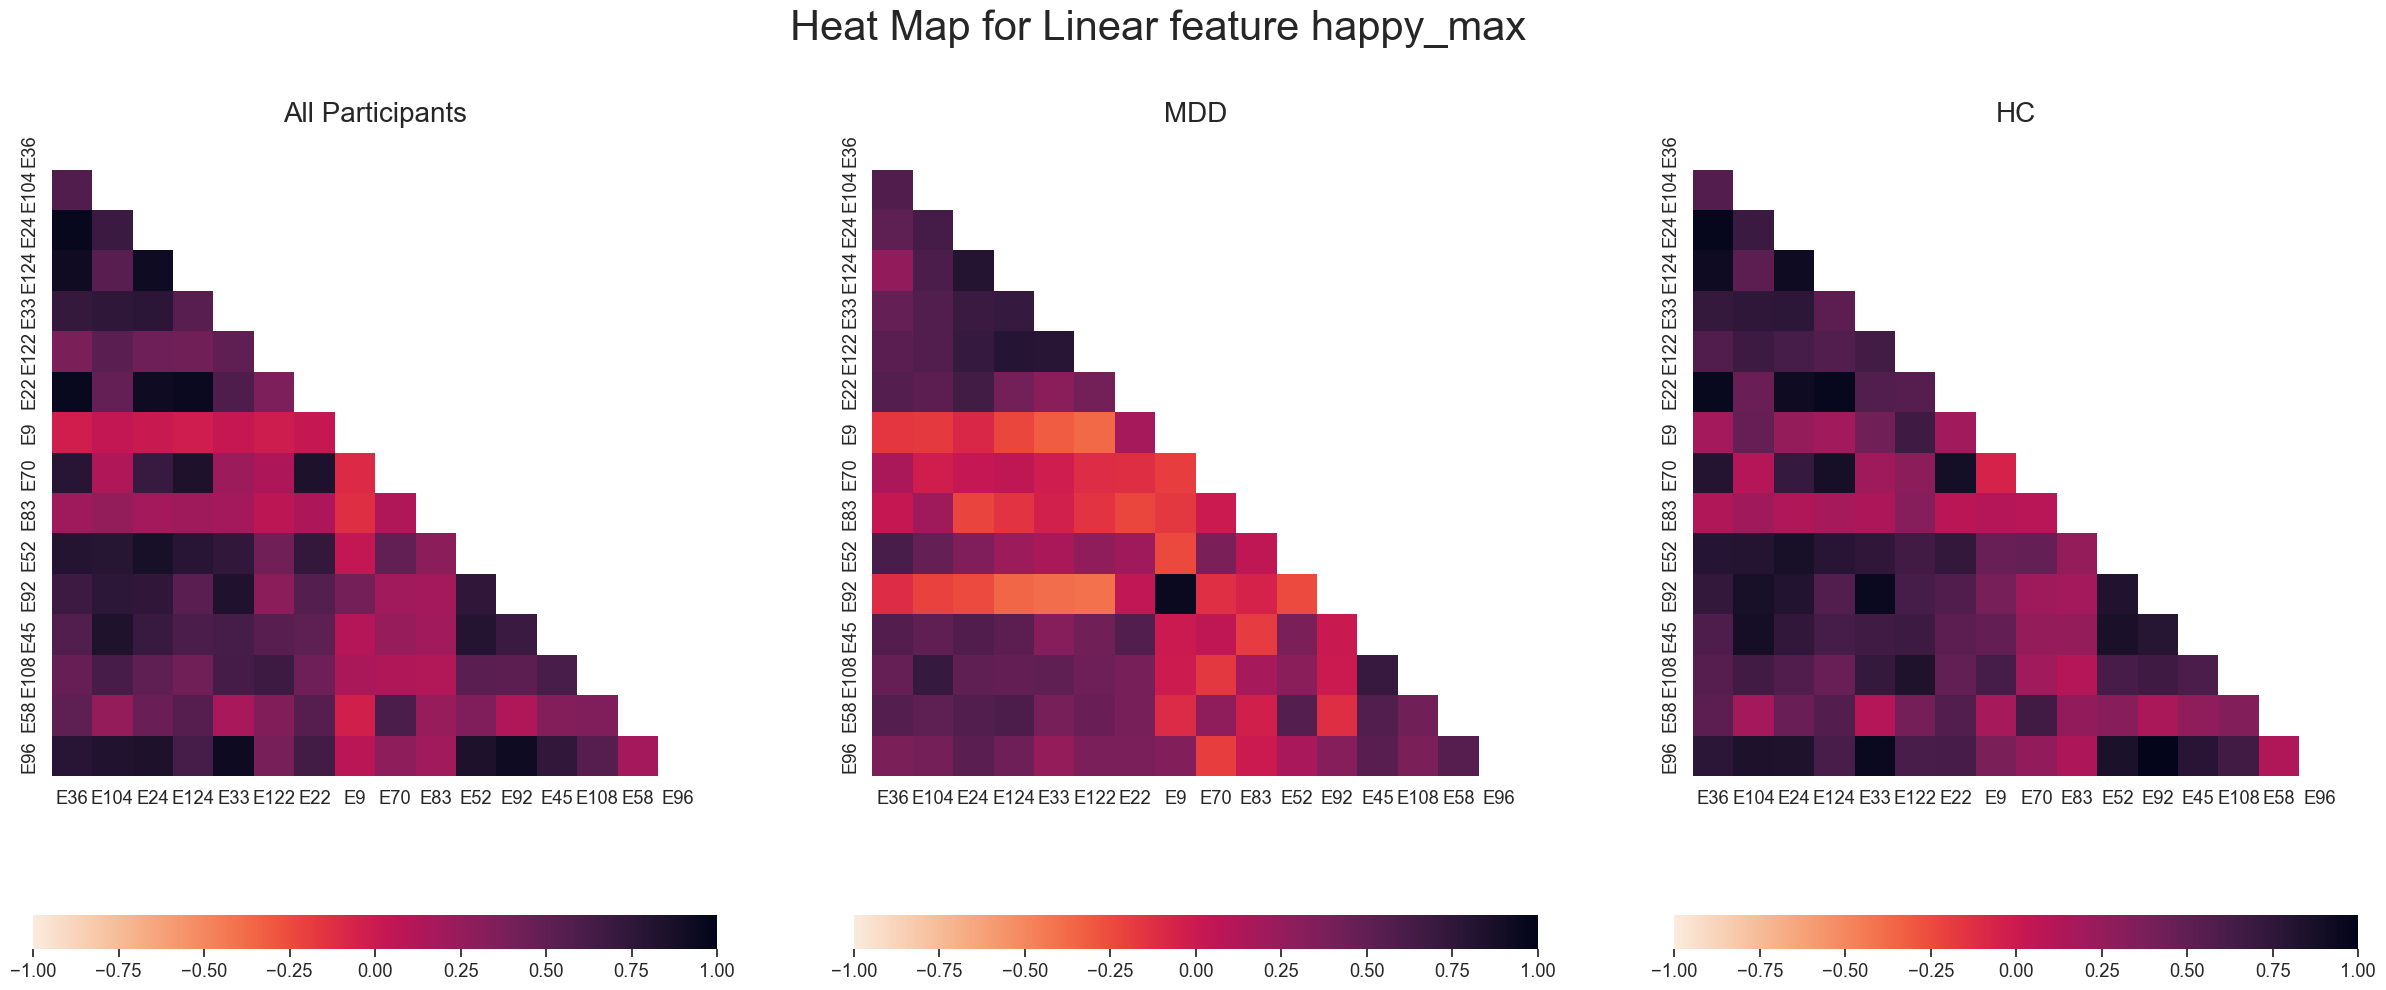

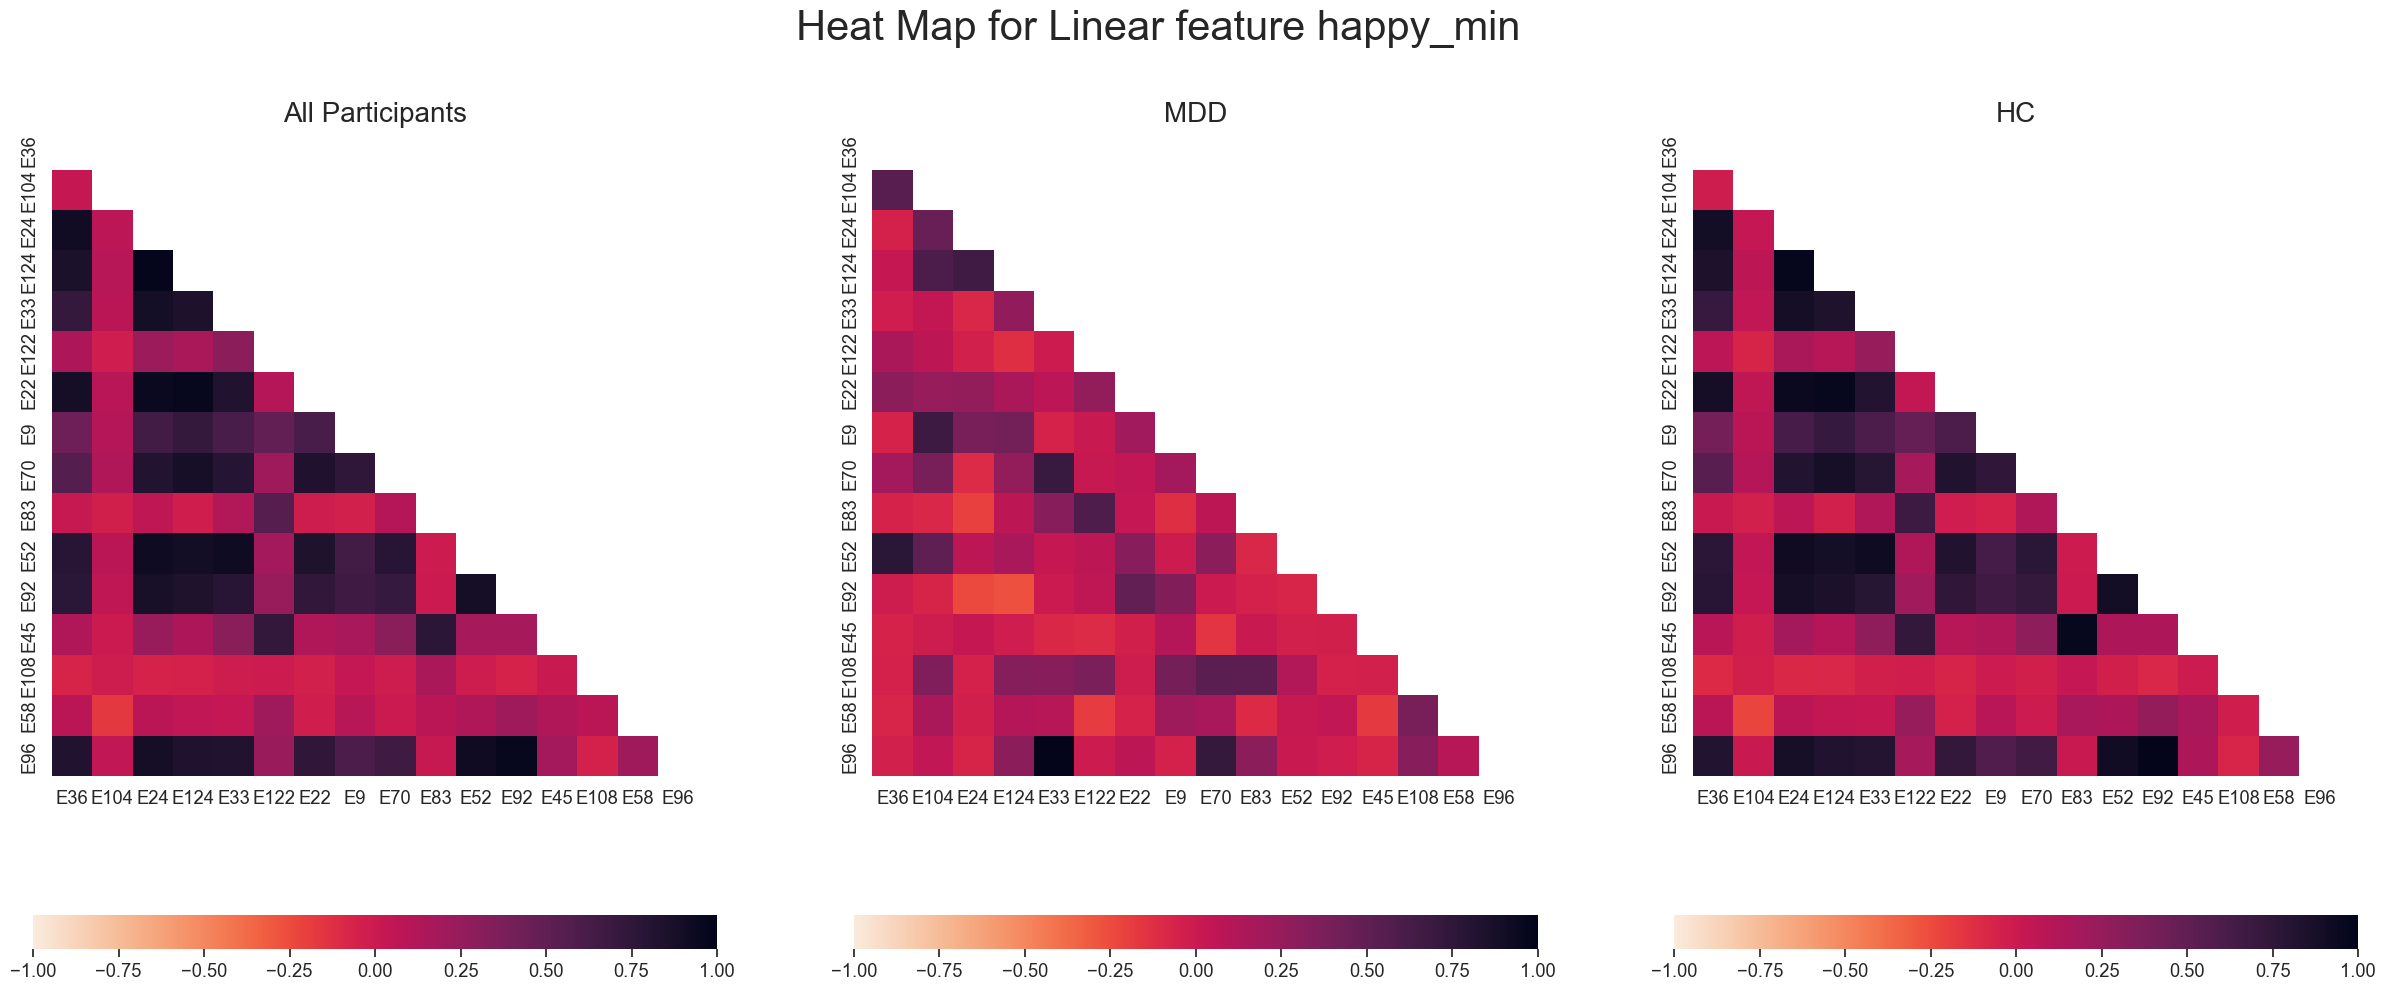

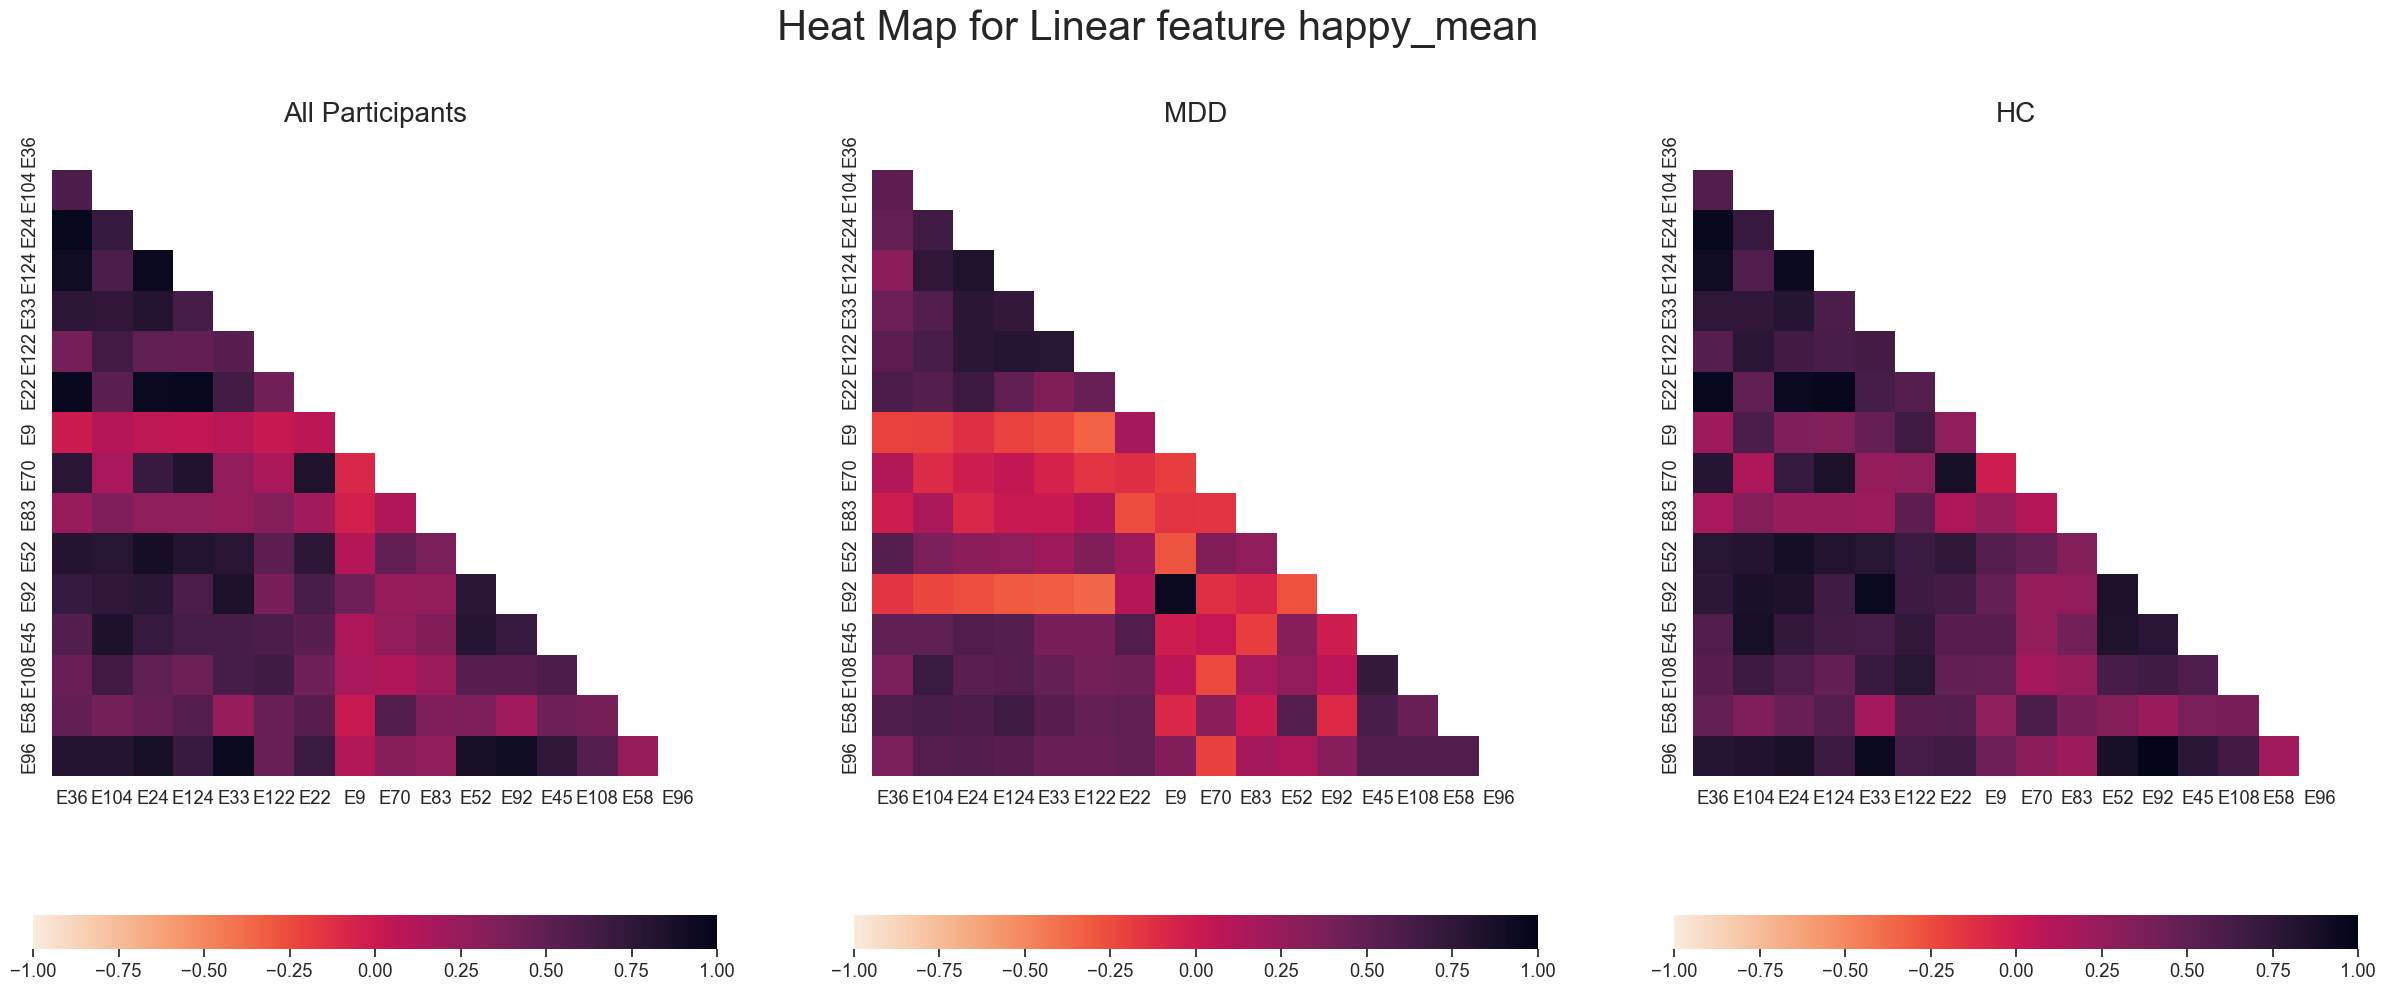

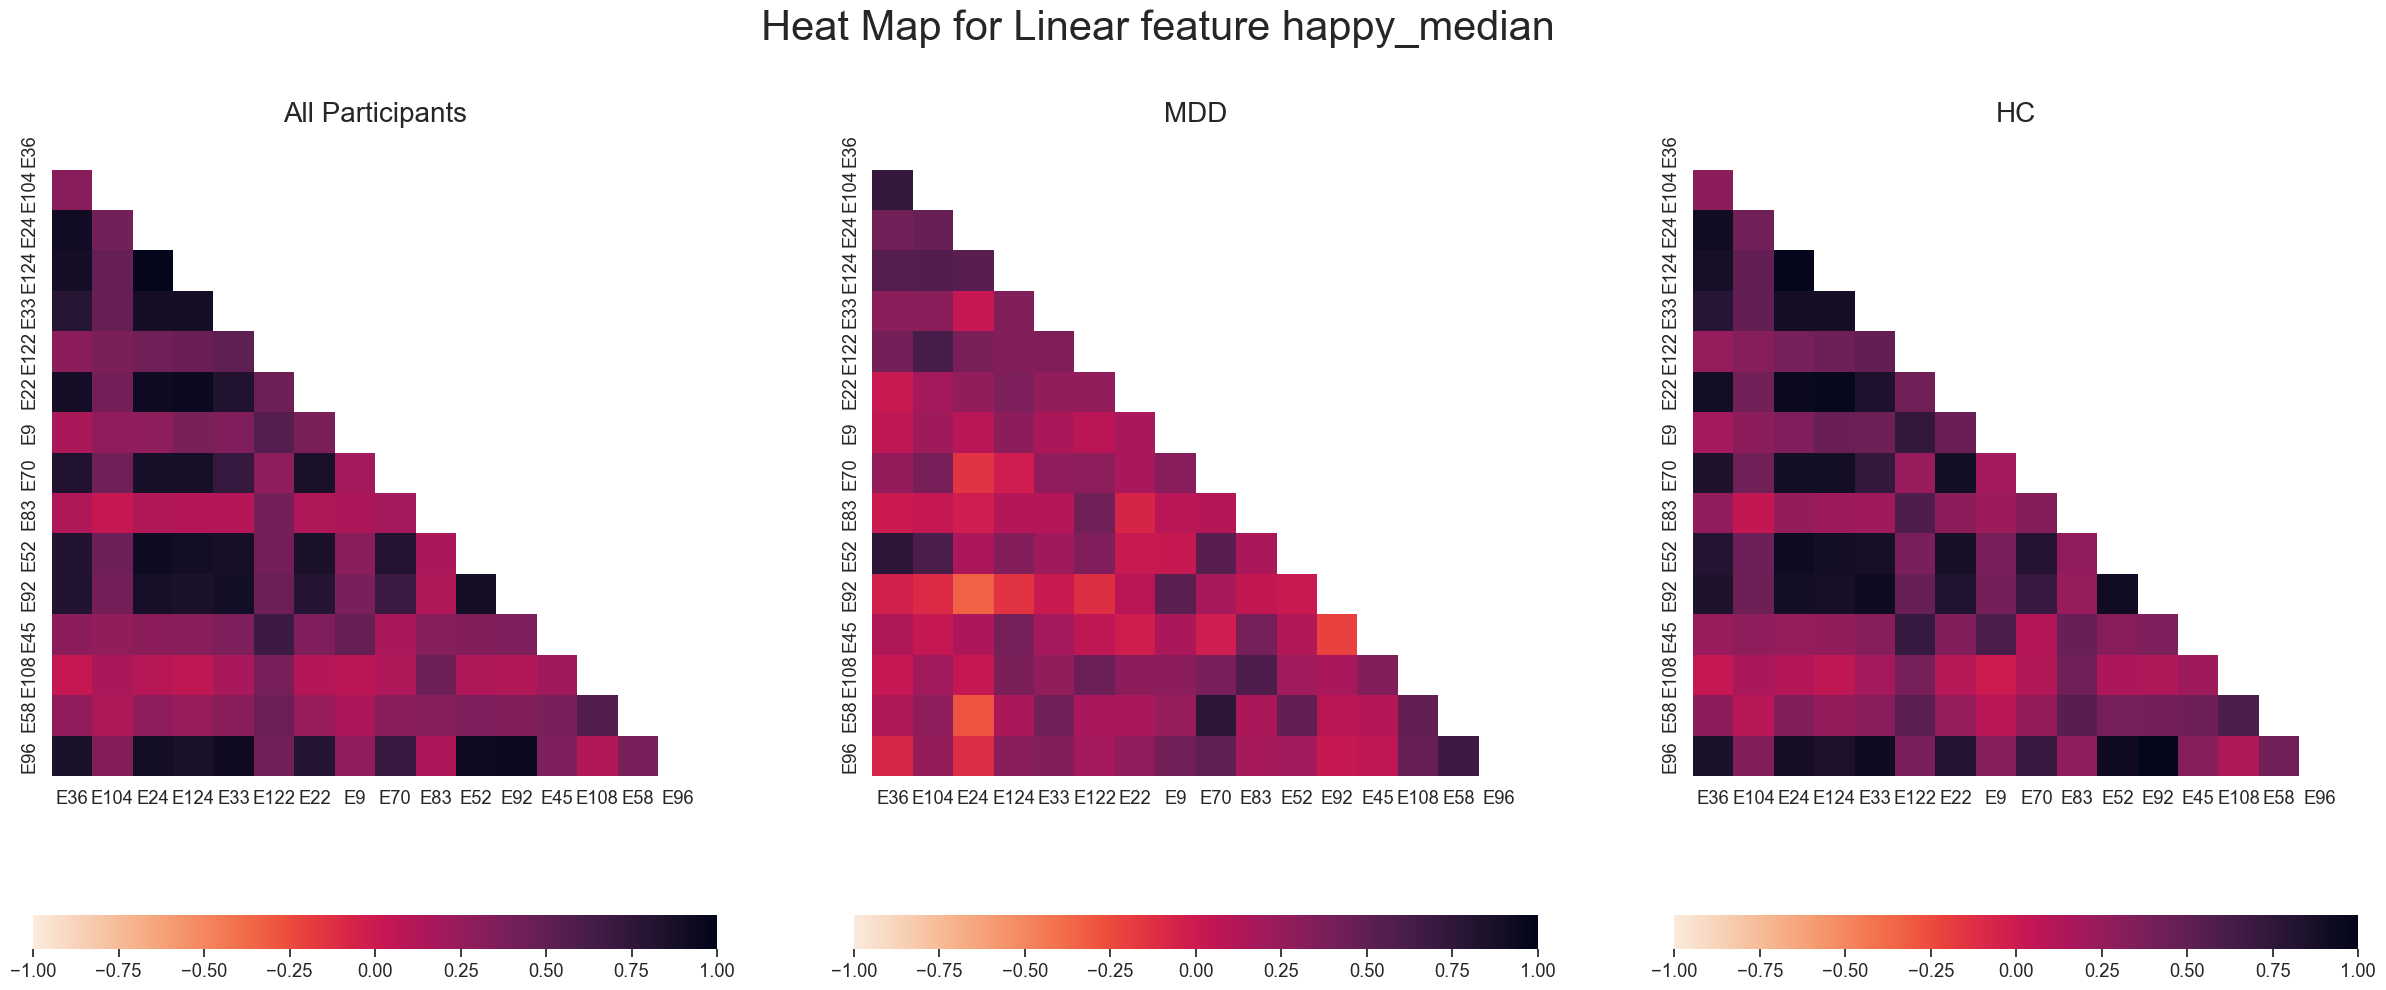

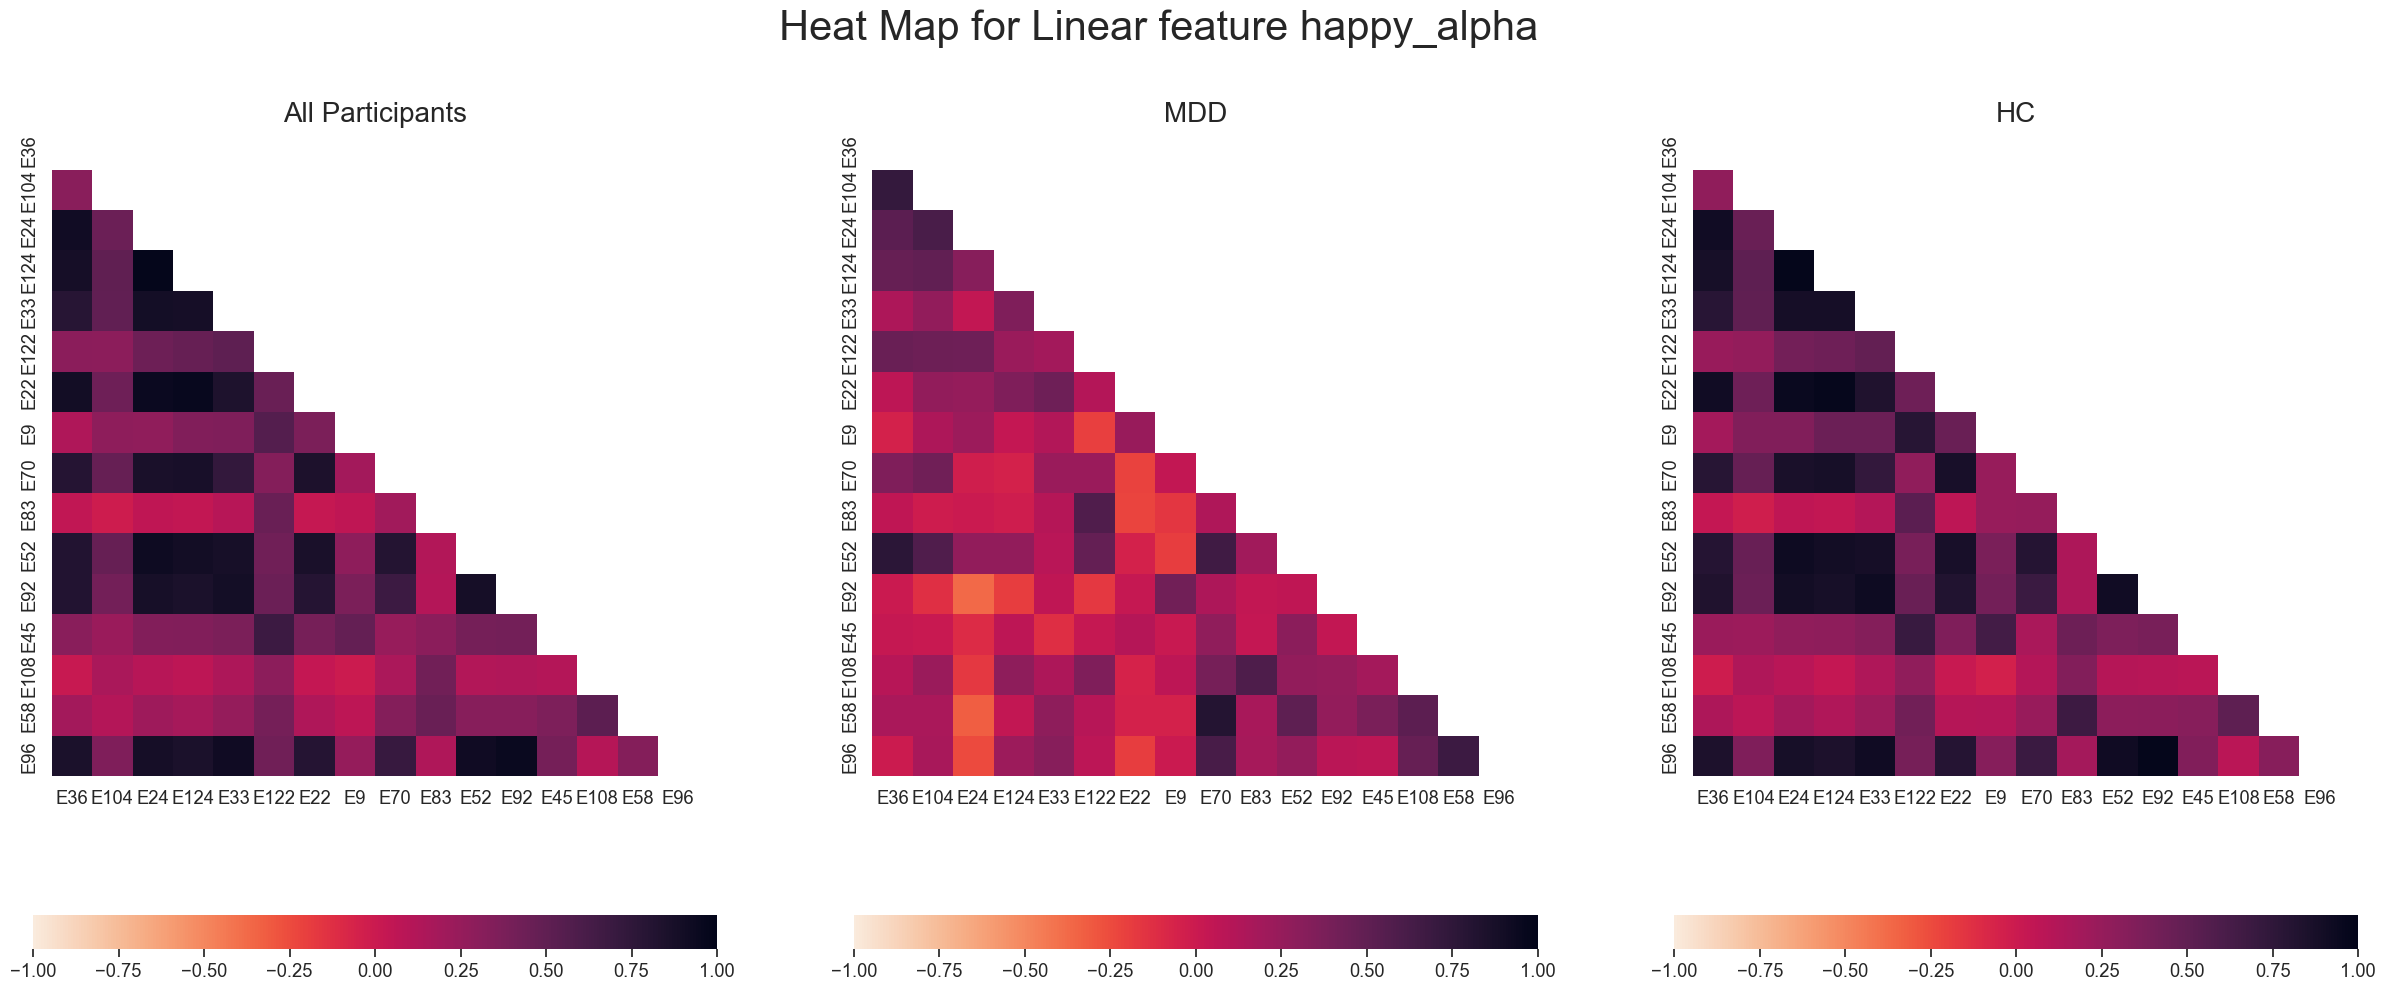

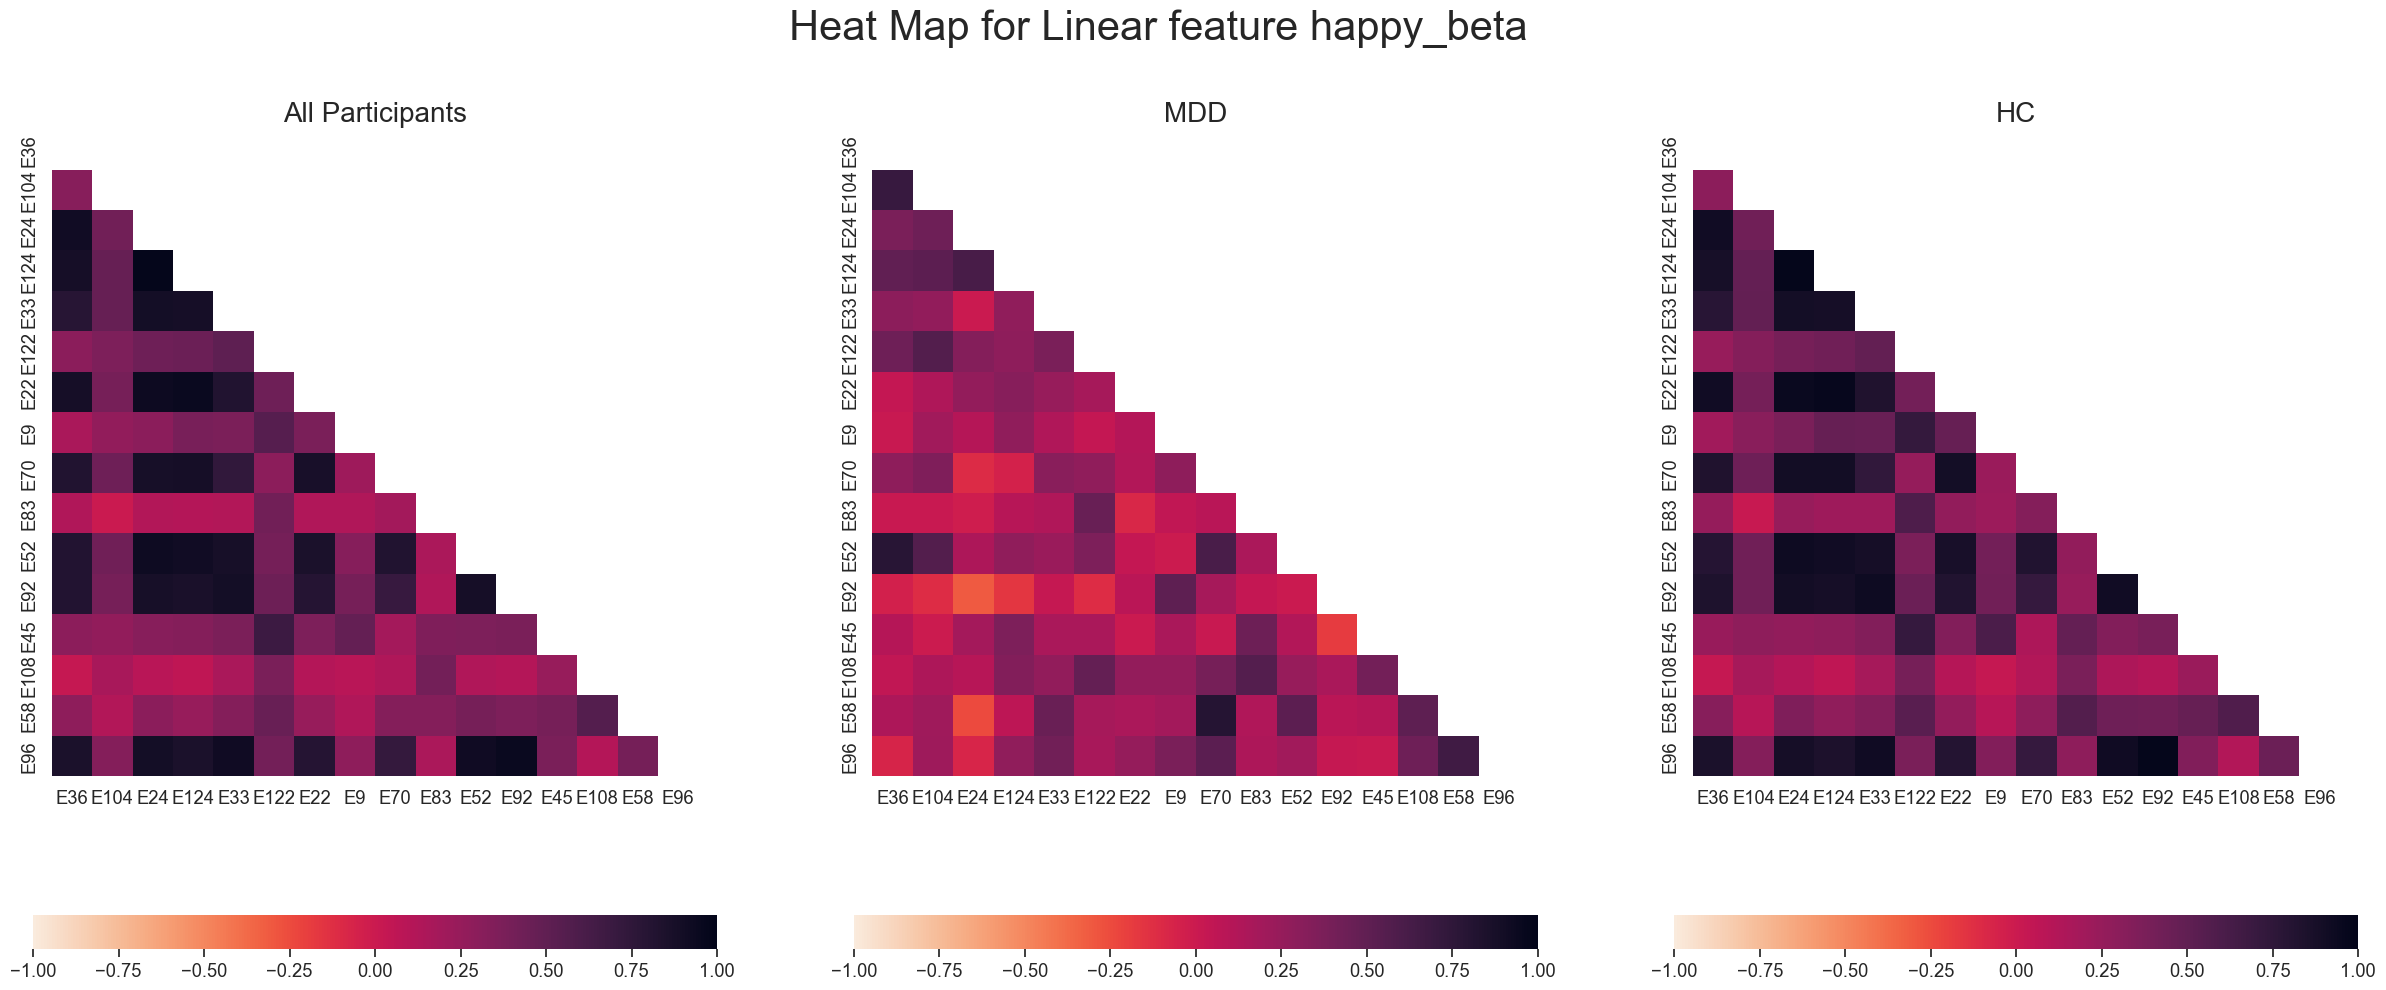

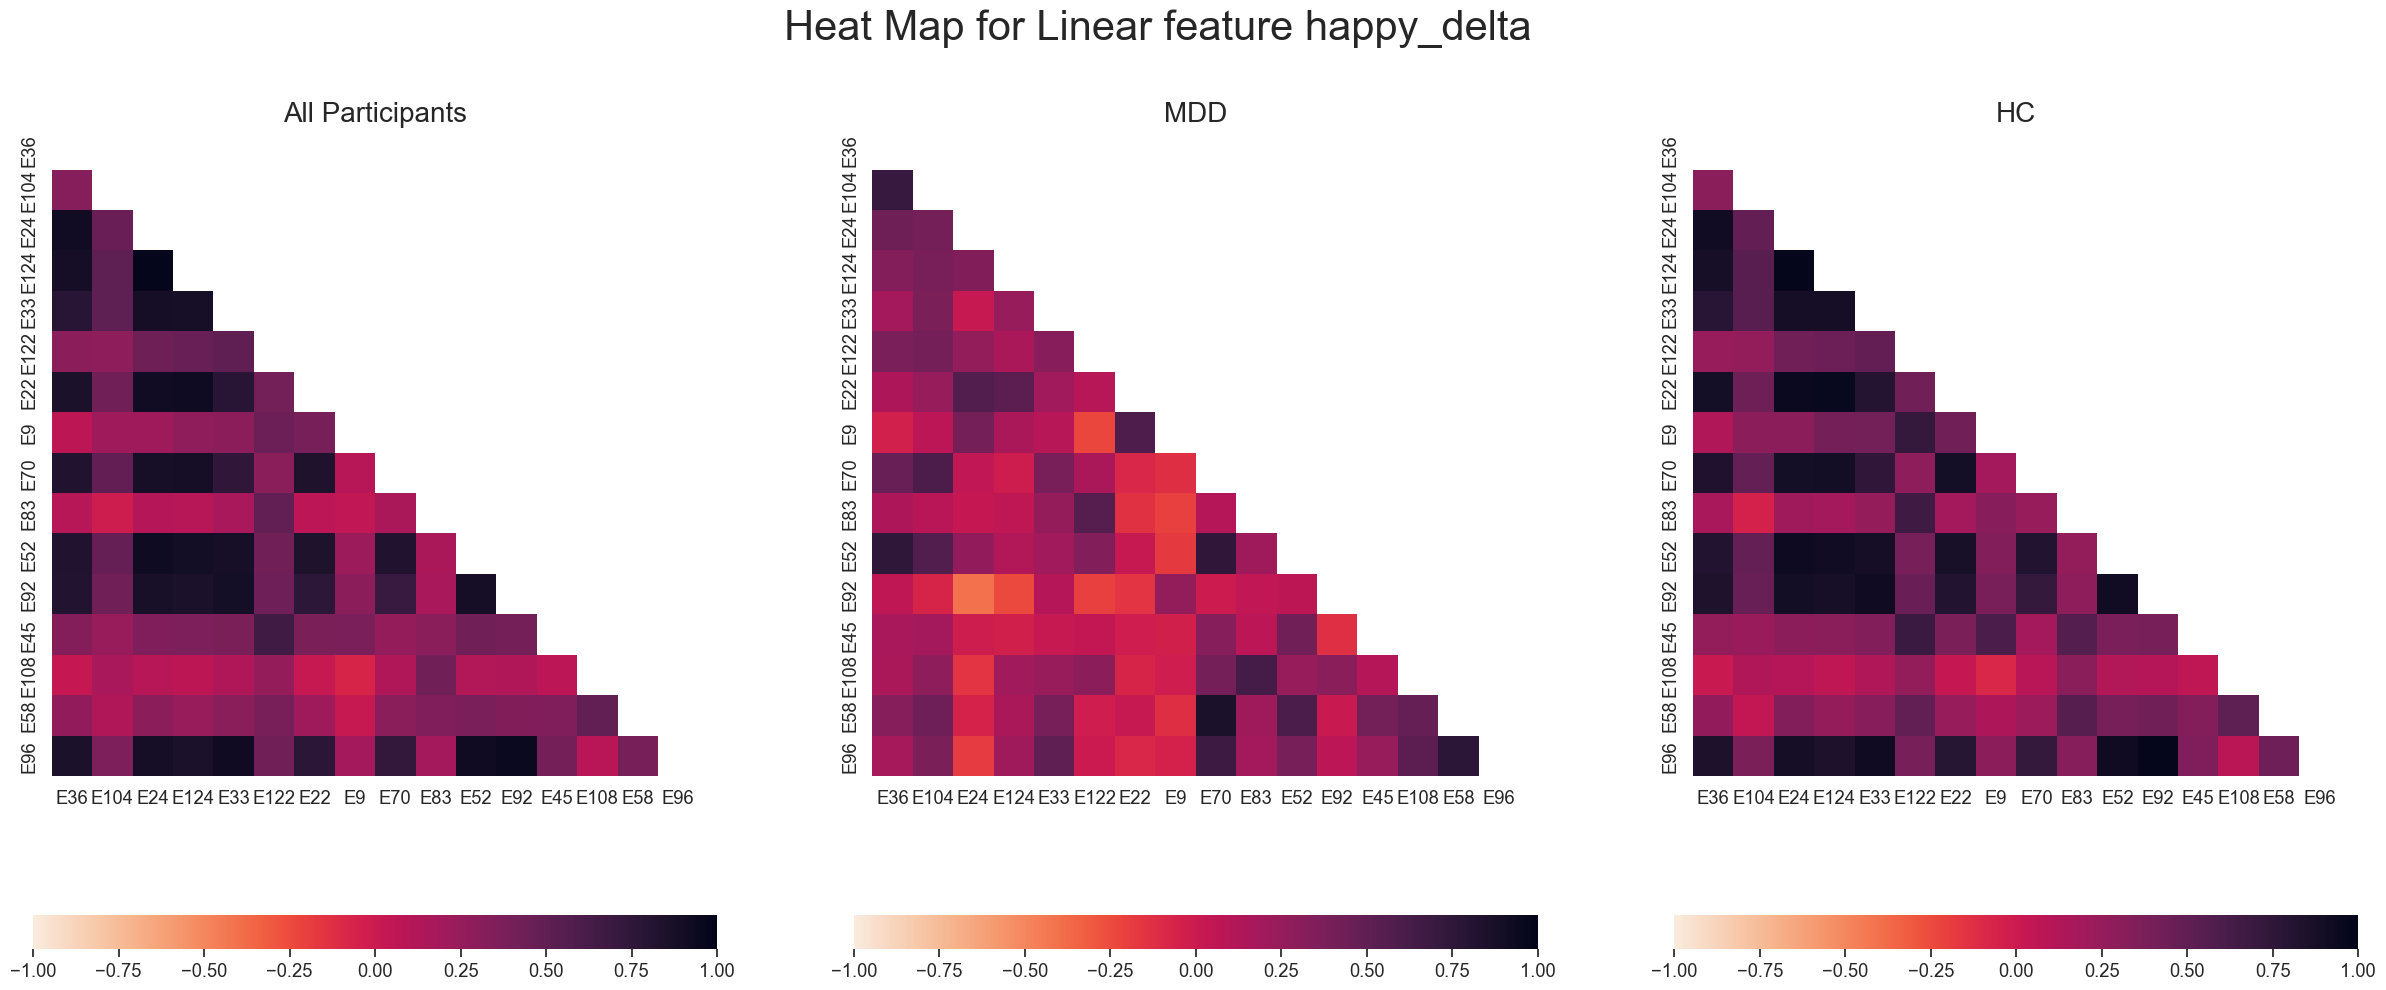

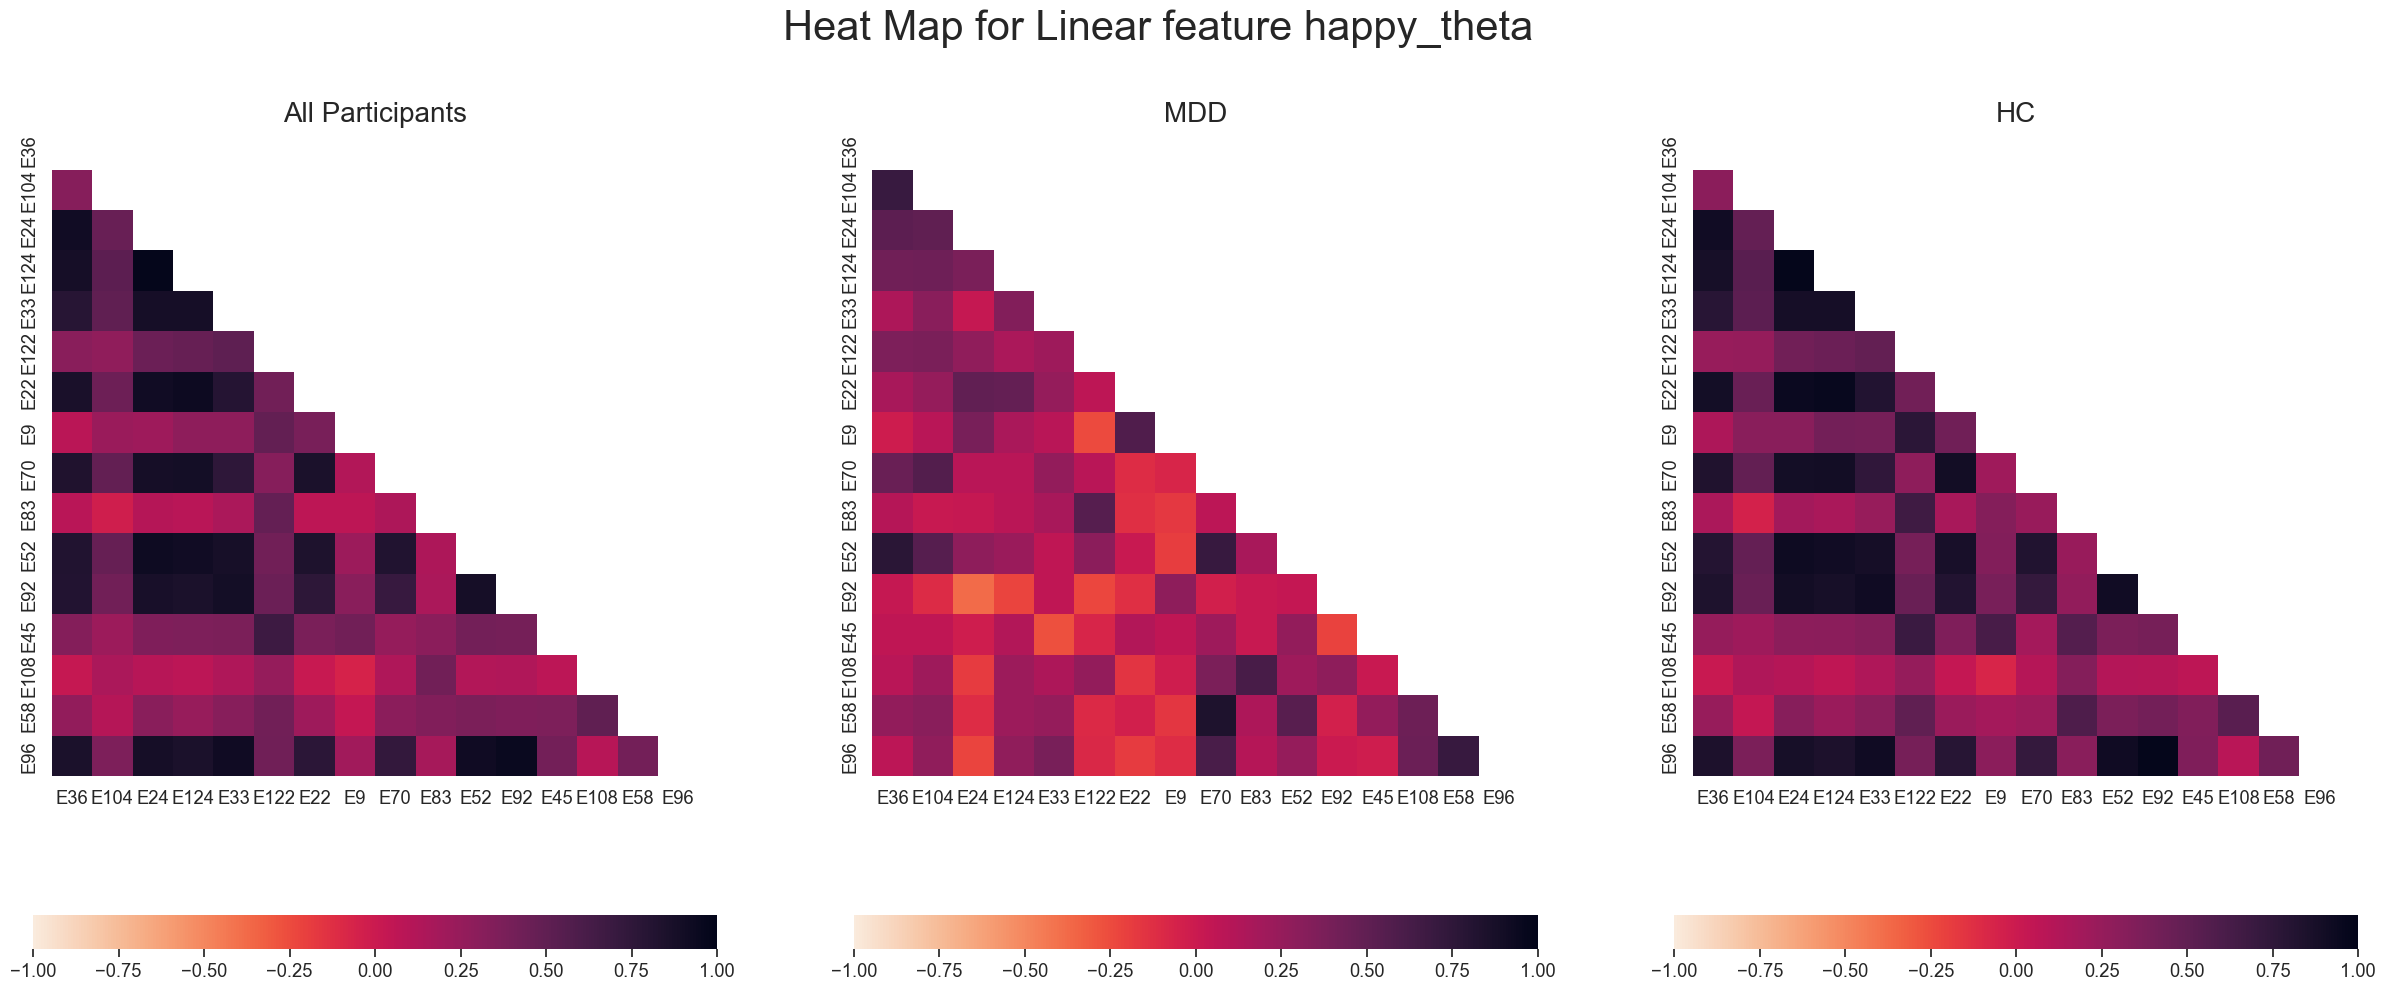

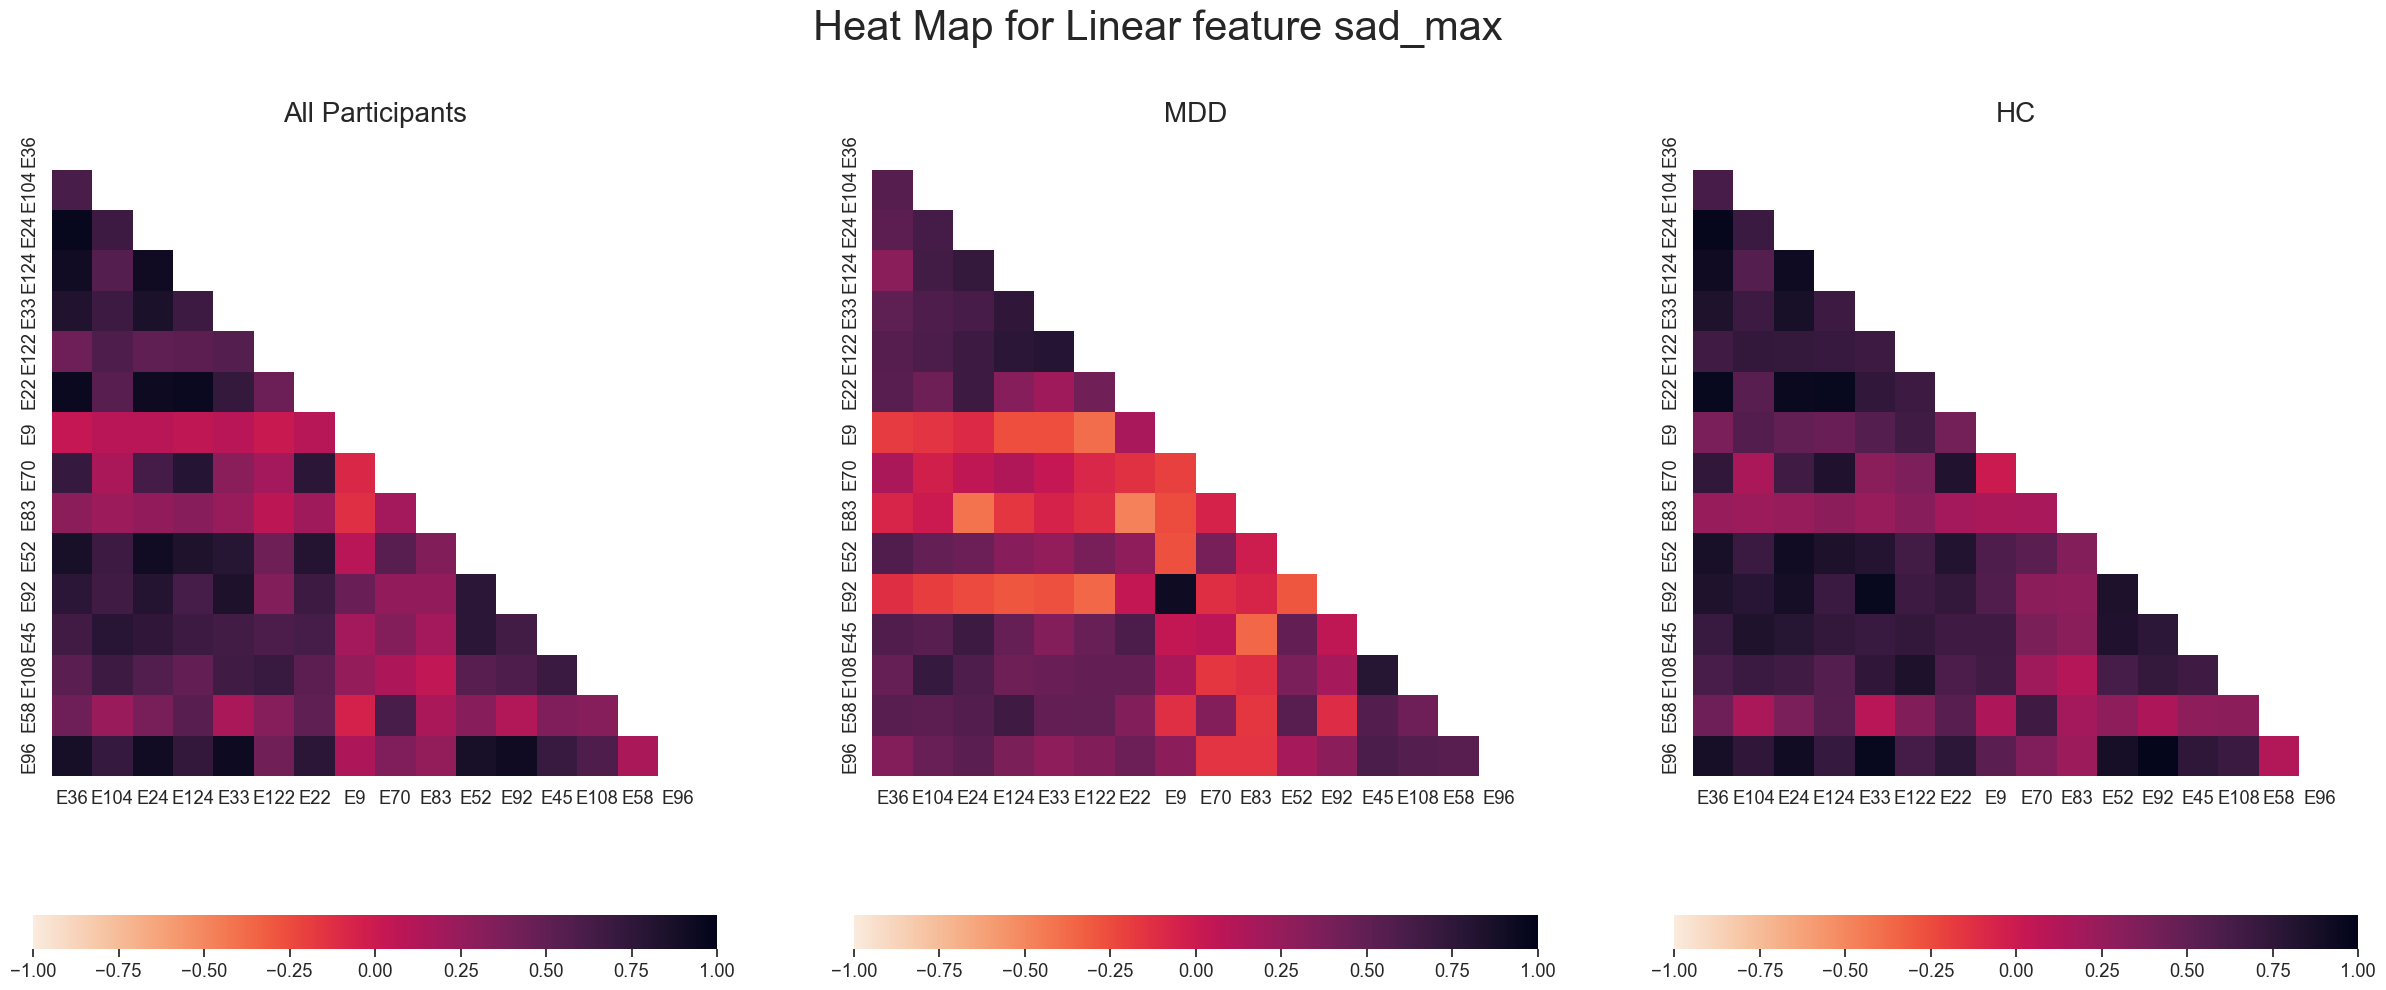

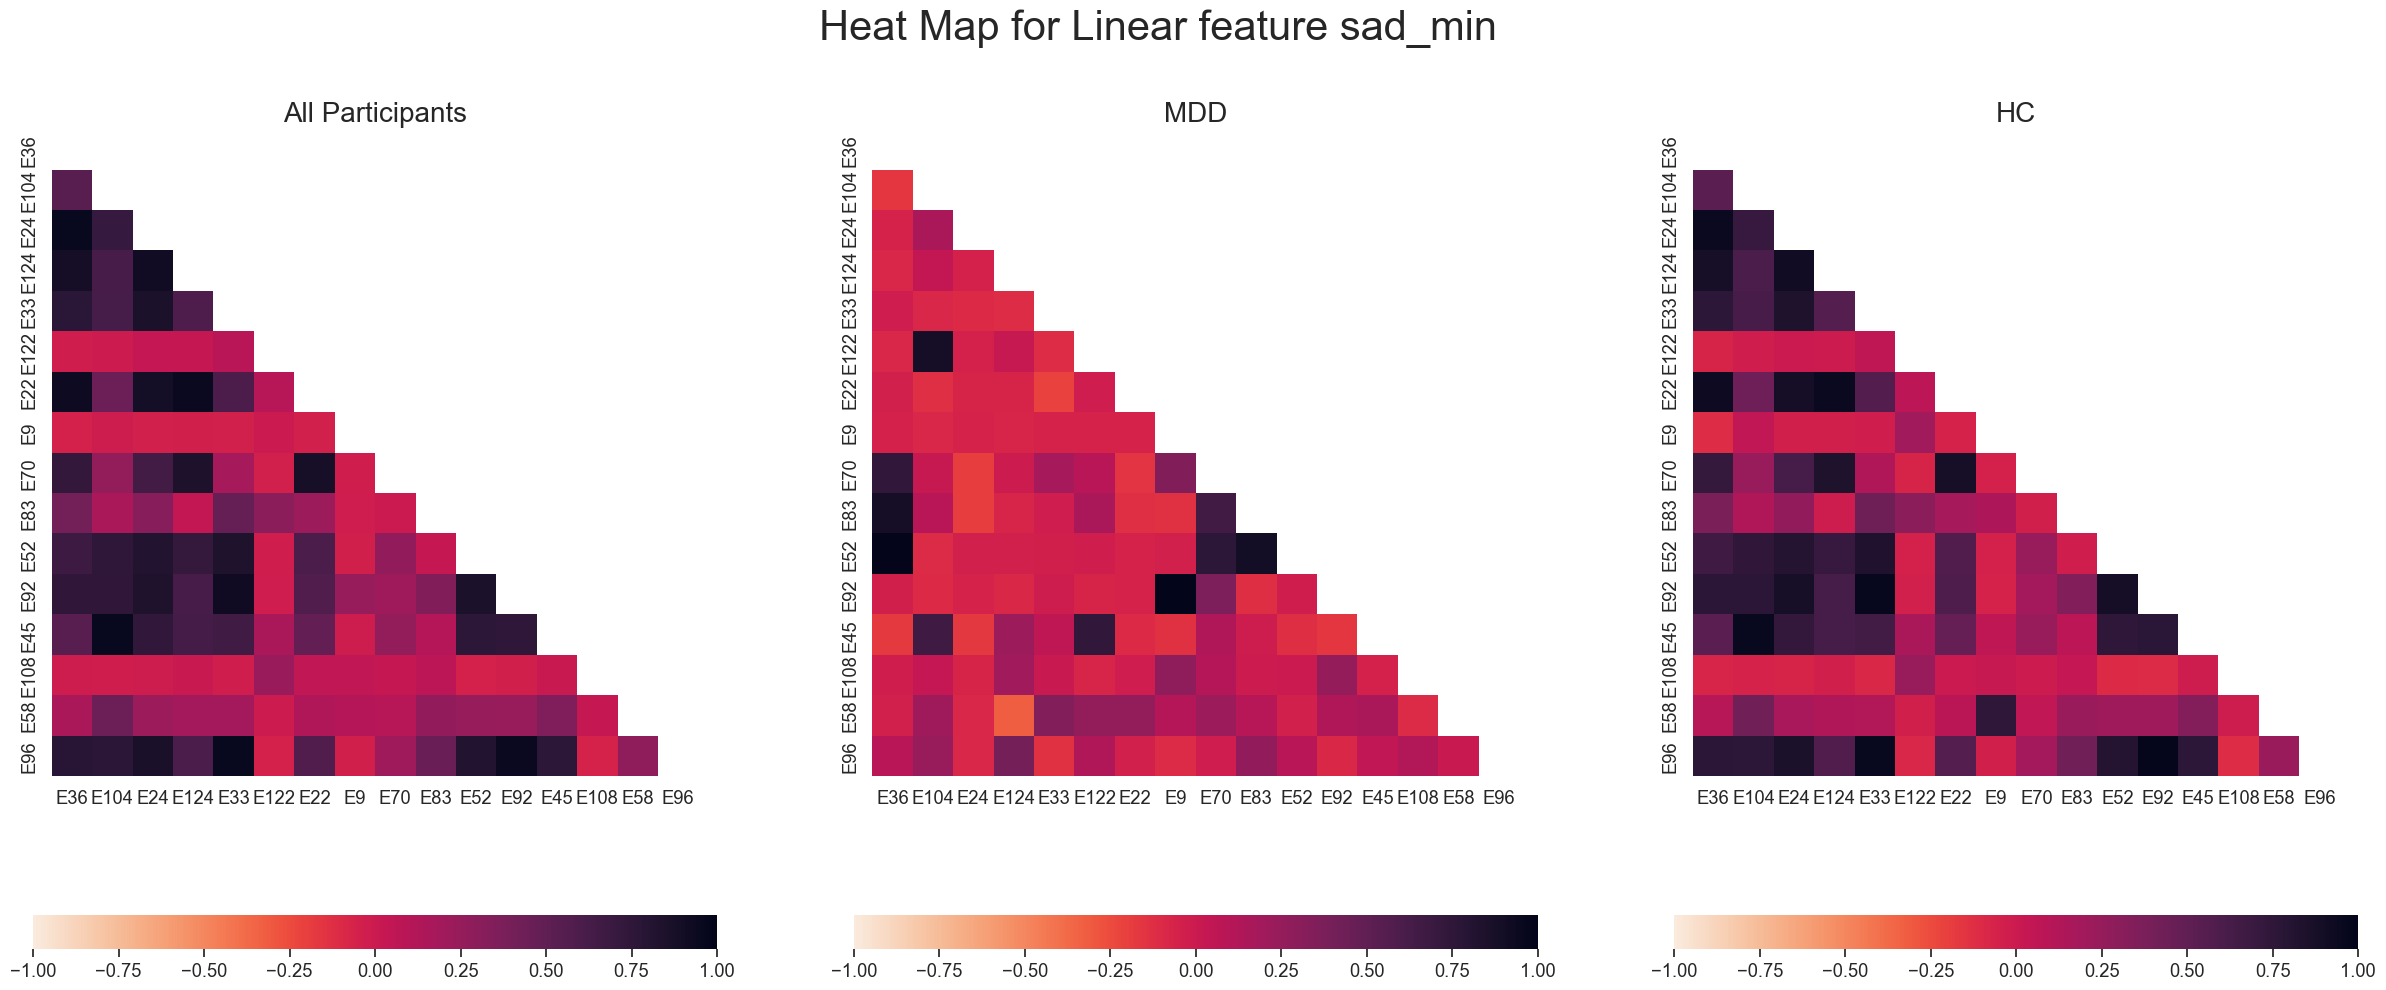

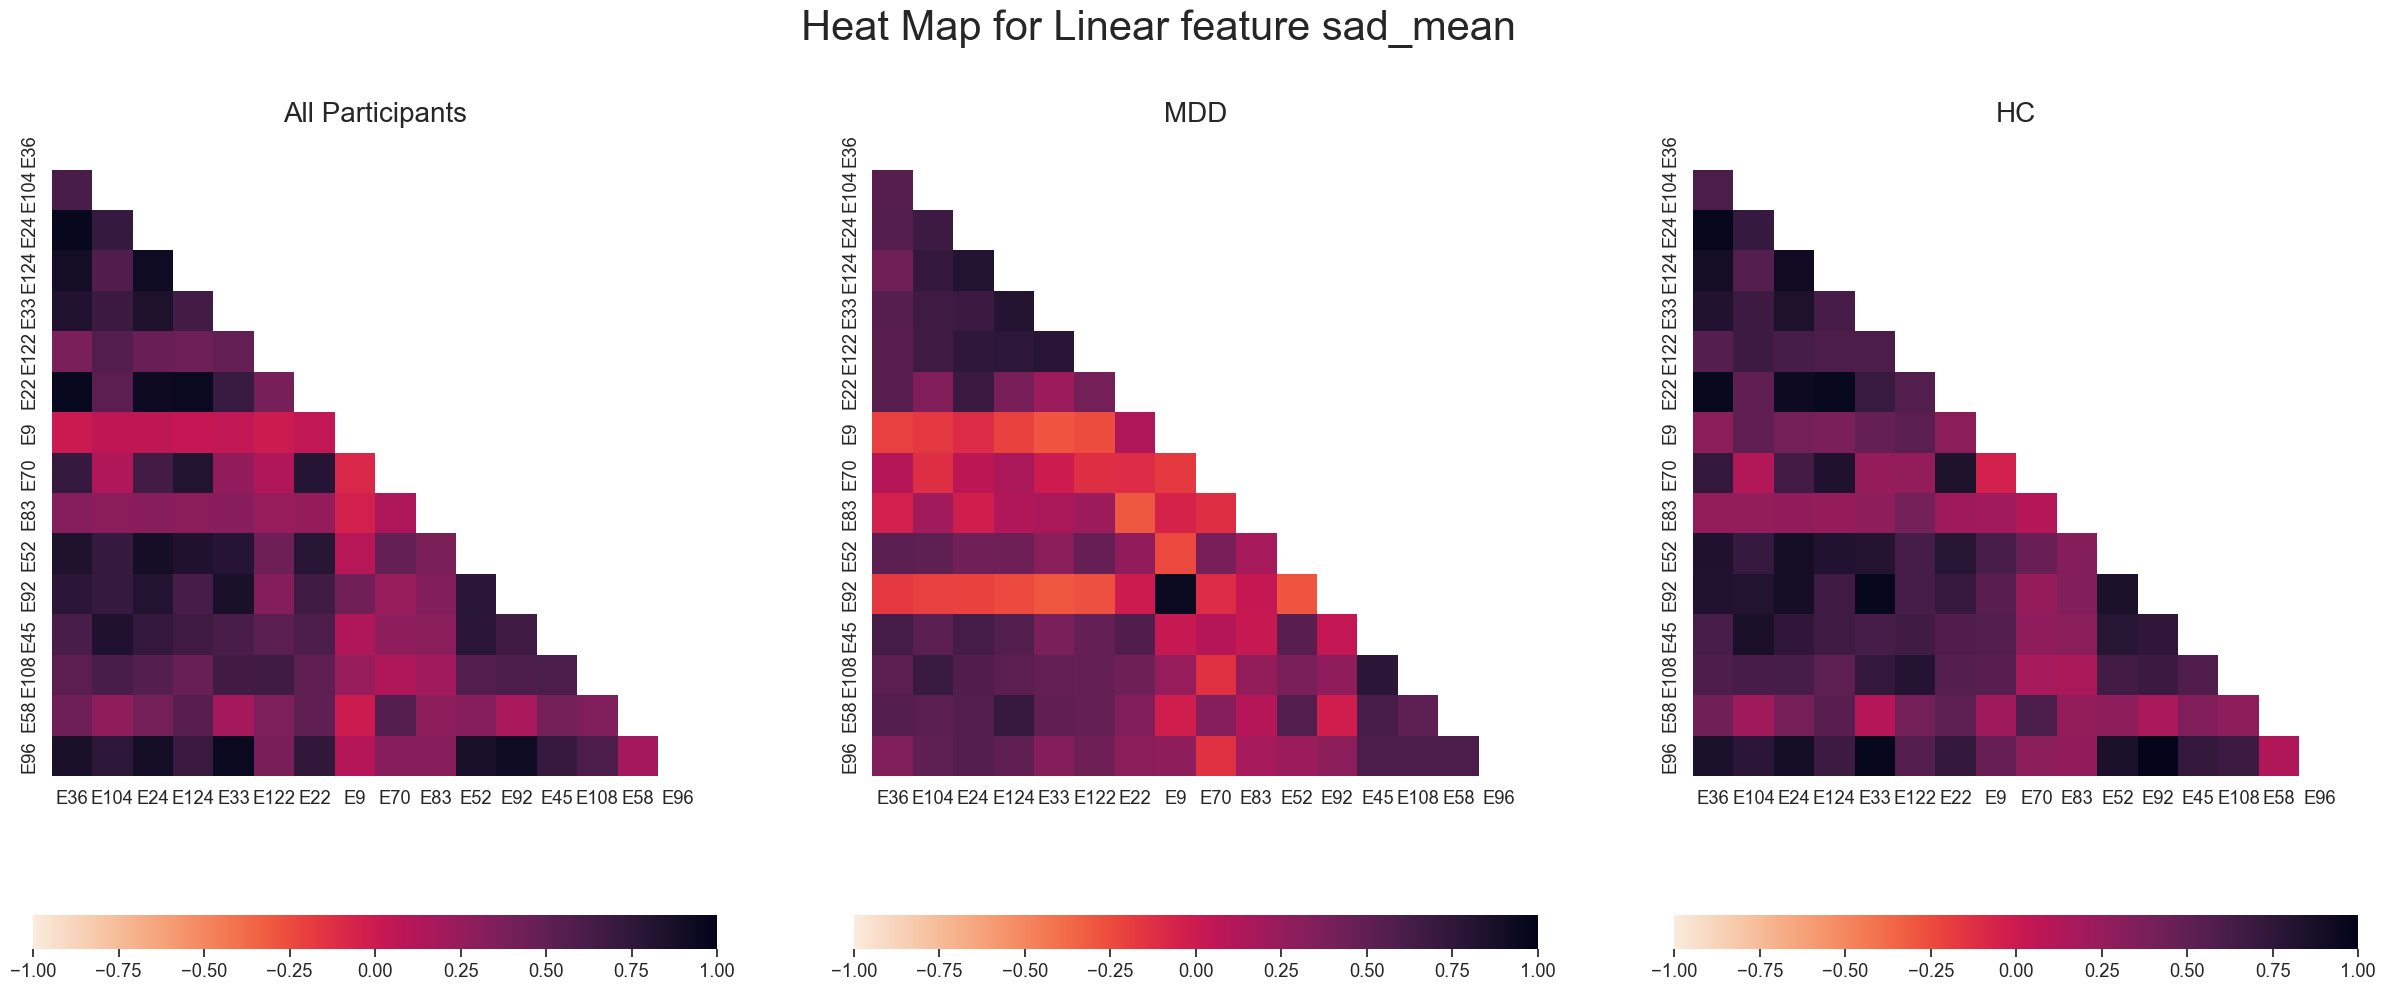

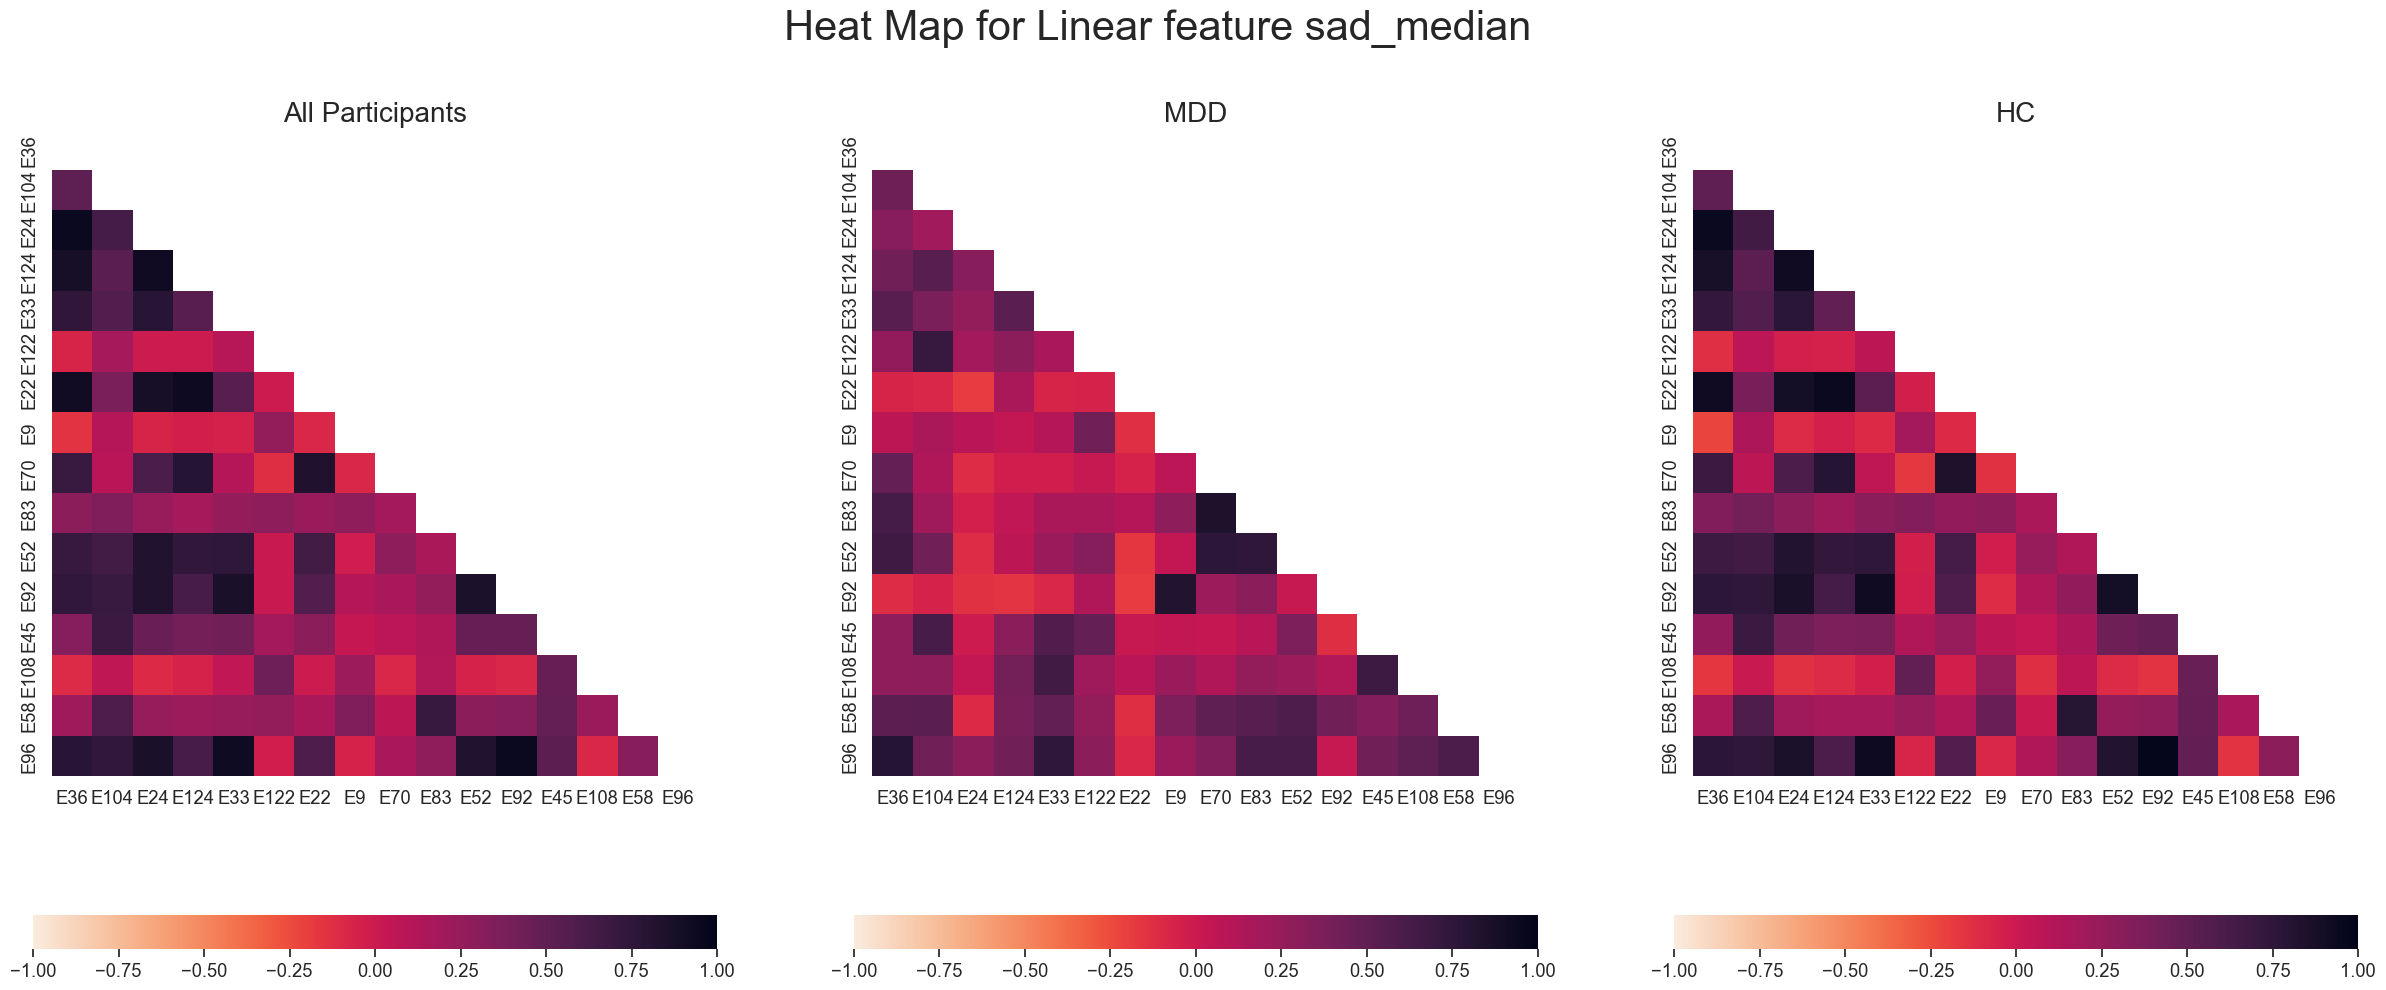

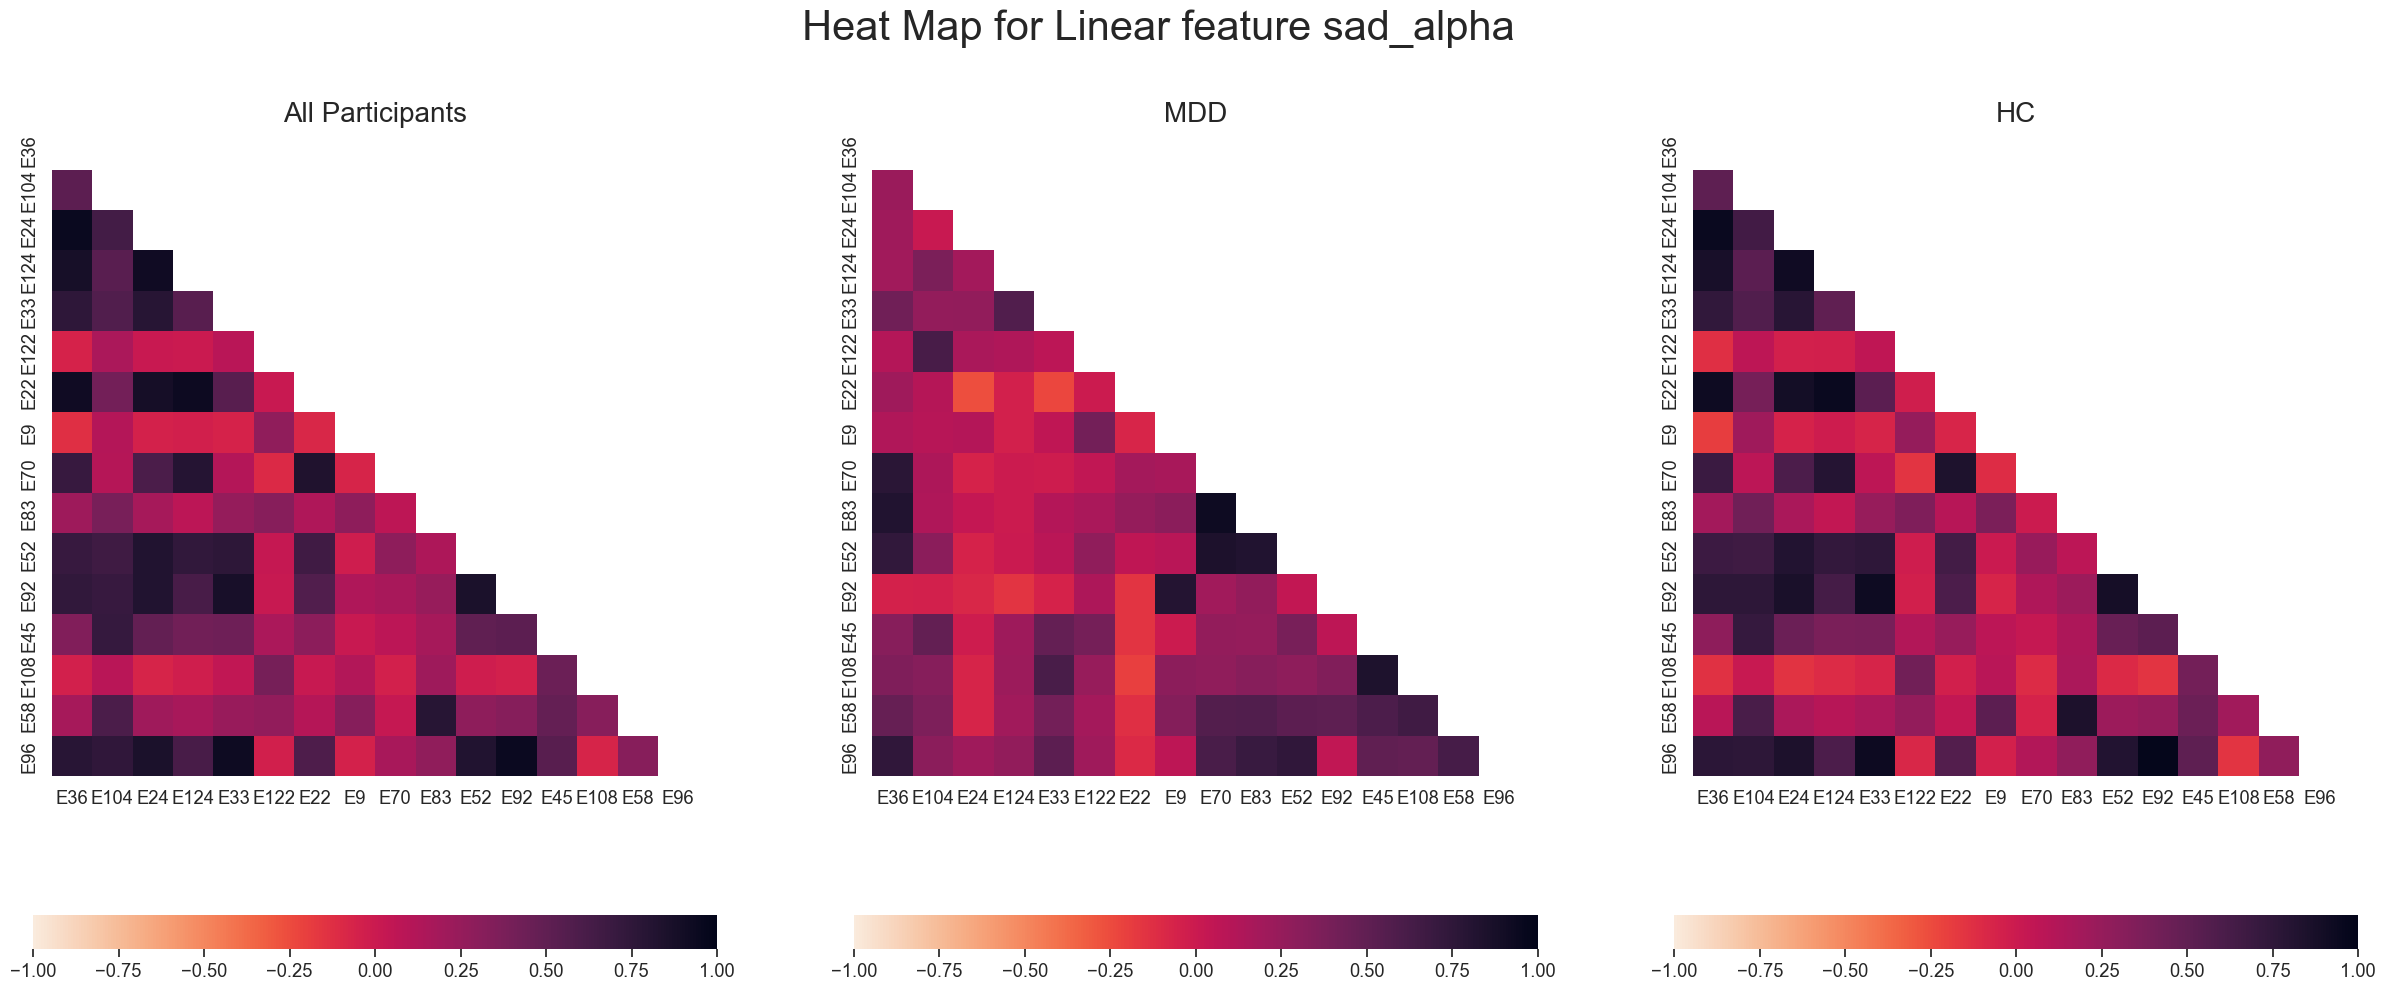

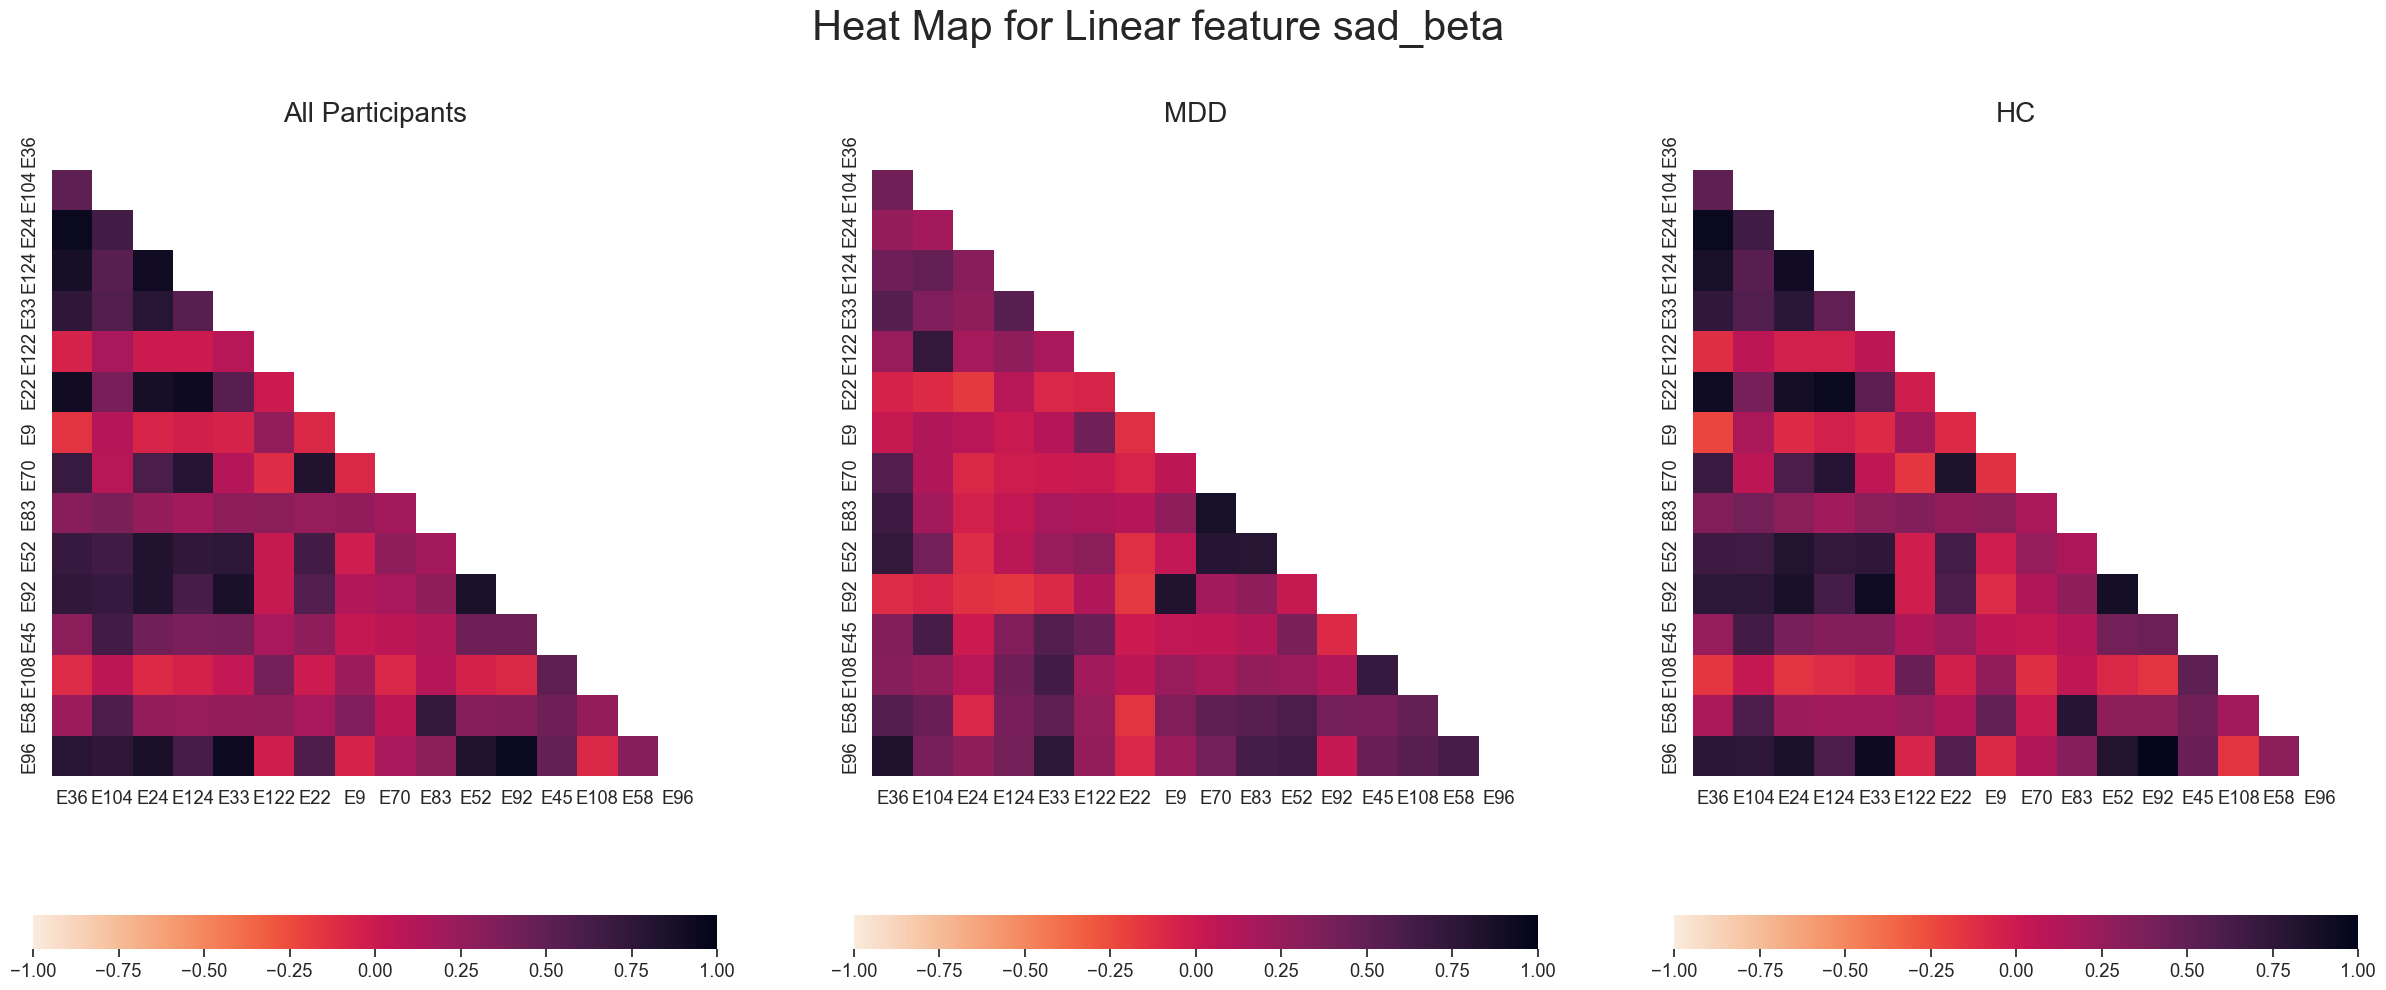

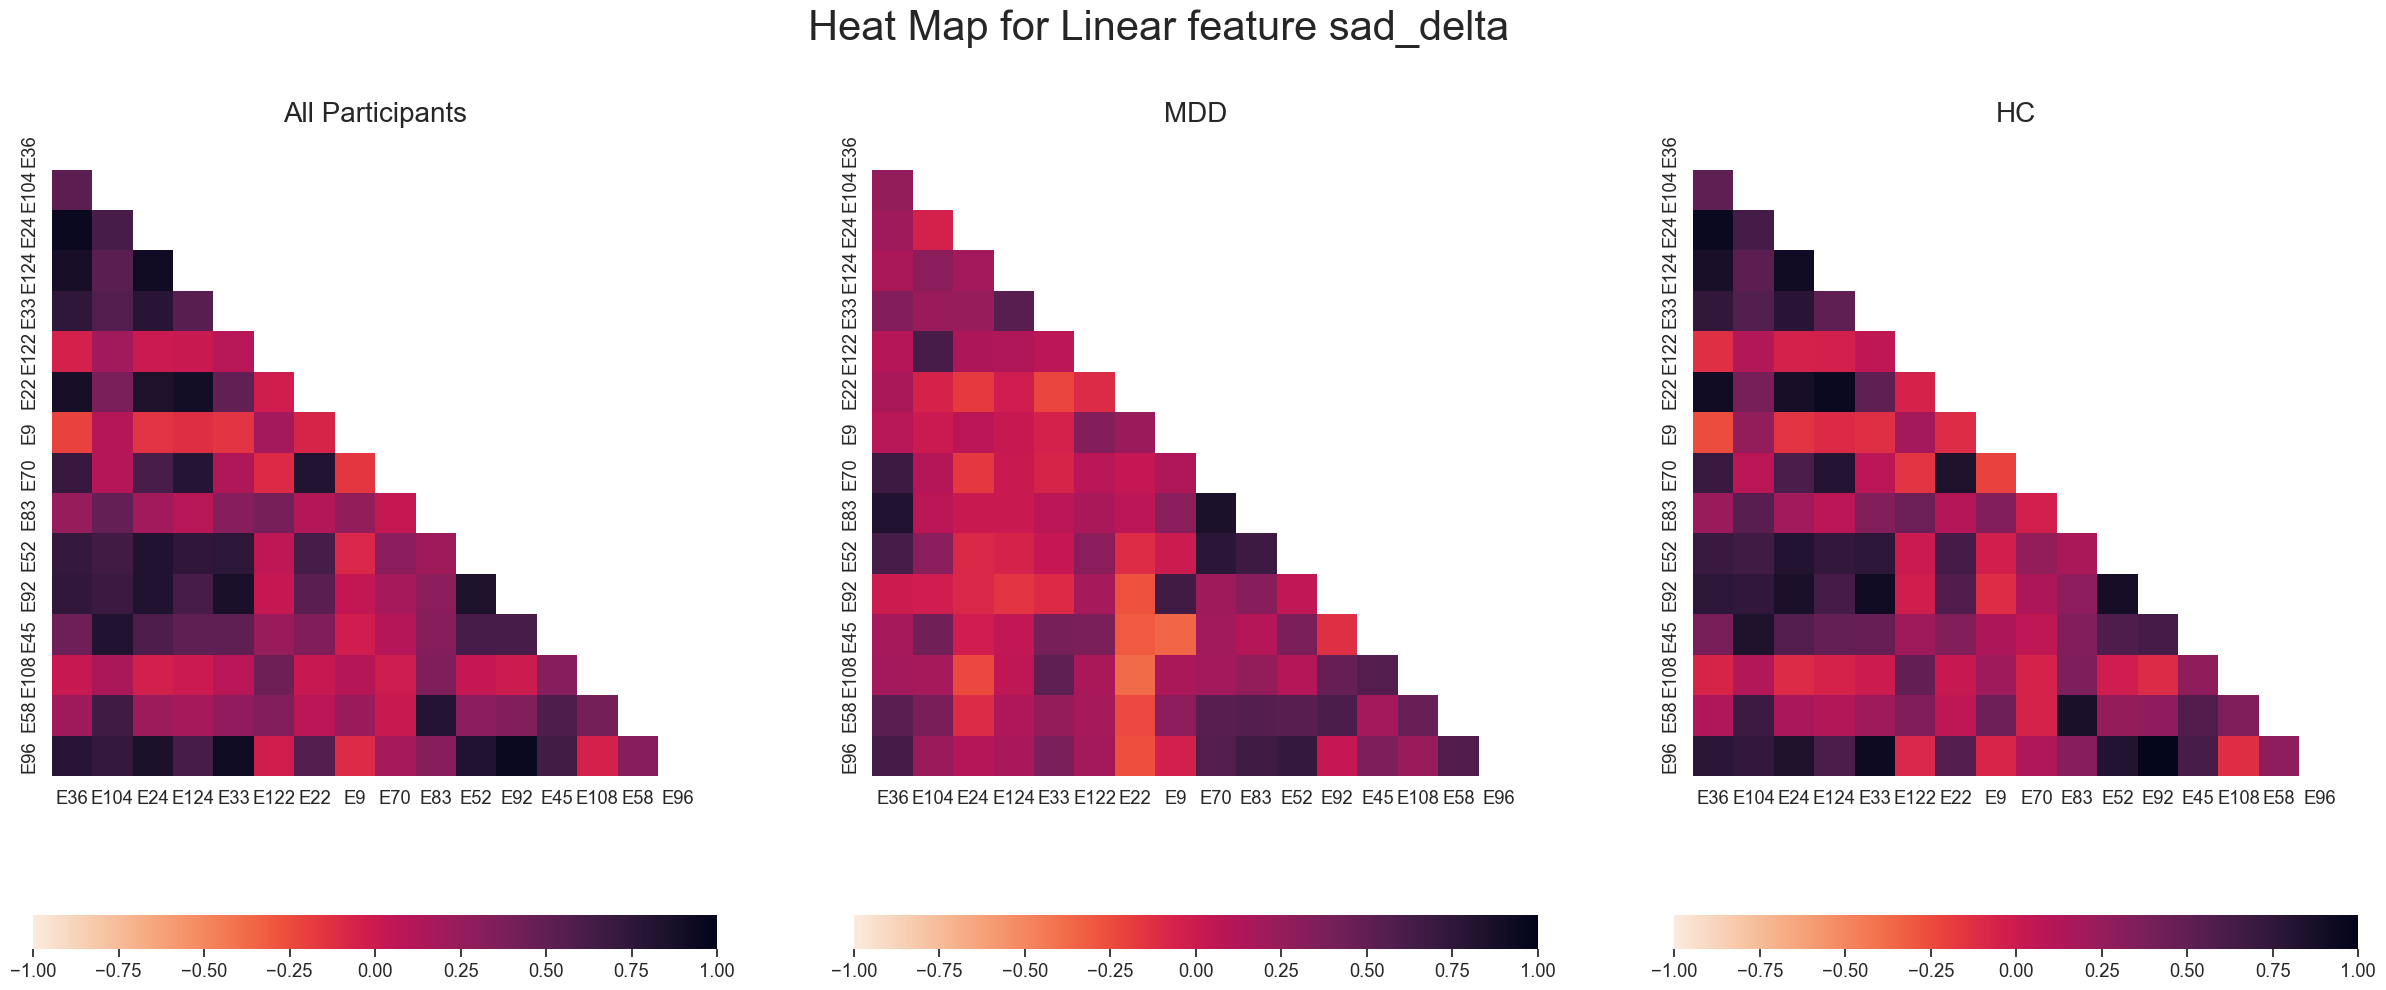

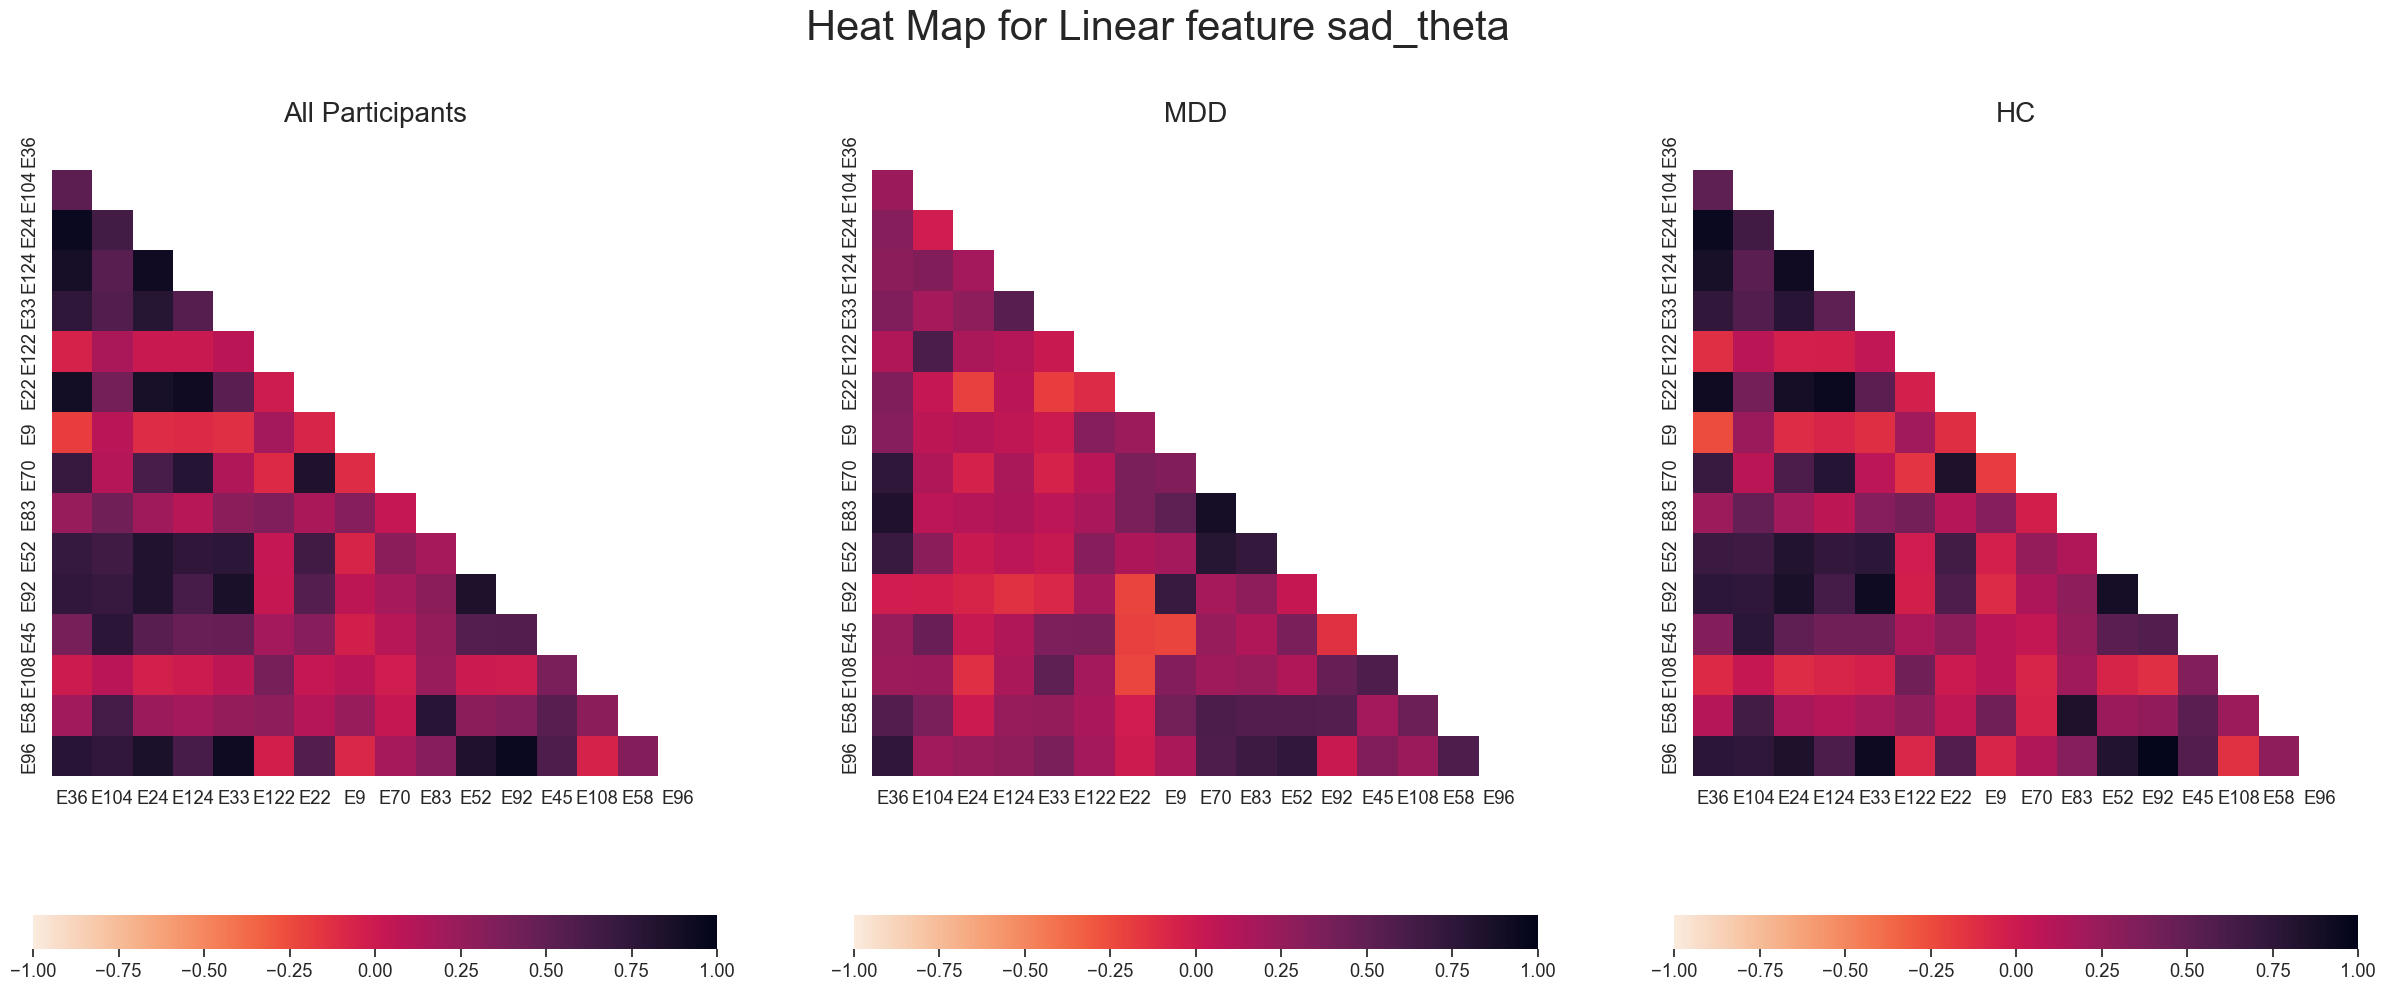

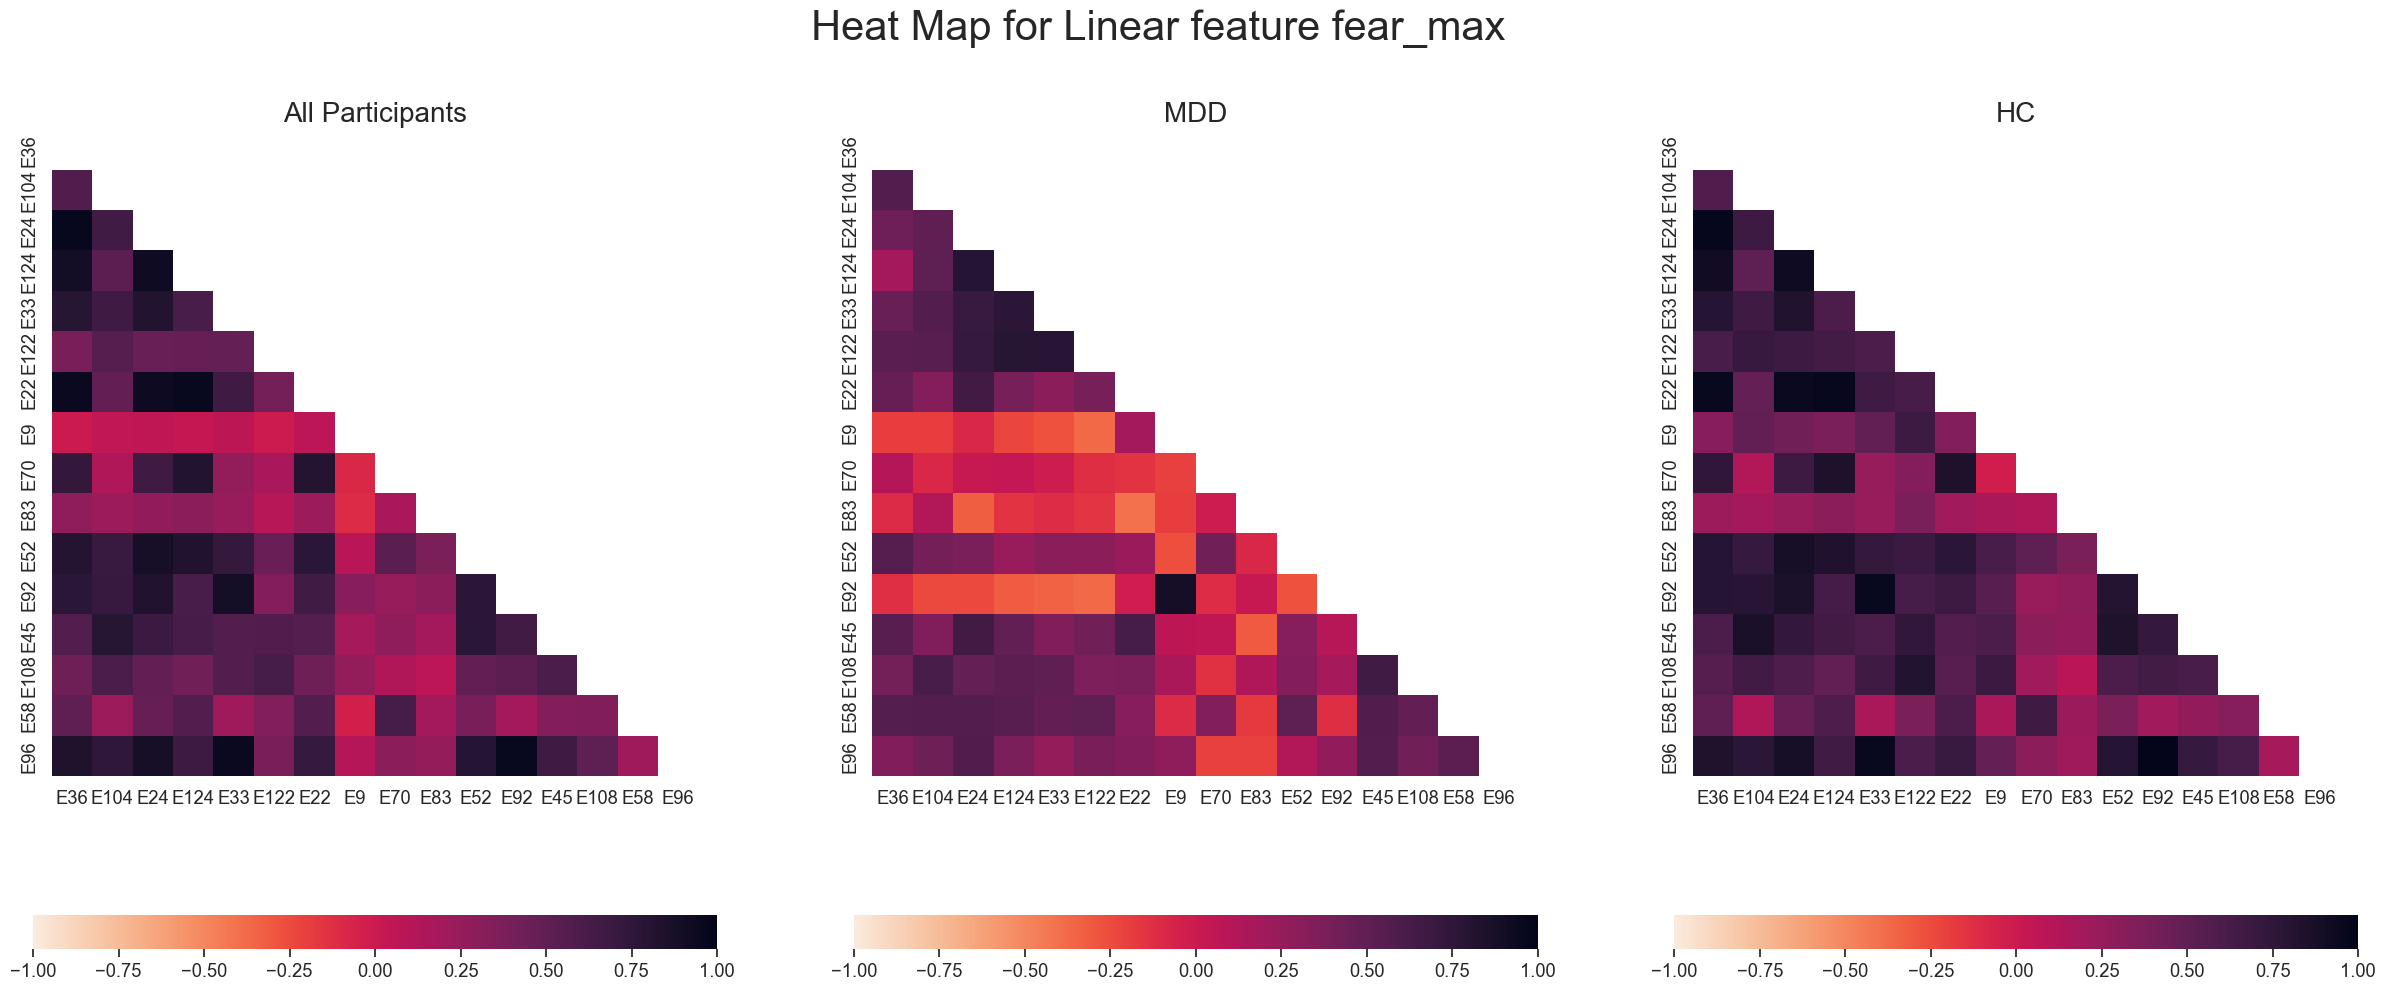

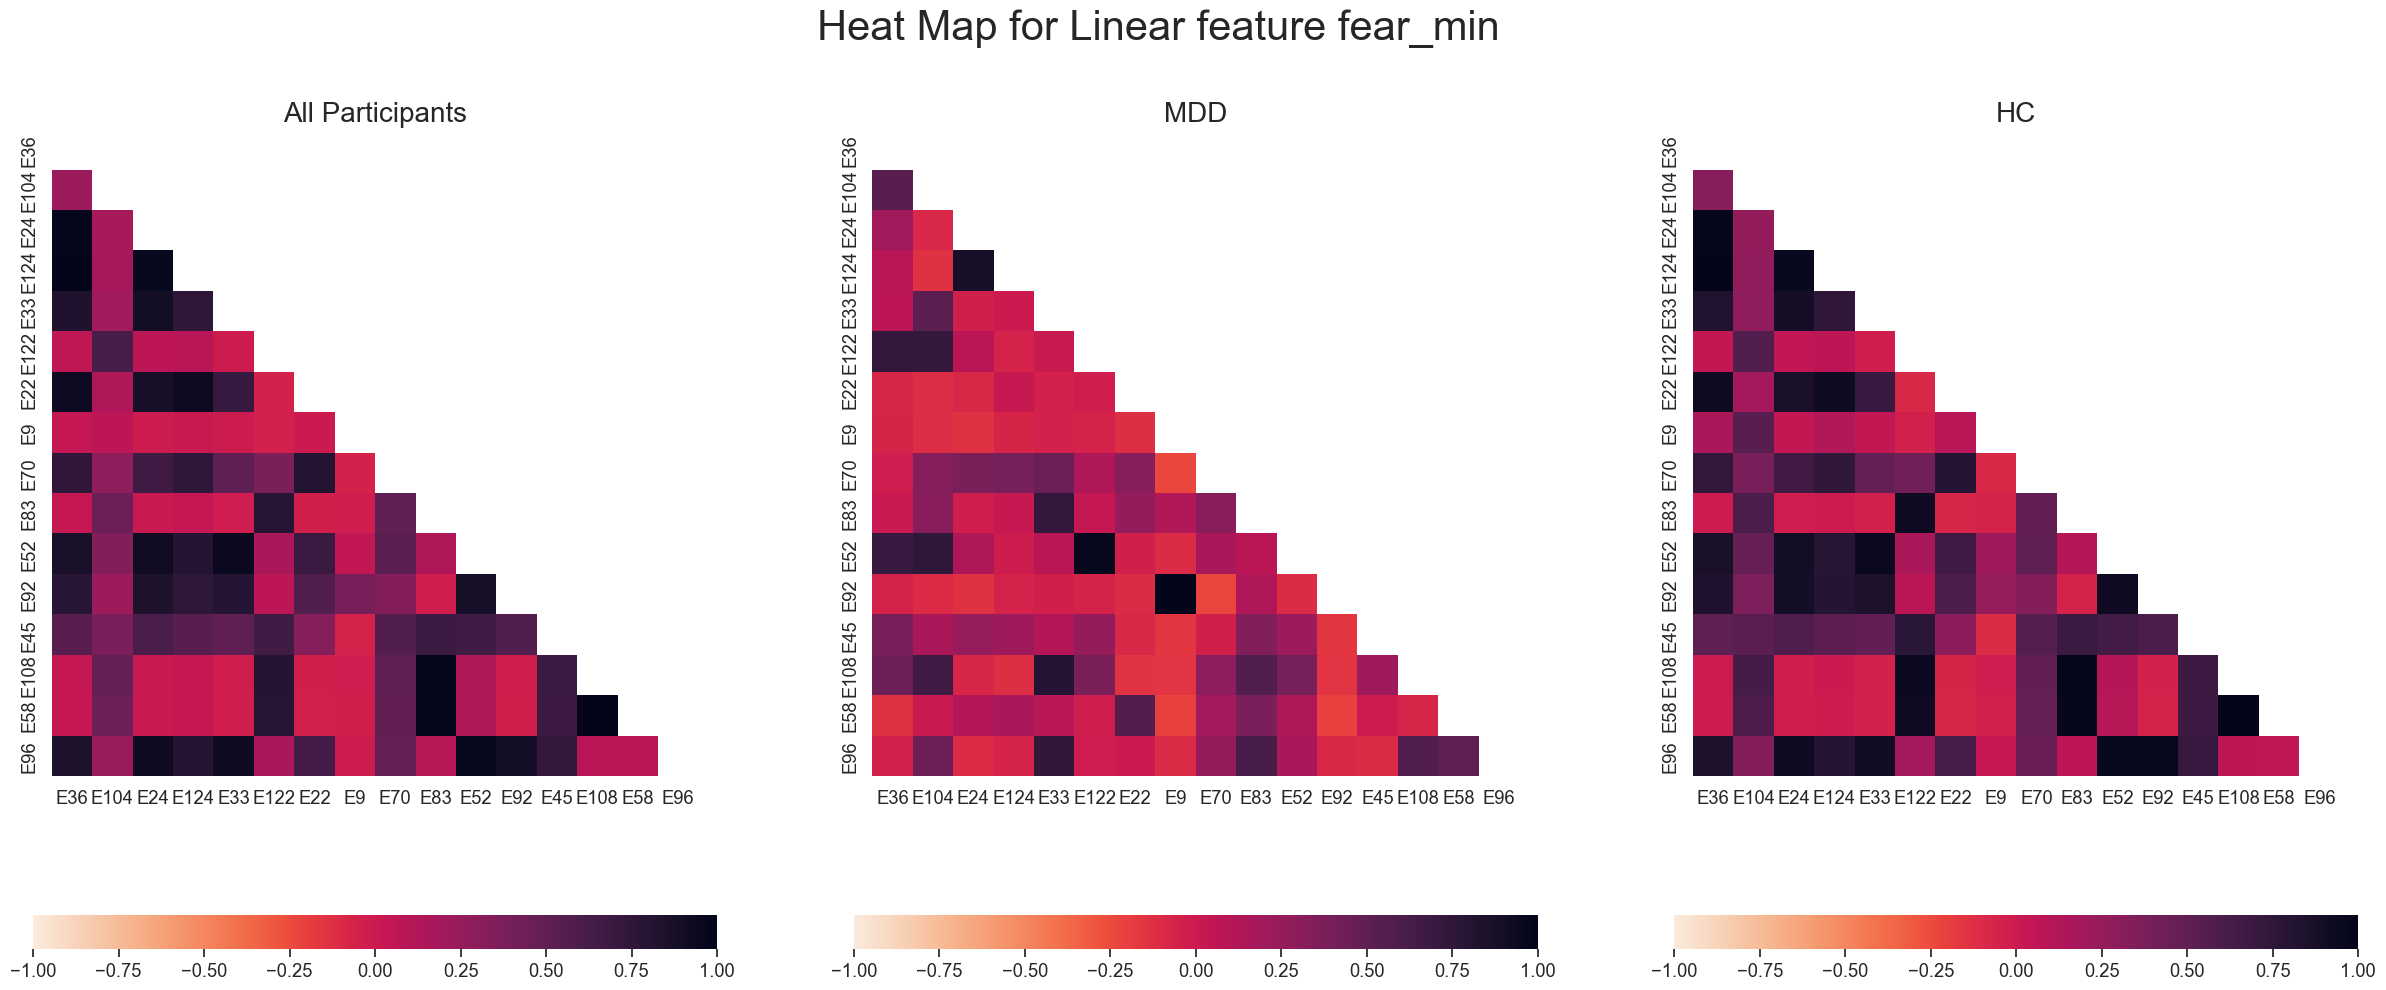

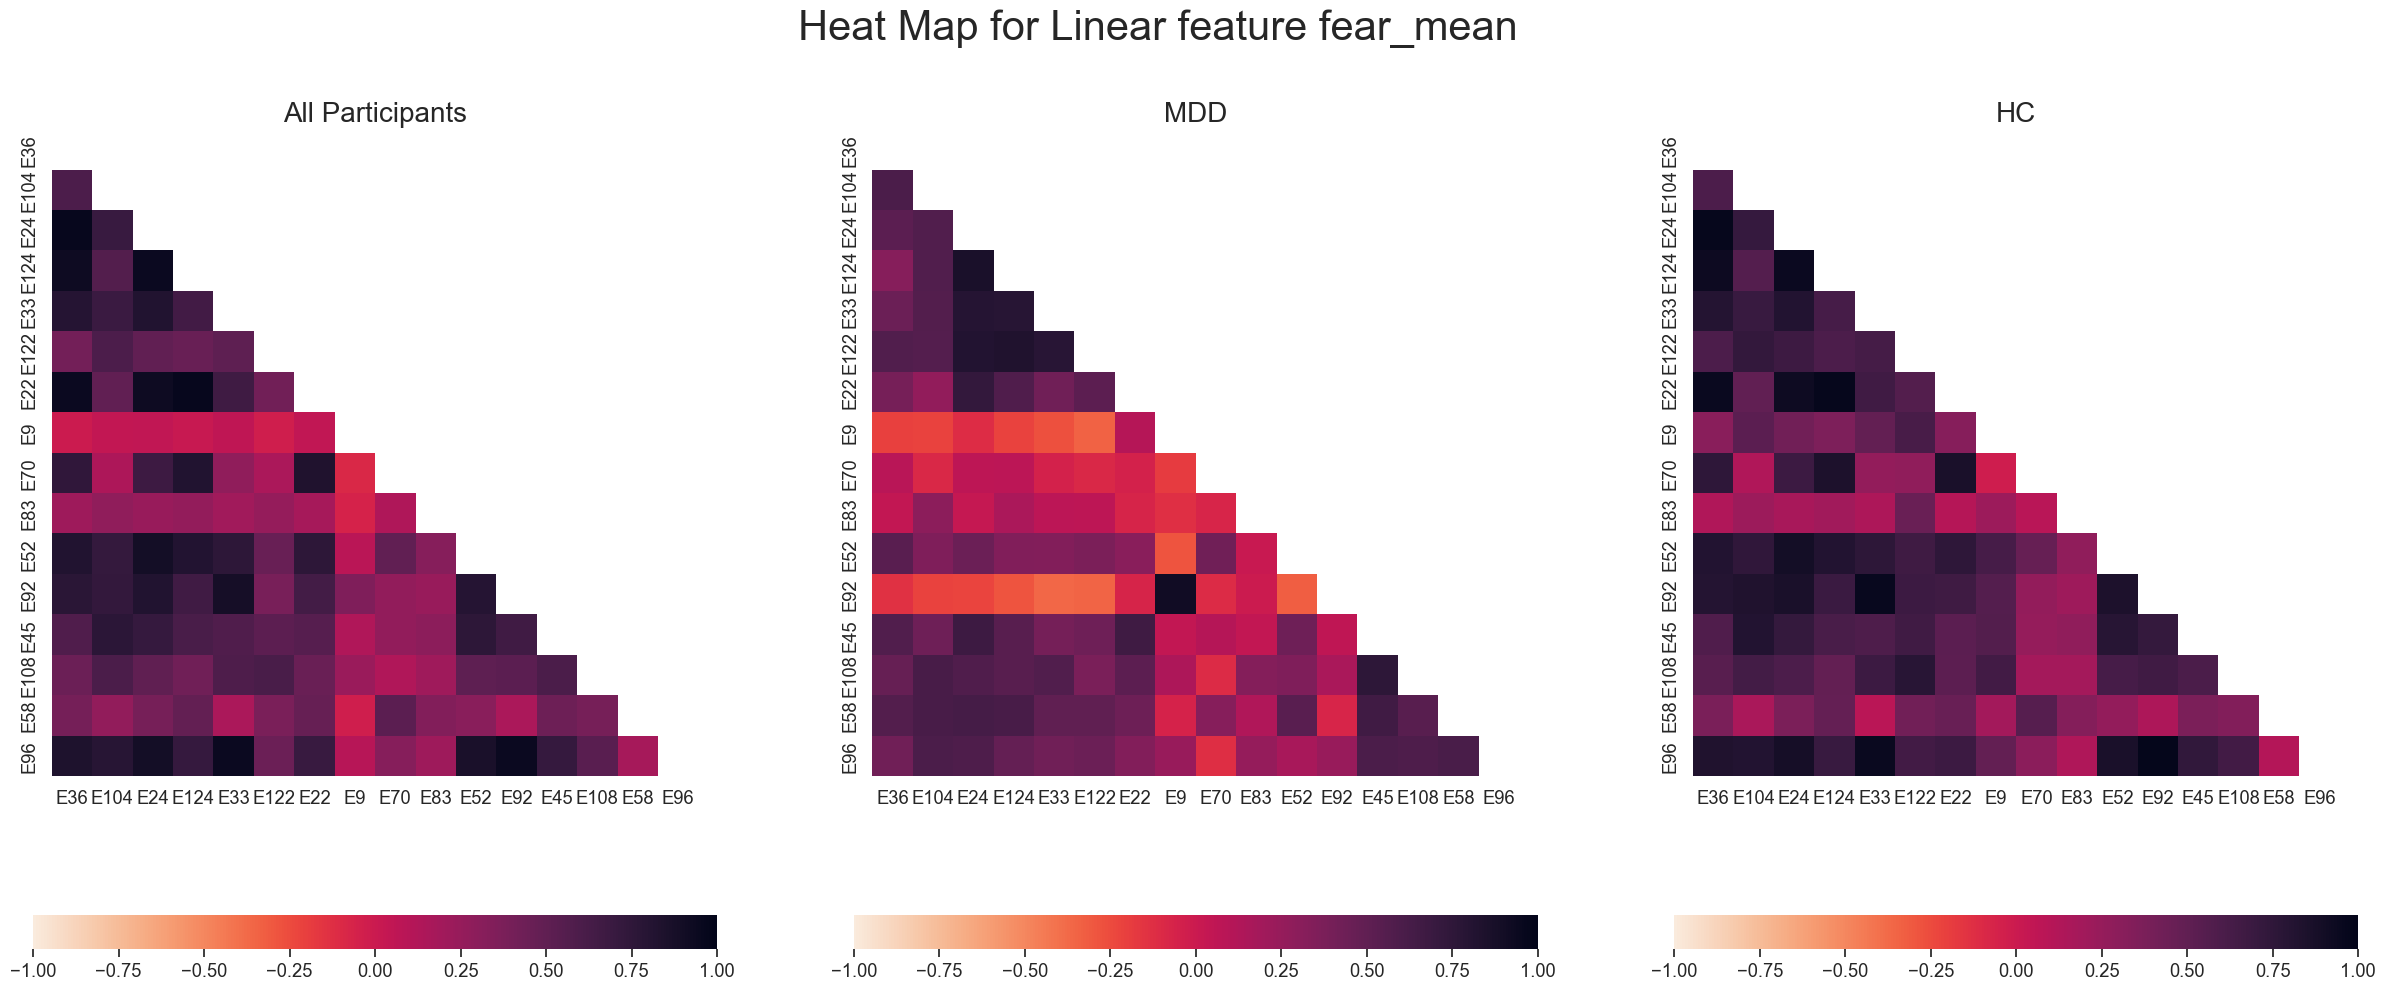

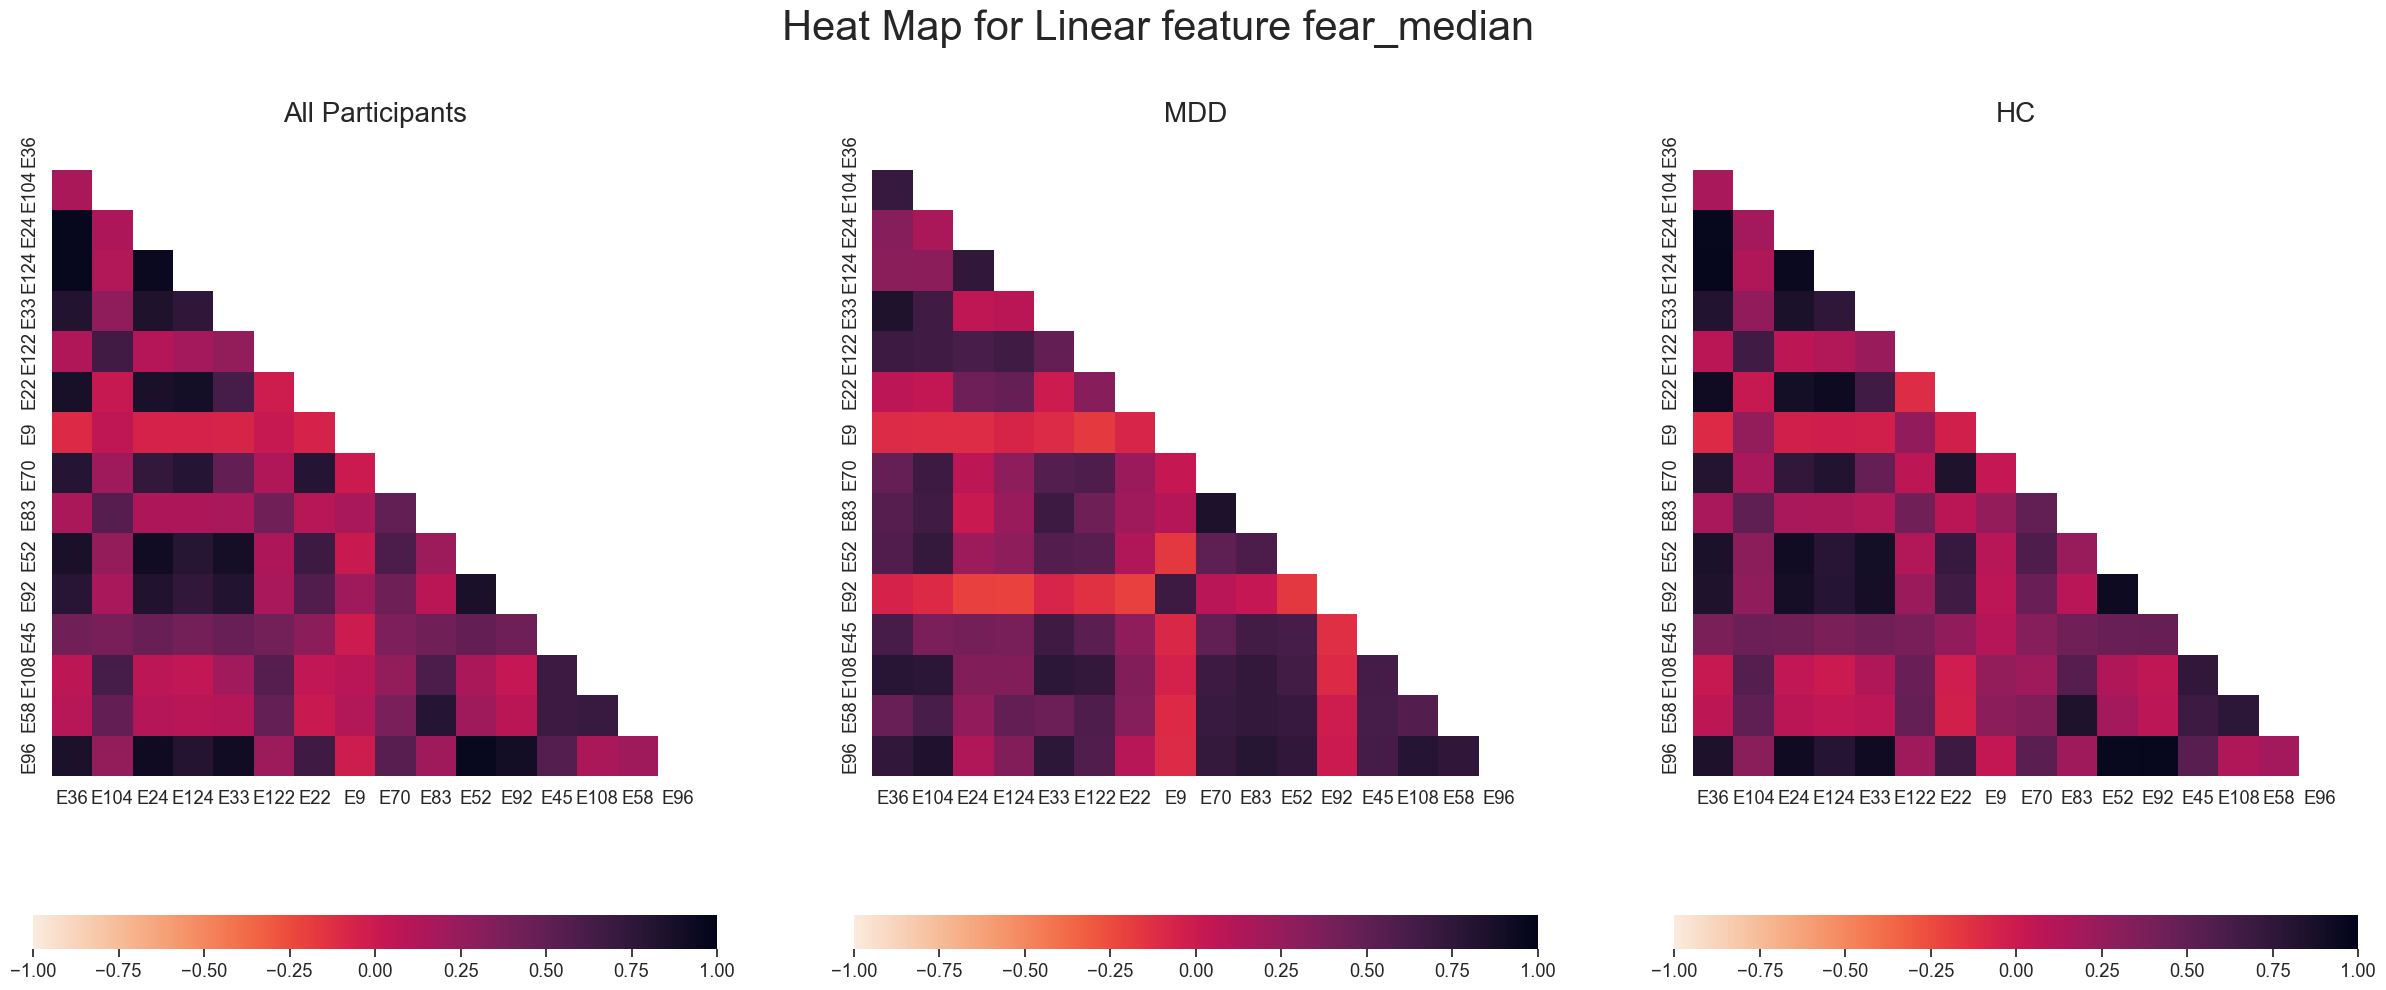

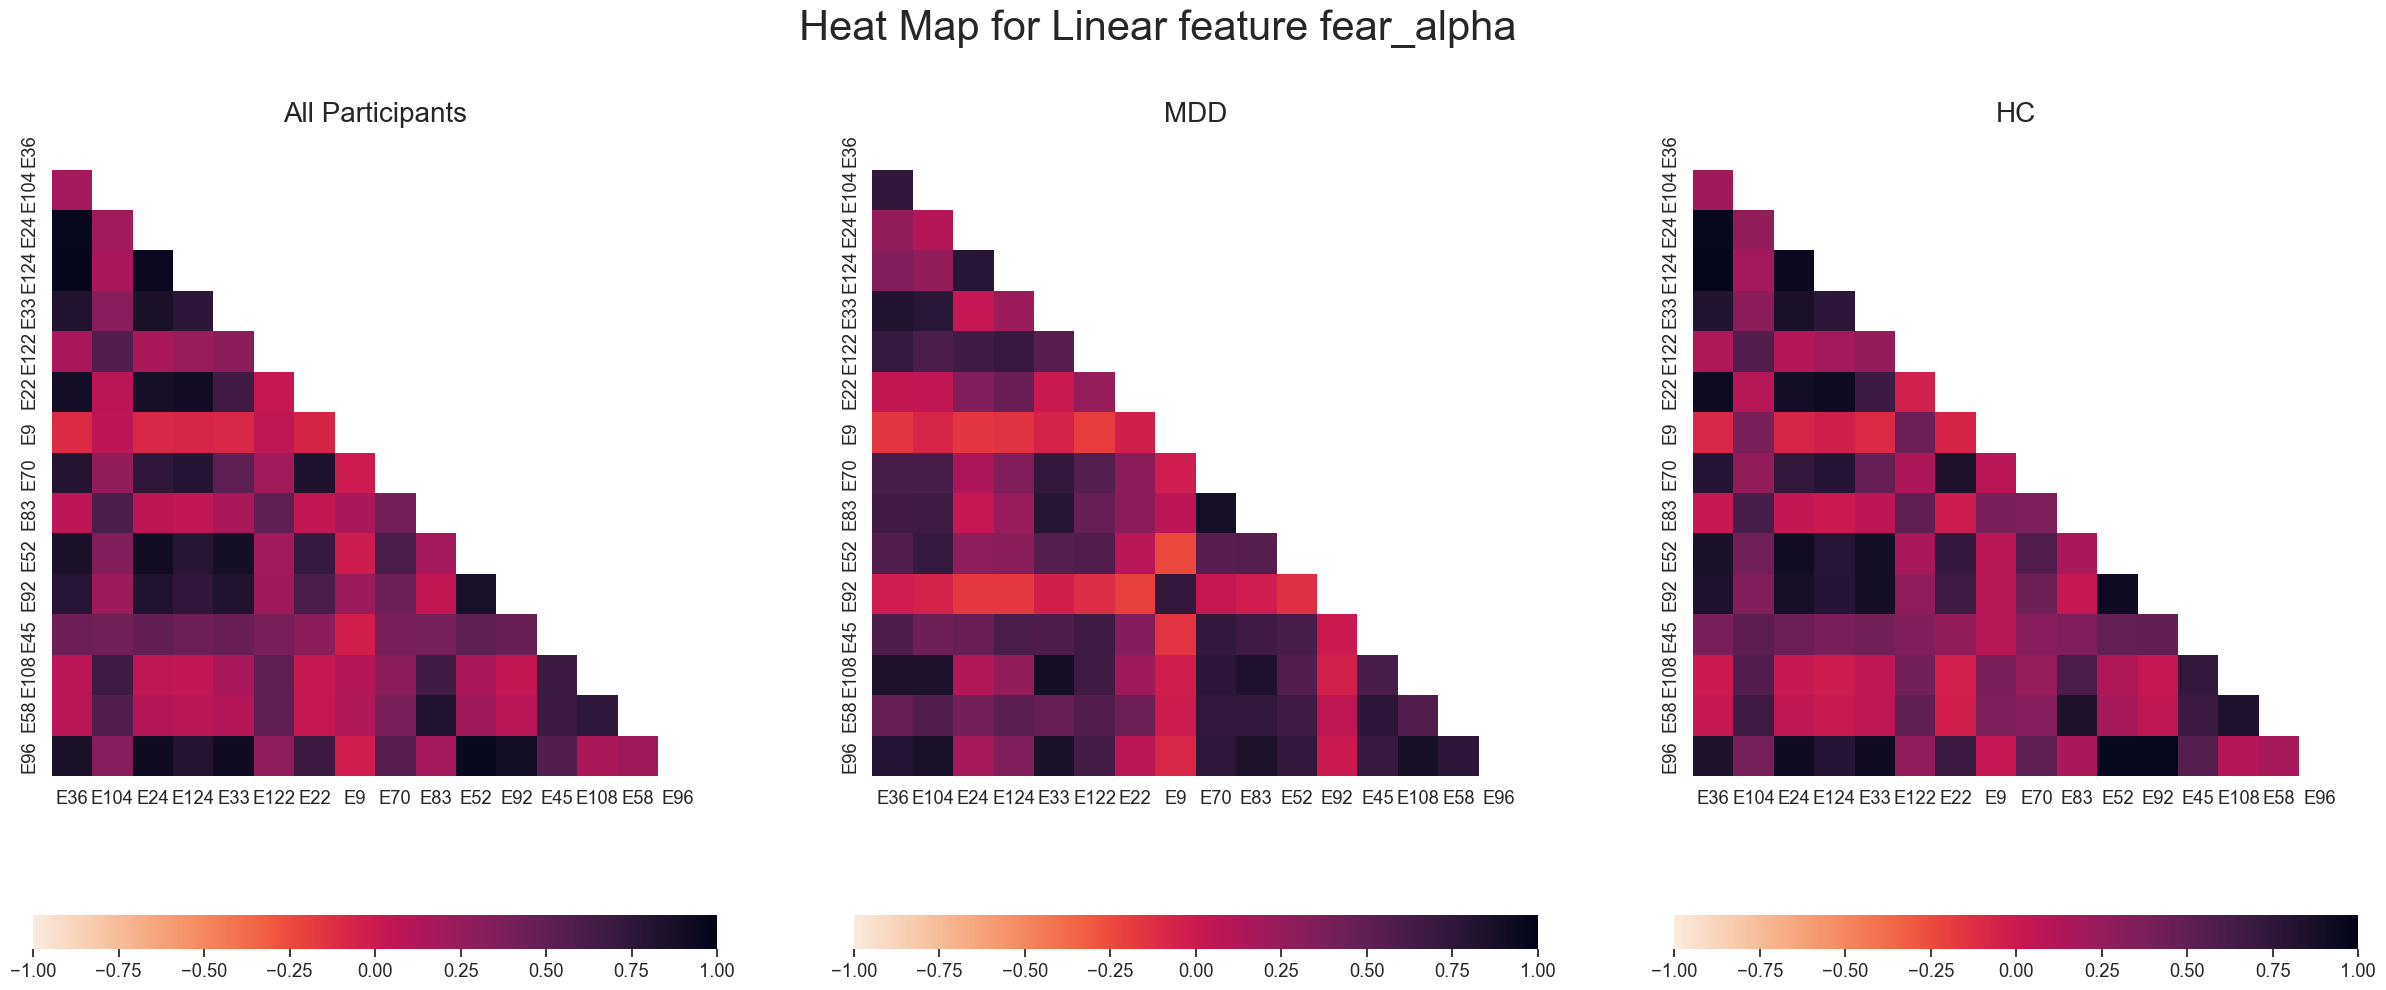

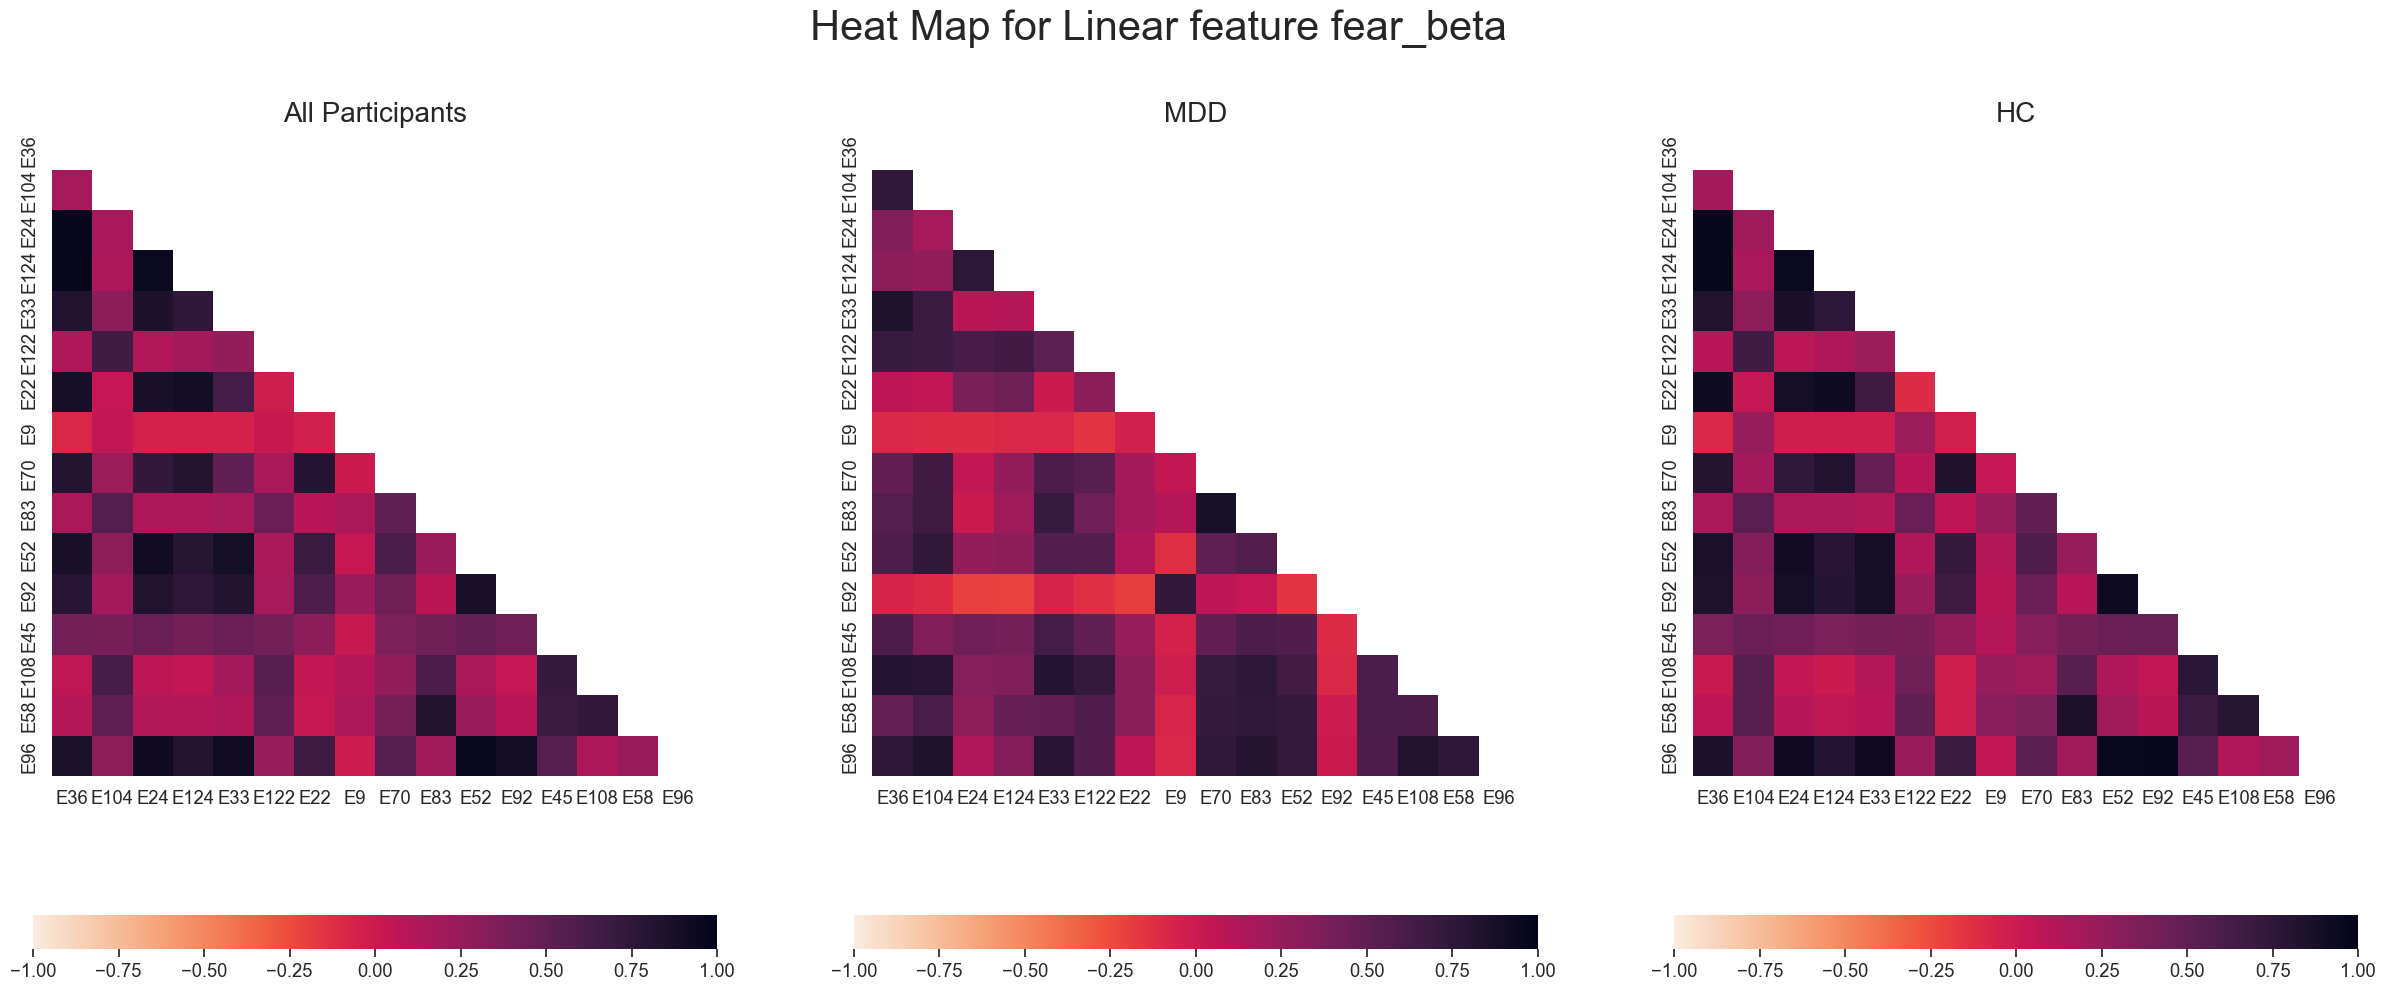

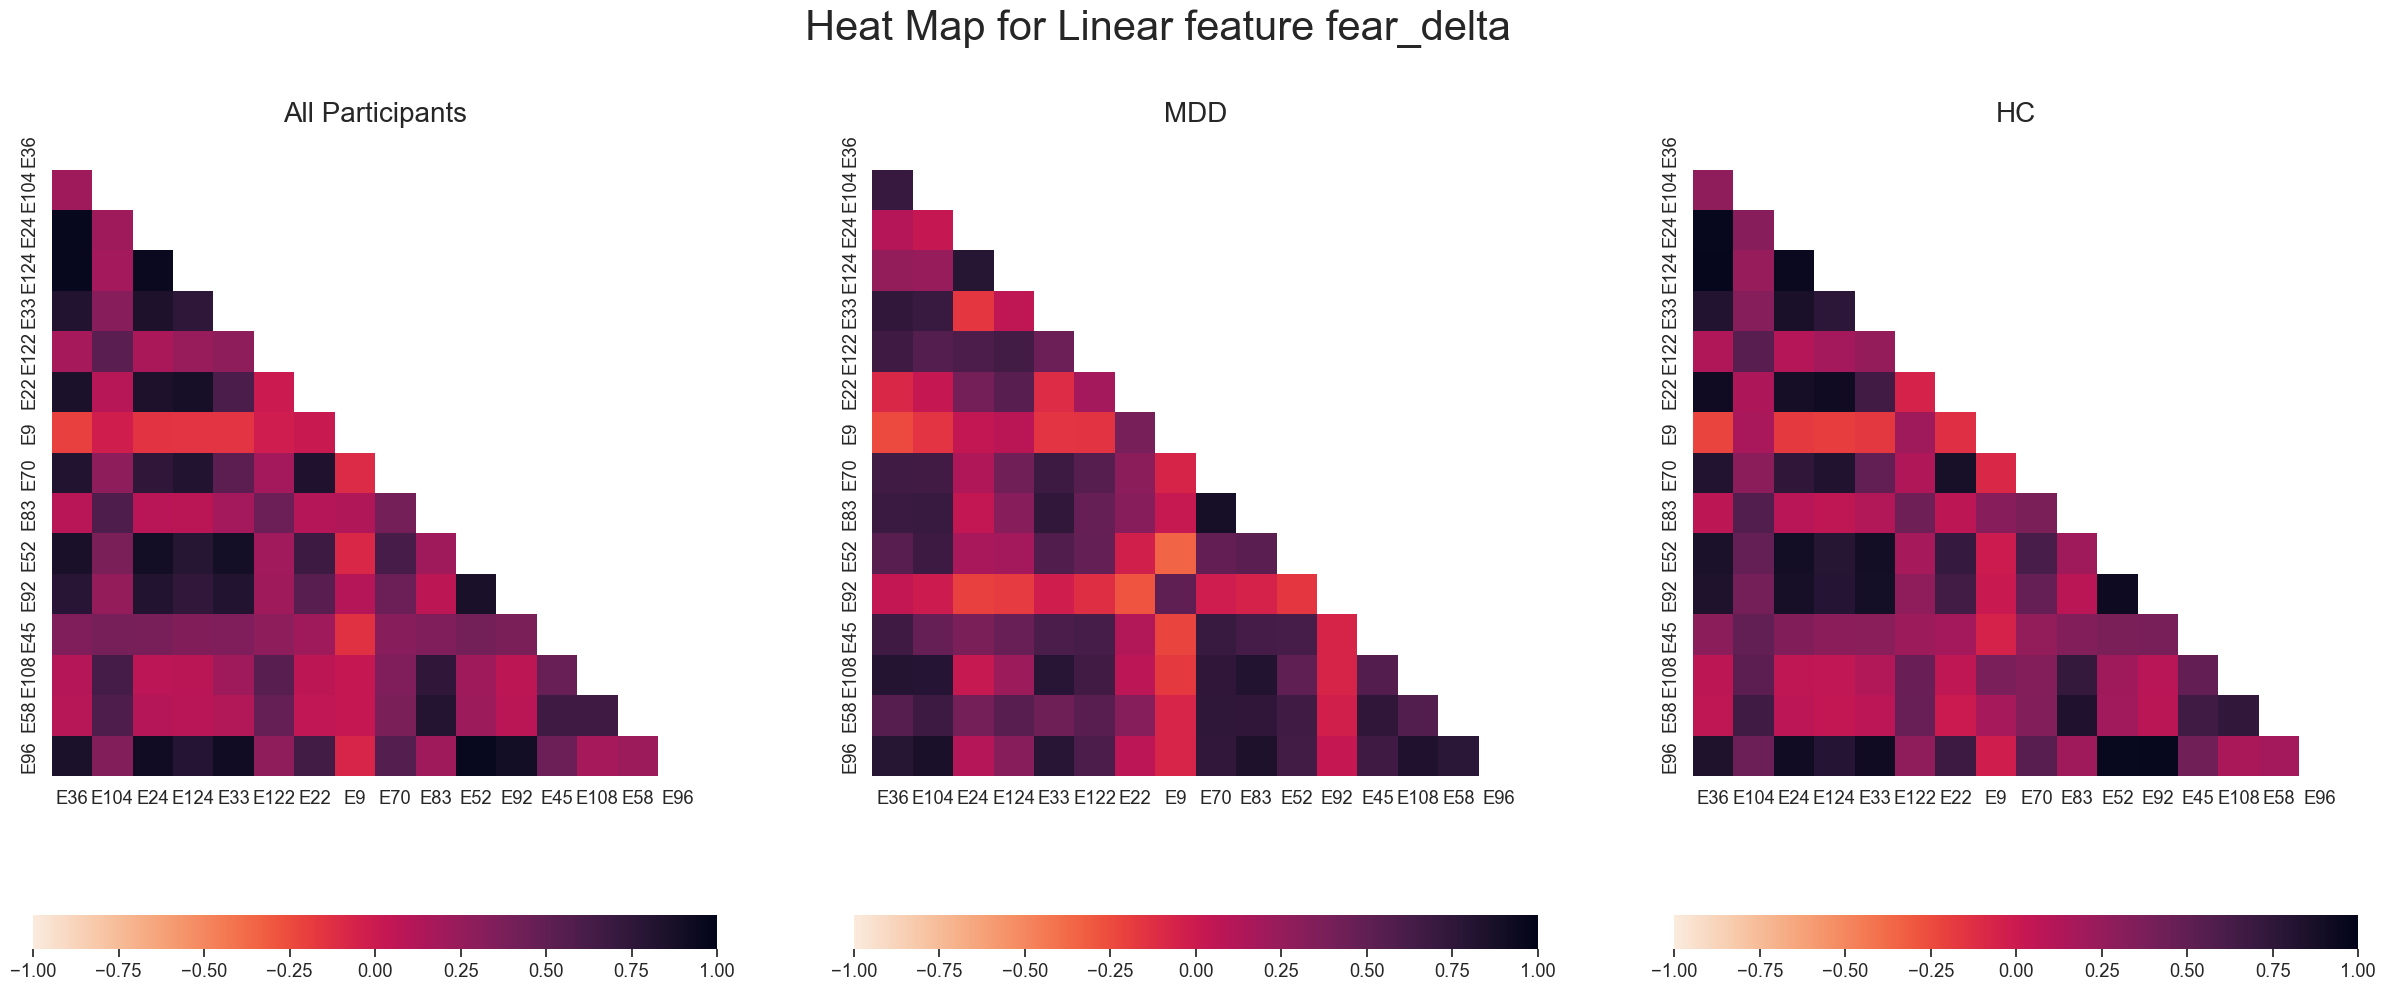

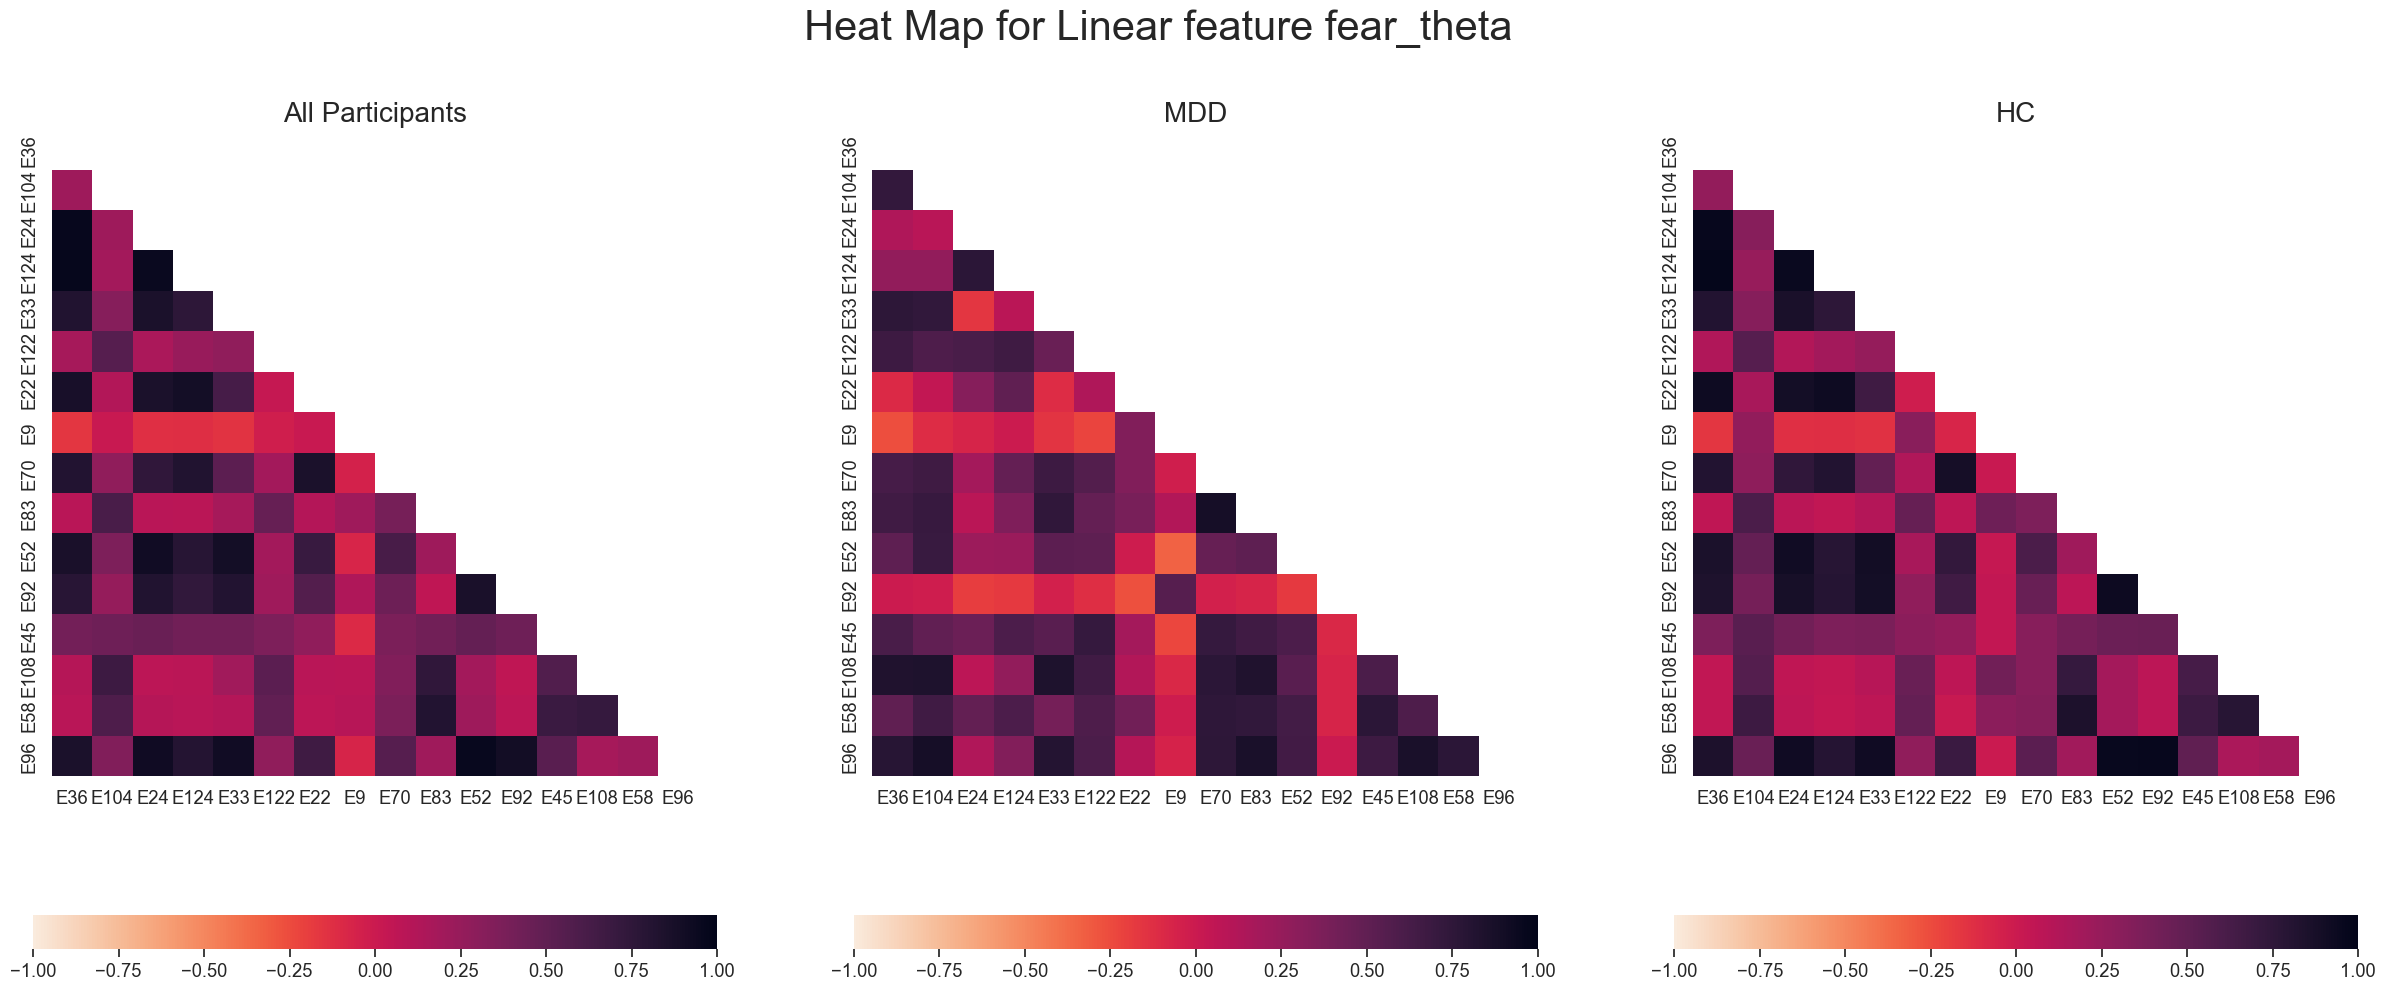

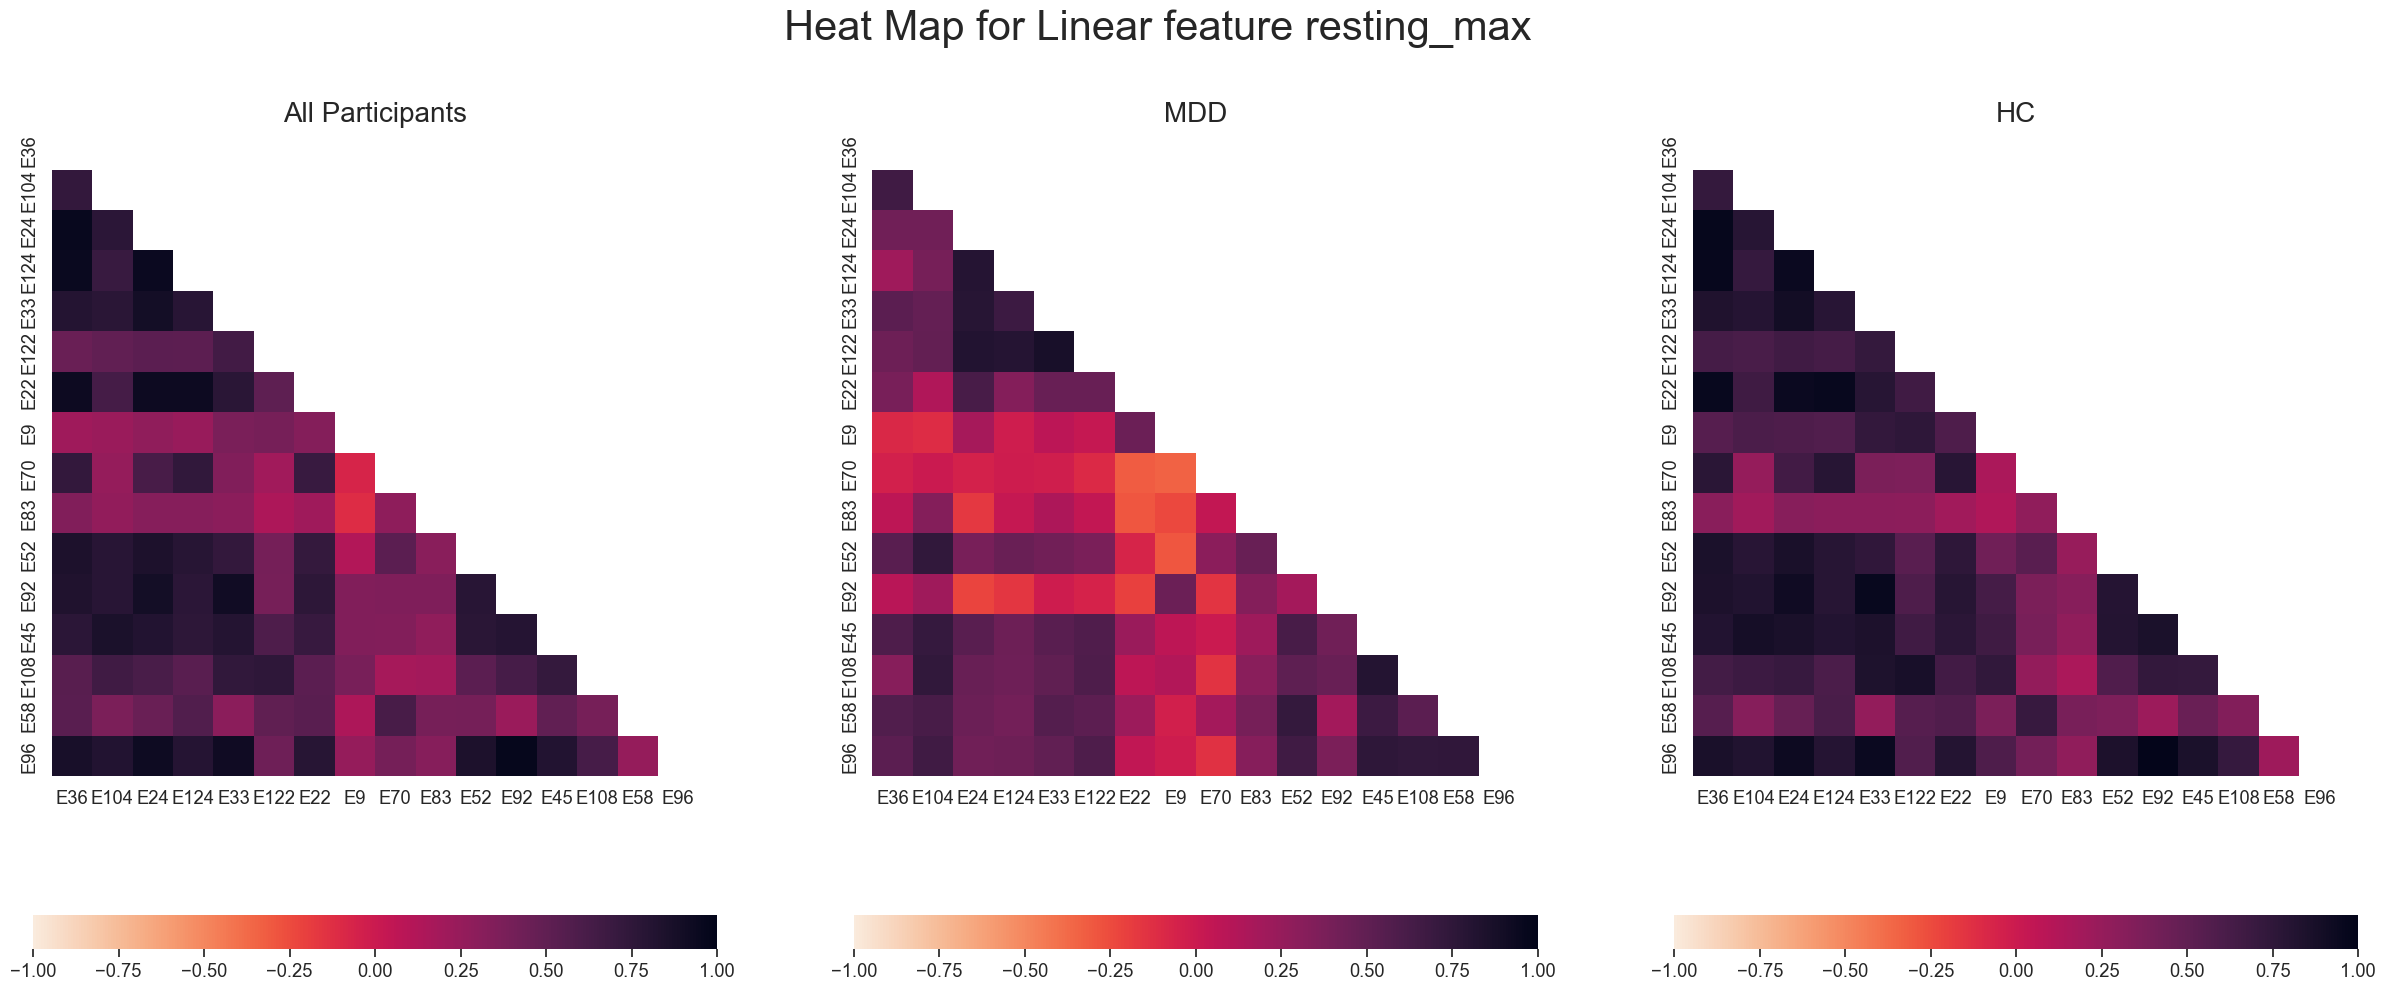

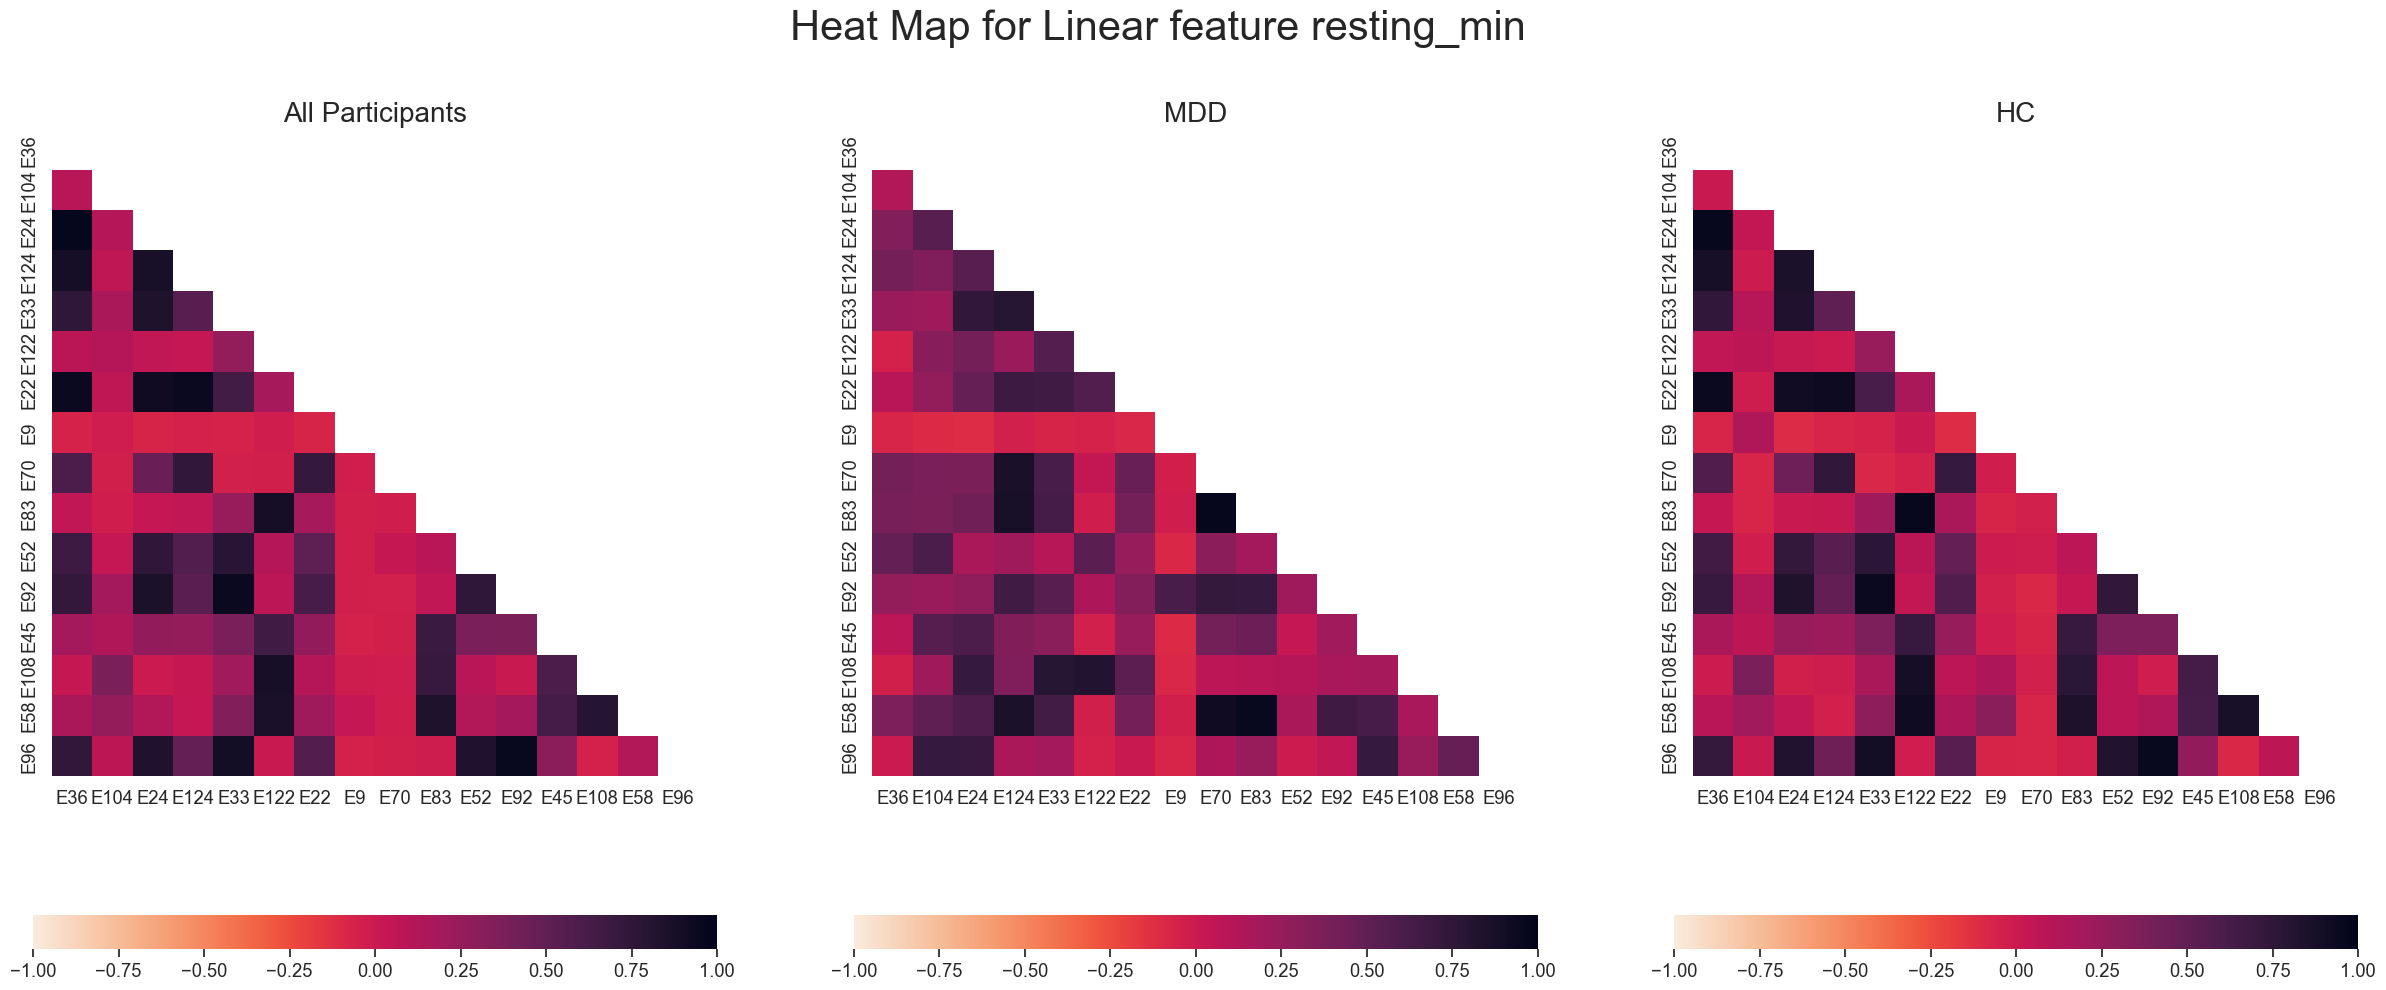

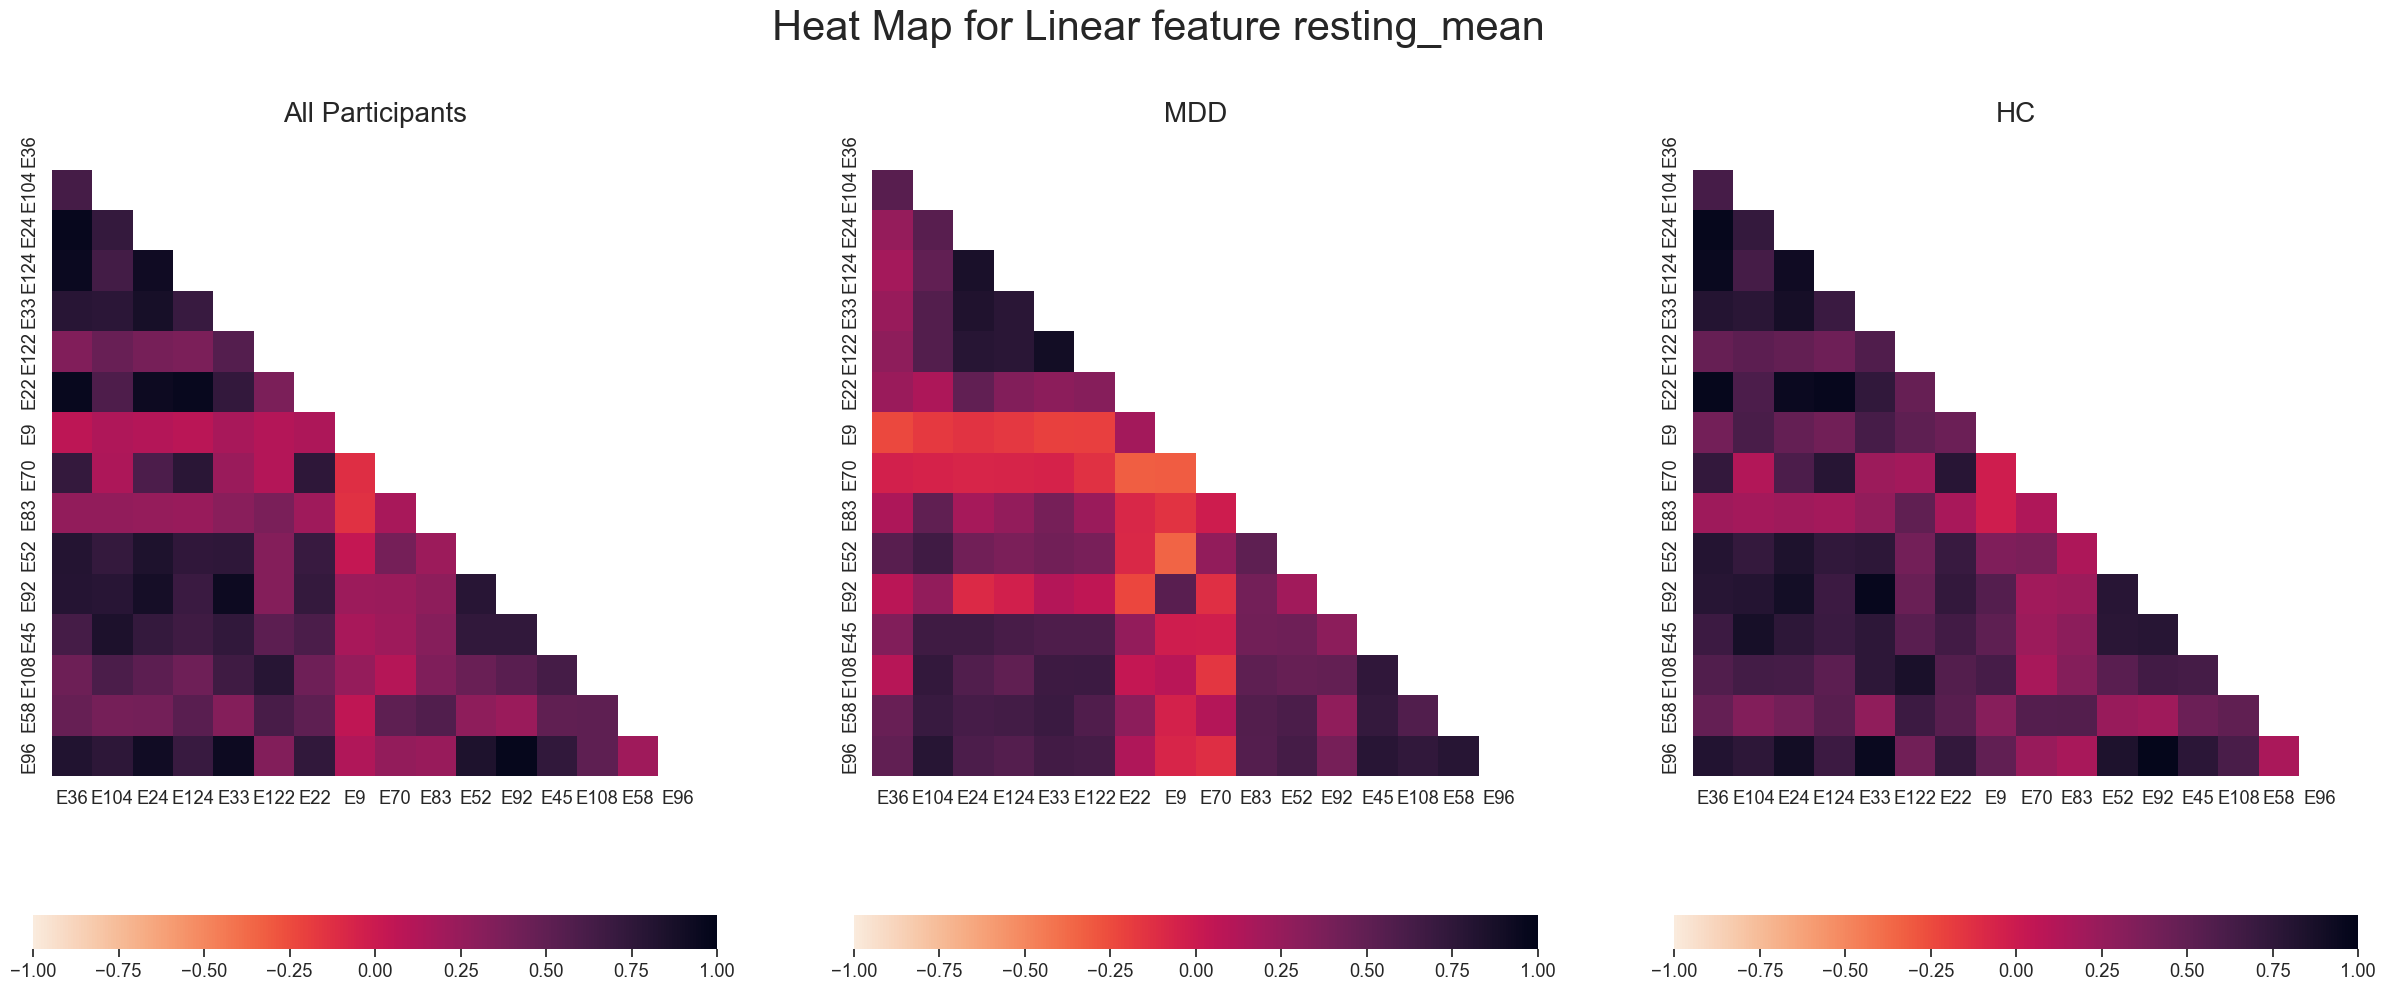

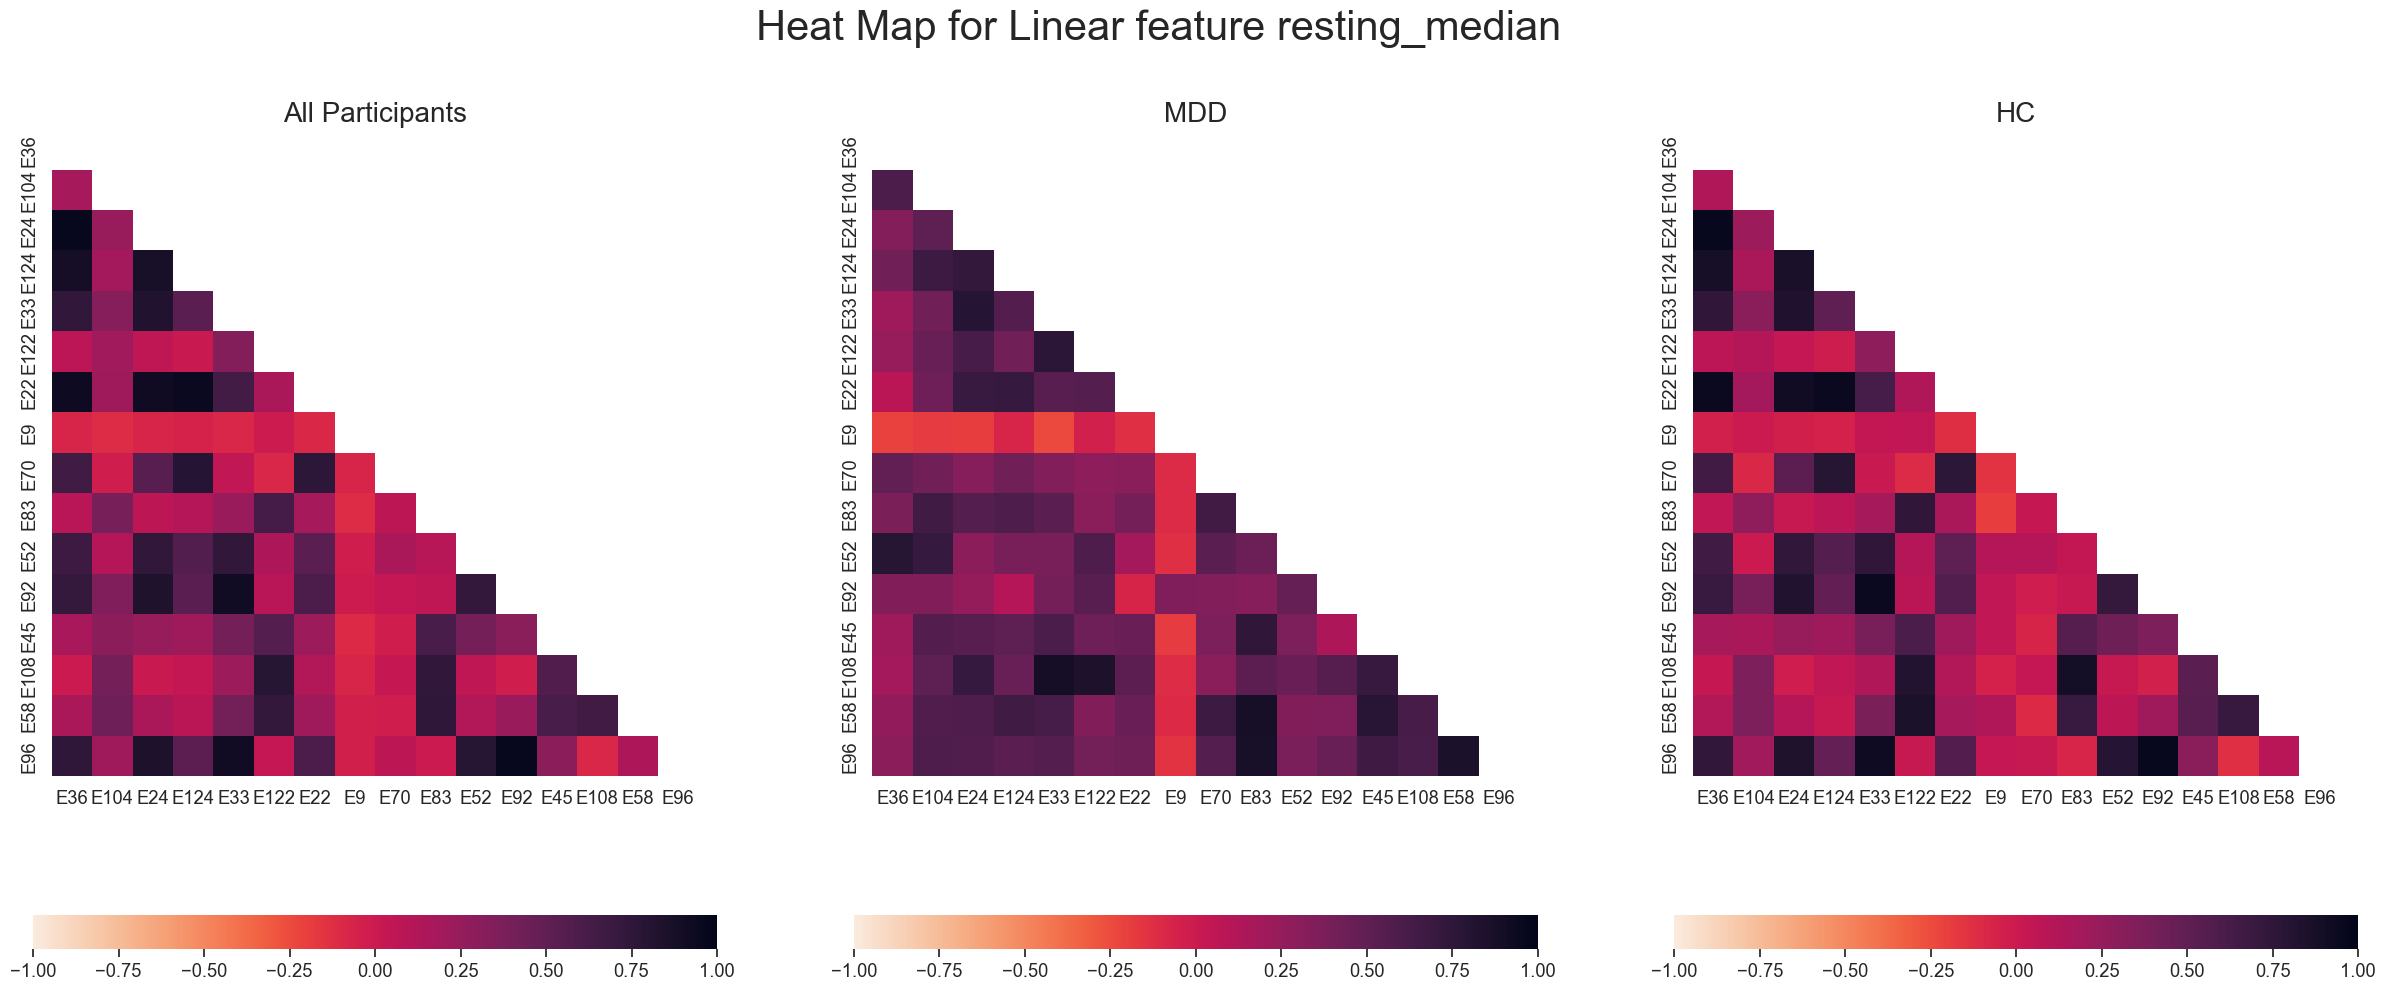

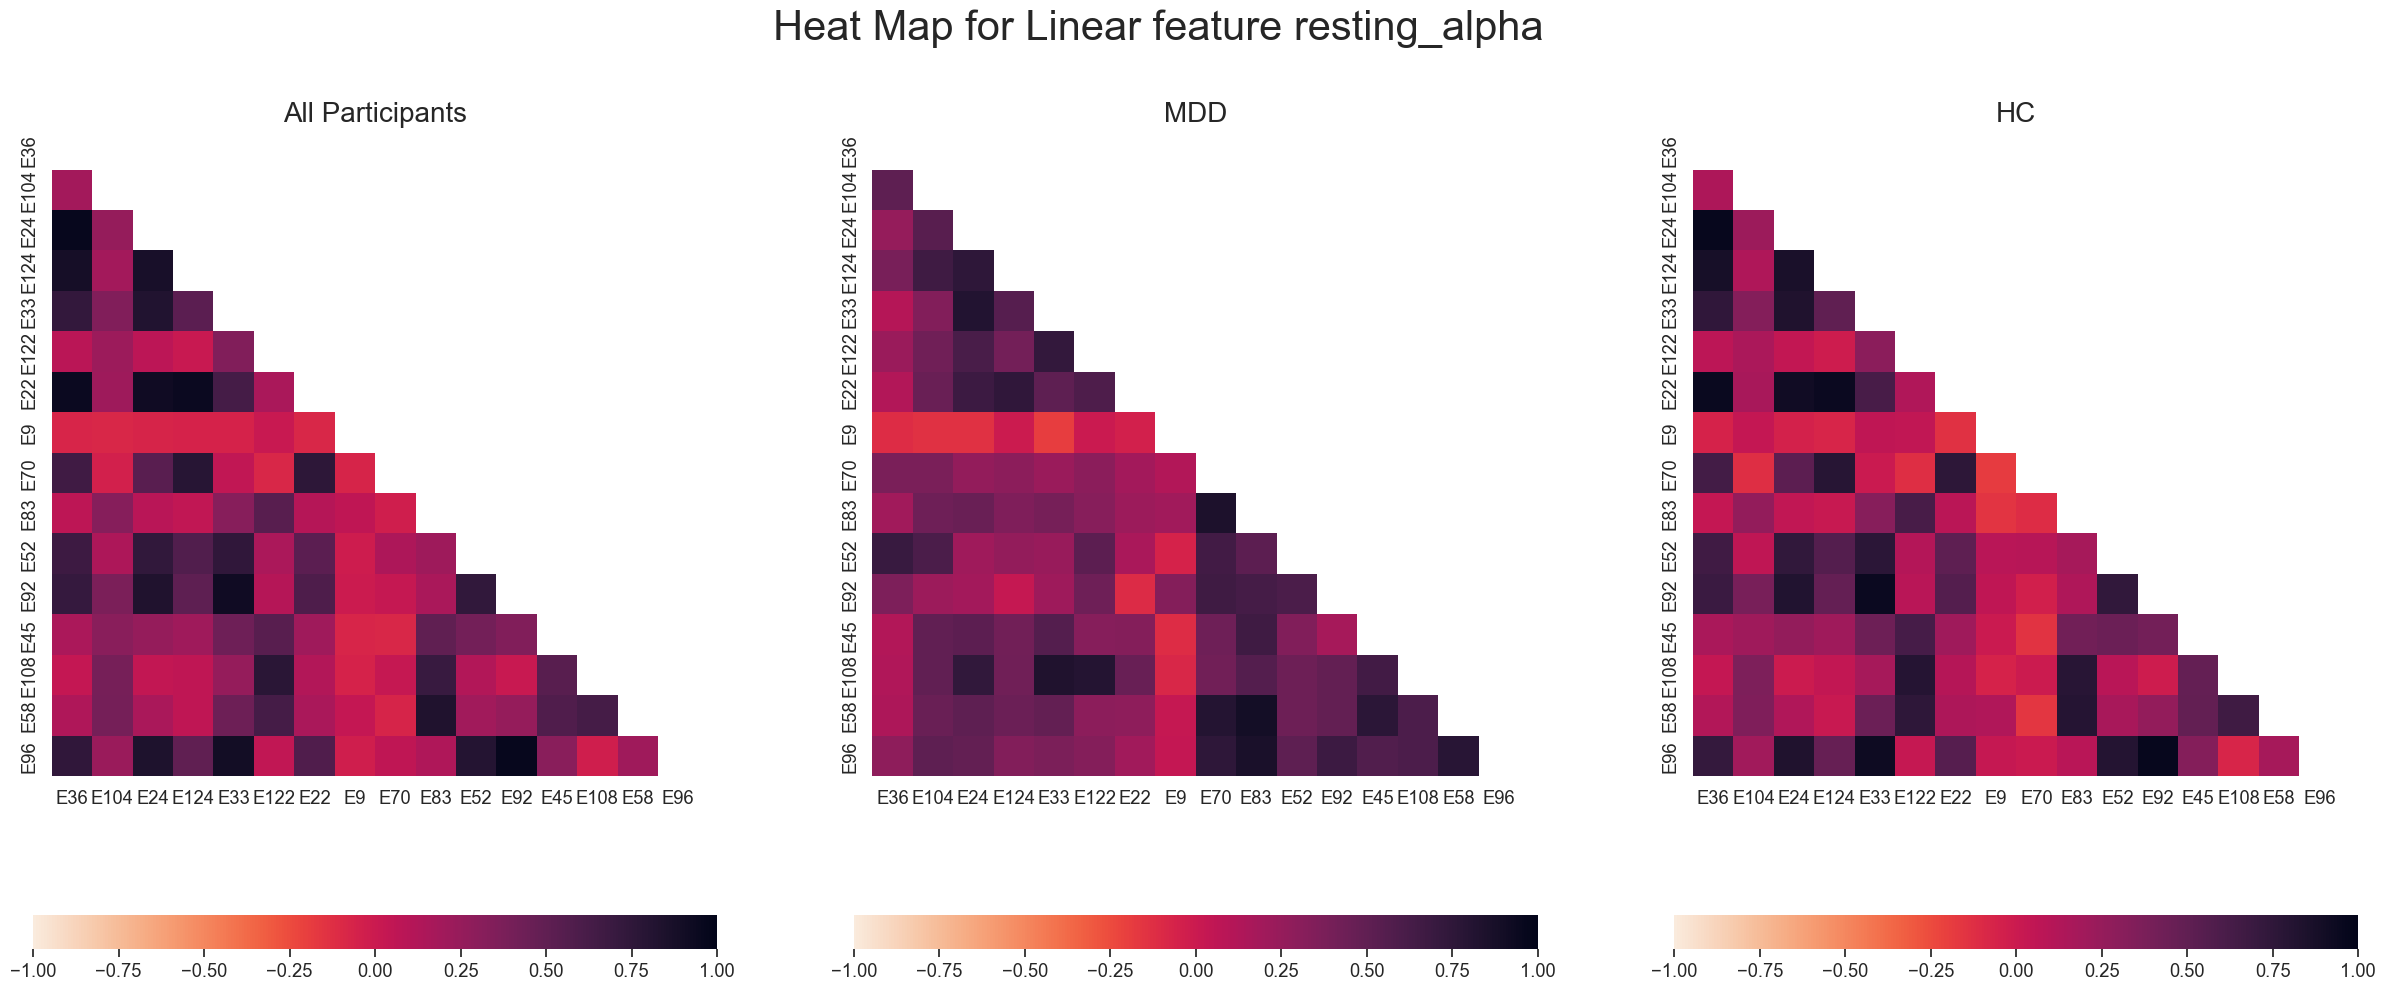

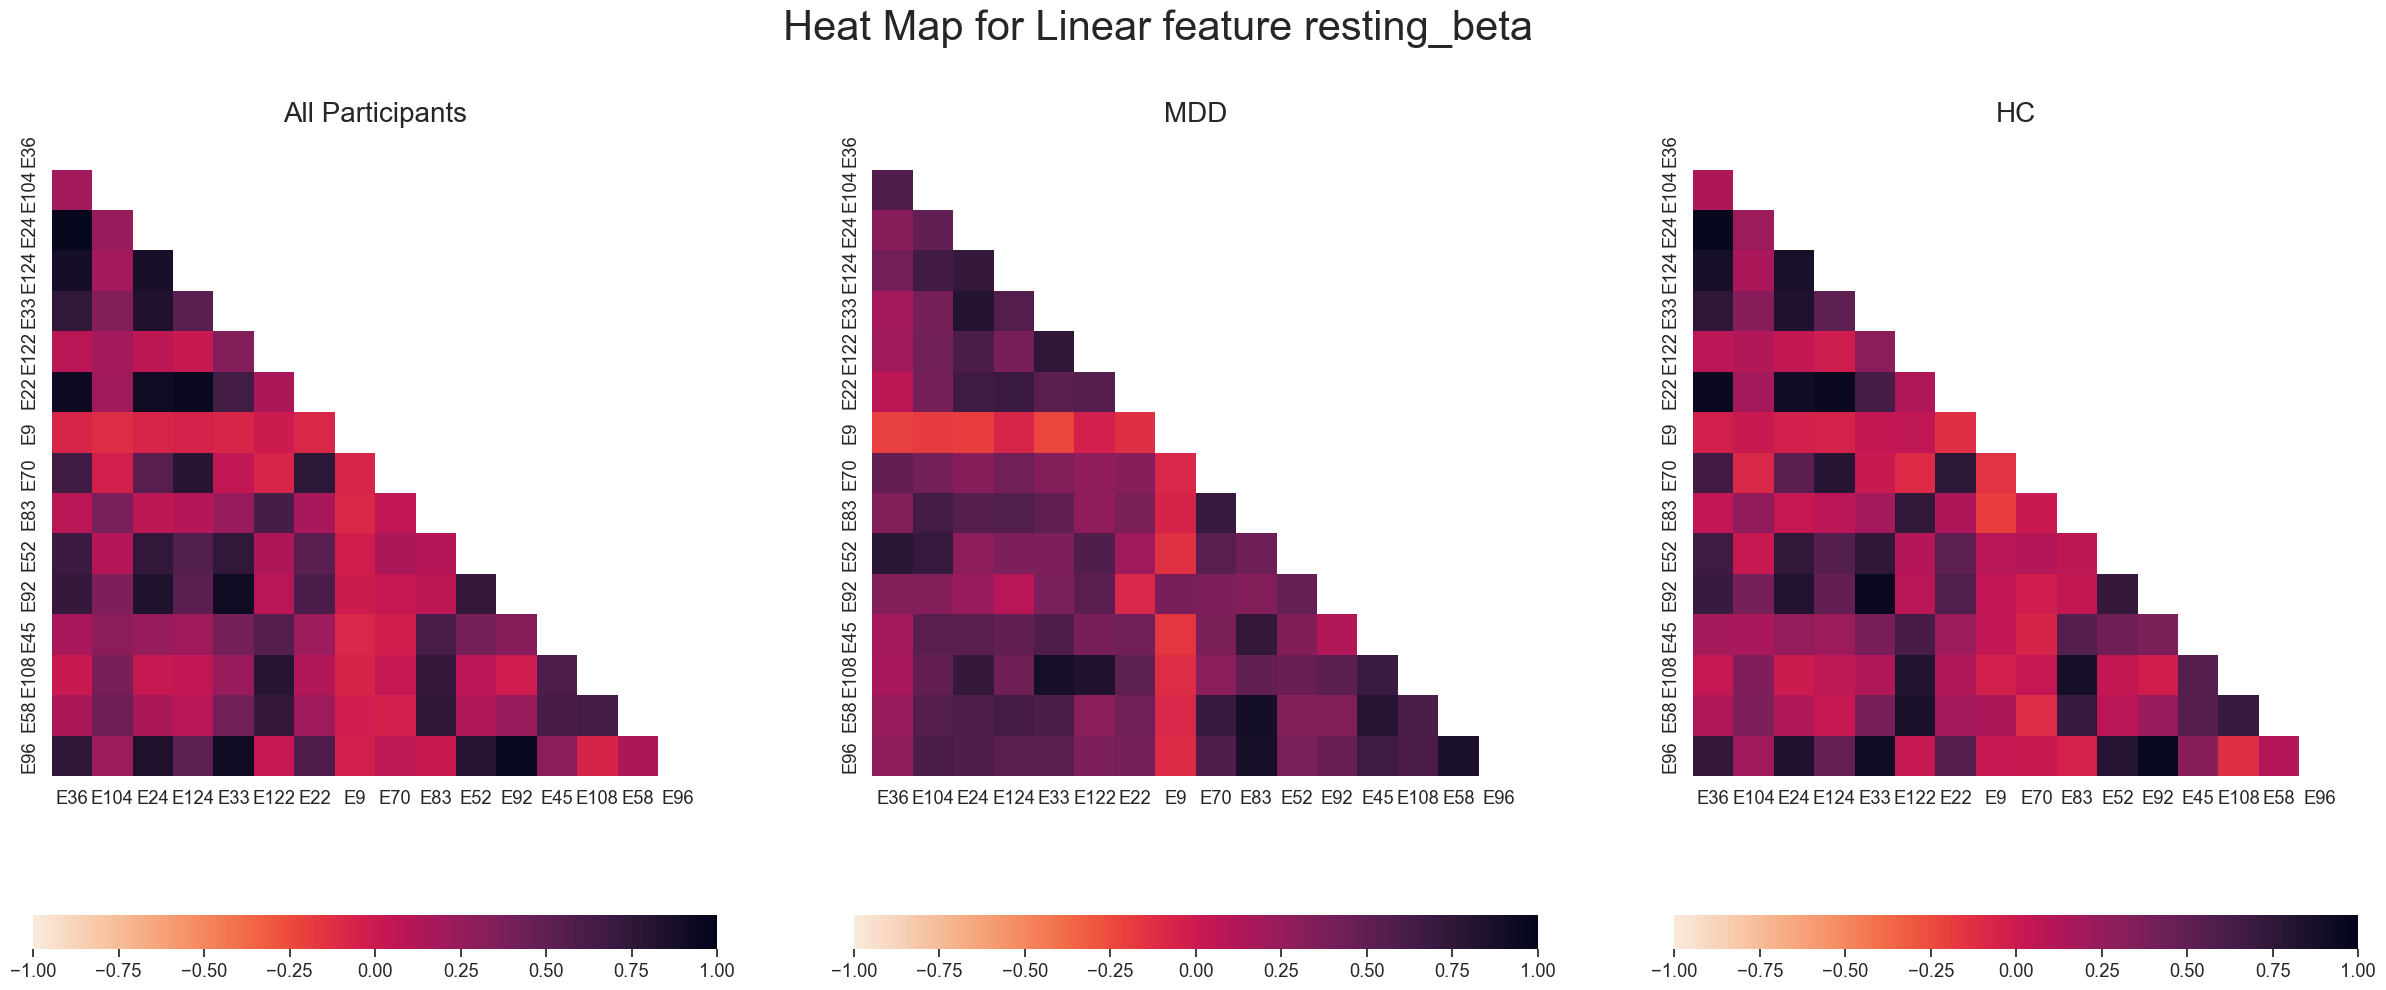

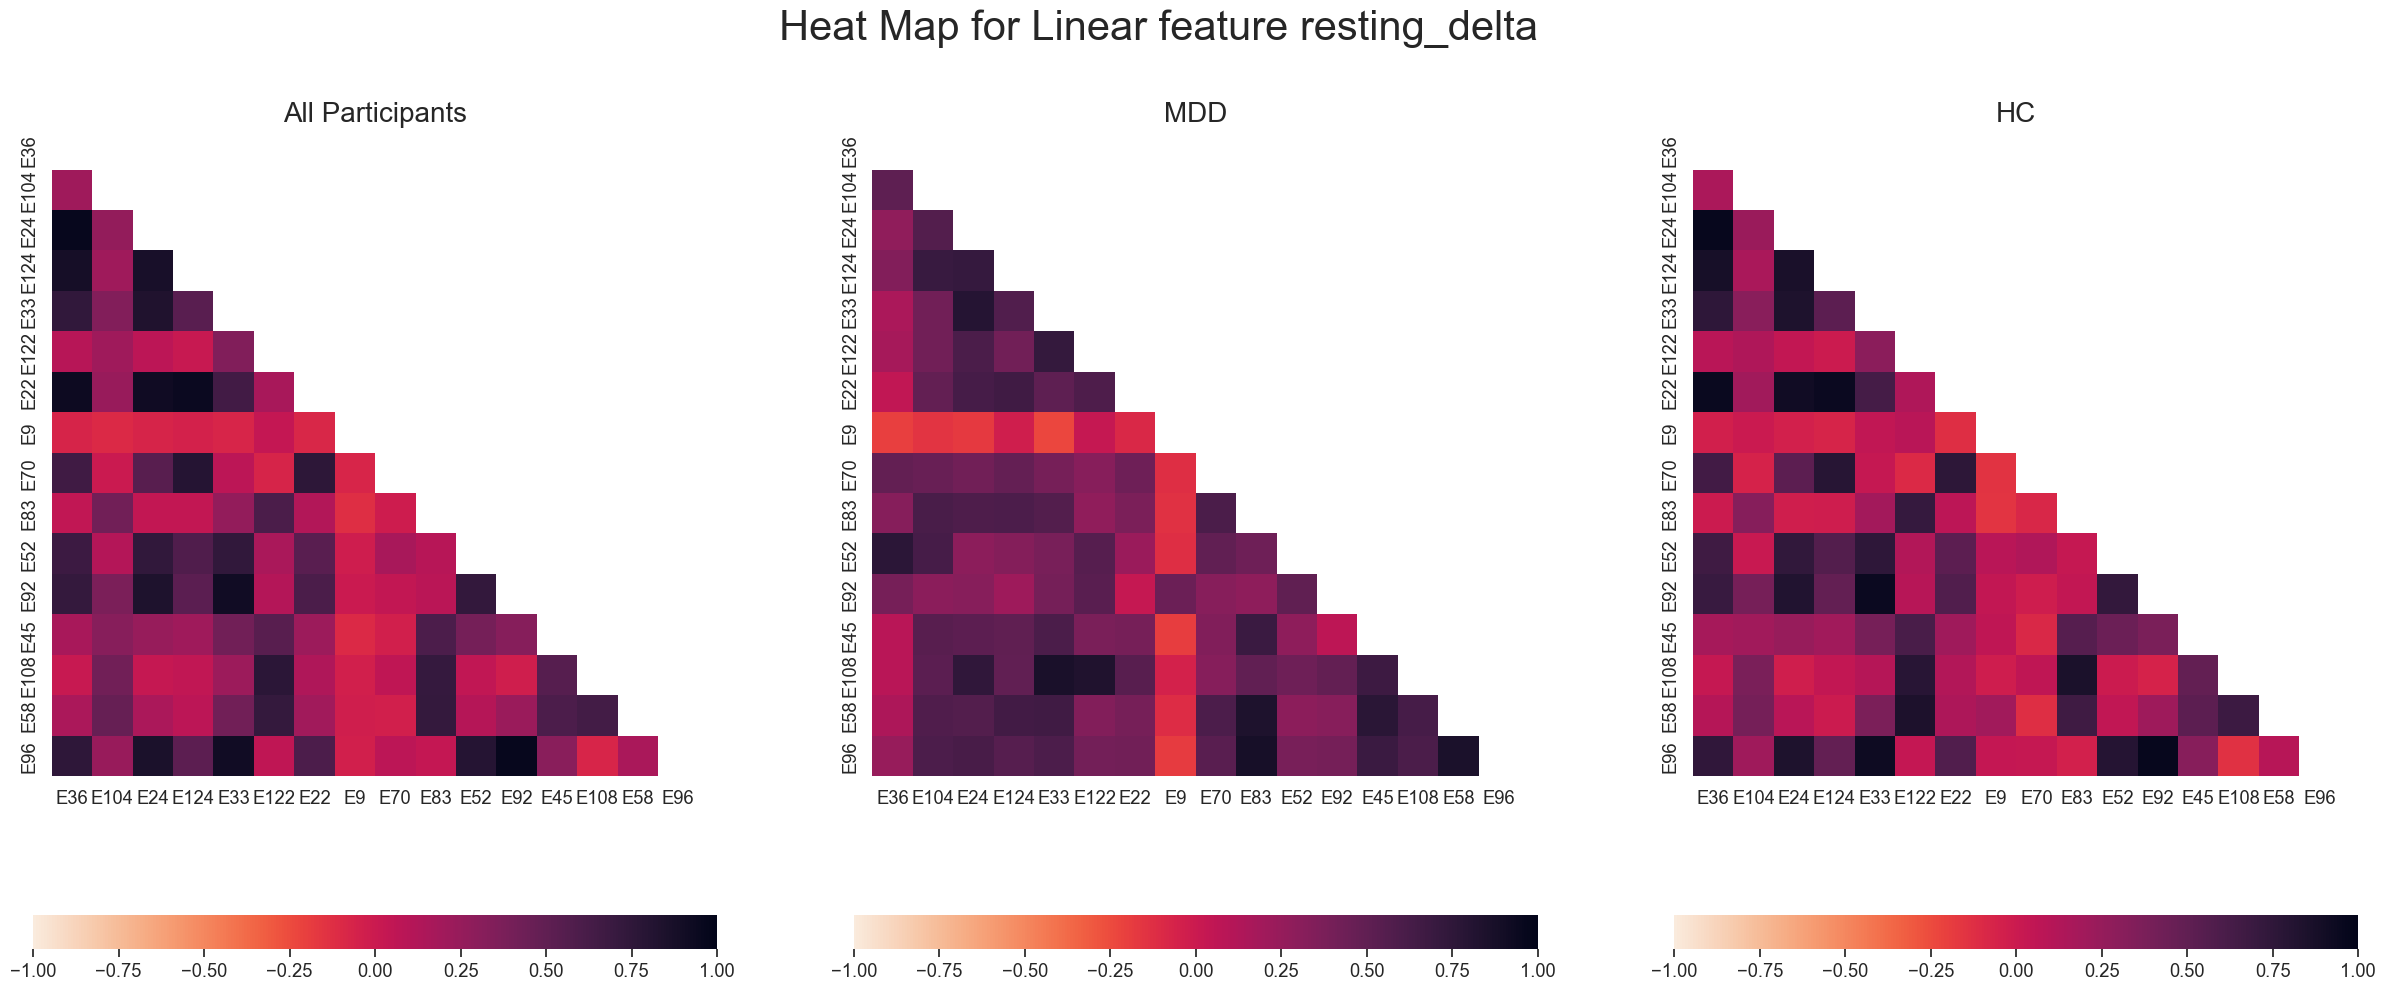

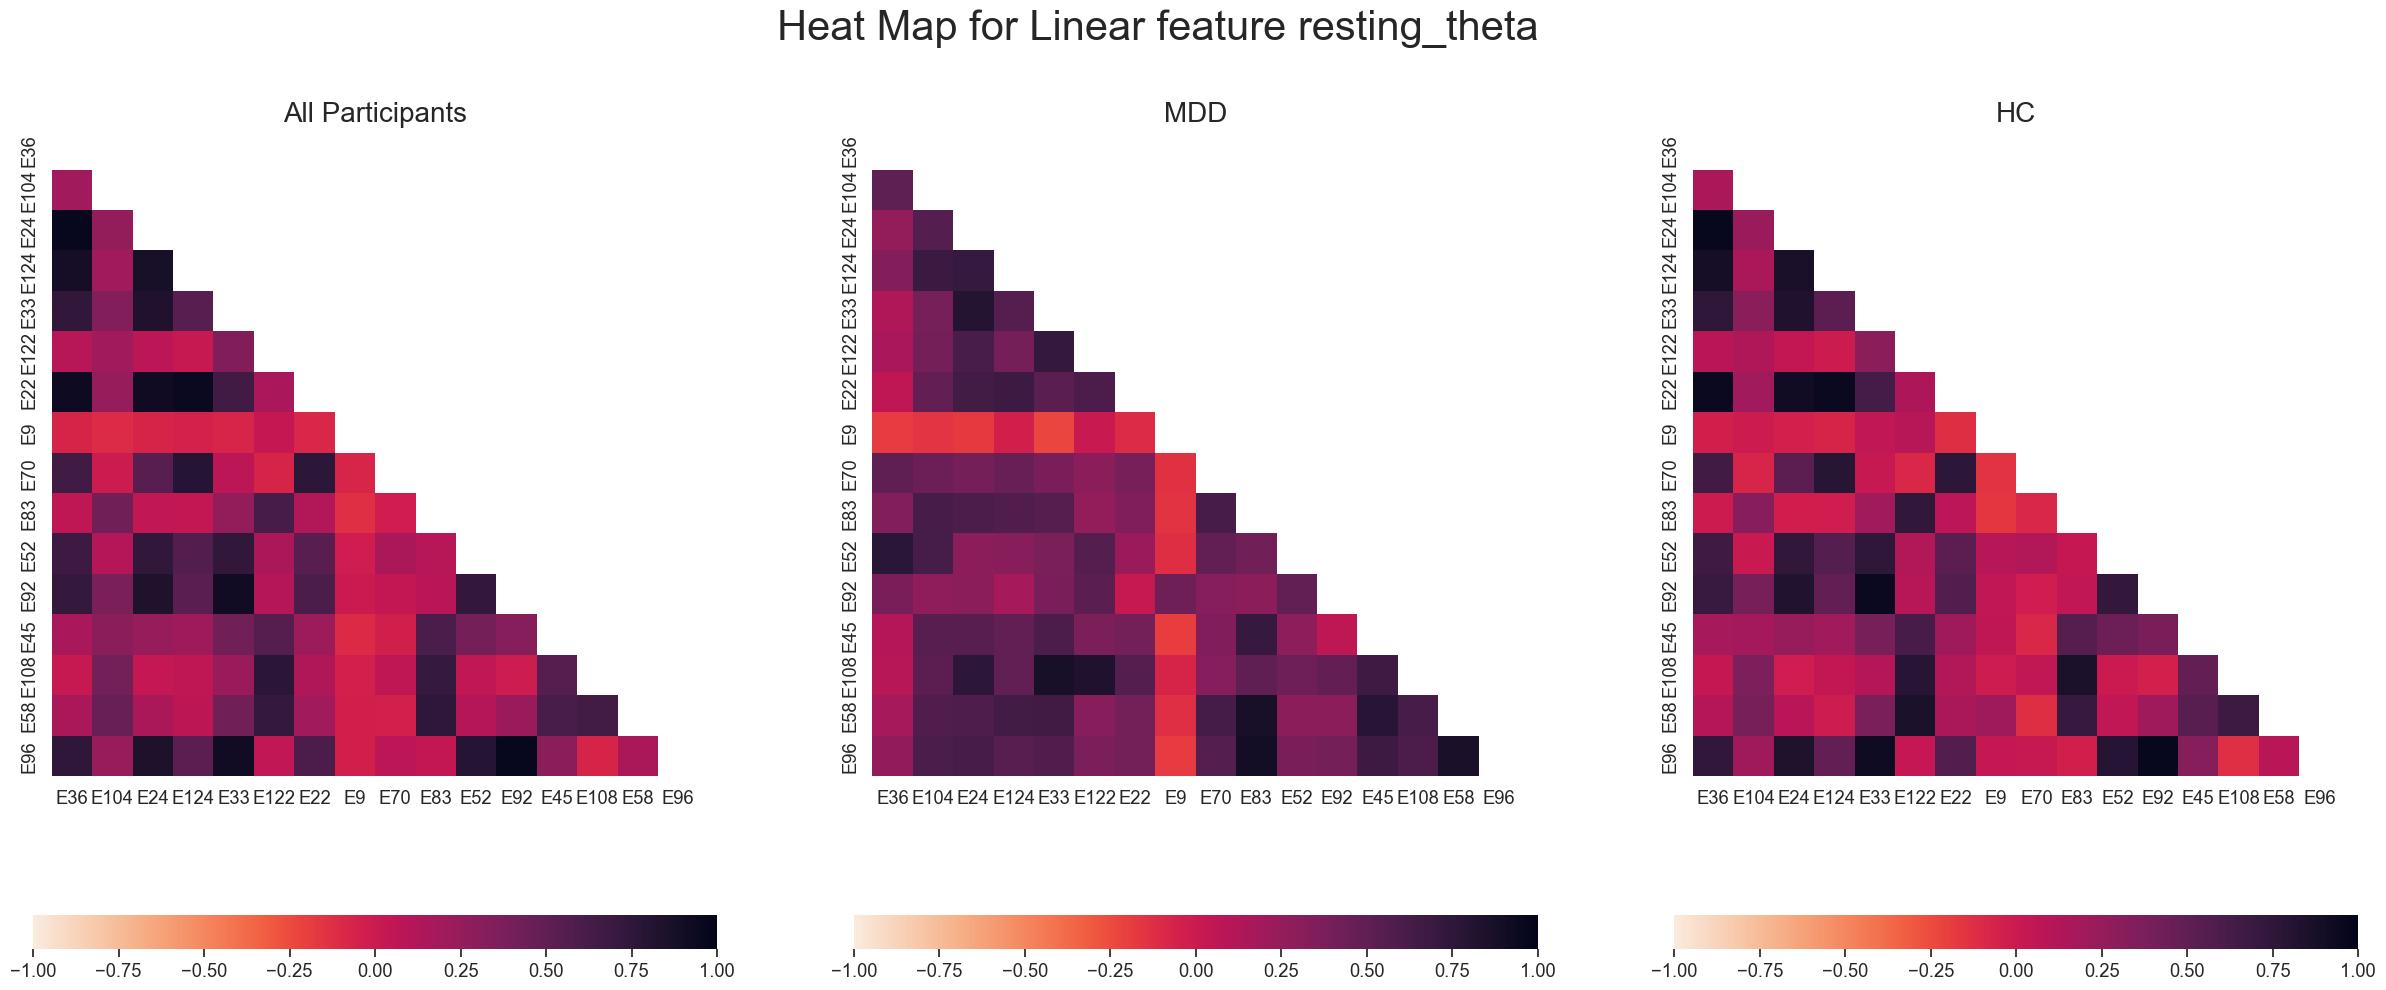

In [13]:
columns_to_keep = []
for emotion in ['happy', 'sad', 'fear', 'resting']:
    for name in ['max', 'min', 'mean', 'median', 'alpha', 'beta', 'delta', 'theta']:
        temp = columns_extractor(df, emotion, 'lf', name)
        a, b = correlation_builder(
            temp, prefix='Linear feature '+emotion+'_'+name)
        temp.drop(columns='type', inplace=True)
        columns_to_keep.extend(
            ['lf_'+name+'_'+emotion+'_'+i for i in temp.columns[column_eliminator(a, thr=0.8)]])

In [14]:
len(columns_to_keep)

259

In [15]:
# Few visualizations concluding this section
for i in ['happy', 'fear', 'sad', 'resting']:
    for j in ['alpha', 'beta', 'delta', 'theta']:
        df['lf'+'_'+i+'_'+j] = np.mean(
            df[[x for x in df.columns if 'lf' in x and i in x and j in x]], axis=1)

In [16]:
for i in ['happy', 'fear', 'sad', 'resting']:
    for j in ['mean', 'median', 'min', 'max']:
        df['lf'+'_'+i+'_'+j] = np.mean(
            df[[x for x in df.columns if 'lf' in x and i in x and j in x]], axis=1)

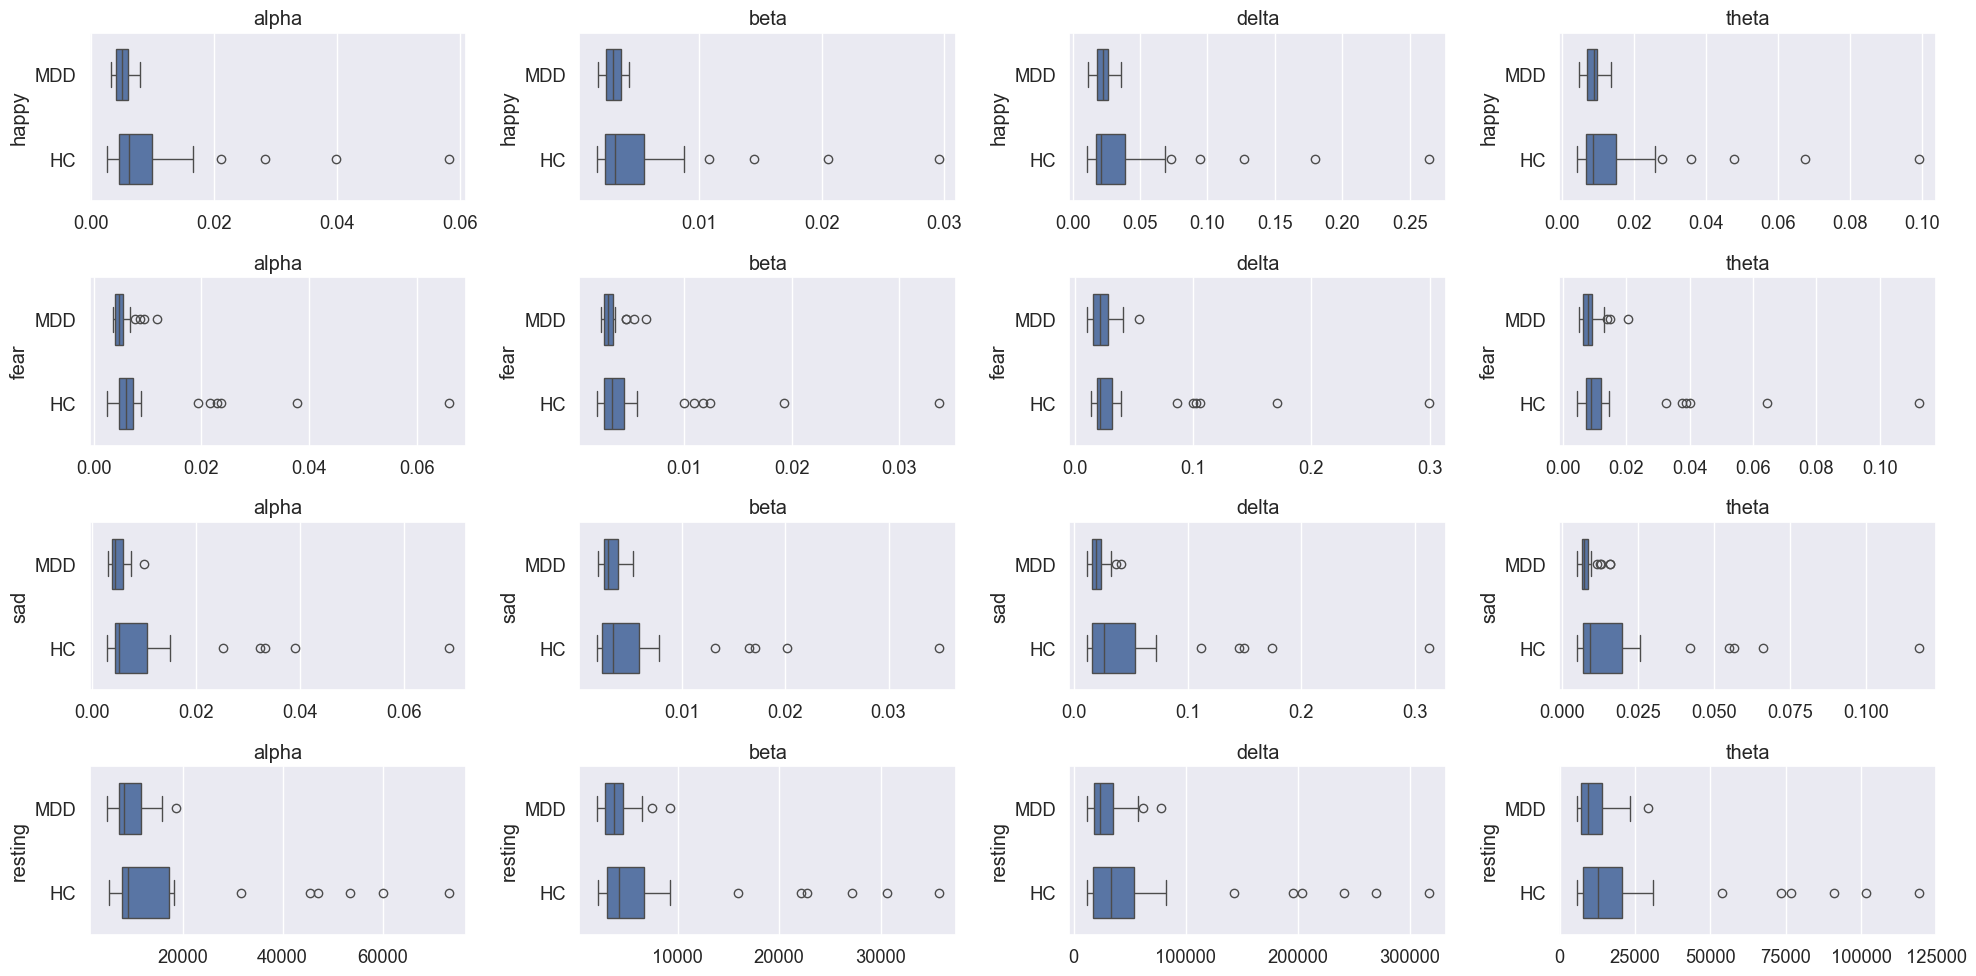

In [17]:
fig = plt.figure(figsize=(20, 10))
a = dict()
i = 0
for emotion in ['happy', 'fear', 'sad', 'resting']:
    for signal in ['alpha', 'beta', 'delta', 'theta']:
        a[i] = fig.add_subplot(4, 4, i+1)
        sns.boxplot(x='lf'+'_'+emotion+'_'+signal,
                    y="type", data=df, width=.6, ax=a[i])
        a[i].set(ylabel=emotion, xlabel='', title=signal)
        i = i + 1
fig.tight_layout()

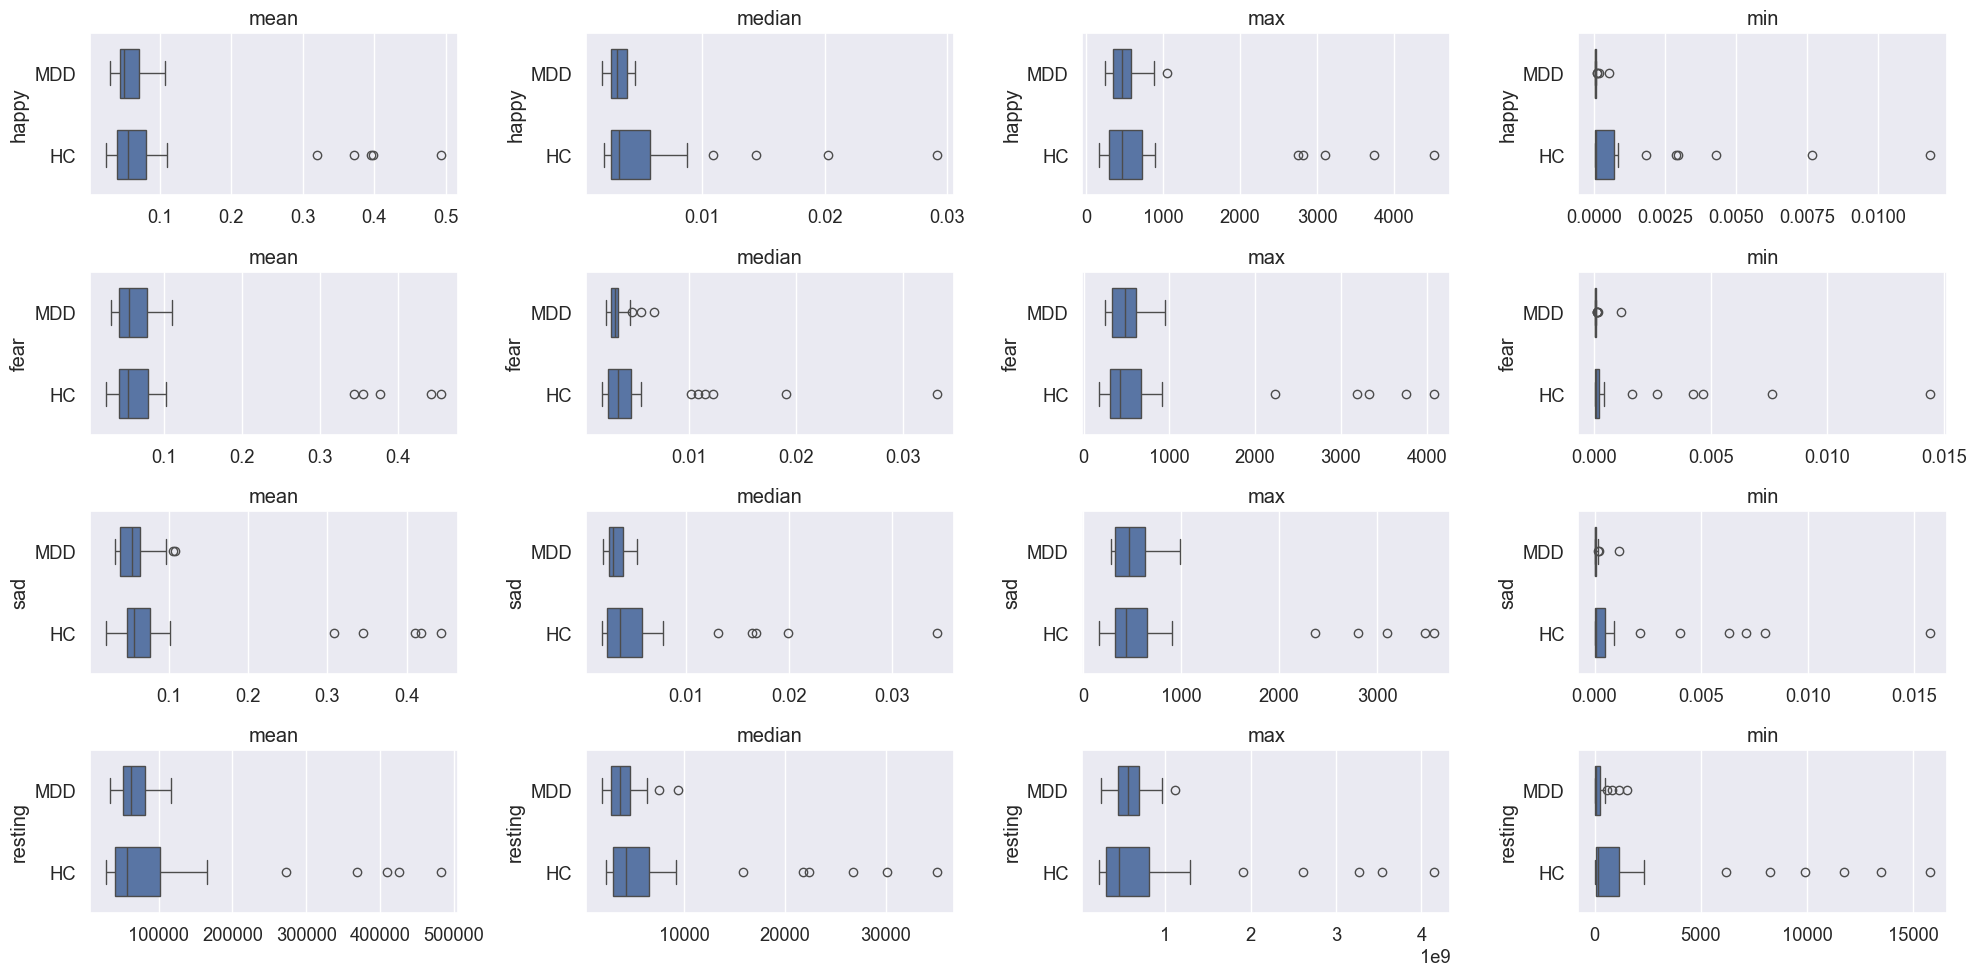

In [18]:
fig = plt.figure(figsize=(20, 10))
a = dict()
i = 0
for emotion in ['happy', 'fear', 'sad', 'resting']:
    for signal in ['mean', 'median', 'max', 'min']:
        a[i] = fig.add_subplot(4, 4, i+1)
        sns.boxplot(x='lf'+'_'+emotion+'_'+signal,
                    y="type", data=df, width=.6, ax=a[i])
        a[i].set(ylabel=emotion, xlabel='', title=signal)
        i = i + 1
fig.tight_layout()

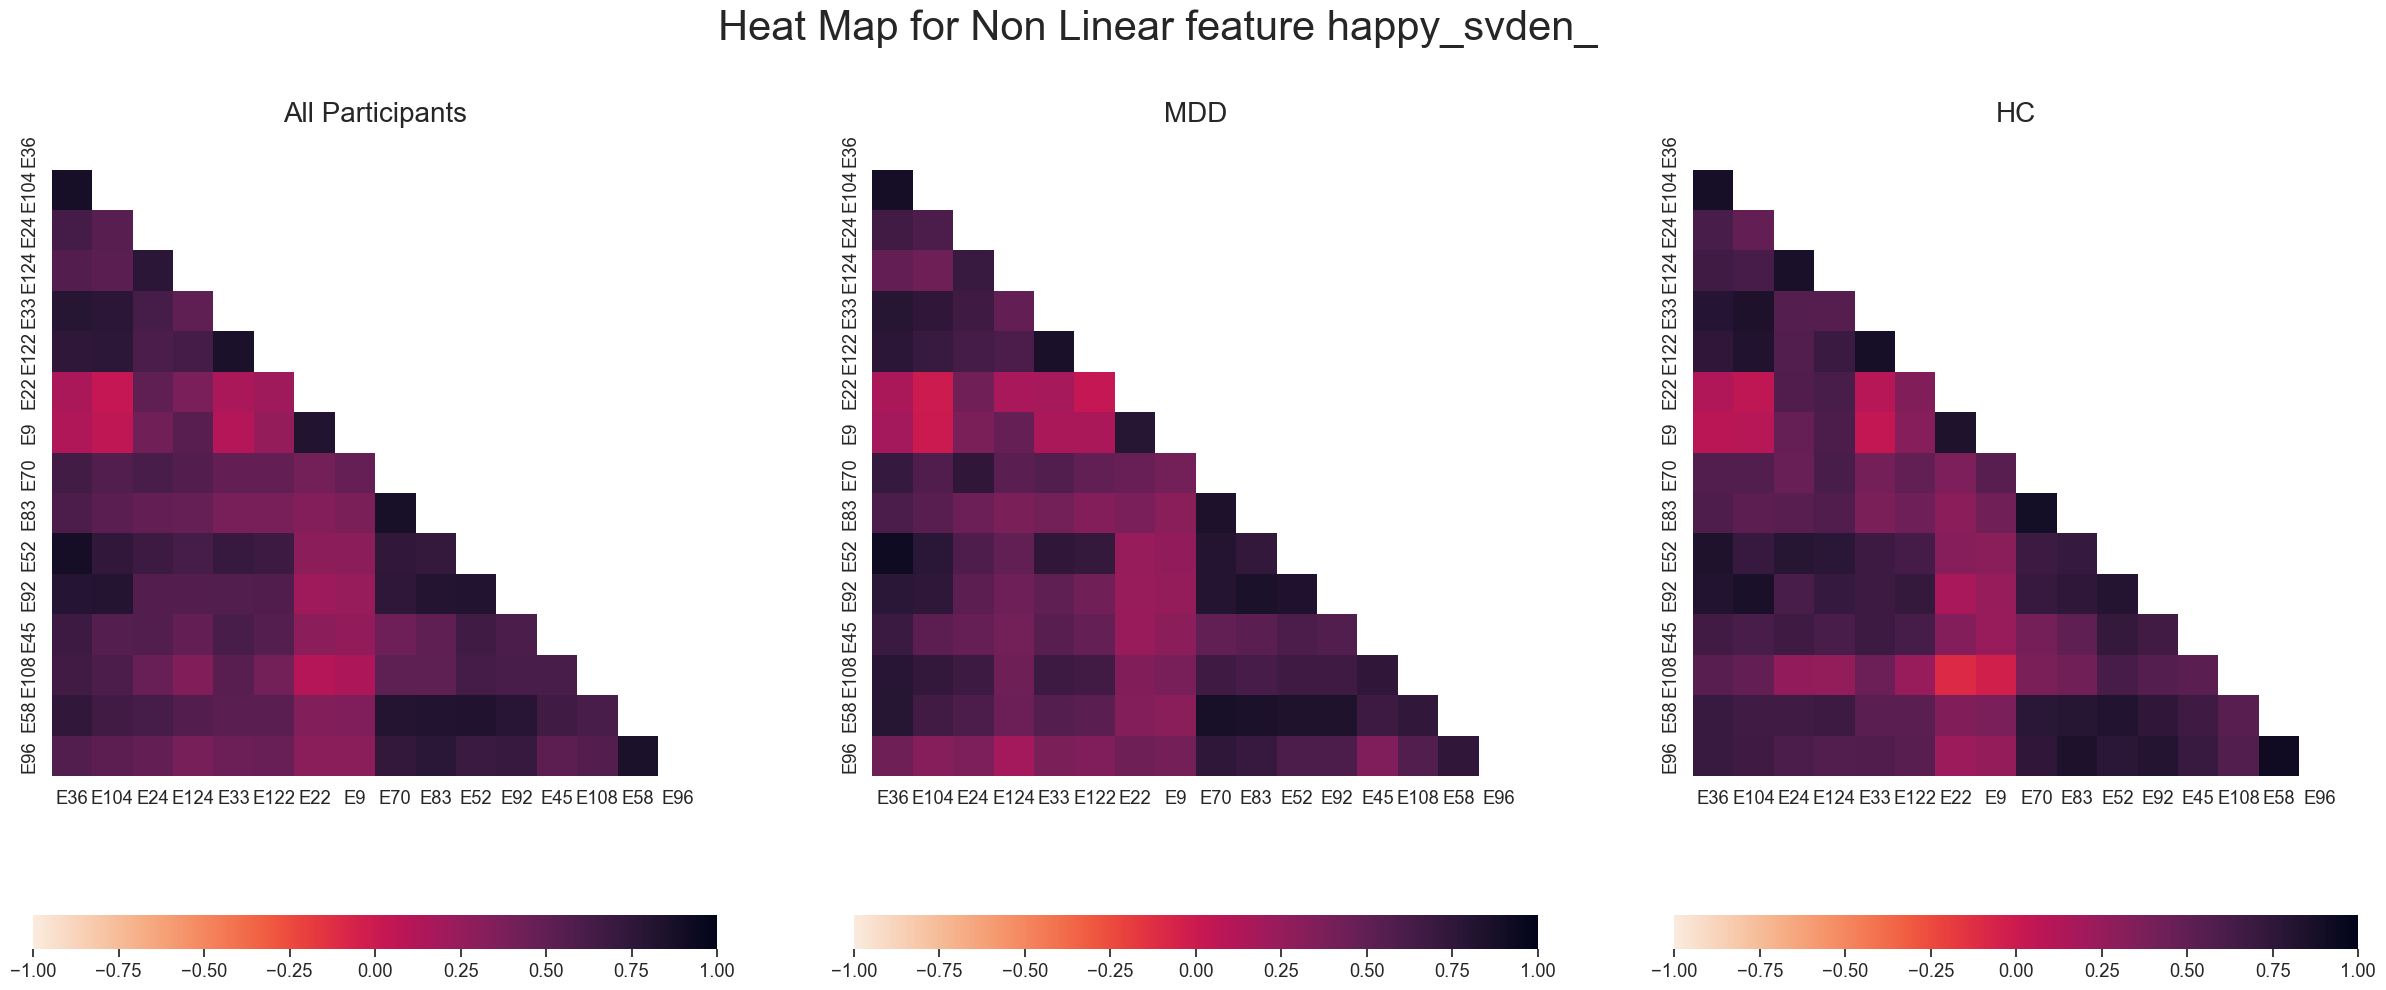

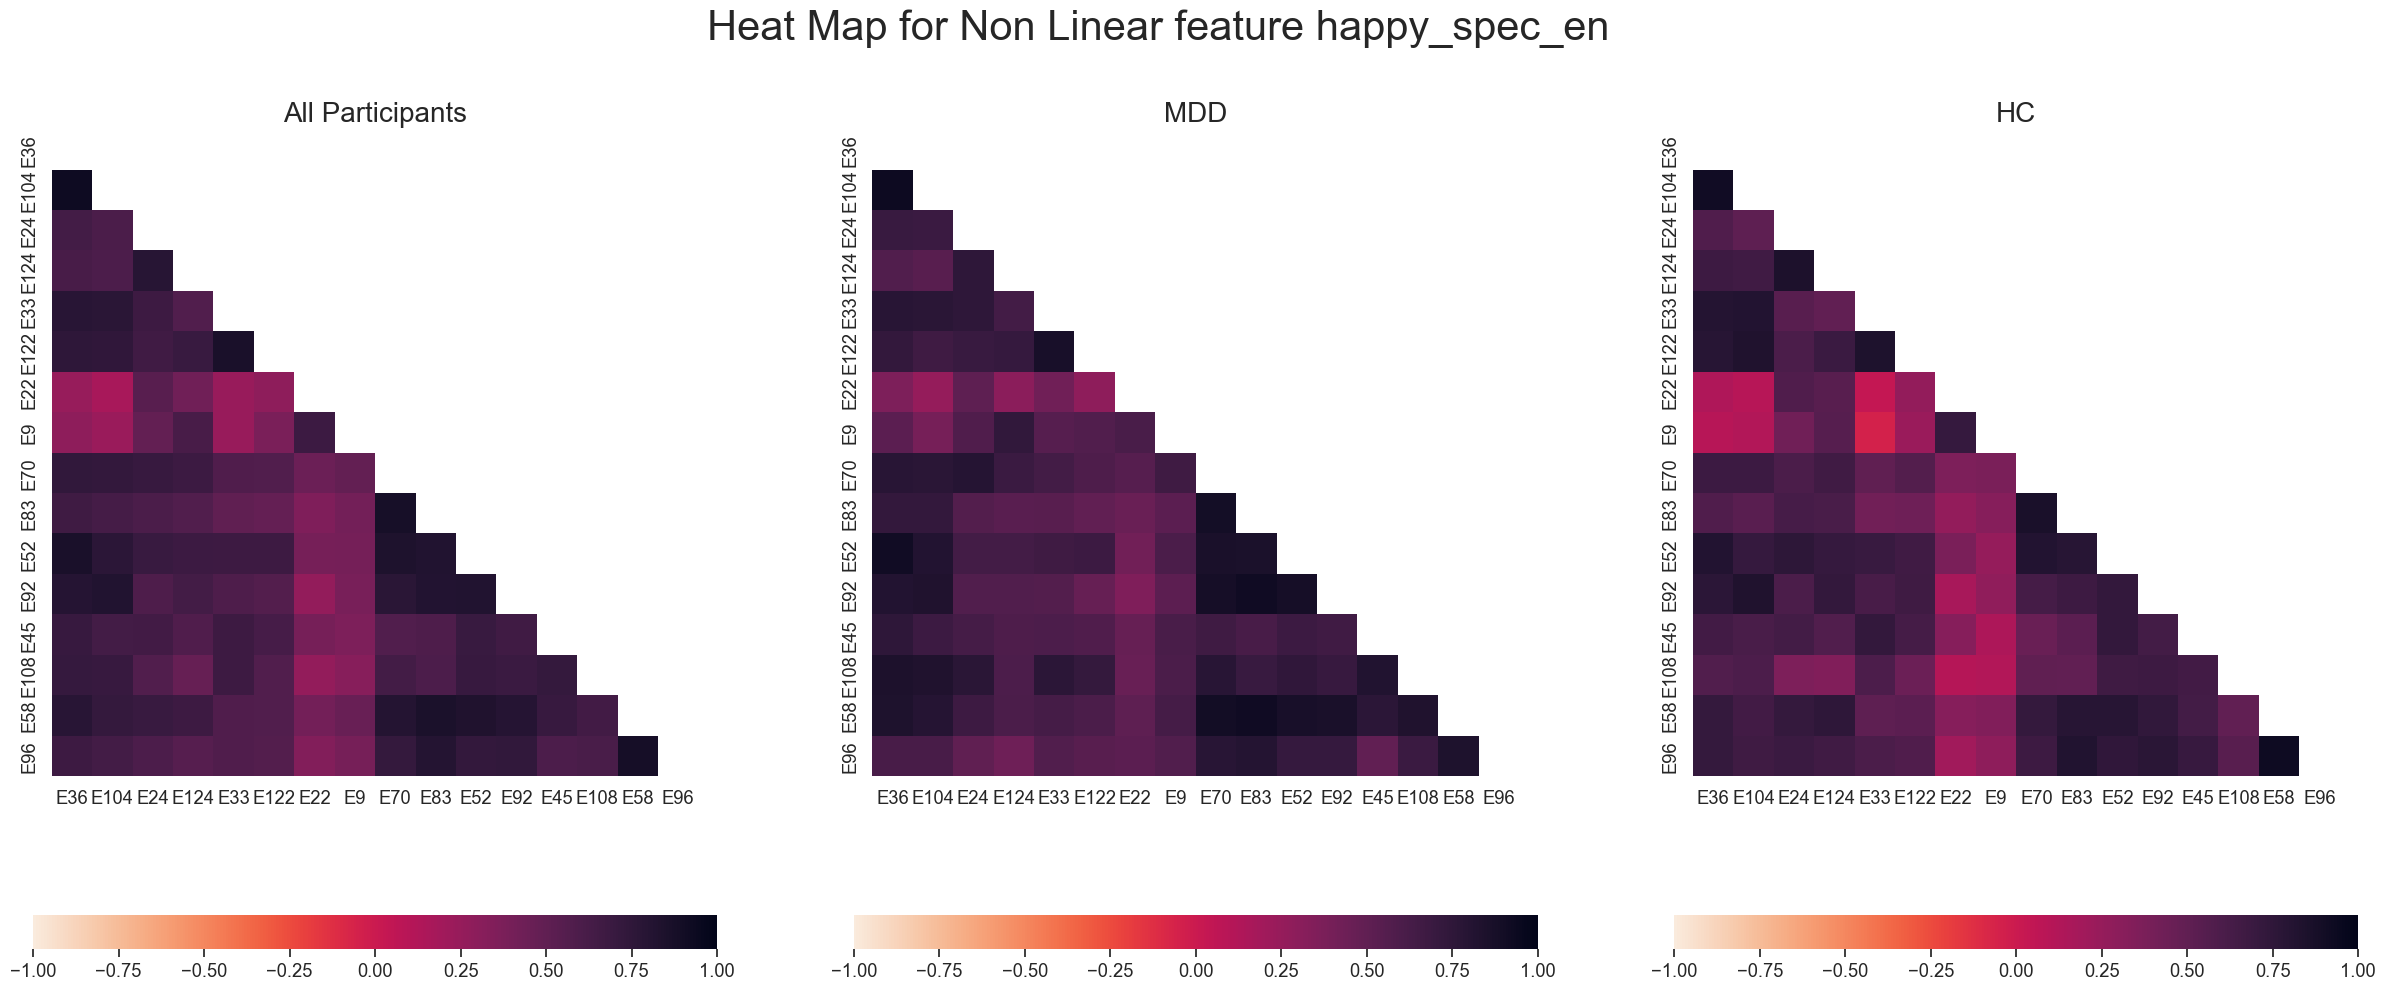

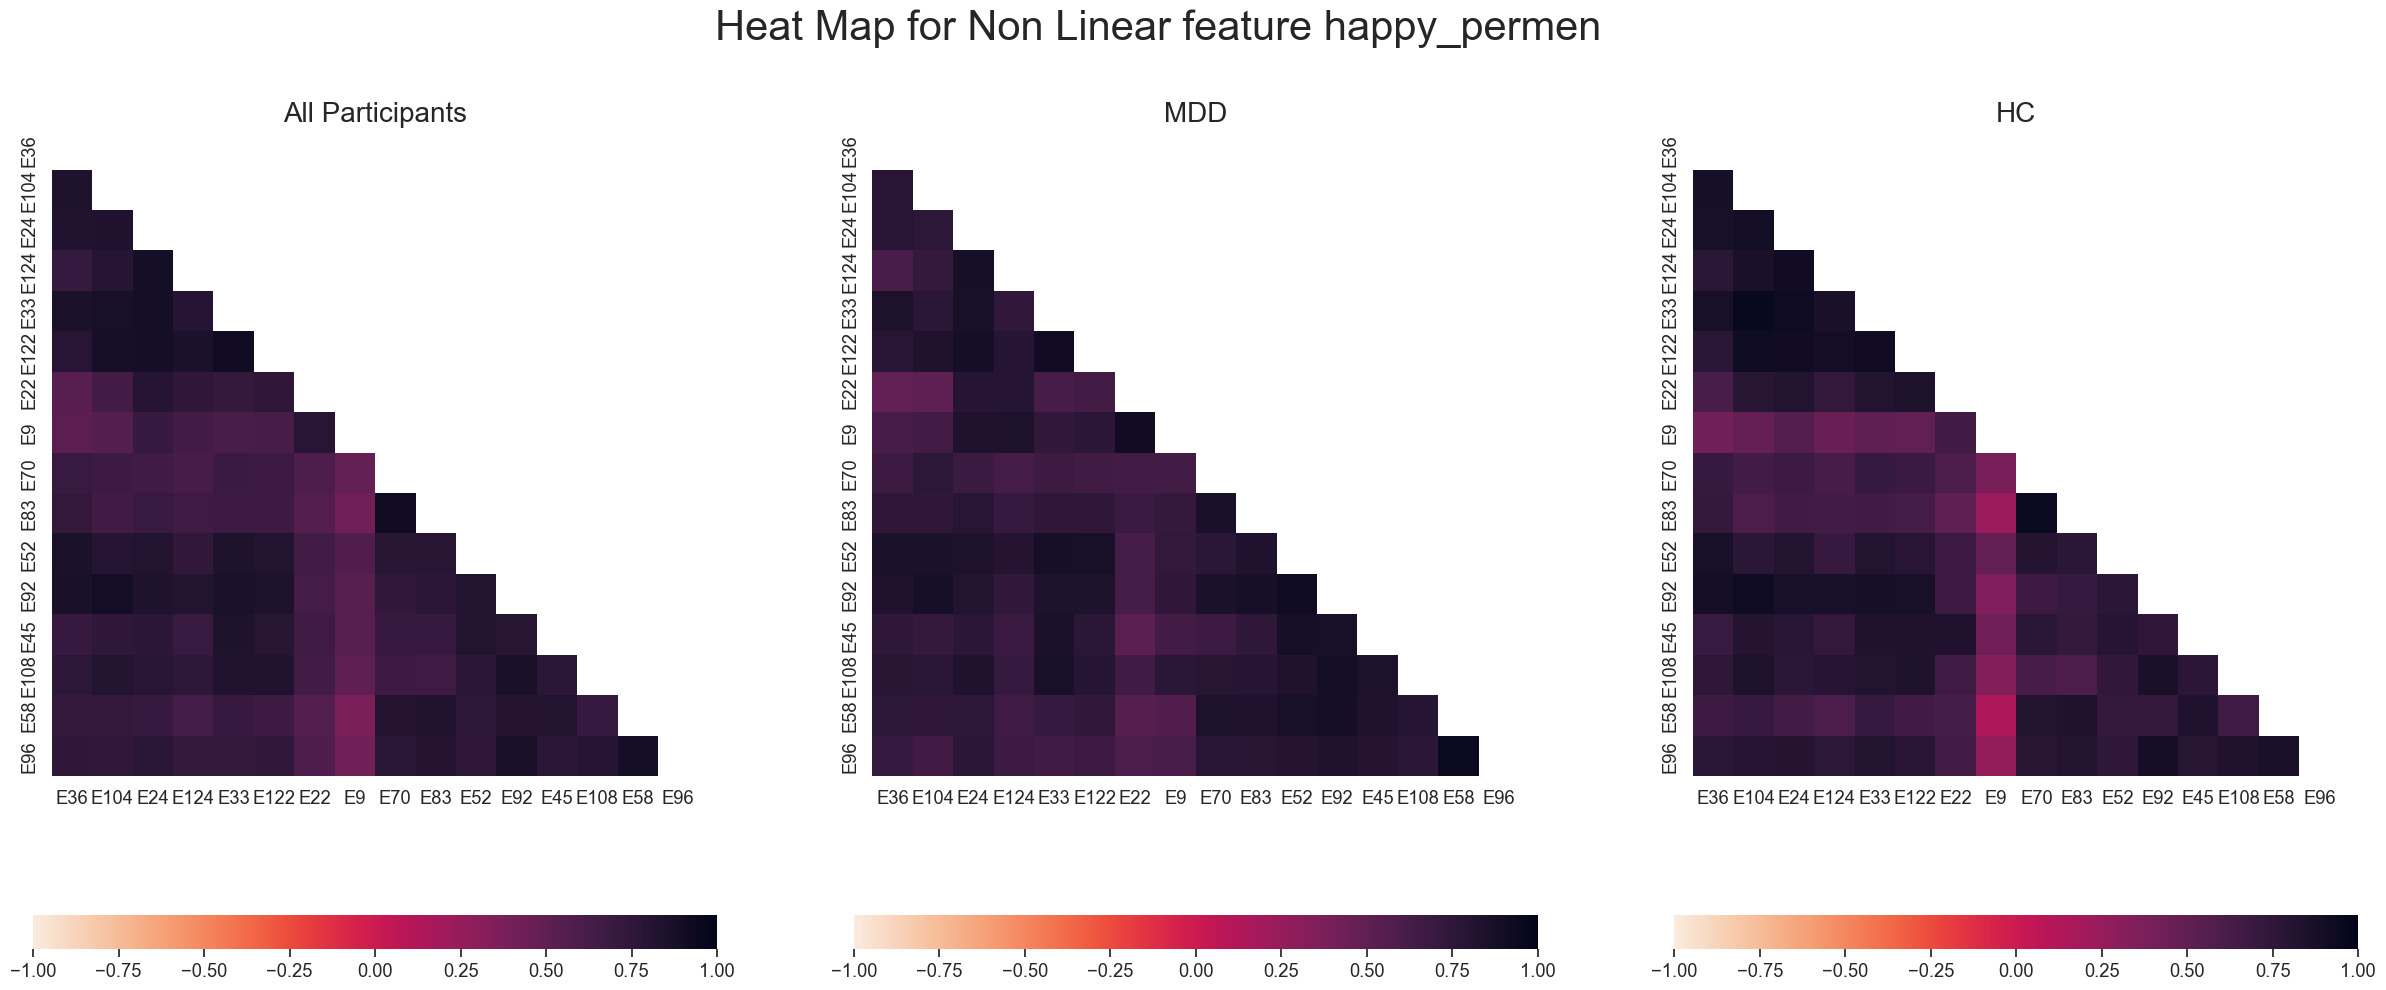

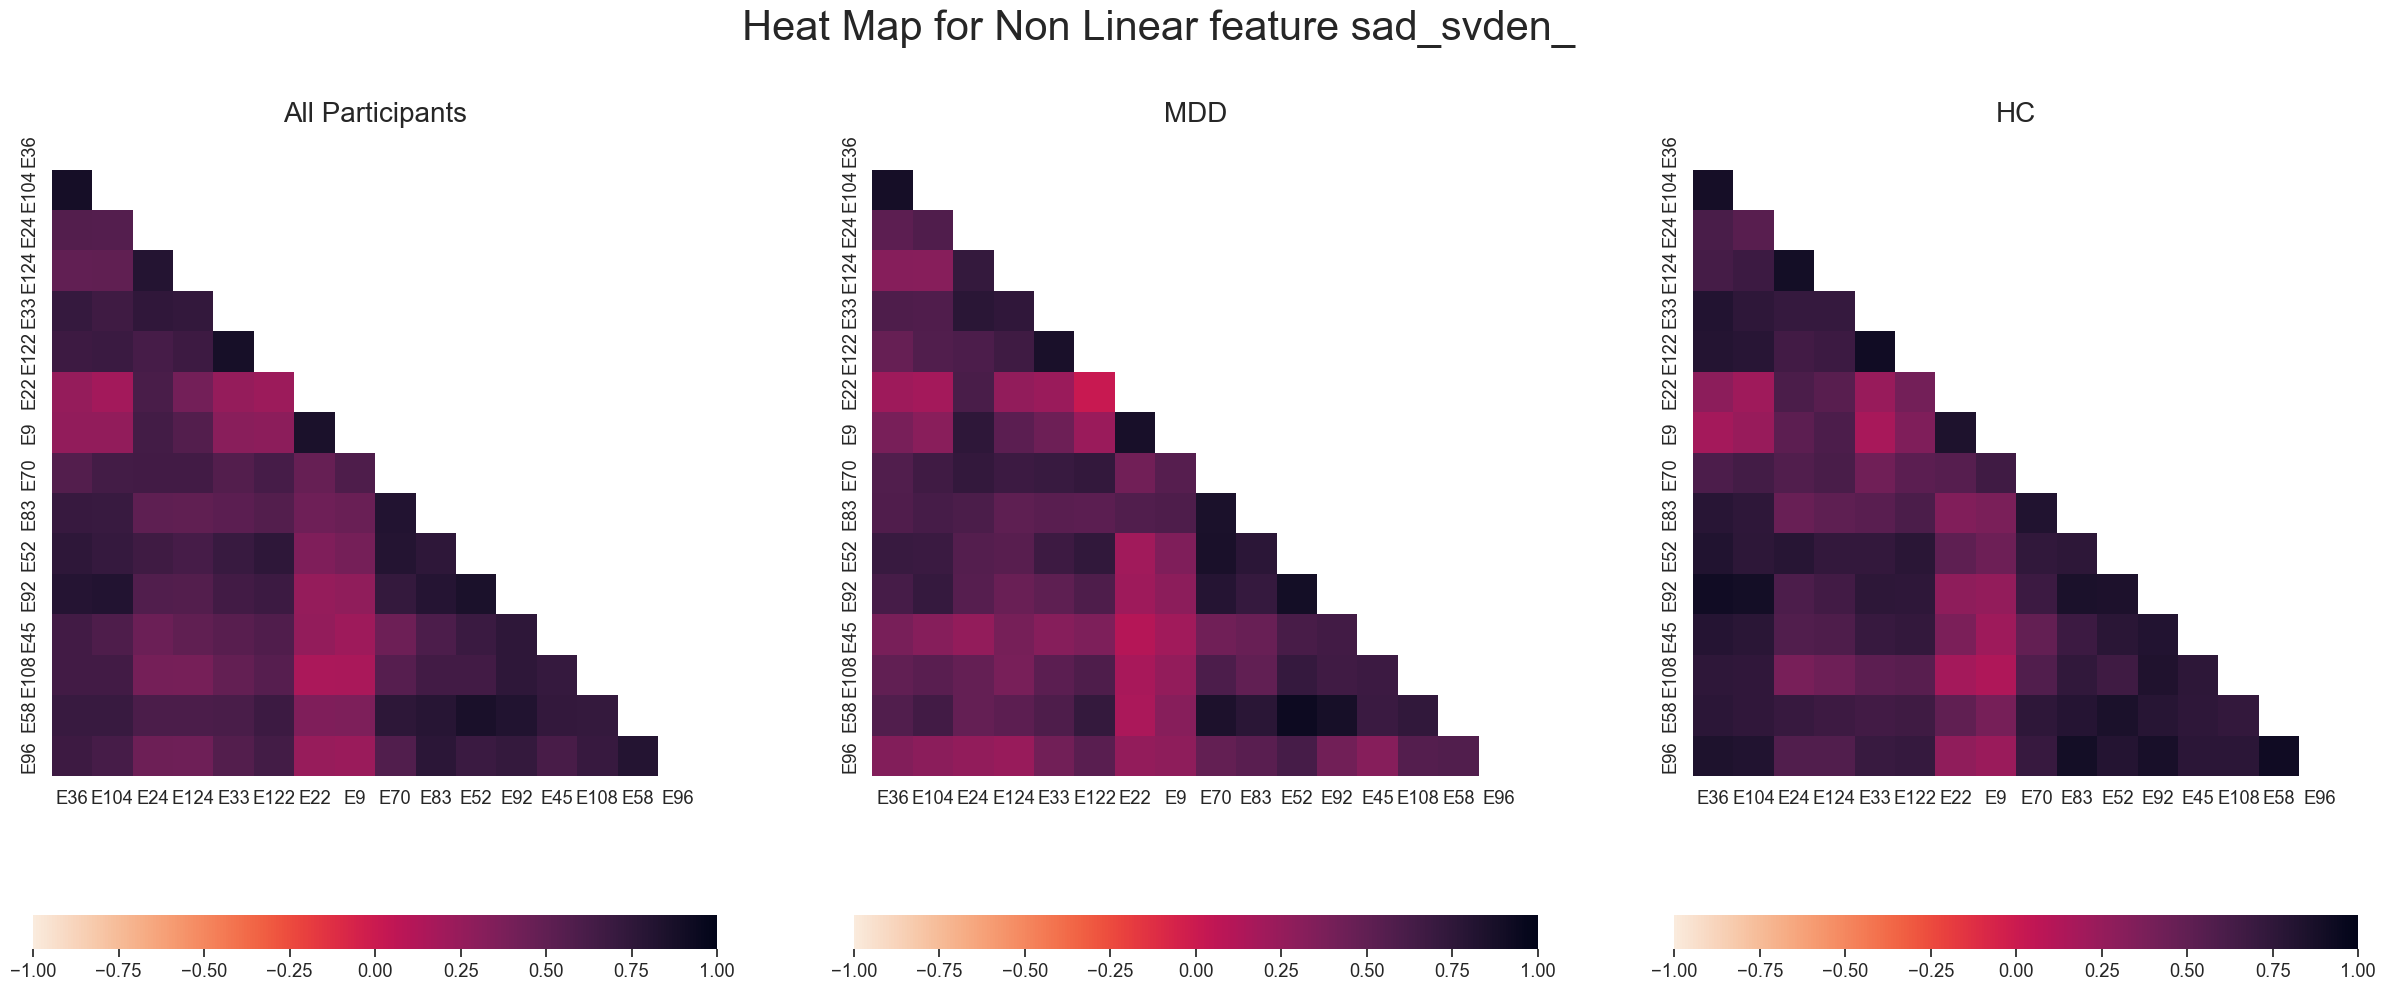

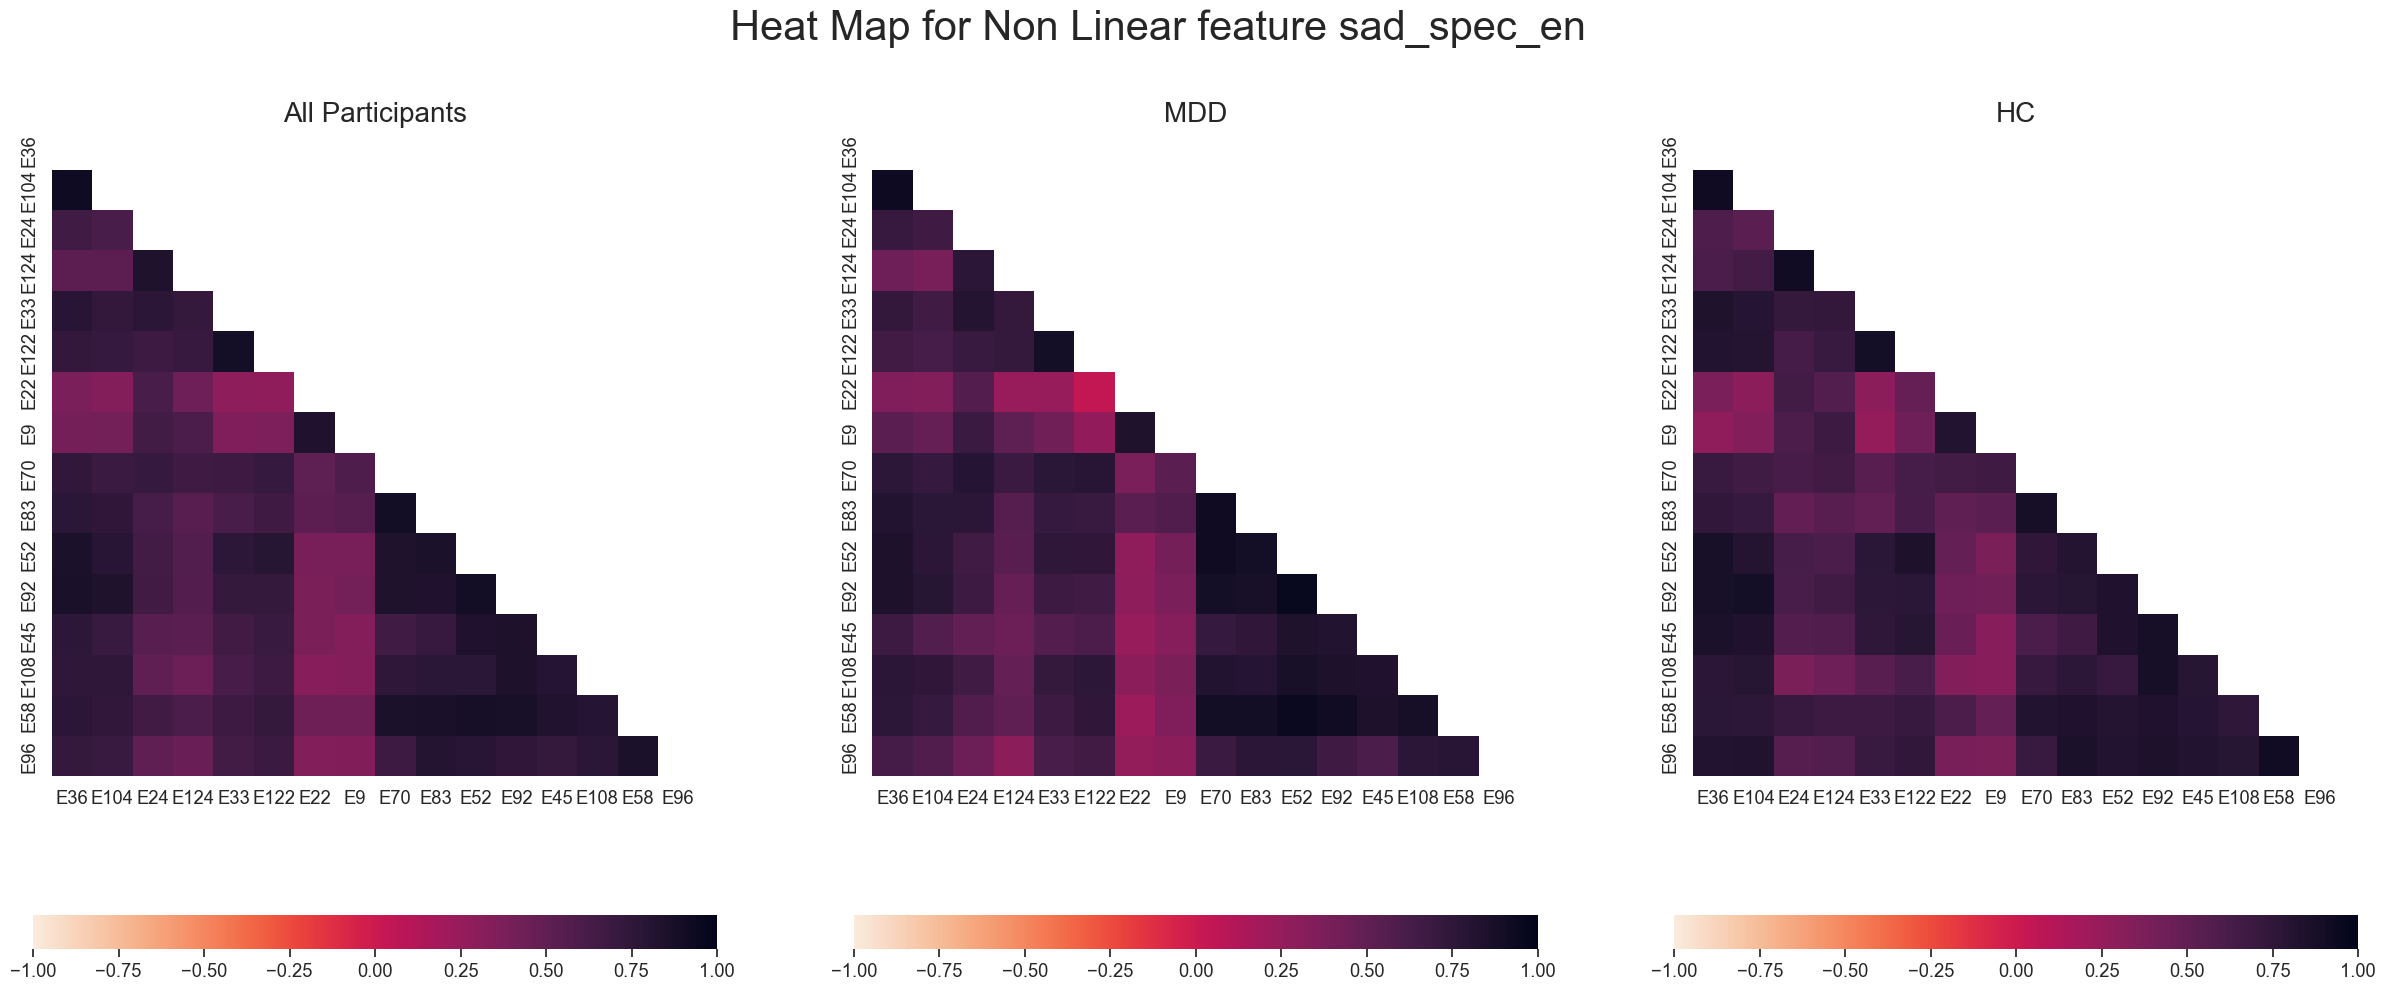

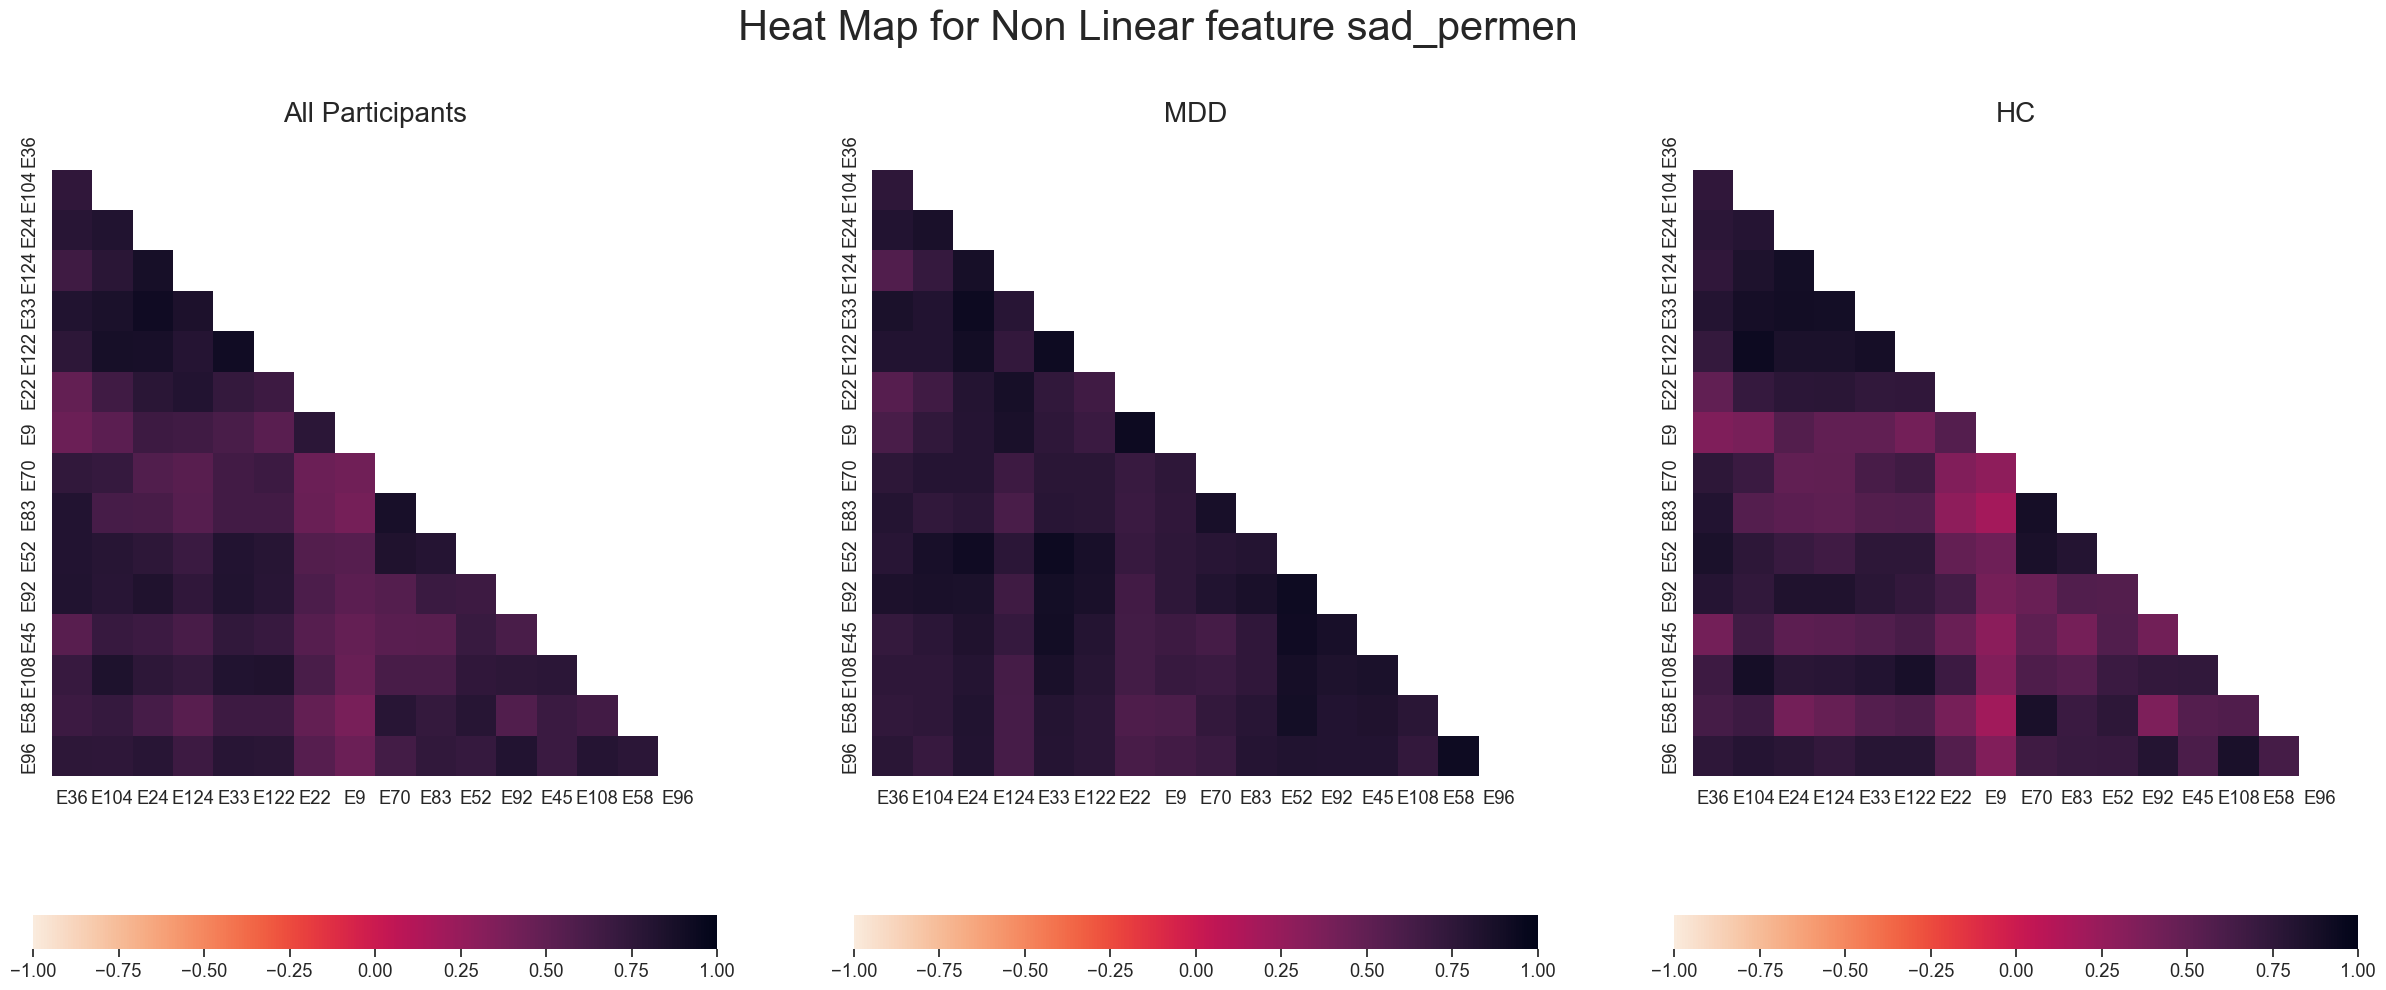

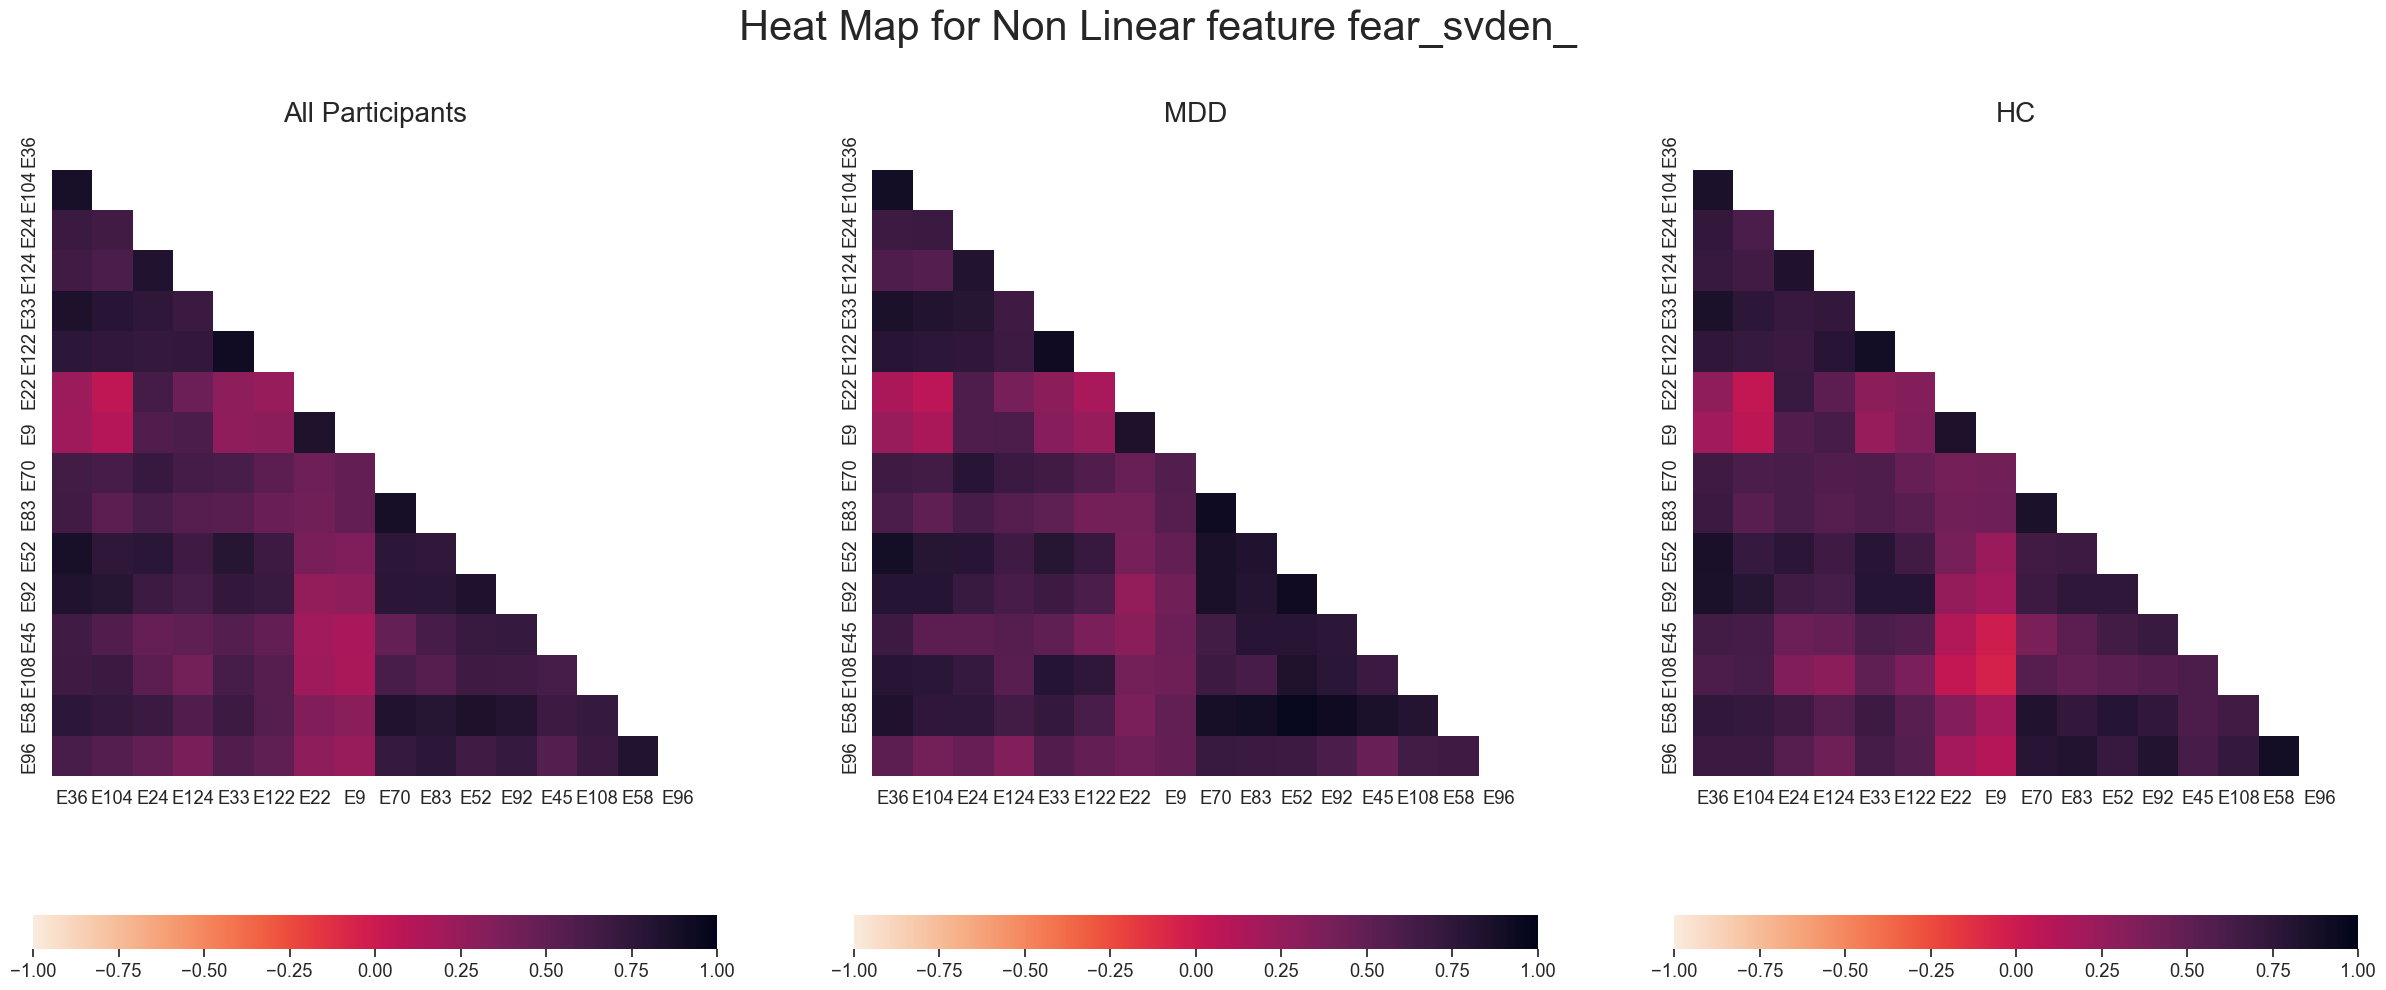

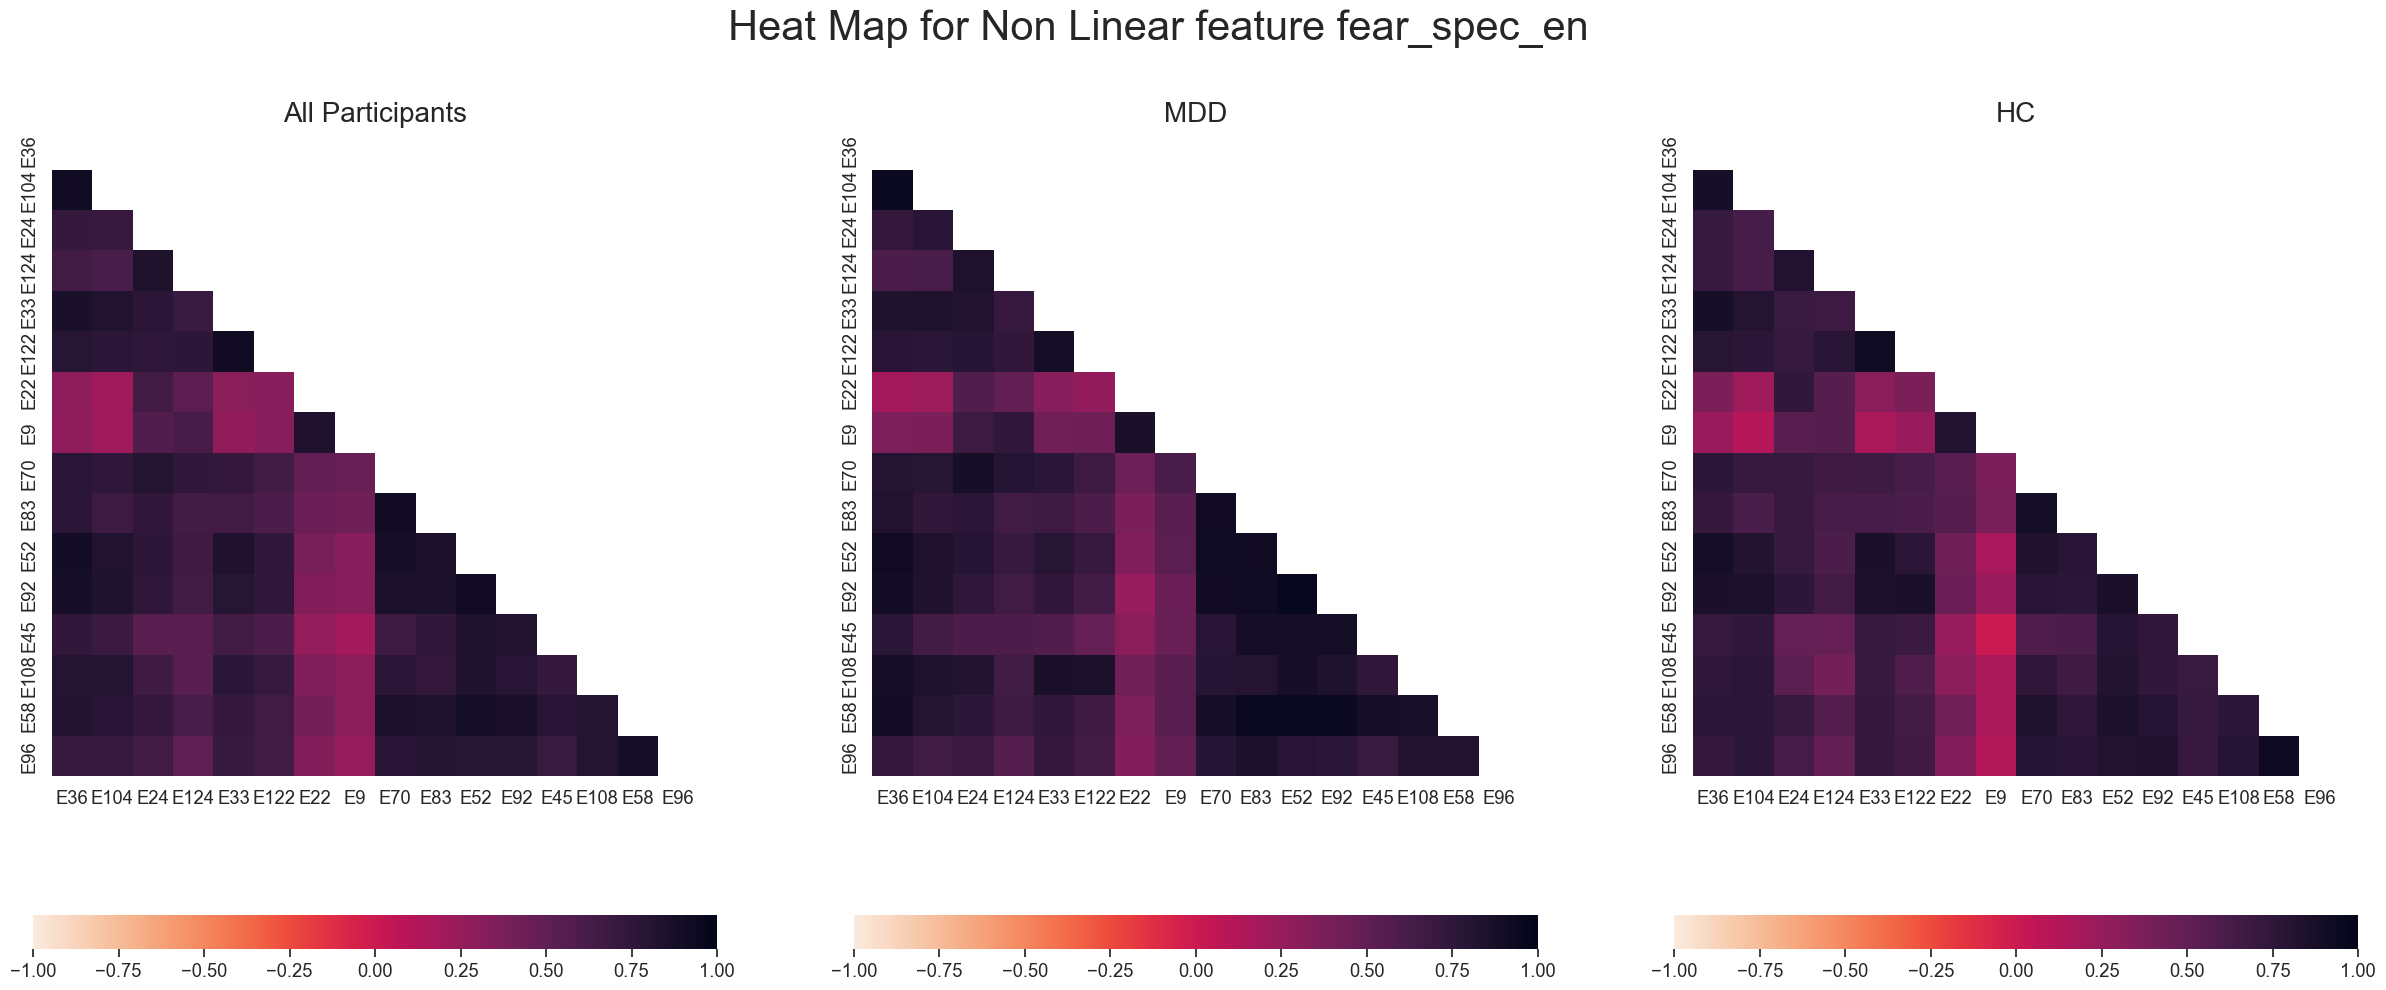

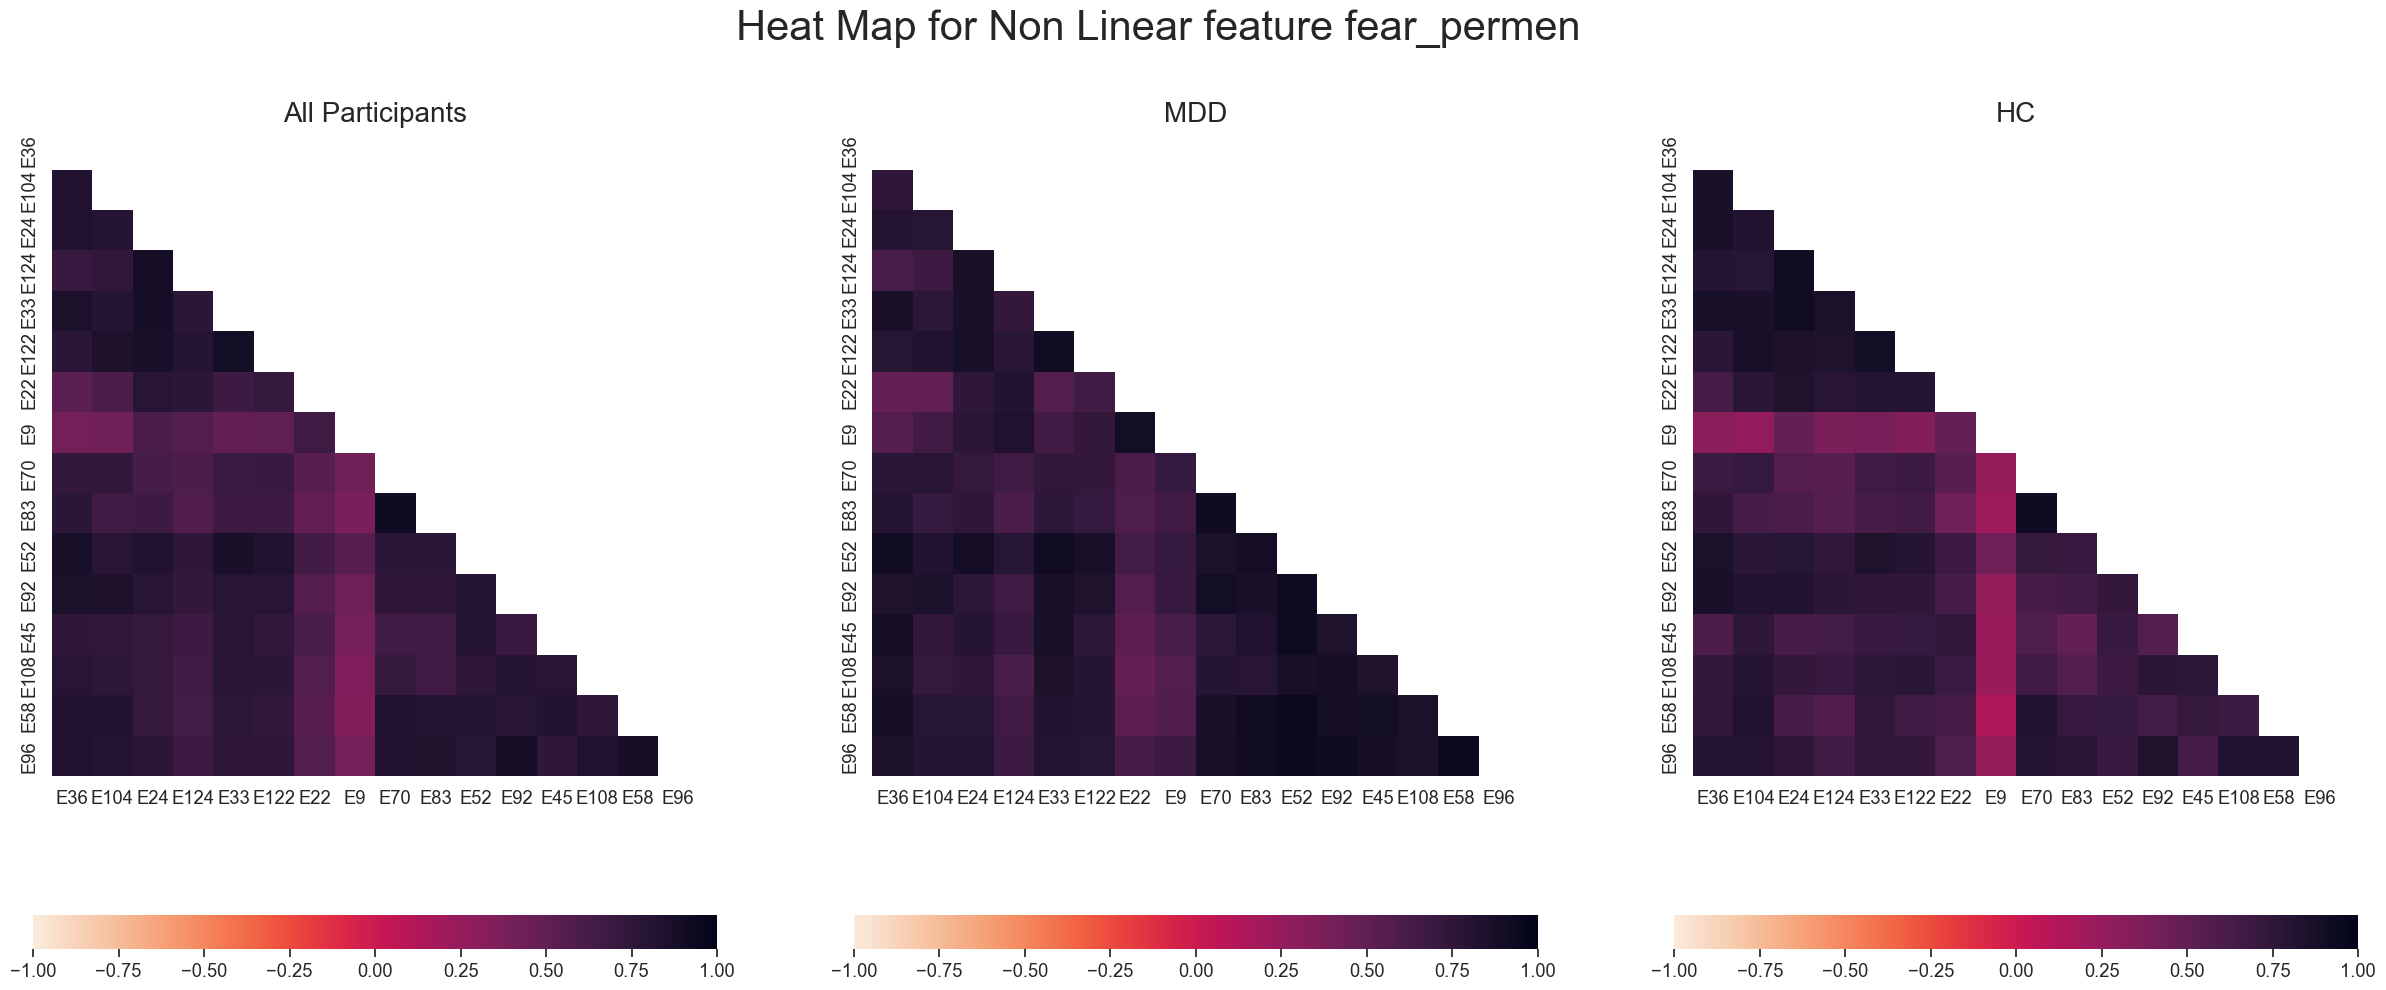

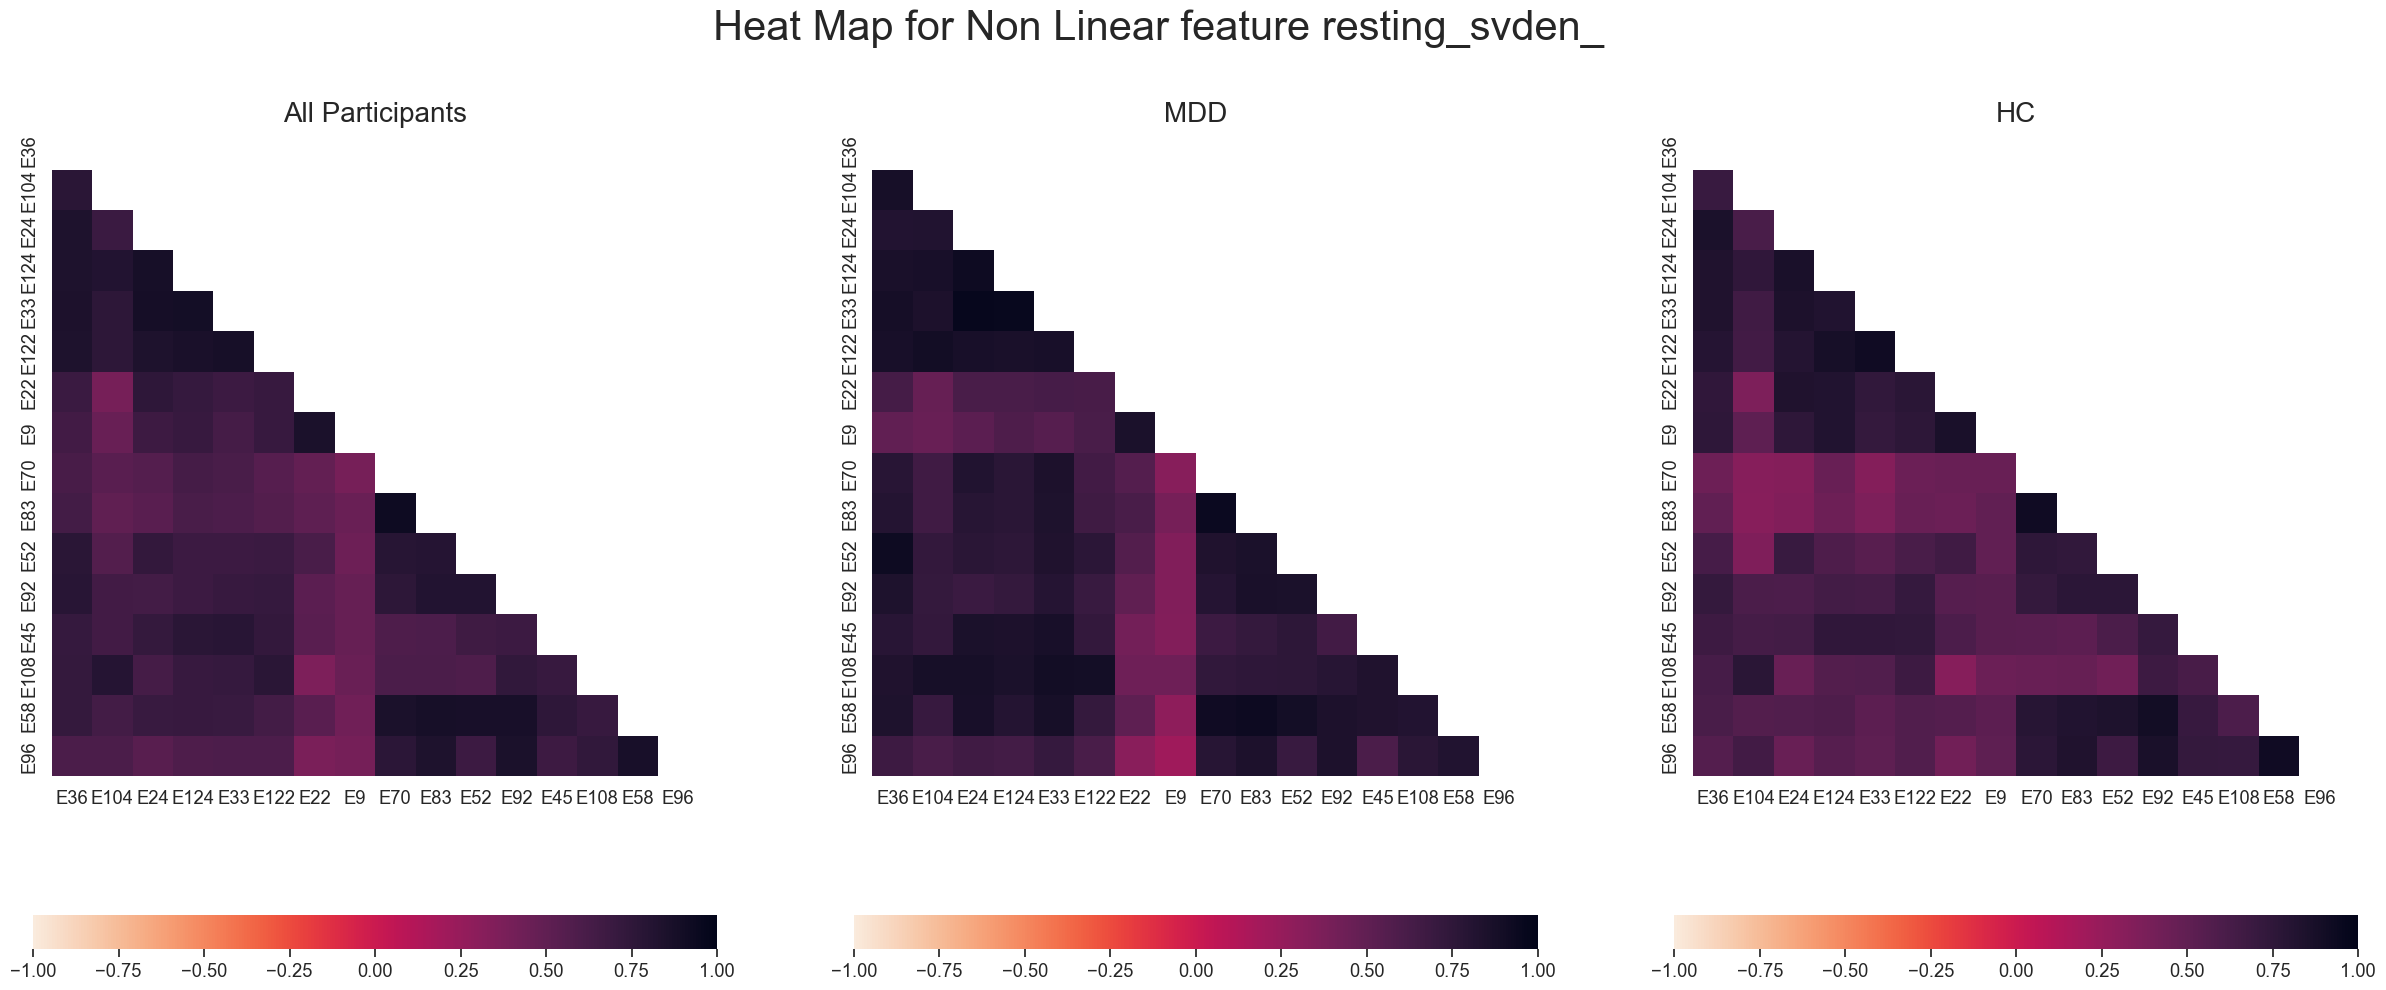

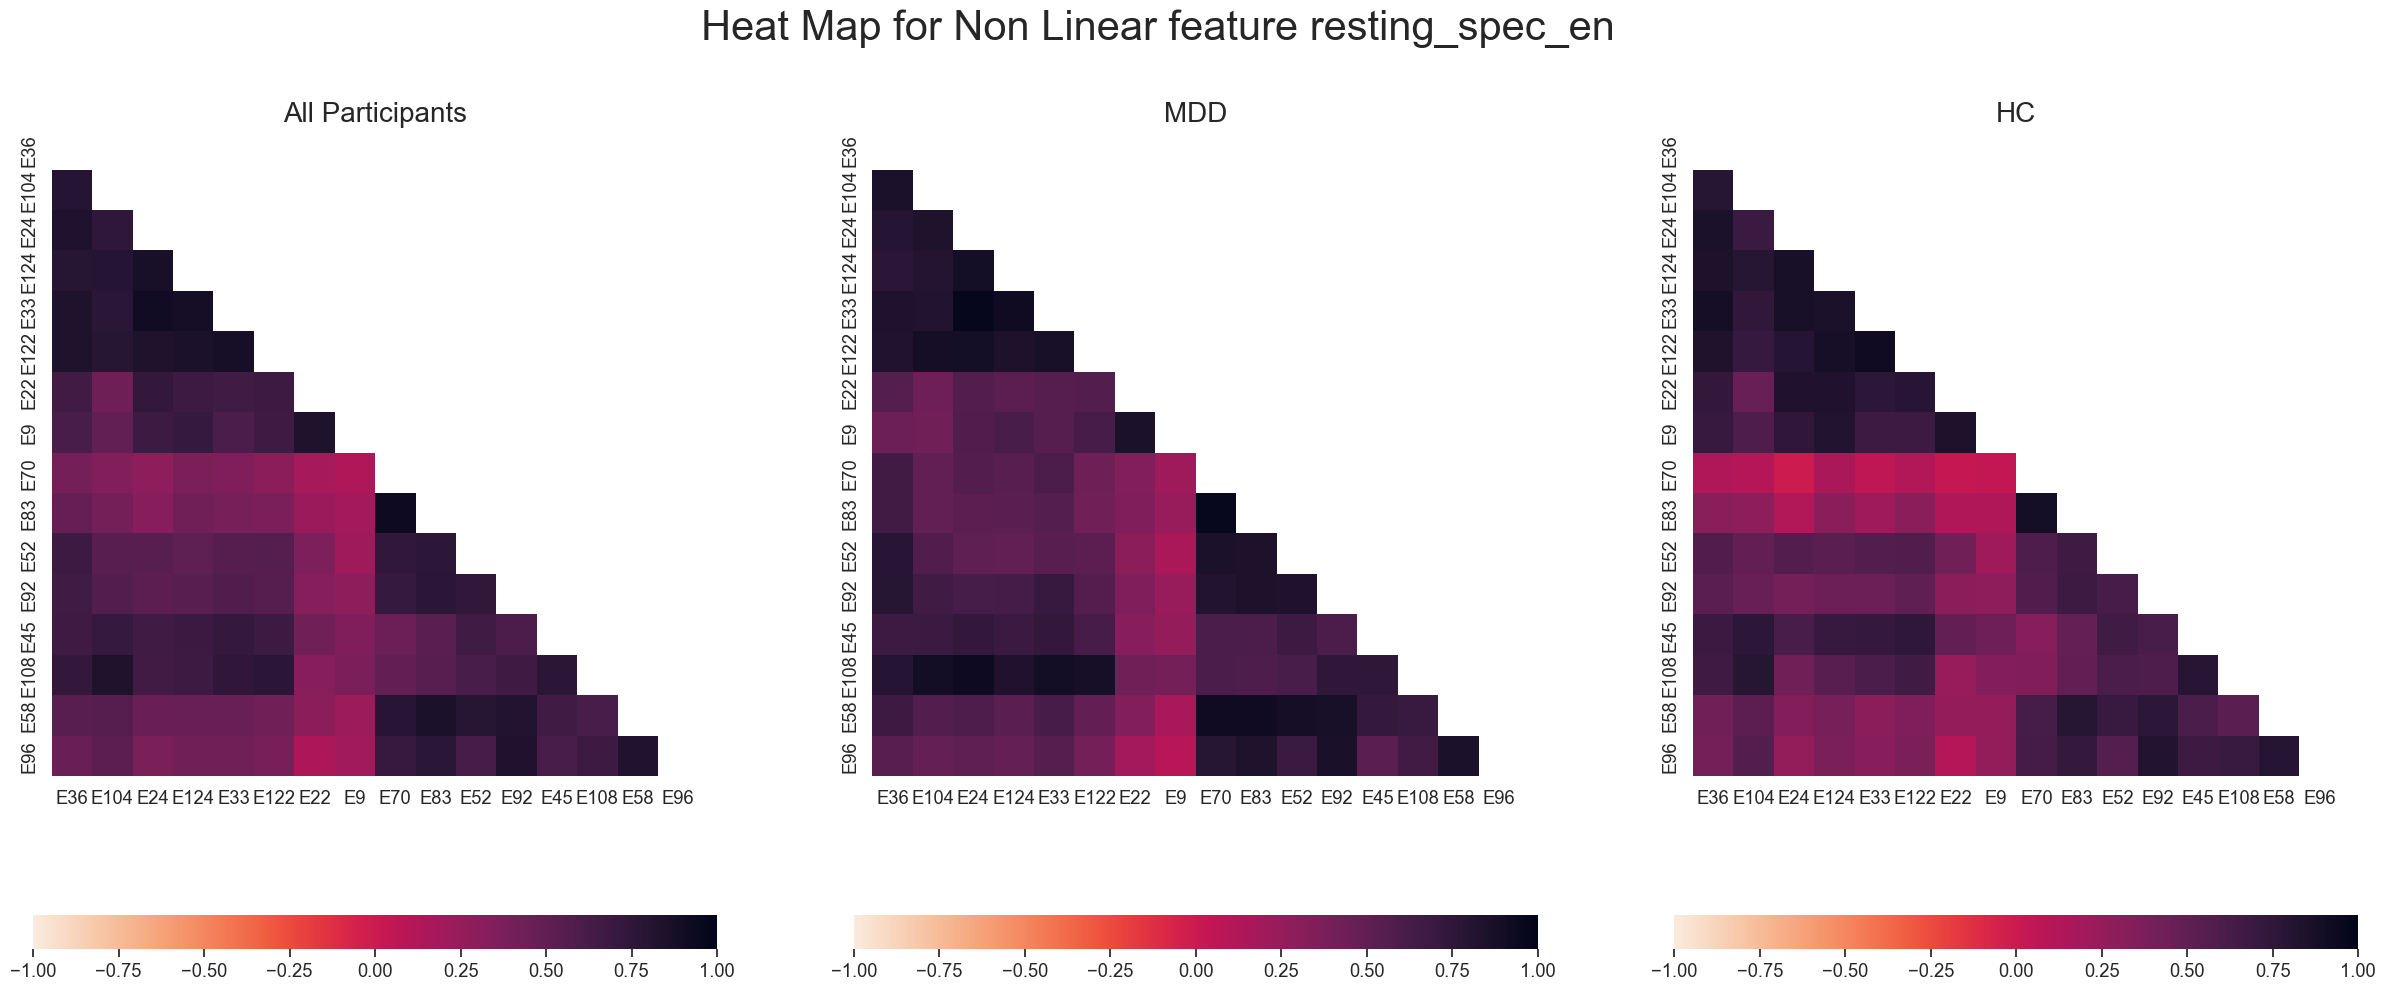

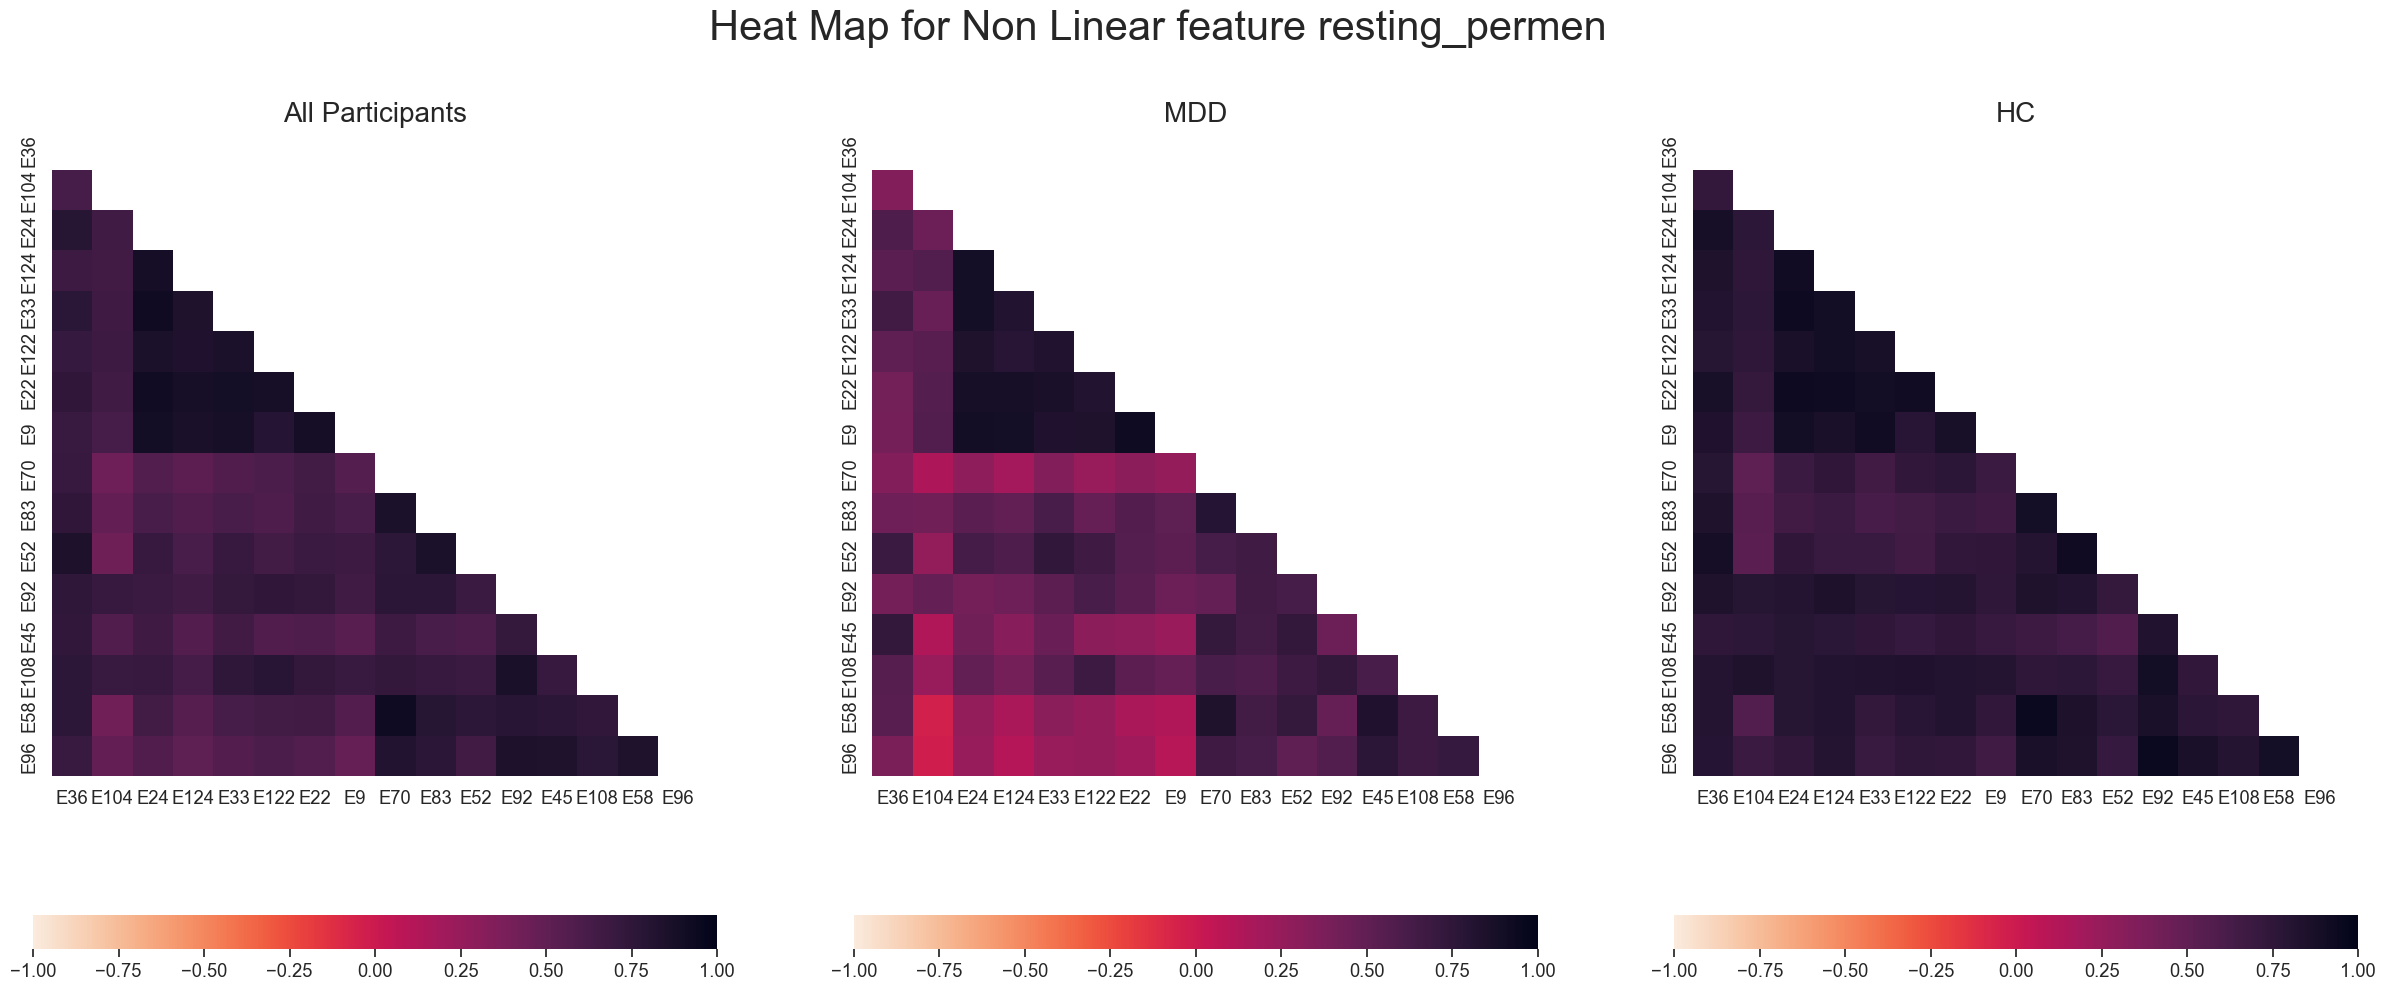

In [19]:
emotion = 'fear'
for emotion in ['happy', 'sad', 'fear', 'resting']:
    for name in ['svden_', 'spec_en', 'permen']:
        temp = columns_extractor(df, emotion, 'nl', name)
        a, b = correlation_builder(
            temp, prefix='Non Linear feature '+emotion+'_'+name)
        temp.drop(columns='type', inplace=True)
        columns_to_keep.extend(
            ['nl_'+name+emotion+'_'+i for i in temp.columns[column_eliminator(a, thr=0.8)]])

In [20]:
len(columns_to_keep)

330

In [21]:
# General clean up to flag MDD and HC patients. We also drop Gender column
df.type.replace({'MDD': 1, 'HC': 0}, inplace=True)
df.drop(columns='gender', inplace=True)

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\1261272453.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.type.replace({'MDD': 1, 'HC': 0}, inplace=True)
C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\1261272453.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.type.replace({'M

In [22]:
# Lets divide the data set into test and train. Here we have to create a stratified
# sample to create the train and test datasets. While we can use the native SCIKIT learn
# Test, Train splits, we are going to write a custom code here
sample = df.groupby('type', group_keys=False).apply(
    lambda x: x.sample(round(30*0.7), random_state=42))
left_over = df[~(df.index.isin(list(sample.index)))]

C:\Users\charitra\AppData\Local\Temp\ipykernel_4144\2486757452.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = df.groupby('type', group_keys=False).apply(


In [23]:
# Lets create the variables for test and train
y = sample['type']
X = sample.drop(columns='type')
X_test = left_over.drop(columns='type')
y_test = left_over['type']

In [24]:
# Eliminate columns that have more than 0.8 correlation between them
df_pca = df[columns_to_keep]
# df_pca.drop(columns = 'type',inplace = True)
columns_to_consider = list(
    df_pca.columns[column_eliminator(df_pca.corr(), thr=0.8)])
# columns_to_consider = list(df_pca.columns)

In [25]:
# Final Set of columns for the exercise - Total of 89 columns were used for this exercise
X = X[columns_to_consider]
X_test = X_test[columns_to_consider]

In [26]:
# Before building the PCA, we will first scale the dataset to ensure that
# there are no differences in the possible range of values
scalar = StandardScaler()
X_scale = scalar.fit(X).transform(X)
X_scale_test = scalar.transform(X_test)

0     0.163145
1     0.284658
2     0.380343
3     0.454172
4     0.519969
5     0.571466
6     0.615967
7     0.654229
8     0.686863
9     0.718444
10    0.746324
Name: explained var ratio, dtype: float64

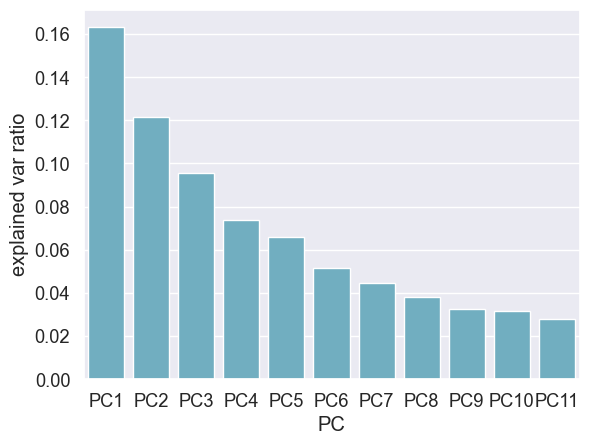

In [27]:
# Let's first design the 11 Prinicipal components
pca = PCA(n_components=11, random_state=42).fit(X_scale)

df = pd.DataFrame({'explained var ratio': pca.explained_variance_ratio_,
                   'PC': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']})
sns.barplot(x='PC', y="explained var ratio", data=df, color="c")
np.cumsum(df['explained var ratio'])

In [28]:
X_PCA_TRAIN = pca.transform(X_scale)
X_PCA_TEST = pca.transform(X_scale_test)

# Classification starts here


In [29]:
def classifier(X, y, X_test, y_test):
    """
    Input:

    X - Training set
    y - Training outcome
    X_test - Test set
    y_test - Test outcome

    Output :
    total - dictionary summarizing performances of various models

    """
    total = dict()
    rf = RandomForestClassifier(random_state=42)
    lr = LogisticRegression(random_state=42)
    knn = KNeighborsClassifier()
    svc = SVC(random_state=42)
    model_array = [rf, lr, knn, svc]
    model_vals = ['Random Forest', 'Logistic Regression',
                  'KNeighbors Classifier', 'SVC']
    i = 0
    for clf in model_array:
        result = dict()
        kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
        cv_results = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')
        clf.fit(X, y)
        y_pred = clf.predict(X_test)
        result['accuracy'] = round(accuracy_score(y_test, y_pred), 2)
        result['precision'] = round(precision_score(y_test, y_pred), 2)
        result['recall'] = round(recall_score(y_test, y_pred), 2)
        total[model_vals[i]] = result
        i = i+1

    return total

In [30]:
pca_result = pd.DataFrame(classifier(X_PCA_TRAIN, y, X_PCA_TEST, y_test))
pca_result['base'] = 'PCA factors'
pca_result['emotion'] = 'all'

In [31]:
final = pca_result.reset_index()

In [32]:
Vals = list(X.columns)

In [33]:
for emotion in ['fear', 'sad', 'happy', 'resting', 'erp', 'all']:
    for type_vars in ['nl', 'lf', 'all']:
        if emotion == 'erp':
            indices_to_keep = [i for i in range(
                len(Vals)) if type_vars in Vals[i] and 'resting' not in Vals[i]]
            if type_vars == 'all':
                indices_to_keep = [i for i in range(
                    len(Vals)) if 'resting' not in Vals[i]]
        elif emotion == 'all':
            indices_to_keep = [i for i in range(
                len(Vals)) if type_vars in Vals[i]]
            if type_vars == 'all':
                indices_to_keep = [i for i in range(len(Vals))]
        else:
            indices_to_keep = [i for i in range(
                len(Vals)) if type_vars in Vals[i] and emotion in Vals[i]]
            if type_vars == 'all':
                indices_to_keep = [i for i in range(
                    len(Vals)) if emotion in Vals[i]]

        temp = classifier(X_scale[:, indices_to_keep],
                          y, X_scale_test[:, indices_to_keep], y_test)
        temp['base'] = type_vars
        temp['emotion'] = emotion
        final = pd.concat([final, pd.DataFrame(temp).reset_index()], axis=0)
        print(temp)

{'Random Forest': {'accuracy': 0.36, 'precision': 0.25, 'recall': 0.67}, 'Logistic Regression': {'accuracy': 0.45, 'precision': 0.2, 'recall': 0.33}, 'KNeighbors Classifier': {'accuracy': 0.55, 'precision': 0.25, 'recall': 0.33}, 'SVC': {'accuracy': 0.73, 'precision': 0.5, 'recall': 0.33}, 'base': 'nl', 'emotion': 'fear'}
{'Random Forest': {'accuracy': 0.64, 'precision': 0.4, 'recall': 0.67}, 'Logistic Regression': {'accuracy': 0.45, 'precision': 0.29, 'recall': 0.67}, 'KNeighbors Classifier': {'accuracy': 0.45, 'precision': 0.29, 'recall': 0.67}, 'SVC': {'accuracy': 0.36, 'precision': 0.25, 'recall': 0.67}, 'base': 'lf', 'emotion': 'fear'}
{'Random Forest': {'accuracy': 0.73, 'precision': 0.5, 'recall': 1.0}, 'Logistic Regression': {'accuracy': 0.45, 'precision': 0.29, 'recall': 0.67}, 'KNeighbors Classifier': {'accuracy': 0.64, 'precision': 0.4, 'recall': 0.67}, 'SVC': {'accuracy': 0.36, 'precision': 0.25, 'recall': 0.67}, 'base': 'all', 'emotion': 'fear'}
{'Random Forest': {'accurac

In [34]:
final.to_csv('Results/Model_results.csv')

In [35]:
columns = ['RF', 'LR', 'KNN', 'SVC', 'base']
dict_changer = {'Random Forest': 'RF', 'Logistic Regression': 'LR',
                'KNeighbors Classifier': 'KNN', 'SVC': 'SVC'}
final.rename(columns=dict_changer, inplace=True)

In [36]:
# final['emotion'] = np.where(final['base']=='PCA factors','PCA factors',final['emotion'])
final['base'] = np.where(final['base'] == 'PCA factors', 'all', final['base'])

In [37]:
for i in list(final['emotion'].unique()):
    print(final[(final['index'] == 'accuracy')
          & (final['emotion'] == i)]), print()

      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.55  0.55  0.27  0.45  all     all
0  accuracy  0.27  0.55  0.27  0.36   nl     all
0  accuracy  0.45  0.55  0.55  0.73   lf     all
0  accuracy  0.55  0.64  0.36  0.73  all     all

      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.36  0.45  0.55  0.73   nl    fear
0  accuracy  0.64  0.45  0.45  0.36   lf    fear
0  accuracy  0.73  0.45  0.64  0.36  all    fear

      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.27  0.45  0.55  0.45   nl     sad
0  accuracy  0.73  0.82  0.64  0.45   lf     sad
0  accuracy  0.64  0.73  0.55  0.45  all     sad

      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.64  0.36  0.27  0.27   nl   happy
0  accuracy  0.55  0.55  0.55  0.36   lf   happy
0  accuracy  0.45  0.55  0.36  0.36  all   happy

      index    RF    LR   KNN   SVC base  emotion
0  accuracy  0.27  0.36  0.36  0.27   nl  resting
0  accuracy  0.27  0.64  0.73  0.64   lf  resting
0  accuracy  

In [49]:
def metric_analyzer(df, model='RF', emotion='all', base='all', measure='accuracy'):
    """
    Inputs:
    df - Dataframe to be used
    model - model to be plotted
    emotion - type of emotion needed
    base - type of feature space use
    measure - Are we going to choose Accuracy / Precision / Recall
    Outputs:
    chart object - This will be saved for future reference
    """
    # Filter the resultant data frame
    fig = plt.figure(figsize=(20, 5))
    a = dict()
    text = ['All Features', 'Non Linear Features', 'Linear Features']
    val = 0
    for base in df.base.unique():
        a[val] = fig.add_subplot(1, 3, val+1)
        df_final = df[(df['base'] == base) & (df['index'] == measure)][[
            'emotion', model]].sort_values(model, ascending=False)
        df_final.replace({'PCA factors': 'PCA'}, inplace=True)
        X = df_final.emotion.values
        Y = df_final[model].values
        a[val].bar(X, Y, width=0.4)
        a[val].set_ylim(0, 1)
        a[val].set_title('\n'+text[val])
        a[val].hlines(df_final[df_final['emotion'] == 'all']
                      [model].values[0], 0, 7)
        a[val].text(2, df_final[df_final['emotion'] == 'all'][model].values[0] +
                    0.05, 'Better than Base line\n(All emotions model)', rotation=0)
        # a[val].set_xticks(rotation = 90)
        val = val+1
    fig.suptitle(measure.upper()+' of various feature types (model='+model+')')
    path_to_save = 'Results/Images/Model_'+model+'.png'
    fig.savefig(path_to_save, dpi=100)

In [39]:
final.to_csv('Results/Model_results-2.csv')

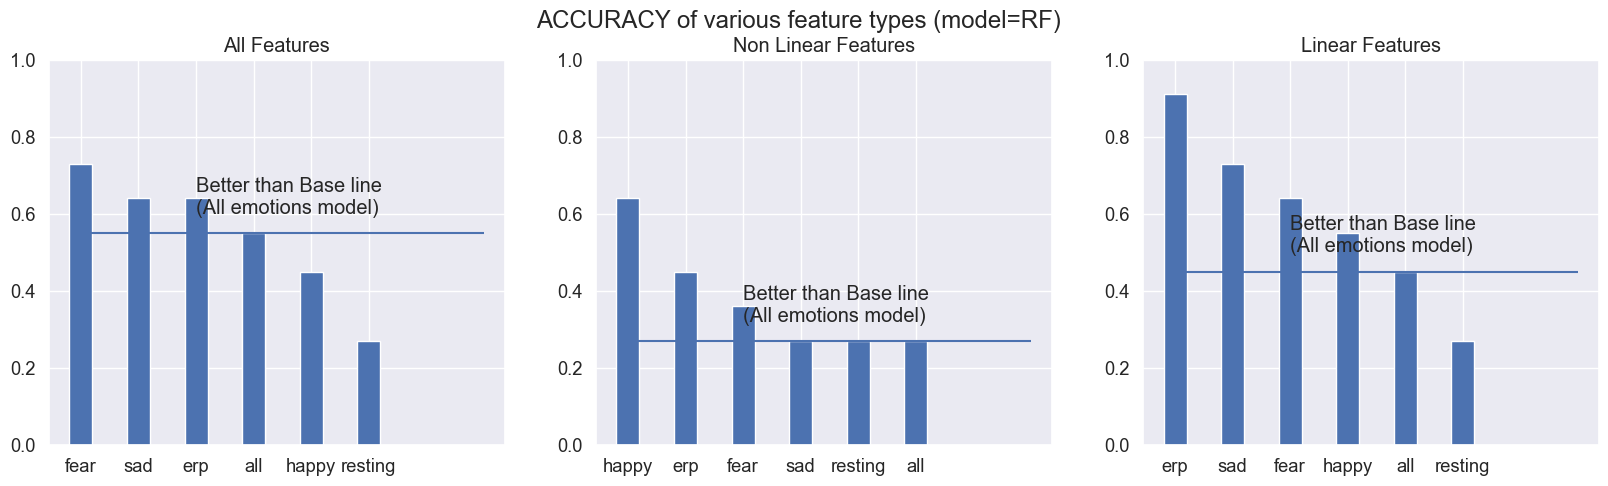

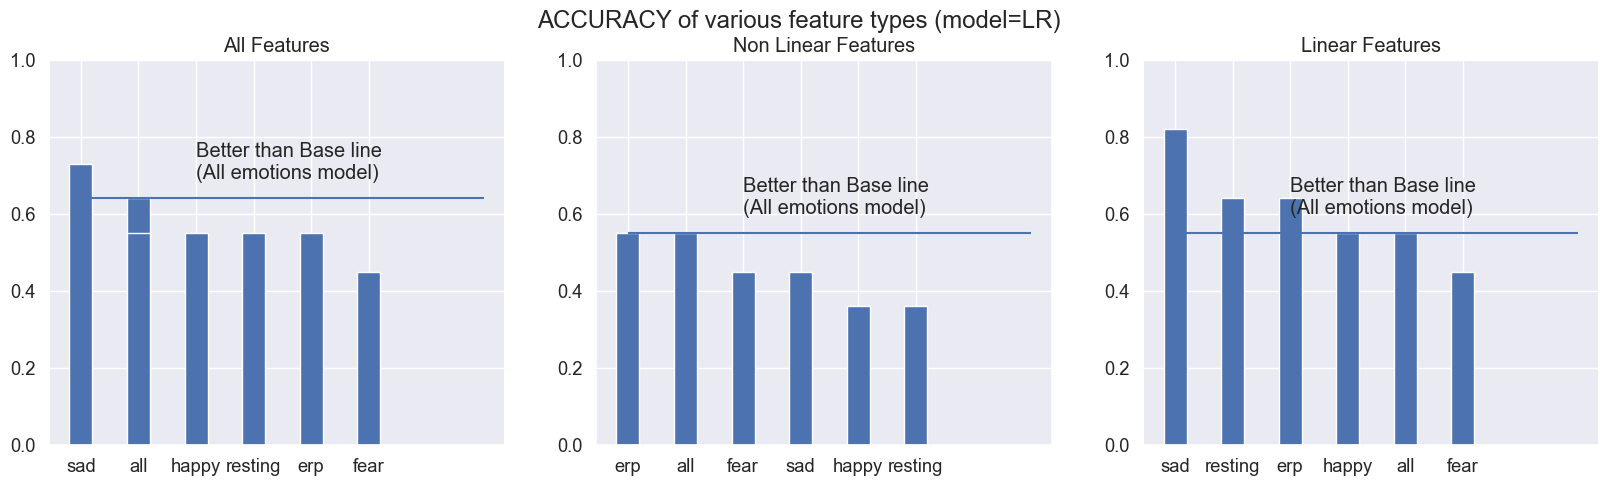

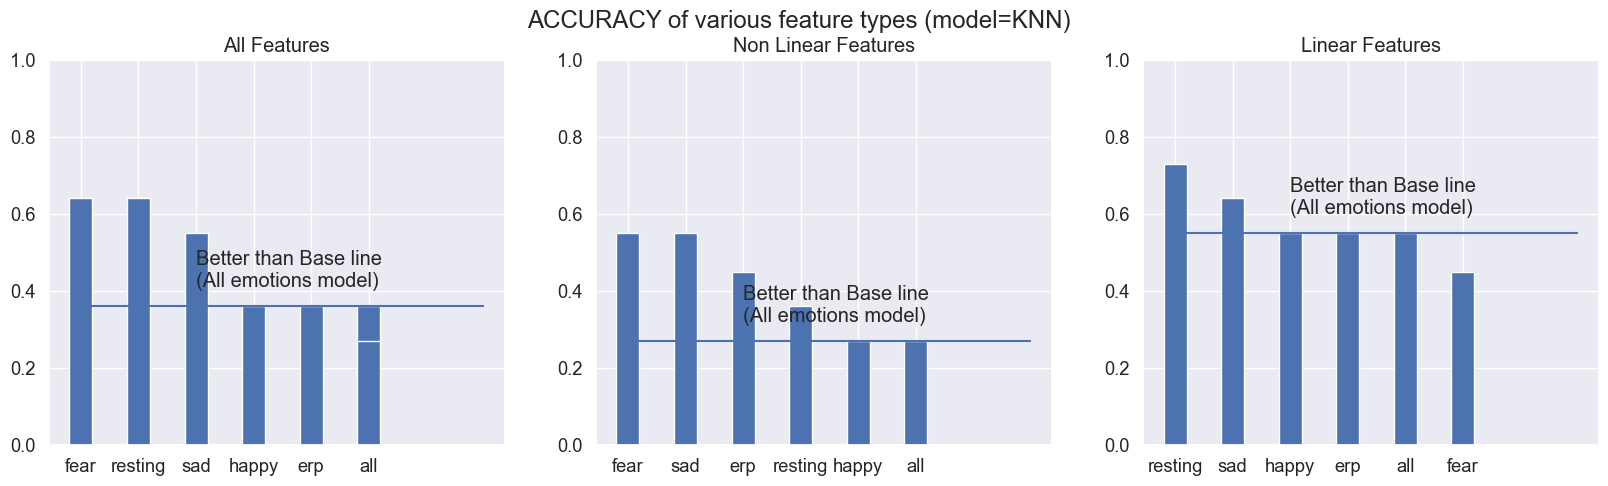

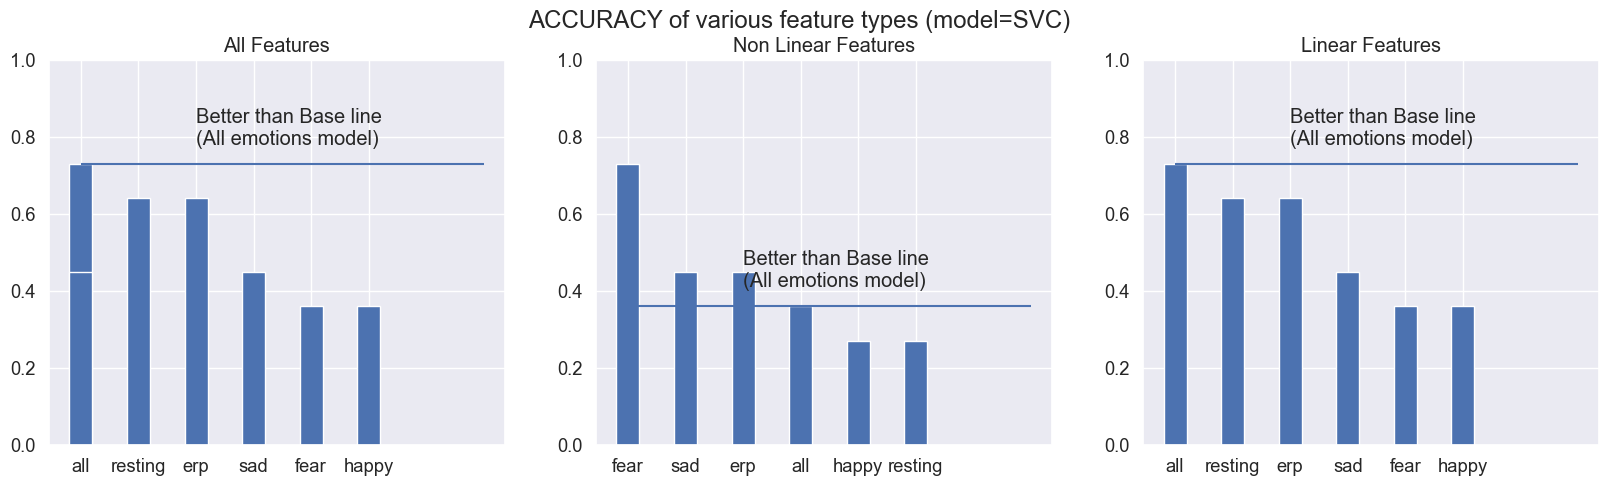

In [50]:
metric_analyzer(final)
metric_analyzer(final, model="LR")
metric_analyzer(final, model="KNN")
metric_analyzer(final, model="SVC")

# Model Interpretation


In [41]:
Electrode_understanding = {
    'Left-Central': 'E36', 'Right-Central': 'E104', 'Front-Left': 'E24', 'Front-Right': 'E124',
    'Front-Far left': 'E33', 'Front-Far Right': 'E122',
    'Forehead (above left eye)': 'E22', 'Forehead (above Right eye)': 'E9',
    'Back-left to Center': 'E70', 'Back-Right to Center': 'E83', 'Back-Above E70': 'E52',
    'Back-Above E83': 'E92', 'Side Left': 'E45', 'Side Right': 'E108', 'Left': 'E58', 'Right': 'E96'}

Electrode_understanding = dict((v, k)
                               for k, v in Electrode_understanding.items())

In [42]:
array_vals = ['lf_min_fear_E122', 'lf_median_fear_E45', 'lf_median_fear_E9',
              'lf_median_fear_E122', 'lf_min_fear_E83', 'lf_min_fear_E45',
              'lf_median_fear_E104', 'nl_permenfear_E22', 'lf_median_fear_E83',
              'lf_delta_fear_E9', 'lf_median_fear_E108', 'lf_min_fear_E104', 'nl_svden_fear_E24']

In [43]:
def shapley_chart_builder(model=RandomForestClassifier(random_state=42), type=1):
    """
    Input -
    model - Model on which we have to build the shapley chart
    type = 1 - Indicates model for Fear (all variables)
           0 - Indicated model for ERP with only Linear Features
    Output -
    Shapley dot plot 
    """
    if type == 1:
        Columns_to_select = [i for i in range(len(Vals)) if 'fear' in Vals[i]]
        print(Columns_to_select)
    else:
        Columns_to_select = [i for i in range(
            len(Vals)) if 'lf' in Vals[i] and 'resting' not in Vals[i]]
    print(str(len(Columns_to_select))+' columns are selected for the exercise')
    # Model to be selected
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_scale[:, Columns_to_select], y)
    y_pred = rf.predict(X_scale_test[:, Columns_to_select])
    print("************")
    print("Model Diagnostics")
    print(round(accuracy_score(y_test, y_pred), 2))
    print(round(precision_score(y_test, y_pred), 2))
    print(round(recall_score(y_test, y_pred), 2))
    print("************")
    print("Start of Shapley interpretations")
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(
        X_scale_test[:, Columns_to_select], y_test)
    column_names = [Vals[i] for i in Columns_to_select]
    list_1 = [Electrode_understanding[j]
              for j in [i.split('_')[-1] for i in column_names]]
    list_2 = [i.split('_')[0] for i in column_names]
    list_3 = [i.split('_')[1] for i in column_names]
    list_4 = [i.split('_')[-1] for i in column_names]
    final = [list_1[i]+' ('+list_2[i]+' '+list_3[i]+'-' +
             list_4[i]+')' for i in range(len(list_2))]

    # shap.summary_plot(
    #     shap_values[0],
    #     X_scale_test[:, Columns_to_select],
    #     plot_type="dot",
    #     feature_names=final
    # )
    temp = np.abs(shap_values[0]).mean(0)
    feature_importance = pd.DataFrame(list(zip(column_names, final, temp)), columns=[
                                      'col_name', 'alias_name', 'feature_importance_vals'])
    feature_importance.sort_values(
        by=['feature_importance_vals'], ascending=False, inplace=True)
    # feature_importance.head()
    # return feature_importance
    return feature_importance

In [44]:
test = shapley_chart_builder(type=1)

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 73, 74]
13 columns are selected for the exercise
************
Model Diagnostics
0.73
0.5
1.0
************
Start of Shapley interpretations


In [45]:
test

col_name                     alias_name  feature_importance_vals
0  lf_min_fear_E104    Right-Central (lf min-E104)                 0.024683
1  lf_min_fear_E122  Front-Far Right (lf min-E122)                 0.024683

In [46]:
# Density plots to help us understand the features
def kernel_builder(column="nl_permenfear_E22"):
    fig = plt.figure(figsize=(5, 5))
    sns.kdeplot(data=df, x=column, log_scale=True, fill=True, hue='type')

In [47]:
for col in test['col_name']:
    kernel_builder(col)

ValueError: Could not interpret value `lf_min_fear_E104` for `x`. An entry with this name does not appear in `data`.

<Figure size 500x500 with 0 Axes>